Thanks for:
* https://www.kaggle.com/sishihara/moa-lgbm-benchmark#Preprocessing

* https://www.kaggle.com/ttahara/osic-baseline-lgbm-with-custom-metric

* https://zenn.dev/fkubota/articles/2b8d46b11c178ac2fa2d

* https://qiita.com/ryouta0506/items/619d9ac0d80f8c0aed92

* https://github.com/nejumi/tools_for_kaggle/blob/master/semi_supervised_learner.py

* https://upura.hatenablog.com/entry/2019/03/03/233534


In [1]:
# Version = "v1" # starter model
# Version = "v2" # Compare treat Vs. ctrl and minor modifications, StratifiedKFold
# Version = "v3" # Add debug mode and minor modifications
# Version = "v4" # Clipping a control with an outlier(25-75)
# Version = "v5" # Clipping a control with an outlier(20-80)
# Version = "v6" # under sampling 500 → oversamplling 500, lipping a control with an outlier(10-90)
# Version = "v7" # Use anotated data, under sampling 500 → oversamplling 500, clipping a control with an outlier(10-90)
# Version = "v8" # pasude labeling (thresholds:0.5), timeout
# Version = "v9" # pasude labeling (thresholds:0.6), timeout
# Version = "v10" # pasude labeling (thresholds:0.6), ReduceCol: Kolmogorov-Smirnov, PCA(whiten)&UMAP
# Version = "v11" # pasude labeling (thresholds:0.6), ReduceCol: Kolmogorov-Smirnov, PCA(whiten)&UMAP, lgbm parames adjust

Version = "v12" # Feature engineering based on feature importance

In [2]:
DEBUG = True

# Library

In [3]:
import lightgbm as lgb
from logging import getLogger, INFO, StreamHandler, FileHandler, Formatter
import imblearn
from imblearn.over_sampling import SMOTE

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os
import random

from sklearn import preprocessing
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold
from sklearn.datasets import make_classification
from sklearn.neighbors import NearestNeighbors

from tqdm.notebook import tqdm
import torch

import warnings
warnings.filterwarnings("ignore")

print("lightgbm Version: ", lgb.__version__)
print("numpy Version: ", np.__version__)
print("pandas Version: ", pd.__version__)
print("imblearn Version: ", imblearn.__version__)

lightgbm Version:  2.3.1
numpy Version:  1.18.5
pandas Version:  1.1.1
imblearn Version:  0.7.0


# Utils

In [4]:
def get_logger(filename='log'):
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=f"{filename}.{Version}.log")
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

logger = get_logger()


def seed_everything(seed=777):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

# Config

In [5]:
if DEBUG:
    N_FOLD = 2
    Num_boost_round=1000
    Early_stopping_rounds=10
    Learning_rate = 0.03
else:
    N_FOLD = 4
    Num_boost_round=10000
    Early_stopping_rounds=50
    Learning_rate = 0.01

SEED = 42
seed_everything(seed=SEED)

Threshold = 0.6
Max_depth = 7

# Data Loading

In [6]:
train = pd.read_csv("../input/lish-moa/train_features.csv")
test = pd.read_csv("../input/lish-moa/test_features.csv")
train_targets_scored = pd.read_csv("../input/lish-moa/train_targets_scored.csv")
train_targets_nonscored = pd.read_csv("../input/lish-moa/train_targets_nonscored.csv")
sub = pd.read_csv("../input/lish-moa/sample_submission.csv")

In [7]:
def label_encoding(train: pd.DataFrame, test: pd.DataFrame, encode_cols):
    n_train = len(train)
    train = pd.concat([train, test], sort=False).reset_index(drop=True)
    for f in encode_cols:
        try:
            lbl = preprocessing.LabelEncoder()
            train[f] = lbl.fit_transform(list(train[f].values))
        except:
            print(f)
    test = train[n_train:].reset_index(drop=True)
    train = train[:n_train]
    return train, test

In [8]:
annot = pd.read_csv("../input/moa-annot-data/20201016_moa_sig_list.csv")
annot.head()

,sig_id,annot1,annot2,annot3
0,acetylcholine_receptor_agonist,acetylcholine_release_enhancer,NaN,NaN
1,acetylcholine_receptor_antagonist,atherogenesis_inhibitor,NaN,NaN
2,adenosine_receptor_antagonist,adenosine_deaminase_inhibitor,NaN,NaN
3,adenylyl_cyclase_activator,adenylyl_cyclase_inhibitor,NaN,NaN
4,aldehyde_dehydrogenase_inhibitor,alcohol_dehydrogenase_inhibitor,NaN,NaN


In [9]:
annot_sig = annot.sig_id.tolist()
print(annot_sig)

['acetylcholine_receptor_agonist', 'acetylcholine_receptor_antagonist', 'adenosine_receptor_antagonist', 'adenylyl_cyclase_activator', 'aldehyde_dehydrogenase_inhibitor', 'angiotensin_receptor_antagonist', 'anti-inflammatory', 'antiarrhythmic', 'anticonvulsant', 'antifungal', 'antihistamine', 'apoptosis_stimulant', 'atm_kinase_inhibitor', 'atp-sensitive_potassium_channel_antagonist', 'atp_synthase_inhibitor', 'atr_kinase_inhibitor', 'autotaxin_inhibitor', 'bacterial_membrane_integrity_inhibitor', 'bcr-abl_inhibitor', 'calcineurin_inhibitor', 'caspase_activator', 'catechol_o_methyltransferase_inhibitor', 'cdk_inhibitor', 'chk_inhibitor', 'coagulation_factor_inhibitor', 'dopamine_receptor_agonist', 'elastase_inhibitor', 'erbb2_inhibitor', 'free_radical_scavenger', 'fungal_squalene_epoxidase_inhibitor', 'gaba_receptor_agonist', 'gaba_receptor_antagonist', 'glutamate_receptor_agonist', 'histamine_receptor_antagonist', 'histone_lysine_demethylase_inhibitor', 'hiv_inhibitor', 'imidazoline_re

In [10]:
train_target = pd.concat([train_targets_scored, train_targets_nonscored], axis=1)
train_target.head() 

,sig_id,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,...,ve-cadherin_antagonist,vesicular_monoamine_transporter_inhibitor,vitamin_k_antagonist,voltage-gated_calcium_channel_ligand,voltage-gated_potassium_channel_activator,voltage-gated_sodium_channel_blocker,wdr5_mll_interaction_inhibitor,wnt_agonist,xanthine_oxidase_inhibitor,xiap_inhibitor
0,id_000644bb2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,id_000779bfc,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,id_000a6266a,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,id_0015fd391,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,id_001626bd3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Training Utils

In [11]:
def get_target(target_col, annot_sig):
    if target_col in annot_sig:
        t_cols = []
        for t_col in list(annot[annot.sig_id == target_col].iloc[0]):
            if t_col is not np.nan:
                t_cols.append(t_col)
                target = train_target[t_cols]
                target = target.sum(axis=1)
                #1以上であれば1に置換
                target = target.where(target < 1, 1)
    else:
        target = train_targets_scored[target_col]
    
    return target

In [12]:
#===========================================================
# model
#===========================================================
def run_lgbm(target_col: str, Threshold):
    target = get_target(target_col, annot_sig)
    trt = train[target==1].copy().reset_index(drop=True)
    trt["target"] = 1
    trt = trt.drop("sig_id", axis=1)
    n_target = max(500,len(trt))
    
    logger.info(f"{target_col} , len(trt) : {len(trt)}")
        
    othr = train[target==0].copy().reset_index(drop=True)
    othr = othr.drop("sig_id", axis=1)
    othr = othr.sample(n=n_target, random_state=42)
    othr["target"] = 0
    
    X_train = pd.concat([trt, othr], axis=0, sort=False, ignore_index=True)
    X_train = X_train.replace([np.inf, -np.inf], np.nan)
    X_train = X_train.fillna(0)
    
    y_train = X_train["target"]
    X_train = X_train.drop("target", axis=1)


    if len(trt) < n_target:
        sm = SMOTE(random_state=42)
        X_train, y_train = sm.fit_sample(X_train, y_train)
    
    X_test = test.drop("sig_id", axis=1)
    
    train_X, train_y = pseudo_labeling(X_train, y_train, X_test, threshold=Threshold)
    
    y_preds = []
    models = []
    oof_train = np.zeros((len(train_X),))
    score = 0
    
    
    for fold_, (train_index, valid_index) in enumerate(cv.split(train_X, train_y)):
        logger.info(f'len(train_index) : {len(train_index)}')
        logger.info(f'len(valid_index) : {len(valid_index)}')
        
        X_tr = train_X.loc[train_index, :]
        X_val = train_X.loc[valid_index, :]
        y_tr = train_y[train_index]
        y_val = train_y[valid_index]

        lgb_train = lgb.Dataset(X_tr,
                                y_tr,
                                categorical_feature=categorical_cols)

        lgb_eval = lgb.Dataset(X_val,
                               y_val,
                               reference=lgb_train,
                               categorical_feature=categorical_cols)
        
        logger.info(f"================================= fold {fold_+1}/{cv.get_n_splits()} {target_col}=================================")
        
        
        model = lgb.train(params,
                          lgb_train,
                          valid_sets=[lgb_train, lgb_eval],
                          verbose_eval=100,
                          num_boost_round=Num_boost_round,
                          early_stopping_rounds=Early_stopping_rounds)
        
        oof_train[valid_index] = model.predict(X_val, num_iteration=model.best_iteration)


        y_pred = model.predict(X_test, num_iteration=model.best_iteration)

        y_preds.append(y_pred)
        models.append(model)
    
    score = log_loss(train_y, oof_train)
    
    logger.info(f"{target_col} logloss: {score}")
    logger.info(f"=========================================================================================")

    return sum(y_preds) / len(y_preds), score, models, 

In [13]:
def pseudo_labeling(X_train, y_train, X_test, max_iter=3, threshold=0.5):
       
    X = X_train.copy()
    y = y_train.copy()
    
    for iter_ in range(1, max_iter+1):
    
        logger.info(f"================= Pseudo labeling {iter_} / {max_iter} =================")
        
        y_preds = []
        for fold_, (train_index, valid_index) in enumerate(cv.split(X, y)):        
            X_tr, X_val = X.loc[train_index, :], X.loc[valid_index, :]
            y_tr, y_val = y[train_index], y[valid_index]
 
            lgb_train = lgb.Dataset(X_tr, y_tr, categorical_feature=categorical_cols)
            lgb_eval = lgb.Dataset(X_val,y_val,reference=lgb_train,categorical_feature=categorical_cols)
        
            model = lgb.train(params,
                              lgb_train,
                              valid_sets=[lgb_train, lgb_eval],
                              verbose_eval=100,
                              num_boost_round=Num_boost_round,
                              early_stopping_rounds=Early_stopping_rounds)
        
            y_pred = model.predict(X_test, num_iteration=model.best_iteration)
            y_preds.append(y_pred)
            
        p_label = pd.Series(sum(y_preds) / len(y_preds))
        p_label = p_label.where(p_label < threshold, 1)
        p_label = p_label.where(p_label >= threshold, 0)
 
        X = pd.concat([X_train, X_test], axis=0, ignore_index=True)
        y = pd.concat([y_train, p_label], axis=0, ignore_index=True)
        
    return X, y

In [14]:
def show_feature_importance(feature_importance_df, num=100):
    cols = (feature_importance_df[["Feature", "importance"]]
            .groupby("Feature")
            .mean()
            .sort_values(by="importance", ascending=False)[:num].index)
    best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

    plt.figure(figsize=(8, 30))
    sns.barplot(x="importance", 
                y="Feature", 
                data=best_features.sort_values(by="importance", ascending=False))
    plt.title('Features importance (averaged)')
    plt.tight_layout()
    plt.savefig(f"./feature_importance_{Version}.png")
    plt.show()

# Preprocessing

We have to convert some categorical features into numbers in train and test. We can identify categorical features by `pd.DataFrame.select_dtypes`.

In [15]:
train.head()

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
0,id_000644bb2,trt_cp,24,D1,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,...,0.2862,0.2584,0.8076,0.5523,-0.1912,0.6584,-0.3981,0.2139,0.3801,0.4176
1,id_000779bfc,trt_cp,72,D1,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,...,-0.4265,0.7543,0.4708,0.0230,0.2957,0.4899,0.1522,0.1241,0.6077,0.7371
2,id_000a6266a,trt_cp,48,D1,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,...,-0.7250,-0.6297,0.6103,0.0223,-1.3240,-0.3174,-0.6417,-0.2187,-1.4080,0.6931
3,id_0015fd391,trt_cp,48,D1,-0.5138,-0.2491,-0.2656,0.5288,4.0620,-0.8095,...,-2.0990,-0.6441,-5.6300,-1.3780,-0.8632,-1.2880,-1.6210,-0.8784,-0.3876,-0.8154
4,id_001626bd3,trt_cp,72,D2,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,...,0.0042,0.0048,0.6670,1.0690,0.5523,-0.3031,0.1094,0.2885,-0.3786,0.7125


In [16]:
train.select_dtypes(include=['object']).columns

Index(['sig_id', 'cp_type', 'cp_dose'], dtype='object')

In [17]:
train, test = label_encoding(train, test, ['cp_type', 'cp_time', 'cp_dose'])

In [18]:
train['WHERE'] = 'train'
test['WHERE'] = 'test'

data = train.append(test)
data = data.reset_index(drop=True)
data

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99,WHERE
0,id_000644bb2,1,0,0,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,...,0.2584,0.8076,0.5523,-0.1912,0.6584,-0.3981,0.2139,0.3801,0.4176,train
1,id_000779bfc,1,2,0,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,...,0.7543,0.4708,0.0230,0.2957,0.4899,0.1522,0.1241,0.6077,0.7371,train
2,id_000a6266a,1,1,0,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,...,-0.6297,0.6103,0.0223,-1.3240,-0.3174,-0.6417,-0.2187,-1.4080,0.6931,train
3,id_0015fd391,1,1,0,-0.5138,-0.2491,-0.2656,0.5288,4.0620,-0.8095,...,-0.6441,-5.6300,-1.3780,-0.8632,-1.2880,-1.6210,-0.8784,-0.3876,-0.8154,train
4,id_001626bd3,1,2,1,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,...,0.0048,0.6670,1.0690,0.5523,-0.3031,0.1094,0.2885,-0.3786,0.7125,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27791,id_ff7004b87,1,0,0,0.4571,-0.5743,3.3930,-0.6202,0.8557,1.6240,...,-0.6422,-0.4367,0.0159,-0.6539,-0.4791,-1.2680,-1.1280,-0.4167,-0.6600,test
27792,id_ff925dd0d,1,0,0,-0.5885,-0.2548,2.5850,0.3456,0.4401,0.3107,...,0.5780,-0.5888,0.8057,0.9312,1.2730,0.2614,-0.2790,-0.0131,-0.0934,test
27793,id_ffb710450,1,2,0,-0.3985,-0.1554,0.2677,-0.6813,0.0152,0.4791,...,0.9153,-0.1862,0.4049,0.9568,0.4666,0.0461,0.5888,-0.4205,-0.1504,test
27794,id_ffbb869f2,1,1,1,-1.0960,-1.7750,-0.3977,1.0160,-1.3350,-0.2207,...,-0.4473,-0.8192,0.7785,0.3133,0.1286,-0.2618,0.5074,0.7430,-0.0484,test


In [19]:
# Select control data
ctl = train[(train.cp_type==0)]
ctl

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99,WHERE
25,id_0054388ec,0,1,0,-0.6696,-0.2718,-1.2230,-0.6226,-0.7220,0.1588,...,0.6405,0.5429,0.3562,1.3290,0.5573,0.8837,0.5534,0.8976,1.0050,train
38,id_0079af0fb,0,0,0,-0.1636,-1.8230,-0.5211,0.3054,-1.1280,0.6041,...,-0.6828,-0.6594,-0.2043,0.3571,-0.1319,0.2187,0.0737,0.6498,-1.4820,train
40,id_007bfbb91,0,0,1,-1.3200,-1.7340,-0.0741,1.5440,-1.8290,-0.0951,...,1.0340,0.7393,1.1020,0.3786,0.2636,-0.5751,0.3362,0.8543,0.9180,train
47,id_008a986b7,0,1,1,0.4860,0.1430,0.5281,-0.0022,-0.2334,-0.6607,...,-0.1866,0.7629,0.3288,-0.9915,-0.3694,-0.4979,0.5281,-0.9245,-0.9367,train
63,id_009d8340f,0,0,1,0.4471,-0.0839,-0.3864,0.3196,0.2584,-0.3156,...,0.3939,0.7665,0.7932,-0.6804,-0.0435,0.0949,0.2000,-0.4326,0.9364,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23729,id_ff1f9e5fc,0,0,0,0.0465,0.6430,-0.2453,0.3521,0.6195,-0.6659,...,0.1621,-0.2065,0.8314,-0.1891,-0.0074,0.2131,-0.1419,-0.2422,0.0457,train
23747,id_ff469c482,0,2,0,-0.6204,-1.3800,-1.1880,-0.6573,-0.8408,-0.2447,...,0.7366,0.5468,1.1450,0.5254,0.6224,-0.9630,0.8872,-0.0742,-0.6777,train
23768,id_ff89331ca,0,2,1,-0.1051,0.4335,0.3648,-0.0525,-0.3632,-0.3228,...,0.4885,0.4963,0.9434,-0.4779,0.6951,0.9517,-0.8110,-0.1748,-0.3626,train
23793,id_ffd26f361,0,1,1,0.6008,0.2781,-0.3319,-0.8782,0.9281,0.7535,...,0.9569,-0.2065,-0.4918,0.7863,0.0504,0.8813,0.7757,-0.5272,0.7082,train


In [20]:
# clipping

def outlaier_clip(df):
    df = df.copy()
    clipping = df.columns[4:6]
    for col in clipping:
        lower, upper= np.percentile(df[col], [10, 90])
        df[col] = np.clip(df[col], lower, upper)
    
    return df

ctl_df = pd.DataFrame(columns=train.columns)
for i in ctl.cp_time.unique():
    for j in ctl.cp_dose.unique():
        print(len(ctl[(ctl.cp_time==i) & (ctl.cp_dose==j)]))
        tmp_ctl = ctl[(ctl.cp_time==i) & (ctl.cp_dose==j)]
        tmp_ctl = outlaier_clip(tmp_ctl)
        ctl_df = pd.concat([ctl_df, tmp_ctl], axis=0).reset_index(drop=True)
ctl_df

343
305
301
305
307
305


,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99,WHERE
0,id_0054388ec,0,1,0,-0.6696,-0.27180,-1.2230,-0.6226,-0.7220,0.1588,...,0.6405,0.5429,0.3562,1.3290,0.5573,0.8837,0.5534,0.8976,1.0050,train
1,id_01b05de6c,0,1,0,-0.3176,0.48512,-0.3773,0.5555,-0.4877,0.3413,...,-0.6163,0.8001,0.3389,0.7437,0.7533,0.2406,0.5057,0.8017,1.0280,train
2,id_020ba48d9,0,1,0,0.8094,-0.33390,1.1130,-0.4192,0.4545,-0.4771,...,-0.4414,-0.2442,0.0557,-0.6597,-0.3713,-0.6929,-0.3258,0.3602,-0.0595,train
3,id_02c93b4a5,0,1,0,-0.0884,-1.54100,0.5562,0.4661,-0.1683,0.9515,...,0.4766,0.9697,0.4613,0.8957,0.8227,1.2300,1.7180,0.6542,0.0580,train
4,id_03bc6d412,0,1,0,0.8431,0.09310,-0.0958,-0.4337,1.0690,-0.6440,...,-1.1510,-0.5010,-0.2736,0.1270,0.3511,0.1233,-0.8520,0.1767,0.1153,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1861,id_fbb620181,0,2,1,-0.3490,0.72970,-4.1480,-1.0030,2.4070,-0.9784,...,-1.4260,-0.8613,-0.0243,-0.6109,0.6377,-1.2590,-0.7238,-0.7734,-0.1274,train
1862,id_fbba92030,0,2,1,-0.8921,1.13520,0.4227,1.3270,-0.9839,-0.8469,...,1.1340,0.7007,1.3320,0.6622,0.6167,0.9459,-0.0344,-0.0186,0.5173,train
1863,id_fbc0849ad,0,2,1,-0.2948,0.21960,-0.3252,-0.2084,-0.6518,0.3542,...,0.5014,0.6009,0.4560,-0.3360,-0.5091,0.6569,0.6203,0.6764,0.4504,train
1864,id_fd93fa37d,0,2,1,-0.2984,-0.47880,-2.3560,-0.6848,1.8700,1.0240,...,-0.4422,-0.6665,-0.8033,-1.0520,0.4103,0.4462,-1.1580,-1.3060,0.1925,train


In [21]:
col_list = list(data.columns)[:-1]
data_df = pd.DataFrame(columns=col_list)
Splitdata = []
d = 1e-6

for i in data.cp_time.unique():
    for j in data.cp_dose.unique():
        select = data[(data.cp_time==i) & (data.cp_dose==j)]
        print(len(select))
        
        for k in list(select['WHERE']):
                      Splitdata.append(k)
        
        select = select.drop(columns='WHERE')
        med = ctl[(ctl.cp_time==i) & (ctl.cp_dose==j)].iloc[:, 4:].median()
        f_div = lambda x: (x+d) / (abs(med)+d)
        select_d = select.iloc[:,4:].apply(f_div, axis=1).add_prefix('d_')
        tmp_data = pd.concat([select,select_d], axis=1, sort=False)
        data_df = pd.concat([data_df, tmp_data], axis=0)
data_df

4534
4538
4561
4536
5079
4548


,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,d_c-90,d_c-91,d_c-92,d_c-93,d_c-94,d_c-95,d_c-96,d_c-97,d_c-98,d_c-99
0,id_000644bb2,1,0,0,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,...,0.900850,0.827675,4.339584,1.312811,-0.411268,1.931922,-1.059899,0.630788,1.112379,1.125303
5,id_001762a82,1,0,0,-0.6111,0.2941,-0.9901,0.2277,1.2810,0.5203,...,5.788465,3.705949,-5.437902,4.518651,3.069473,1.325997,3.226831,1.110292,2.296748,3.769866
36,id_00762e877,1,0,0,-0.4026,0.1662,-0.6307,-0.4438,-0.5992,-0.2523,...,-2.000935,-0.524979,-0.457811,0.341813,0.017855,2.201874,1.442491,2.479205,0.934446,1.298032
38,id_0079af0fb,0,0,0,-0.1636,-1.8230,-0.5211,0.3054,-1.1280,0.6041,...,-1.221271,-2.187049,-3.543232,-0.485616,0.768123,-0.387026,0.582269,0.217342,1.901665,-3.993519
39,id_0079d45d3,1,0,0,1.6310,-2.1430,-0.0943,-1.1990,0.4869,-0.0935,...,-9.203619,-18.488086,-10.402948,-6.859977,-5.953954,-7.288708,-7.193801,-6.644035,-14.152721,-1.741033
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27754,id_fca887f42,1,1,1,-0.4157,-0.0461,-0.9751,0.7702,-0.1861,0.3608,...,3.364808,-2.944165,4.362395,-1.059934,-0.200288,3.648613,2.751680,-1.381859,0.808258,-2.753843
27759,id_fce497048,1,1,1,0.7107,-0.3274,-0.0099,-1.4950,0.6673,-1.5380,...,-6.666625,-2.994822,-108.965314,-3.263314,-19.418785,-5.186308,-16.265106,-3.400727,-8.642374,-6.611932
27768,id_fd75349b2,1,1,1,-0.0776,0.4437,-0.1530,1.2300,-0.5804,0.0633,...,1.461452,1.221387,-12.977688,-1.847446,-1.481351,-3.441418,2.191467,1.214694,-7.687163,-2.167938
27784,id_fed0f2fe0,1,1,1,-1.0740,0.7350,0.3304,-0.6764,0.1435,-1.6810,...,-5.310498,-2.757956,9.262242,-3.612217,-2.189681,-6.566071,-10.169072,-3.150643,-3.656387,-5.960391


In [22]:
# clipping
clipping = data_df.columns[4:]
for col in clipping:
    lower, upper = np.percentile(data_df[col], [1, 99])
    data_df[col] = np.clip(data_df[col], lower, upper)
data_df

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,d_c-90,d_c-91,d_c-92,d_c-93,d_c-94,d_c-95,d_c-96,d_c-97,d_c-98,d_c-99
0,id_000644bb2,1,0,0,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,...,0.900850,0.827675,4.339584,1.312811,-0.411268,1.931922,-1.059899,0.630788,1.112379,1.125303
5,id_001762a82,1,0,0,-0.6111,0.2941,-0.9901,0.2277,1.2810,0.5203,...,5.788465,3.705949,-5.437902,4.518651,3.069473,1.325997,3.226831,1.110292,2.296748,3.769866
36,id_00762e877,1,0,0,-0.4026,0.1662,-0.6307,-0.4438,-0.5992,-0.2523,...,-2.000935,-0.524979,-0.457811,0.341813,0.017855,2.201874,1.442491,2.479205,0.934446,1.298032
38,id_0079af0fb,0,0,0,-0.1636,-1.8230,-0.5211,0.3054,-1.1280,0.6041,...,-1.221271,-2.187049,-3.543232,-0.485616,0.768123,-0.387026,0.582269,0.217342,1.901665,-3.993519
39,id_0079d45d3,1,0,0,1.6310,-2.1430,-0.0943,-1.1990,0.4869,-0.0935,...,-9.203619,-18.488086,-10.402948,-6.859977,-5.953954,-7.288708,-7.193801,-6.644035,-14.152721,-1.741033
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27754,id_fca887f42,1,1,1,-0.4157,-0.0461,-0.9751,0.7702,-0.1861,0.3608,...,3.364808,-2.944165,4.362395,-1.059934,-0.200288,3.648613,2.751680,-1.381859,0.808258,-2.753843
27759,id_fce497048,1,1,1,0.7107,-0.3274,-0.0099,-1.4950,0.6673,-1.5380,...,-6.666625,-2.994822,-108.965314,-3.263314,-19.418785,-5.186308,-16.265106,-3.400727,-8.642374,-6.611932
27768,id_fd75349b2,1,1,1,-0.0776,0.4437,-0.1530,1.2300,-0.5804,0.0633,...,1.461452,1.221387,-12.977688,-1.847446,-1.481351,-3.441418,2.191467,1.214694,-7.687163,-2.167938
27784,id_fed0f2fe0,1,1,1,-1.0740,0.7350,0.3304,-0.6764,0.1435,-1.6810,...,-5.310498,-2.757956,9.262242,-3.612217,-2.189681,-6.566071,-10.169072,-3.150643,-3.656387,-5.960391


In [23]:
data_df.cp_type = data_df.cp_type.astype('int64')
data_df.cp_time = data_df.cp_time.astype('int64')
data_df.cp_dose = data_df.cp_dose.astype('int64')
data_df.dtypes

sig_id      object
cp_type      int64
cp_time      int64
cp_dose      int64
g-0        float64
            ...   
d_c-95     float64
d_c-96     float64
d_c-97     float64
d_c-98     float64
d_c-99     float64
Length: 1748, dtype: object

In [24]:
data_df = data_df.replace([np.inf, -np.inf], np.nan)
data_df = data_df.dropna(how='any', axis=1)
data_df

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,d_c-90,d_c-91,d_c-92,d_c-93,d_c-94,d_c-95,d_c-96,d_c-97,d_c-98,d_c-99
0,id_000644bb2,1,0,0,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,...,0.900850,0.827675,4.339584,1.312811,-0.411268,1.931922,-1.059899,0.630788,1.112379,1.125303
5,id_001762a82,1,0,0,-0.6111,0.2941,-0.9901,0.2277,1.2810,0.5203,...,5.788465,3.705949,-5.437902,4.518651,3.069473,1.325997,3.226831,1.110292,2.296748,3.769866
36,id_00762e877,1,0,0,-0.4026,0.1662,-0.6307,-0.4438,-0.5992,-0.2523,...,-2.000935,-0.524979,-0.457811,0.341813,0.017855,2.201874,1.442491,2.479205,0.934446,1.298032
38,id_0079af0fb,0,0,0,-0.1636,-1.8230,-0.5211,0.3054,-1.1280,0.6041,...,-1.221271,-2.187049,-3.543232,-0.485616,0.768123,-0.387026,0.582269,0.217342,1.901665,-3.993519
39,id_0079d45d3,1,0,0,1.6310,-2.1430,-0.0943,-1.1990,0.4869,-0.0935,...,-9.203619,-18.488086,-10.402948,-6.859977,-5.953954,-7.288708,-7.193801,-6.644035,-14.152721,-1.741033
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27754,id_fca887f42,1,1,1,-0.4157,-0.0461,-0.9751,0.7702,-0.1861,0.3608,...,3.364808,-2.944165,4.362395,-1.059934,-0.200288,3.648613,2.751680,-1.381859,0.808258,-2.753843
27759,id_fce497048,1,1,1,0.7107,-0.3274,-0.0099,-1.4950,0.6673,-1.5380,...,-6.666625,-2.994822,-108.965314,-3.263314,-19.418785,-5.186308,-16.265106,-3.400727,-8.642374,-6.611932
27768,id_fd75349b2,1,1,1,-0.0776,0.4437,-0.1530,1.2300,-0.5804,0.0633,...,1.461452,1.221387,-12.977688,-1.847446,-1.481351,-3.441418,2.191467,1.214694,-7.687163,-2.167938
27784,id_fed0f2fe0,1,1,1,-1.0740,0.7350,0.3304,-0.6764,0.1435,-1.6810,...,-5.310498,-2.757956,9.262242,-3.612217,-2.189681,-6.566071,-10.169072,-3.150643,-3.656387,-5.960391


In [25]:
data_df['WHERE'] = Splitdata
data_df

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,d_c-91,d_c-92,d_c-93,d_c-94,d_c-95,d_c-96,d_c-97,d_c-98,d_c-99,WHERE
0,id_000644bb2,1,0,0,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,...,0.827675,4.339584,1.312811,-0.411268,1.931922,-1.059899,0.630788,1.112379,1.125303,train
5,id_001762a82,1,0,0,-0.6111,0.2941,-0.9901,0.2277,1.2810,0.5203,...,3.705949,-5.437902,4.518651,3.069473,1.325997,3.226831,1.110292,2.296748,3.769866,train
36,id_00762e877,1,0,0,-0.4026,0.1662,-0.6307,-0.4438,-0.5992,-0.2523,...,-0.524979,-0.457811,0.341813,0.017855,2.201874,1.442491,2.479205,0.934446,1.298032,train
38,id_0079af0fb,0,0,0,-0.1636,-1.8230,-0.5211,0.3054,-1.1280,0.6041,...,-2.187049,-3.543232,-0.485616,0.768123,-0.387026,0.582269,0.217342,1.901665,-3.993519,train
39,id_0079d45d3,1,0,0,1.6310,-2.1430,-0.0943,-1.1990,0.4869,-0.0935,...,-18.488086,-10.402948,-6.859977,-5.953954,-7.288708,-7.193801,-6.644035,-14.152721,-1.741033,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27754,id_fca887f42,1,1,1,-0.4157,-0.0461,-0.9751,0.7702,-0.1861,0.3608,...,-2.944165,4.362395,-1.059934,-0.200288,3.648613,2.751680,-1.381859,0.808258,-2.753843,test
27759,id_fce497048,1,1,1,0.7107,-0.3274,-0.0099,-1.4950,0.6673,-1.5380,...,-2.994822,-108.965314,-3.263314,-19.418785,-5.186308,-16.265106,-3.400727,-8.642374,-6.611932,test
27768,id_fd75349b2,1,1,1,-0.0776,0.4437,-0.1530,1.2300,-0.5804,0.0633,...,1.221387,-12.977688,-1.847446,-1.481351,-3.441418,2.191467,1.214694,-7.687163,-2.167938,test
27784,id_fed0f2fe0,1,1,1,-1.0740,0.7350,0.3304,-0.6764,0.1435,-1.6810,...,-2.757956,9.262242,-3.612217,-2.189681,-6.566071,-10.169072,-3.150643,-3.656387,-5.960391,test


In [26]:
train = data_df[data_df['WHERE']=="train"].drop('WHERE', axis=1)
test = data_df[data_df['WHERE']=="test"].drop('WHERE', axis=1)

In [27]:
# Kolmogorov-Smirnov test applied for train data and test data.

from scipy.stats import ks_2samp

tr = train.iloc[:, 4:]
ts = test.iloc[:, 4:]

list_p_value =[ks_2samp(ts[i], tr[i])[1] for i in tqdm(tr.columns)]
Se = pd.Series(list_p_value, index=tr.columns).sort_values() 
list_discarded = list(Se[Se < .1].index)

train = train.drop(list_discarded, axis=1)
test = test.drop(list_discarded, axis=1)

print(f"Removed {len(list_discarded)} columns")


Removed 408 columns


In [28]:
train['WHERE'] = 'train'
test['WHERE'] = 'test'

data = train.append(test)
data = data.reset_index(drop=True)
data

,sig_id,cp_type,cp_time,cp_dose,g-1,g-2,g-4,g-5,g-6,g-8,...,d_c-87,d_c-89,d_c-90,d_c-91,d_c-92,d_c-94,d_c-95,d_c-97,d_c-99,WHERE
0,id_000644bb2,1,0,0,0.5577,-0.2479,-0.1944,-1.0120,-1.0220,0.5548,...,-0.458706,3.210844,0.900850,0.827675,4.339584,-0.411268,1.931922,0.630788,1.125303,train
1,id_001762a82,1,0,0,0.2941,-0.9901,1.2810,0.5203,0.0543,-0.1586,...,4.198996,7.411112,5.788465,3.705949,-5.437902,3.069473,1.325997,1.110292,3.769866,train
2,id_00762e877,1,0,0,0.1662,-0.6307,-0.5992,-0.2523,-1.3770,-1.4880,...,2.130879,2.780971,-2.000935,-0.524979,-0.457811,0.017855,2.201874,2.479205,1.298032,train
3,id_0079af0fb,0,0,0,-1.8230,-0.5211,-1.1280,0.6041,0.3856,-0.5400,...,0.036750,2.267525,-1.221271,-2.187049,-3.543232,0.768123,-0.387026,0.217342,-3.993519,train
4,id_0079d45d3,1,0,0,-2.1430,-0.0943,0.4869,-0.0935,1.2090,-1.5450,...,-18.897523,-9.183429,-9.203619,-18.488086,-10.402948,-5.953954,-7.288708,-6.644035,-1.741033,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27791,id_fca887f42,1,1,1,-0.0461,-0.9751,-0.1861,0.3608,0.5174,0.9298,...,10.394855,-23.040415,3.364808,-2.944165,4.362395,-0.200288,3.648613,-1.381859,-2.753843,test
27792,id_fce497048,1,1,1,-0.3274,-0.0099,0.6673,-1.5380,-0.5368,2.1020,...,-53.796375,-33.477371,-6.666625,-2.994822,-108.965314,-19.418785,-5.186308,-3.400727,-6.611932,test
27793,id_fd75349b2,1,1,1,0.4437,-0.1530,-0.5804,0.0633,0.6952,-0.1058,...,110.075643,53.955575,1.461452,1.221387,-12.977688,-1.481351,-3.441418,1.214694,-2.167938,test
27794,id_fed0f2fe0,1,1,1,0.7350,0.3304,0.1435,-1.6810,-1.1370,-0.4083,...,-26.830434,-50.825426,-5.310498,-2.757956,9.262242,-2.189681,-6.566071,-3.150643,-5.960391,test


In [29]:
Splitdata = data["WHERE"]
data = data.drop('WHERE', axis=1)
data

,sig_id,cp_type,cp_time,cp_dose,g-1,g-2,g-4,g-5,g-6,g-8,...,d_c-85,d_c-87,d_c-89,d_c-90,d_c-91,d_c-92,d_c-94,d_c-95,d_c-97,d_c-99
0,id_000644bb2,1,0,0,0.5577,-0.2479,-0.1944,-1.0120,-1.0220,0.5548,...,0.610453,-0.458706,3.210844,0.900850,0.827675,4.339584,-0.411268,1.931922,0.630788,1.125303
1,id_001762a82,1,0,0,0.2941,-0.9901,1.2810,0.5203,0.0543,-0.1586,...,2.368506,4.198996,7.411112,5.788465,3.705949,-5.437902,3.069473,1.325997,1.110292,3.769866
2,id_00762e877,1,0,0,0.1662,-0.6307,-0.5992,-0.2523,-1.3770,-1.4880,...,-2.098055,2.130879,2.780971,-2.000935,-0.524979,-0.457811,0.017855,2.201874,2.479205,1.298032
3,id_0079af0fb,0,0,0,-1.8230,-0.5211,-1.1280,0.6041,0.3856,-0.5400,...,0.927045,0.036750,2.267525,-1.221271,-2.187049,-3.543232,0.768123,-0.387026,0.217342,-3.993519
4,id_0079d45d3,1,0,0,-2.1430,-0.0943,0.4869,-0.0935,1.2090,-1.5450,...,-12.466870,-18.897523,-9.183429,-9.203619,-18.488086,-10.402948,-5.953954,-7.288708,-6.644035,-1.741033
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27791,id_fca887f42,1,1,1,-0.0461,-0.9751,-0.1861,0.3608,0.5174,0.9298,...,0.977743,10.394855,-23.040415,3.364808,-2.944165,4.362395,-0.200288,3.648613,-1.381859,-2.753843
27792,id_fce497048,1,1,1,-0.3274,-0.0099,0.6673,-1.5380,-0.5368,2.1020,...,-3.525817,-53.796375,-33.477371,-6.666625,-2.994822,-108.965314,-19.418785,-5.186308,-3.400727,-6.611932
27793,id_fd75349b2,1,1,1,0.4437,-0.1530,-0.5804,0.0633,0.6952,-0.1058,...,2.350949,110.075643,53.955575,1.461452,1.221387,-12.977688,-1.481351,-3.441418,1.214694,-2.167938
27794,id_fed0f2fe0,1,1,1,0.7350,0.3304,0.1435,-1.6810,-1.1370,-0.4083,...,-6.247984,-26.830434,-50.825426,-5.310498,-2.757956,9.262242,-2.189681,-6.566071,-3.150643,-5.960391


In [30]:
# Based on v8 notebook with feature importance

def select_importance_cols(feature_importance_df, num=103):
    best_cols = (feature_importance_df[["Feature", "importance"]]
            .groupby("Feature")
            .mean()
            .sort_values(by="importance", ascending=False)[:num].index)
    return best_cols


Feature_importance_df = pd.read_csv("../input/../input/moa-annot-data/feature_importance_df.v8.colab.csv")
Feature_importance_df

importance_cols = select_importance_cols(Feature_importance_df)

len(importance_cols)

103

In [31]:
FI = data[importance_cols]
FI = FI.drop(["cp_type", "cp_time", "cp_dose"], axis=1)
FI

,c-98,g-763,g-231,g-178,g-91,g-635,d_g-87,g-254,d_g-202,g-207,...,d_g-39,g-569,g-65,d_g-743,d_g-580,g-105,d_g-157,g-201,d_g-435,c-67
0,0.3801,-0.3167,-1.6510,-0.6217,-1.1230,-0.2461,4.183851,-1.3310,20.720024,-0.22130,...,-0.463249,0.1242,0.0251,2.647177,-10.548861,-1.2560,-0.262194,0.4171,-2.345232,1.2570
1,0.7848,0.4842,0.0333,-0.5141,0.4944,-1.1160,-9.101135,0.5149,-121.467612,0.07920,...,0.712450,0.4590,-0.2584,1.543021,2.532123,-0.2533,-2.819025,-0.4584,3.110345,0.4290
2,0.3193,0.4587,-0.8791,0.2905,-0.1851,0.0860,-5.791252,-1.6090,134.510130,-0.07250,...,1.025284,-0.2491,0.1676,-3.476730,-1.085747,-0.5656,-3.664973,0.6659,-3.906875,-0.3232
3,0.6498,0.6086,-0.5522,0.4275,-0.7775,0.2270,-2.712772,0.8298,74.254500,-1.66400,...,-0.539958,1.3530,-0.2259,-0.720046,31.350629,0.3576,0.201876,0.0597,3.599244,-0.9233
4,-4.8360,-1.1320,2.3720,-0.8283,1.5840,-2.3630,-1.055764,-0.9043,140.770455,3.85415,...,3.627592,-4.4690,1.8870,-9.592403,43.259989,0.0328,-3.335726,4.2690,3.422303,-0.8781
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27791,0.2310,-0.2914,0.1655,0.2242,0.1058,-1.0330,-2.921354,0.5788,-13.888734,-0.31340,...,-1.244962,-0.4987,-0.4098,0.769766,-155.100886,0.1914,-4.482931,-0.5465,0.340697,-0.6500
27792,-2.4700,1.0300,0.2641,-1.0190,5.7110,-2.3140,-19.551915,1.8170,56.104299,0.69710,...,1.129264,-4.7070,4.7440,2.384589,1016.814588,-0.1688,6.439848,0.8439,-2.063460,-5.1430
27793,-2.1970,0.0199,0.0428,0.7036,2.8370,0.9448,5.732132,-1.6010,-249.158505,-2.55600,...,-1.024153,-0.0303,0.7360,-5.974495,-110.383776,1.5240,9.631421,0.1586,1.600912,-0.7809
27794,-1.0450,-0.2809,-0.8224,0.2189,-1.0990,0.9241,-0.123390,-1.4440,-7.429982,0.82050,...,1.669632,0.6461,-0.4913,3.565008,253.578959,0.7208,5.579313,-0.2808,-0.563337,-0.8265


In [32]:
g_list = [col for col in data.columns[4:] if col.startswith("g-")]
c_list = [col for col in data.columns[4:] if col.startswith("c-")]
d_g_list = [col for col in data.columns[4:] if col.startswith("d_g-")]
d_c_list = [col for col in data.columns[4:] if col.startswith("d_c-")]

g_list

['g-1',
 'g-2',
 'g-4',
 'g-5',
 'g-6',
 'g-8',
 'g-9',
 'g-10',
 'g-12',
 'g-13',
 'g-14',
 'g-15',
 'g-16',
 'g-18',
 'g-19',
 'g-20',
 'g-23',
 'g-24',
 'g-25',
 'g-26',
 'g-27',
 'g-28',
 'g-29',
 'g-30',
 'g-31',
 'g-32',
 'g-33',
 'g-34',
 'g-35',
 'g-36',
 'g-38',
 'g-39',
 'g-40',
 'g-41',
 'g-42',
 'g-43',
 'g-44',
 'g-45',
 'g-46',
 'g-47',
 'g-48',
 'g-49',
 'g-50',
 'g-51',
 'g-53',
 'g-54',
 'g-55',
 'g-56',
 'g-57',
 'g-58',
 'g-59',
 'g-61',
 'g-62',
 'g-64',
 'g-65',
 'g-67',
 'g-69',
 'g-70',
 'g-71',
 'g-73',
 'g-74',
 'g-77',
 'g-78',
 'g-79',
 'g-81',
 'g-83',
 'g-87',
 'g-88',
 'g-89',
 'g-90',
 'g-91',
 'g-93',
 'g-94',
 'g-95',
 'g-96',
 'g-97',
 'g-99',
 'g-103',
 'g-104',
 'g-105',
 'g-106',
 'g-107',
 'g-108',
 'g-109',
 'g-110',
 'g-111',
 'g-113',
 'g-114',
 'g-115',
 'g-116',
 'g-117',
 'g-118',
 'g-119',
 'g-121',
 'g-122',
 'g-123',
 'g-124',
 'g-125',
 'g-126',
 'g-127',
 'g-128',
 'g-129',
 'g-130',
 'g-131',
 'g-132',
 'g-133',
 'g-136',
 'g-137',
 'g-

In [33]:
from sklearn.preprocessing import StandardScaler
    
# Z-score
scaler = StandardScaler(with_mean=True, with_std=True)
std_values = scaler.fit_transform(data.iloc[:, 4:])
std_df = pd.DataFrame(std_values, index=data.index, columns=data.columns[4:])
    

In [34]:
from sklearn.decomposition import PCA
from umap import UMAP

# PCA for all data
pca_transformer = PCA(n_components=0.9, whiten=True, random_state=SEED)
pca_all = pca_transformer.fit_transform(std_df)

# PCA → UMAP for all data
umap = UMAP(n_components=10, random_state=SEED)
pca_umap_all = umap.fit_transform(pca_all)

print(pca_umap_all.shape)

(27796, 10)


In [35]:
# PCA for merged categories
g_d_g_list = g_list + d_g_list
c_d_c_list = c_list + d_c_list

pca_transformer = PCA(n_components=0.9, whiten=True, random_state=SEED)
pca_g_d_g = pca_transformer.fit_transform(std_df[g_d_g_list])
pca_c_d_c = pca_transformer.fit_transform(std_df[c_d_c_list])

# PCA → UMAP for merged categories
umap = UMAP(n_components=10, random_state=SEED)
pca_umap_g_d_g = umap.fit_transform(pca_g_d_g)

umap = UMAP(n_components=2, random_state=SEED)
pca_umap_c_d_c = umap.fit_transform(pca_c_d_c)

print(pca_umap_g_d_g.shape)
print(pca_umap_c_d_c.shape)

(27796, 10)
(27796, 2)


In [36]:
# PCA for each category
pca_transformer = PCA(n_components=0.9, whiten=True, random_state=SEED)
pca_g = pca_transformer.fit_transform(std_df[g_list])
pca_c = pca_transformer.fit_transform(std_df[c_list])
pca_d_g = pca_transformer.fit_transform(std_df[d_g_list])
pca_d_c = pca_transformer.fit_transform(std_df[d_c_list])

print(pca_g.shape)
print(pca_c.shape)
print(pca_d_g.shape)
print(pca_d_c.shape)

# PCA → UMAP for each category
umap = UMAP(n_components=10, random_state=SEED)
pca_umap_g = umap.fit_transform(pca_g)
pca_umap_d_g = umap.fit_transform(pca_d_g)

umap = UMAP(n_components=2, random_state=SEED)
pca_umap_c = umap.fit_transform(pca_c)
pca_umap_d_c = umap.fit_transform(pca_d_c)

print(pca_umap_g.shape)
print(pca_umap_c.shape)
print(pca_umap_d_g.shape)
print(pca_umap_d_c.shape)

(27796, 323)
(27796, 13)
(27796, 394)
(27796, 25)
(27796, 10)
(27796, 2)
(27796, 10)
(27796, 2)


In [37]:
# PCA for all categories
pca_transformer = PCA(n_components=3, whiten=True, random_state=SEED)

pca_all = pca_transformer.fit_transform(std_df)
pca_g_d_g = pca_transformer.fit_transform(std_df[g_d_g_list])
pca_c_d_c = pca_transformer.fit_transform(std_df[c_d_c_list])
pca_g = pca_transformer.fit_transform(std_df[g_list])
pca_c = pca_transformer.fit_transform(std_df[c_list])
pca_d_g = pca_transformer.fit_transform(std_df[d_g_list])
pca_d_c = pca_transformer.fit_transform(std_df[d_c_list])

print(pca_all.shape)
print(pca_g_d_g.shape)
print(pca_c_d_c.shape)
print(pca_g.shape)
print(pca_c.shape)
print(pca_d_g.shape)
print(pca_d_c.shape)

(27796, 3)
(27796, 3)
(27796, 3)
(27796, 3)
(27796, 3)
(27796, 3)
(27796, 3)


In [38]:
data_list = [ 
    pca_umap_all,
    pca_umap_g_d_g,
    pca_umap_c_d_c,
    pca_umap_g,
    pca_umap_c,
    pca_umap_d_g,
    pca_umap_d_c,
    pca_all,
    pca_g_d_g,
    pca_c_d_c,
    pca_g,
    pca_c,
    pca_d_g,
    pca_d_c,
]

data_names = [ 
    "pca_umap_all",
    "pca_umap_g_d_g",
    "pca_umap_c_d_c",
    "pca_umap_g",
    "pca_umap_c",
    "pca_umap_d_g",
    "pca_umap_d_c",
    "pca_all",
    "pca_g_d_g",
    "pca_c_d_c",
    "pca_g",
    "pca_c",
    "pca_d_g",
    "pca_d_c",
]

In [39]:
col_list = []
for i, d in enumerate(data_list):
    for j in range(d.shape[1]):
        col_list.append( f"{data_names[i]}_{j+1}")
col_list

['pca_umap_all_1',
 'pca_umap_all_2',
 'pca_umap_all_3',
 'pca_umap_all_4',
 'pca_umap_all_5',
 'pca_umap_all_6',
 'pca_umap_all_7',
 'pca_umap_all_8',
 'pca_umap_all_9',
 'pca_umap_all_10',
 'pca_umap_g_d_g_1',
 'pca_umap_g_d_g_2',
 'pca_umap_g_d_g_3',
 'pca_umap_g_d_g_4',
 'pca_umap_g_d_g_5',
 'pca_umap_g_d_g_6',
 'pca_umap_g_d_g_7',
 'pca_umap_g_d_g_8',
 'pca_umap_g_d_g_9',
 'pca_umap_g_d_g_10',
 'pca_umap_c_d_c_1',
 'pca_umap_c_d_c_2',
 'pca_umap_g_1',
 'pca_umap_g_2',
 'pca_umap_g_3',
 'pca_umap_g_4',
 'pca_umap_g_5',
 'pca_umap_g_6',
 'pca_umap_g_7',
 'pca_umap_g_8',
 'pca_umap_g_9',
 'pca_umap_g_10',
 'pca_umap_c_1',
 'pca_umap_c_2',
 'pca_umap_d_g_1',
 'pca_umap_d_g_2',
 'pca_umap_d_g_3',
 'pca_umap_d_g_4',
 'pca_umap_d_g_5',
 'pca_umap_d_g_6',
 'pca_umap_d_g_7',
 'pca_umap_d_g_8',
 'pca_umap_d_g_9',
 'pca_umap_d_g_10',
 'pca_umap_d_c_1',
 'pca_umap_d_c_2',
 'pca_all_1',
 'pca_all_2',
 'pca_all_3',
 'pca_g_d_g_1',
 'pca_g_d_g_2',
 'pca_g_d_g_3',
 'pca_c_d_c_1',
 'pca_c_d_c_2',


In [40]:
result_df = pd.DataFrame(data_list[0])
for d in data_list[1:]:
    tmp_df = pd.DataFrame(d)
    result_df = pd.concat([result_df, tmp_df], axis=1)
result_df.columns = col_list
result_df

,pca_umap_all_1,pca_umap_all_2,pca_umap_all_3,pca_umap_all_4,pca_umap_all_5,pca_umap_all_6,pca_umap_all_7,pca_umap_all_8,pca_umap_all_9,pca_umap_all_10,...,pca_g_3,pca_c_1,pca_c_2,pca_c_3,pca_d_g_1,pca_d_g_2,pca_d_g_3,pca_d_c_1,pca_d_c_2,pca_d_c_3
0,0.414406,0.909078,-1.512993,0.927889,-0.848250,0.769027,-0.631963,0.520953,-0.489372,0.596058,...,-1.140890,-0.469951,0.099505,0.543770,-0.412404,0.344801,0.037566,-0.352178,0.185292,0.004245
1,0.786781,-0.427628,-0.109586,0.892243,-0.456970,0.178259,-0.837569,0.656989,0.557744,0.862181,...,0.393231,-0.814709,0.613391,-0.238404,-0.522178,-0.182825,0.440264,-0.575022,0.122275,0.280131
2,0.420639,-0.087313,-0.534235,0.388297,-0.543968,0.667831,-1.044028,0.611787,0.327000,0.522496,...,-0.603388,-0.262629,-0.104706,0.204114,-0.150261,0.224066,-0.477699,-0.254322,0.146491,-0.005201
3,0.446064,0.085459,-0.294690,0.552296,-0.212881,0.279669,-0.463792,0.222208,0.172640,0.482514,...,0.520171,-0.202956,-0.340746,-1.418043,-0.040187,-0.775782,-0.318853,-0.157597,-0.122486,-0.020528
4,0.227194,-0.630111,-0.460141,0.464349,-0.928014,0.013562,-0.936194,0.003462,1.613957,0.086733,...,-2.687000,1.478095,0.804459,2.194776,1.834257,0.532104,-2.136533,0.808826,-0.534457,-0.547478
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27791,0.544228,1.004292,-1.393493,0.820182,-0.471184,0.531311,-0.518431,0.616687,-0.967858,0.699507,...,0.282427,-0.124308,-0.178446,0.631366,-0.533474,1.250751,0.927038,-0.070210,0.002111,-0.157756
27792,0.443511,0.862770,-1.327139,0.746451,-0.526177,0.569458,-0.553066,0.555583,-0.925586,0.635752,...,-2.186621,0.986815,5.615881,-1.809798,1.305137,1.420641,-1.273816,1.123556,-2.183204,0.610776
27793,1.028752,0.136440,-1.150451,1.722474,-0.885569,-0.035729,-1.325753,0.832510,0.902315,1.563123,...,-1.047883,-0.212064,0.409555,2.046140,-0.126035,0.358089,-0.604766,-0.223797,0.372728,0.561805
27794,0.511500,0.943903,-1.439615,0.766808,-0.643382,0.663832,-0.554051,0.652266,-0.881698,0.647011,...,0.111515,0.261040,-0.357443,0.309463,-0.092845,-0.936262,-0.360358,0.259394,-0.407341,0.143140


In [41]:
# Merge data
result_df = pd.concat([result_df, FI], axis=1)

In [42]:
# Add data with sig_id, cp_type, cp_time, and cp_dose
data = pd.concat([data.iloc[:, :4], result_df], axis=1)
data

,sig_id,cp_type,cp_time,cp_dose,pca_umap_all_1,pca_umap_all_2,pca_umap_all_3,pca_umap_all_4,pca_umap_all_5,pca_umap_all_6,...,d_g-39,g-569,g-65,d_g-743,d_g-580,g-105,d_g-157,g-201,d_g-435,c-67
0,id_000644bb2,1,0,0,0.414406,0.909078,-1.512993,0.927889,-0.848250,0.769027,...,-0.463249,0.1242,0.0251,2.647177,-10.548861,-1.2560,-0.262194,0.4171,-2.345232,1.2570
1,id_001762a82,1,0,0,0.786781,-0.427628,-0.109586,0.892243,-0.456970,0.178259,...,0.712450,0.4590,-0.2584,1.543021,2.532123,-0.2533,-2.819025,-0.4584,3.110345,0.4290
2,id_00762e877,1,0,0,0.420639,-0.087313,-0.534235,0.388297,-0.543968,0.667831,...,1.025284,-0.2491,0.1676,-3.476730,-1.085747,-0.5656,-3.664973,0.6659,-3.906875,-0.3232
3,id_0079af0fb,0,0,0,0.446064,0.085459,-0.294690,0.552296,-0.212881,0.279669,...,-0.539958,1.3530,-0.2259,-0.720046,31.350629,0.3576,0.201876,0.0597,3.599244,-0.9233
4,id_0079d45d3,1,0,0,0.227194,-0.630111,-0.460141,0.464349,-0.928014,0.013562,...,3.627592,-4.4690,1.8870,-9.592403,43.259989,0.0328,-3.335726,4.2690,3.422303,-0.8781
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27791,id_fca887f42,1,1,1,0.544228,1.004292,-1.393493,0.820182,-0.471184,0.531311,...,-1.244962,-0.4987,-0.4098,0.769766,-155.100886,0.1914,-4.482931,-0.5465,0.340697,-0.6500
27792,id_fce497048,1,1,1,0.443511,0.862770,-1.327139,0.746451,-0.526177,0.569458,...,1.129264,-4.7070,4.7440,2.384589,1016.814588,-0.1688,6.439848,0.8439,-2.063460,-5.1430
27793,id_fd75349b2,1,1,1,1.028752,0.136440,-1.150451,1.722474,-0.885569,-0.035729,...,-1.024153,-0.0303,0.7360,-5.974495,-110.383776,1.5240,9.631421,0.1586,1.600912,-0.7809
27794,id_fed0f2fe0,1,1,1,0.511500,0.943903,-1.439615,0.766808,-0.643382,0.663832,...,1.669632,0.6461,-0.4913,3.565008,253.578959,0.7208,5.579313,-0.2808,-0.563337,-0.8265


In [43]:
# clipping
clipping = data.columns[4:]
for col in clipping:
    lower, upper = np.percentile(data[col], [1, 99])
    data[col] = np.clip(data[col], lower, upper)
data

,sig_id,cp_type,cp_time,cp_dose,pca_umap_all_1,pca_umap_all_2,pca_umap_all_3,pca_umap_all_4,pca_umap_all_5,pca_umap_all_6,...,d_g-39,g-569,g-65,d_g-743,d_g-580,g-105,d_g-157,g-201,d_g-435,c-67
0,id_000644bb2,1,0,0,0.414406,0.909078,-1.407962,0.927889,-0.848250,0.769027,...,-0.463249,0.1242,0.0251,2.647177,-10.548861,-1.2560,-0.262194,0.4171,-2.345232,1.2570
1,id_001762a82,1,0,0,0.786781,-0.427628,-0.109586,0.892243,-0.456970,0.178259,...,0.712450,0.4590,-0.2584,1.543021,2.532123,-0.2533,-2.819025,-0.4584,3.110345,0.4290
2,id_00762e877,1,0,0,0.420639,-0.087313,-0.534235,0.388297,-0.543968,0.667831,...,1.025284,-0.2491,0.1676,-3.476730,-1.085747,-0.5656,-3.664973,0.6659,-3.906875,-0.3232
3,id_0079af0fb,0,0,0,0.446064,0.085459,-0.294690,0.552296,-0.212881,0.279669,...,-0.539958,1.3530,-0.2259,-0.720046,31.350629,0.3576,0.201876,0.0597,3.599244,-0.9233
4,id_0079d45d3,1,0,0,0.227194,-0.630111,-0.460141,0.464349,-0.923120,0.013562,...,3.627592,-4.4690,1.8870,-9.592403,43.259989,0.0328,-3.335726,4.2690,3.422303,-0.8781
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27791,id_fca887f42,1,1,1,0.544228,1.004292,-1.393493,0.820182,-0.471184,0.531311,...,-1.244962,-0.4987,-0.4098,0.769766,-155.100886,0.1914,-4.482931,-0.5465,0.340697,-0.6500
27792,id_fce497048,1,1,1,0.443511,0.862770,-1.327139,0.746451,-0.526177,0.569458,...,1.129264,-4.7070,4.7440,2.384589,1016.814588,-0.1688,6.439848,0.8439,-2.063460,-5.1430
27793,id_fd75349b2,1,1,1,1.028752,0.136440,-1.150451,1.162132,-0.885569,-0.035729,...,-1.024153,-0.0303,0.7360,-5.974495,-110.383776,1.5240,9.631421,0.1586,1.600912,-0.7809
27794,id_fed0f2fe0,1,1,1,0.511500,0.943903,-1.407962,0.766808,-0.643382,0.663832,...,1.669632,0.6461,-0.4913,3.565008,253.578959,0.7208,5.579313,-0.2808,-0.563337,-0.8265


In [44]:
data['WHERE'] = Splitdata
train = data[data['WHERE']=="train"].drop('WHERE', axis=1).reset_index(drop=True)
test = data[data['WHERE']=="test"].drop('WHERE', axis=1).reset_index(drop=True)

# Modeling

In [45]:
cv = StratifiedKFold(n_splits=N_FOLD, shuffle=True, random_state=SEED)

params = {
    'objective': 'binary',
    'learning_rate': Learning_rate,
    'num_threads': 2,
    'verbose': -1,
    'max_depth': Max_depth,
    'num_leaves': int((Max_depth**2)*0.7),
    'feature_fraction':0.7, # randomly select part of features on each iteration
    'lambda_l1':0.1,
    'lambda_l2':0.1

}

categorical_cols = []
feature_importance_df = pd.DataFrame()
models = []
scores = []

In [46]:
for target_col in tqdm(train_targets_scored.columns[1:]):
    _preds, _score, models = run_lgbm(target_col, Threshold)

    sub[target_col] = _preds
    scores.append(_score)
        
    for model in models:
        _importance_df = pd.DataFrame()
        _importance_df["Feature"] = train.columns[1:]
        _importance_df["importance"] = model.feature_importance(importance_type='gain')
        feature_importance_df = pd.concat([feature_importance_df, _importance_df], axis=0)

5-alpha_reductase_inhibitor , len(trt) : 17
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0687225	valid_1's binary_logloss: 0.114968
[200]	training's binary_logloss: 0.0116097	valid_1's binary_logloss: 0.0403934
[300]	training's binary_logloss: 0.00382666	valid_1's binary_logloss: 0.0254518
[400]	training's binary_logloss: 0.00208982	valid_1's binary_logloss: 0.0210522
[500]	training's binary_logloss: 0.00155559	valid_1's binary_logloss: 0.0191698
Early stopping, best iteration is:
[512]	training's binary_logloss: 0.00152448	valid_1's binary_logloss: 0.0190259
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0665749	valid_1's binary_logloss: 0.113246
[200]	training's binary_logloss: 0.0113793	valid_1's binary_logloss: 0.0436312
[300]	training's binary_logloss: 0.00379842	valid_1's binary_logloss: 0.029924
[400]	training's binary_logloss: 0.00210621	valid_1's binary_logloss: 0.0244373


================= Pseudo labeling 2 / 3 =================


[500]	training's binary_logloss: 0.00155501	valid_1's binary_logloss: 0.0220293
Early stopping, best iteration is:
[528]	training's binary_logloss: 0.00149546	valid_1's binary_logloss: 0.021738
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0162284	valid_1's binary_logloss: 0.0286674
[200]	training's binary_logloss: 0.00219459	valid_1's binary_logloss: 0.0107446
[300]	training's binary_logloss: 0.000683042	valid_1's binary_logloss: 0.00753456
[400]	training's binary_logloss: 0.000384438	valid_1's binary_logloss: 0.00656526
[500]	training's binary_logloss: 0.000301691	valid_1's binary_logloss: 0.00607045
Early stopping, best iteration is:
[503]	training's binary_logloss: 0.000301572	valid_1's binary_logloss: 0.00606844
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0157246	valid_1's binary_logloss: 0.0267963
[200]	training's binary_logloss: 0.00208368	valid_1's binary_logloss: 0.0107052
[30

================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0159077	valid_1's binary_logloss: 0.0273392
[200]	training's binary_logloss: 0.00213352	valid_1's binary_logloss: 0.0108377
[300]	training's binary_logloss: 0.00068001	valid_1's binary_logloss: 0.0072958
[400]	training's binary_logloss: 0.000383192	valid_1's binary_logloss: 0.00574695
[500]	training's binary_logloss: 0.000298442	valid_1's binary_logloss: 0.00512161
[600]	training's binary_logloss: 0.000297173	valid_1's binary_logloss: 0.00511573
[700]	training's binary_logloss: 0.000297173	valid_1's binary_logloss: 0.00511571
[800]	training's binary_logloss: 0.000297173	valid_1's binary_logloss: 0.00511571
[900]	training's binary_logloss: 0.000297173	valid_1's binary_logloss: 0.00511571
[1000]	training's binary_logloss: 0.000297173	valid_1's binary_logloss: 0.00511571
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000297173	valid_1's binary_logloss: 0.005

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 5-alpha_reductase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0159077	valid_1's binary_logloss: 0.0273392
[200]	training's binary_logloss: 0.00213352	valid_1's binary_logloss: 0.0108377
[300]	training's binary_logloss: 0.00068001	valid_1's binary_logloss: 0.0072958
[400]	training's binary_logloss: 0.000383192	valid_1's binary_logloss: 0.00574695
[500]	training's binary_logloss: 0.000298442	valid_1's binary_logloss: 0.00512161
[600]	training's binary_logloss: 0.000297173	valid_1's binary_logloss: 0.00511573
[700]	training's binary_logloss: 0.000297173	valid_1's binary_logloss: 0.00511571
[800]	training's binary_logloss: 0.000297173	valid_1's binary_logloss: 0.00511571
[900]	training's binary_logloss: 0.000297173	valid_1's binary_logloss: 0.00511571
[1000]	training's binary_logloss: 0.000297173	valid_1's binary_logloss: 0.00511571
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000297173	valid_1's binary_logloss: 0.005

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 5-alpha_reductase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0159172	valid_1's binary_logloss: 0.0435817
[200]	training's binary_logloss: 0.00208188	valid_1's binary_logloss: 0.0275665
[300]	training's binary_logloss: 0.000652599	valid_1's binary_logloss: 0.0244514
Early stopping, best iteration is:
[331]	training's binary_logloss: 0.000525448	valid_1's binary_logloss: 0.0239456


5-alpha_reductase_inhibitor logloss: 0.014530663223407323
11-beta-hsd1_inhibitor , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0699271	valid_1's binary_logloss: 0.127383
[200]	training's binary_logloss: 0.0120811	valid_1's binary_logloss: 0.0630983
[300]	training's binary_logloss: 0.00400781	valid_1's binary_logloss: 0.0477688
[400]	training's binary_logloss: 0.00226882	valid_1's binary_logloss: 0.0407073
[500]	training's binary_logloss: 0.00166648	valid_1's binary_logloss: 0.037185
[600]	training's binary_logloss: 0.00154167	valid_1's binary_logloss: 0.0361549
[700]	training's binary_logloss: 0.00154162	valid_1's binary_logloss: 0.036153
[800]	training's binary_logloss: 0.00154161	valid_1's binary_logloss: 0.0361526
[900]	training's binary_logloss: 0.00154161	valid_1's binary_logloss: 0.0361526
[1000]	training's binary_logloss: 0.00154161	valid_1's binary_logloss: 0.0361525
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00154161	valid_1's binary_logloss: 0.0361525
Training until

================= Pseudo labeling 2 / 3 =================


[500]	training's binary_logloss: 0.00155574	valid_1's binary_logloss: 0.0330955
Early stopping, best iteration is:
[552]	training's binary_logloss: 0.0014537	valid_1's binary_logloss: 0.0326884
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0190676	valid_1's binary_logloss: 0.0431493
[200]	training's binary_logloss: 0.00259419	valid_1's binary_logloss: 0.0255149
Early stopping, best iteration is:
[238]	training's binary_logloss: 0.00152361	valid_1's binary_logloss: 0.0239695
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0188259	valid_1's binary_logloss: 0.0395591
[200]	training's binary_logloss: 0.00265407	valid_1's binary_logloss: 0.0222811


================= Pseudo labeling 3 / 3 =================


[300]	training's binary_logloss: 0.000856587	valid_1's binary_logloss: 0.0207291
Early stopping, best iteration is:
[293]	training's binary_logloss: 0.000905057	valid_1's binary_logloss: 0.0206669
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.016631	valid_1's binary_logloss: 0.030184
[200]	training's binary_logloss: 0.00211323	valid_1's binary_logloss: 0.0110008
[300]	training's binary_logloss: 0.000680345	valid_1's binary_logloss: 0.00812848
[400]	training's binary_logloss: 0.000401172	valid_1's binary_logloss: 0.0073522
[500]	training's binary_logloss: 0.000308793	valid_1's binary_logloss: 0.00707875
Early stopping, best iteration is:
[582]	training's binary_logloss: 0.000281694	valid_1's binary_logloss: 0.00698501
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0168463	valid_1's binary_logloss: 0.0257166
[200]	training's binary_logloss: 0.0021862	valid_1's binary_logloss: 0.00810949
[30

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 11-beta-hsd1_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0166988	valid_1's binary_logloss: 0.0275411
[200]	training's binary_logloss: 0.00213979	valid_1's binary_logloss: 0.00815094
[300]	training's binary_logloss: 0.000684119	valid_1's binary_logloss: 0.00510837
[400]	training's binary_logloss: 0.000397309	valid_1's binary_logloss: 0.00416439
[500]	training's binary_logloss: 0.000310499	valid_1's binary_logloss: 0.00381982


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 11-beta-hsd1_inhibitor=================================


Early stopping, best iteration is:
[587]	training's binary_logloss: 0.000283423	valid_1's binary_logloss: 0.00374133
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0167135	valid_1's binary_logloss: 0.0251887
[200]	training's binary_logloss: 0.00216568	valid_1's binary_logloss: 0.0084354
[300]	training's binary_logloss: 0.000693715	valid_1's binary_logloss: 0.00593122
[400]	training's binary_logloss: 0.000402291	valid_1's binary_logloss: 0.00509342
[500]	training's binary_logloss: 0.000306424	valid_1's binary_logloss: 0.00473038


11-beta-hsd1_inhibitor logloss: 0.004196769493392432
acat_inhibitor , len(trt) : 24


Early stopping, best iteration is:
[565]	training's binary_logloss: 0.000286633	valid_1's binary_logloss: 0.0046522


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.076715	valid_1's binary_logloss: 0.149825
[200]	training's binary_logloss: 0.0145953	valid_1's binary_logloss: 0.0758274
[300]	training's binary_logloss: 0.00484946	valid_1's binary_logloss: 0.0572997
[400]	training's binary_logloss: 0.00259814	valid_1's binary_logloss: 0.0497876
Early stopping, best iteration is:
[455]	training's binary_logloss: 0.00211993	valid_1's binary_logloss: 0.0485193
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0752483	valid_1's binary_logloss: 0.154976
[200]	training's binary_logloss: 0.0140821	valid_1's binary_logloss: 0.0776014
[300]	training's binary_logloss: 0.00466953	valid_1's binary_logloss: 0.0544257
[400]	training's binary_logloss: 0.00251596	valid_1's binary_logloss: 0.0456376


================= Pseudo labeling 2 / 3 =================


[500]	training's binary_logloss: 0.0018334	valid_1's binary_logloss: 0.0407232
Early stopping, best iteration is:
[571]	training's binary_logloss: 0.00165738	valid_1's binary_logloss: 0.0394621
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0208032	valid_1's binary_logloss: 0.042749
[200]	training's binary_logloss: 0.00306609	valid_1's binary_logloss: 0.0254653
[300]	training's binary_logloss: 0.000985374	valid_1's binary_logloss: 0.0238346
Early stopping, best iteration is:
[363]	training's binary_logloss: 0.000659908	valid_1's binary_logloss: 0.0234272
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0202077	valid_1's binary_logloss: 0.0537959
[200]	training's binary_logloss: 0.00295375	valid_1's binary_logloss: 0.0373819


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[257]	training's binary_logloss: 0.00140543	valid_1's binary_logloss: 0.0348396
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0175291	valid_1's binary_logloss: 0.0336061
[200]	training's binary_logloss: 0.00257368	valid_1's binary_logloss: 0.0146466
[300]	training's binary_logloss: 0.000818778	valid_1's binary_logloss: 0.011179
[400]	training's binary_logloss: 0.00045637	valid_1's binary_logloss: 0.0101095
Early stopping, best iteration is:
[430]	training's binary_logloss: 0.000410354	valid_1's binary_logloss: 0.00994849
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0181339	valid_1's binary_logloss: 0.0332719
[200]	training's binary_logloss: 0.00257747	valid_1's binary_logloss: 0.0126063
[300]	training's binary_logloss: 0.000823054	valid_1's binary_logloss: 0.00840014
[400]	training's binary_logloss: 0.000460383	valid_1's binary_logloss: 0.00706513
[500

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 acat_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0176262	valid_1's binary_logloss: 0.0338989
[200]	training's binary_logloss: 0.00257582	valid_1's binary_logloss: 0.014387
[300]	training's binary_logloss: 0.000812876	valid_1's binary_logloss: 0.0105418
[400]	training's binary_logloss: 0.000461666	valid_1's binary_logloss: 0.00906047
[500]	training's binary_logloss: 0.000346027	valid_1's binary_logloss: 0.00851344
Early stopping, best iteration is:
[515]	training's binary_logloss: 0.00033934	valid_1's binary_logloss: 0.00847263


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 acat_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0177426	valid_1's binary_logloss: 0.0323129
[200]	training's binary_logloss: 0.00253065	valid_1's binary_logloss: 0.0132633
[300]	training's binary_logloss: 0.000797268	valid_1's binary_logloss: 0.00844905
[400]	training's binary_logloss: 0.000448892	valid_1's binary_logloss: 0.00666429
[500]	training's binary_logloss: 0.000341604	valid_1's binary_logloss: 0.00594116
Early stopping, best iteration is:
[587]	training's binary_logloss: 0.000315227	valid_1's binary_logloss: 0.00579074


acat_inhibitor logloss: 0.007131816587051839
acetylcholine_receptor_agonist , len(trt) : 196
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.212923	valid_1's binary_logloss: 0.585473
Early stopping, best iteration is:
[153]	training's binary_logloss: 0.126663	valid_1's binary_logloss: 0.562894
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.209193	valid_1's binary_logloss: 0.596811


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[177]	training's binary_logloss: 0.0999269	valid_1's binary_logloss: 0.575861
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0967262	valid_1's binary_logloss: 0.266026
[200]	training's binary_logloss: 0.0340888	valid_1's binary_logloss: 0.249048
Early stopping, best iteration is:
[195]	training's binary_logloss: 0.0356257	valid_1's binary_logloss: 0.248862
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0917027	valid_1's binary_logloss: 0.261694


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[175]	training's binary_logloss: 0.0405615	valid_1's binary_logloss: 0.250793
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0645856	valid_1's binary_logloss: 0.162319
[200]	training's binary_logloss: 0.0198645	valid_1's binary_logloss: 0.142896
Early stopping, best iteration is:
[281]	training's binary_logloss: 0.00791083	valid_1's binary_logloss: 0.139715
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0604146	valid_1's binary_logloss: 0.156351
[200]	training's binary_logloss: 0.0177653	valid_1's binary_logloss: 0.143203


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 acetylcholine_receptor_agonist=================================


Early stopping, best iteration is:
[216]	training's binary_logloss: 0.0146688	valid_1's binary_logloss: 0.1425
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.054432	valid_1's binary_logloss: 0.140701
[200]	training's binary_logloss: 0.0154119	valid_1's binary_logloss: 0.125207


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 acetylcholine_receptor_agonist=================================


Early stopping, best iteration is:
[269]	training's binary_logloss: 0.00682113	valid_1's binary_logloss: 0.122978
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0604012	valid_1's binary_logloss: 0.144249
[200]	training's binary_logloss: 0.018445	valid_1's binary_logloss: 0.132085


acetylcholine_receptor_agonist logloss: 0.12722485064092343
acetylcholine_receptor_antagonist , len(trt) : 307


Early stopping, best iteration is:
[215]	training's binary_logloss: 0.0151908	valid_1's binary_logloss: 0.131471


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.235288	valid_1's binary_logloss: 0.633793
Early stopping, best iteration is:
[103]	training's binary_logloss: 0.228805	valid_1's binary_logloss: 0.633141
Training until validation scores don't improve for 10 rounds


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[58]	training's binary_logloss: 0.40212	valid_1's binary_logloss: 0.668936
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.128872	valid_1's binary_logloss: 0.306607
Early stopping, best iteration is:
[160]	training's binary_logloss: 0.0771953	valid_1's binary_logloss: 0.296106
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.121754	valid_1's binary_logloss: 0.322559


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[156]	training's binary_logloss: 0.0737119	valid_1's binary_logloss: 0.315503
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.067155	valid_1's binary_logloss: 0.178182
Early stopping, best iteration is:
[142]	training's binary_logloss: 0.0414675	valid_1's binary_logloss: 0.17425
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0664372	valid_1's binary_logloss: 0.171494


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 acetylcholine_receptor_antagonist=================================


Early stopping, best iteration is:
[150]	training's binary_logloss: 0.0385041	valid_1's binary_logloss: 0.167472
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0642228	valid_1's binary_logloss: 0.161173


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 acetylcholine_receptor_antagonist=================================


Early stopping, best iteration is:
[155]	training's binary_logloss: 0.0365176	valid_1's binary_logloss: 0.15547
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0690329	valid_1's binary_logloss: 0.152116
[200]	training's binary_logloss: 0.0230503	valid_1's binary_logloss: 0.140967


acetylcholine_receptor_antagonist logloss: 0.1481454674995425
acetylcholinesterase_inhibitor , len(trt) : 73


Early stopping, best iteration is:
[209]	training's binary_logloss: 0.0207387	valid_1's binary_logloss: 0.14082


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.148198	valid_1's binary_logloss: 0.344944
[200]	training's binary_logloss: 0.0432469	valid_1's binary_logloss: 0.252644
[300]	training's binary_logloss: 0.0156347	valid_1's binary_logloss: 0.214501
[400]	training's binary_logloss: 0.00763519	valid_1's binary_logloss: 0.202218
[500]	training's binary_logloss: 0.00483622	valid_1's binary_logloss: 0.196768
Early stopping, best iteration is:
[494]	training's binary_logloss: 0.00494065	valid_1's binary_logloss: 0.196551
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.14915	valid_1's binary_logloss: 0.346782
[200]	training's binary_logloss: 0.0445699	valid_1's binary_logloss: 0.253767
[300]	training's binary_logloss: 0.0163189	valid_1's binary_logloss: 0.214602
[400]	training's binary_logloss: 0.00798799	valid_1's binary_logloss: 0.199808
Early stopping, best iteration is:
[428]	training's binary_log

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0569879	valid_1's binary_logloss: 0.165398
[200]	training's binary_logloss: 0.0145851	valid_1's binary_logloss: 0.139608
Early stopping, best iteration is:
[233]	training's binary_logloss: 0.00978076	valid_1's binary_logloss: 0.137551
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0562274	valid_1's binary_logloss: 0.169645
[200]	training's binary_logloss: 0.0140778	valid_1's binary_logloss: 0.147428


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[212]	training's binary_logloss: 0.0121216	valid_1's binary_logloss: 0.146433
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0372428	valid_1's binary_logloss: 0.0932785
[200]	training's binary_logloss: 0.0081038	valid_1's binary_logloss: 0.0674294
[300]	training's binary_logloss: 0.00249643	valid_1's binary_logloss: 0.0609505
Early stopping, best iteration is:
[369]	training's binary_logloss: 0.00147936	valid_1's binary_logloss: 0.0594957
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0395772	valid_1's binary_logloss: 0.095501
[200]	training's binary_logloss: 0.00854718	valid_1's binary_logloss: 0.0674683
[300]	training's binary_logloss: 0.00260323	valid_1's binary_logloss: 0.0600782


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 acetylcholinesterase_inhibitor=================================


Early stopping, best iteration is:
[367]	training's binary_logloss: 0.00154246	valid_1's binary_logloss: 0.0589365
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0363859	valid_1's binary_logloss: 0.0802141
[200]	training's binary_logloss: 0.00779174	valid_1's binary_logloss: 0.0501317
[300]	training's binary_logloss: 0.00234805	valid_1's binary_logloss: 0.0405001
[400]	training's binary_logloss: 0.00115277	valid_1's binary_logloss: 0.0377278
[500]	training's binary_logloss: 0.000775556	valid_1's binary_logloss: 0.0363237
Early stopping, best iteration is:
[525]	training's binary_logloss: 0.000724618	valid_1's binary_logloss: 0.0360729


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 acetylcholinesterase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0363231	valid_1's binary_logloss: 0.0798475
[200]	training's binary_logloss: 0.00820376	valid_1's binary_logloss: 0.0496023
[300]	training's binary_logloss: 0.00242433	valid_1's binary_logloss: 0.0396825
[400]	training's binary_logloss: 0.00119186	valid_1's binary_logloss: 0.0360762
[500]	training's binary_logloss: 0.000807358	valid_1's binary_logloss: 0.0348796
[600]	training's binary_logloss: 0.000639067	valid_1's binary_logloss: 0.0343465
Early stopping, best iteration is:
[637]	training's binary_logloss: 0.000602581	valid_1's binary_logloss: 0.0341552


acetylcholinesterase_inhibitor logloss: 0.03511402640324228
adenosine_receptor_agonist , len(trt) : 54
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.134915	valid_1's binary_logloss: 0.297381
[200]	training's binary_logloss: 0.0370945	valid_1's binary_logloss: 0.192724
[300]	training's binary_logloss: 0.0132292	valid_1's binary_logloss: 0.156158
[400]	training's binary_logloss: 0.00649199	valid_1's binary_logloss: 0.139564
[500]	training's binary_logloss: 0.00414134	valid_1's binary_logloss: 0.131017
[600]	training's binary_logloss: 0.00313002	valid_1's binary_logloss: 0.126924
Early stopping, best iteration is:
[665]	training's binary_logloss: 0.00276835	valid_1's binary_logloss: 0.125623
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.127544	valid_1's binary_logloss: 0.286285
[200]	training's binary_logloss: 0.034257	valid_1's binary_logloss: 0.189943
[300]	training's binary_logloss: 0.0124158	valid_1's binary_logloss: 0.148253
[400]	training's binary_logloss: 0.00623241	valid_1's binary_l

================= Pseudo labeling 2 / 3 =================


[700]	training's binary_logloss: 0.0026013	valid_1's binary_logloss: 0.118801
Early stopping, best iteration is:
[727]	training's binary_logloss: 0.00254361	valid_1's binary_logloss: 0.118216
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0335985	valid_1's binary_logloss: 0.0956087
[200]	training's binary_logloss: 0.00676933	valid_1's binary_logloss: 0.0766024
Early stopping, best iteration is:
[257]	training's binary_logloss: 0.00329082	valid_1's binary_logloss: 0.0727403
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0324585	valid_1's binary_logloss: 0.0889838
[200]	training's binary_logloss: 0.00599816	valid_1's binary_logloss: 0.0656157
[300]	training's binary_logloss: 0.00189603	valid_1's binary_logloss: 0.0613987


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[327]	training's binary_logloss: 0.00152278	valid_1's binary_logloss: 0.0608735
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0323461	valid_1's binary_logloss: 0.0815279
[200]	training's binary_logloss: 0.0068149	valid_1's binary_logloss: 0.0544997
[300]	training's binary_logloss: 0.00204173	valid_1's binary_logloss: 0.0446404
[400]	training's binary_logloss: 0.00100983	valid_1's binary_logloss: 0.041178
[500]	training's binary_logloss: 0.000677918	valid_1's binary_logloss: 0.0401489
Early stopping, best iteration is:
[580]	training's binary_logloss: 0.00056784	valid_1's binary_logloss: 0.0397518
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.031724	valid_1's binary_logloss: 0.0748988
[200]	training's binary_logloss: 0.00645205	valid_1's binary_logloss: 0.0499812
[300]	training's binary_logloss: 0.00194162	valid_1's binary_logloss: 0.0418239
[400]	traini

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 adenosine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0325049	valid_1's binary_logloss: 0.0770792
[200]	training's binary_logloss: 0.00699381	valid_1's binary_logloss: 0.0511947
[300]	training's binary_logloss: 0.00211558	valid_1's binary_logloss: 0.0432899
[400]	training's binary_logloss: 0.00103825	valid_1's binary_logloss: 0.0412756
Early stopping, best iteration is:
[402]	training's binary_logloss: 0.00102666	valid_1's binary_logloss: 0.0412285


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 adenosine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0291337	valid_1's binary_logloss: 0.0666392
[200]	training's binary_logloss: 0.00557547	valid_1's binary_logloss: 0.0429048
[300]	training's binary_logloss: 0.00171584	valid_1's binary_logloss: 0.0357249
[400]	training's binary_logloss: 0.000891188	valid_1's binary_logloss: 0.0335658
[500]	training's binary_logloss: 0.000625589	valid_1's binary_logloss: 0.0329259
Early stopping, best iteration is:
[498]	training's binary_logloss: 0.000629878	valid_1's binary_logloss: 0.0328955


adenosine_receptor_agonist logloss: 0.037062029337185026
adenosine_receptor_antagonist , len(trt) : 96
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.161737	valid_1's binary_logloss: 0.427117
[200]	training's binary_logloss: 0.0519033	valid_1's binary_logloss: 0.368641
[300]	training's binary_logloss: 0.0194136	valid_1's binary_logloss: 0.351383
Early stopping, best iteration is:
[301]	training's binary_logloss: 0.0192397	valid_1's binary_logloss: 0.351103
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.154744	valid_1's binary_logloss: 0.425221
[200]	training's binary_logloss: 0.0465019	valid_1's binary_logloss: 0.364391


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[280]	training's binary_logloss: 0.0209362	valid_1's binary_logloss: 0.346717
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.051686	valid_1's binary_logloss: 0.141547
[200]	training's binary_logloss: 0.0128214	valid_1's binary_logloss: 0.121446
Early stopping, best iteration is:
[216]	training's binary_logloss: 0.0104522	valid_1's binary_logloss: 0.120888
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0458098	valid_1's binary_logloss: 0.138842
[200]	training's binary_logloss: 0.0107549	valid_1's binary_logloss: 0.122362


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[219]	training's binary_logloss: 0.00842718	valid_1's binary_logloss: 0.121352
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0378659	valid_1's binary_logloss: 0.101098
[200]	training's binary_logloss: 0.00856532	valid_1's binary_logloss: 0.0787665
[300]	training's binary_logloss: 0.00262473	valid_1's binary_logloss: 0.071742
Early stopping, best iteration is:
[317]	training's binary_logloss: 0.00226381	valid_1's binary_logloss: 0.0713751
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0394473	valid_1's binary_logloss: 0.105784
[200]	training's binary_logloss: 0.00932096	valid_1's binary_logloss: 0.0863587


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 adenosine_receptor_antagonist=================================


Early stopping, best iteration is:
[267]	training's binary_logloss: 0.00399847	valid_1's binary_logloss: 0.0840061
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0364936	valid_1's binary_logloss: 0.0926475
[200]	training's binary_logloss: 0.00899934	valid_1's binary_logloss: 0.0729119
[300]	training's binary_logloss: 0.00270542	valid_1's binary_logloss: 0.0677875


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 adenosine_receptor_antagonist=================================


Early stopping, best iteration is:
[333]	training's binary_logloss: 0.00201853	valid_1's binary_logloss: 0.0668798
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0367754	valid_1's binary_logloss: 0.106376
[200]	training's binary_logloss: 0.00831046	valid_1's binary_logloss: 0.0908217


adenosine_receptor_antagonist logloss: 0.07716421345421397
adenylyl_cyclase_activator , len(trt) : 18


Early stopping, best iteration is:
[258]	training's binary_logloss: 0.0037722	valid_1's binary_logloss: 0.0874486


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0727516	valid_1's binary_logloss: 0.123315
[200]	training's binary_logloss: 0.0132222	valid_1's binary_logloss: 0.0441916
[300]	training's binary_logloss: 0.00440797	valid_1's binary_logloss: 0.0265734
[400]	training's binary_logloss: 0.00240333	valid_1's binary_logloss: 0.0201281
[500]	training's binary_logloss: 0.00175496	valid_1's binary_logloss: 0.0172933
Early stopping, best iteration is:
[562]	training's binary_logloss: 0.00164165	valid_1's binary_logloss: 0.016788
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0705518	valid_1's binary_logloss: 0.128944
[200]	training's binary_logloss: 0.0126134	valid_1's binary_logloss: 0.0553938
[300]	training's binary_logloss: 0.00417532	valid_1's binary_logloss: 0.0381627
[400]	training's binary_logloss: 0.00226333	valid_1's binary_logloss: 0.0319444


================= Pseudo labeling 2 / 3 =================


[500]	training's binary_logloss: 0.00166135	valid_1's binary_logloss: 0.0294785
Early stopping, best iteration is:
[547]	training's binary_logloss: 0.00155202	valid_1's binary_logloss: 0.0289679
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.021453	valid_1's binary_logloss: 0.0558988
[200]	training's binary_logloss: 0.00310619	valid_1's binary_logloss: 0.037222
Early stopping, best iteration is:
[238]	training's binary_logloss: 0.00181325	valid_1's binary_logloss: 0.0361266
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0212002	valid_1's binary_logloss: 0.0414297
[200]	training's binary_logloss: 0.0032229	valid_1's binary_logloss: 0.0199541


================= Pseudo labeling 3 / 3 =================


[300]	training's binary_logloss: 0.00102983	valid_1's binary_logloss: 0.0174516
Early stopping, best iteration is:
[303]	training's binary_logloss: 0.00100417	valid_1's binary_logloss: 0.0174018
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0188273	valid_1's binary_logloss: 0.0339752
[200]	training's binary_logloss: 0.00265929	valid_1's binary_logloss: 0.0120958
[300]	training's binary_logloss: 0.000844578	valid_1's binary_logloss: 0.00863184
[400]	training's binary_logloss: 0.000481061	valid_1's binary_logloss: 0.00784057
[500]	training's binary_logloss: 0.000372326	valid_1's binary_logloss: 0.00757586
Early stopping, best iteration is:
[524]	training's binary_logloss: 0.000361049	valid_1's binary_logloss: 0.00754748
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0179118	valid_1's binary_logloss: 0.0358352
[200]	training's binary_logloss: 0.00254062	valid_1's binary_logloss: 0.0170593
[3

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 adenylyl_cyclase_activator=================================


Early stopping, best iteration is:
[387]	training's binary_logloss: 0.000485181	valid_1's binary_logloss: 0.0132269
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0183593	valid_1's binary_logloss: 0.0340964
[200]	training's binary_logloss: 0.00251349	valid_1's binary_logloss: 0.0144143
[300]	training's binary_logloss: 0.000795772	valid_1's binary_logloss: 0.0116082
[400]	training's binary_logloss: 0.000458941	valid_1's binary_logloss: 0.0110451
[500]	training's binary_logloss: 0.000352837	valid_1's binary_logloss: 0.0108815
Early stopping, best iteration is:
[533]	training's binary_logloss: 0.000337214	valid_1's binary_logloss: 0.0108411


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 adenylyl_cyclase_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0179344	valid_1's binary_logloss: 0.0313574
[200]	training's binary_logloss: 0.00260936	valid_1's binary_logloss: 0.0112121
[300]	training's binary_logloss: 0.000840337	valid_1's binary_logloss: 0.0079155
[400]	training's binary_logloss: 0.00048472	valid_1's binary_logloss: 0.00722423


adenylyl_cyclase_activator logloss: 0.008912437772478436


[500]	training's binary_logloss: 0.000371189	valid_1's binary_logloss: 0.00698852
Early stopping, best iteration is:
[501]	training's binary_logloss: 0.000370235	valid_1's binary_logloss: 0.00698378


adrenergic_receptor_agonist , len(trt) : 270
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[82]	training's binary_logloss: 0.266906	valid_1's binary_logloss: 0.649861
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.224862	valid_1's binary_logloss: 0.631135
Early stopping, best iteration is:
[138]	training's binary_logloss: 0.154137	valid_1's binary_logloss: 0.623357


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0944643	valid_1's binary_logloss: 0.274707
Early stopping, best iteration is:
[165]	training's binary_logloss: 0.0476553	valid_1's binary_logloss: 0.264396
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.103006	valid_1's binary_logloss: 0.282074


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[125]	training's binary_logloss: 0.0808171	valid_1's binary_logloss: 0.280715
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0671938	valid_1's binary_logloss: 0.169456
[200]	training's binary_logloss: 0.0207905	valid_1's binary_logloss: 0.155992
Early stopping, best iteration is:
[227]	training's binary_logloss: 0.015407	valid_1's binary_logloss: 0.155273
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0644509	valid_1's binary_logloss: 0.166944
[200]	training's binary_logloss: 0.0205124	valid_1's binary_logloss: 0.155393


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 adrenergic_receptor_agonist=================================


Early stopping, best iteration is:
[216]	training's binary_logloss: 0.0170716	valid_1's binary_logloss: 0.155053
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0602649	valid_1's binary_logloss: 0.161069
[200]	training's binary_logloss: 0.0188692	valid_1's binary_logloss: 0.146968


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 adrenergic_receptor_agonist=================================


Early stopping, best iteration is:
[214]	training's binary_logloss: 0.0161094	valid_1's binary_logloss: 0.14593
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0616565	valid_1's binary_logloss: 0.159184


adrenergic_receptor_agonist logloss: 0.14912523839608258
adrenergic_receptor_antagonist , len(trt) : 360


Early stopping, best iteration is:
[189]	training's binary_logloss: 0.0208315	valid_1's binary_logloss: 0.15232


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[56]	training's binary_logloss: 0.345027	valid_1's binary_logloss: 0.65599
Training until validation scores don't improve for 10 rounds


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[28]	training's binary_logloss: 0.481732	valid_1's binary_logloss: 0.67738
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.101466	valid_1's binary_logloss: 0.289854
Early stopping, best iteration is:
[143]	training's binary_logloss: 0.0642375	valid_1's binary_logloss: 0.284682
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.107322	valid_1's binary_logloss: 0.282861


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[166]	training's binary_logloss: 0.0567618	valid_1's binary_logloss: 0.27515
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0603894	valid_1's binary_logloss: 0.180267
Early stopping, best iteration is:
[130]	training's binary_logloss: 0.0416849	valid_1's binary_logloss: 0.179201
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0645036	valid_1's binary_logloss: 0.171226


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 adrenergic_receptor_antagonist=================================


Early stopping, best iteration is:
[149]	training's binary_logloss: 0.036478	valid_1's binary_logloss: 0.1662
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0606978	valid_1's binary_logloss: 0.170233


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 adrenergic_receptor_antagonist=================================


Early stopping, best iteration is:
[131]	training's binary_logloss: 0.0429835	valid_1's binary_logloss: 0.166768
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0625037	valid_1's binary_logloss: 0.174157


adrenergic_receptor_antagonist logloss: 0.17003375211630245
akt_inhibitor , len(trt) : 66


Early stopping, best iteration is:
[116]	training's binary_logloss: 0.0510143	valid_1's binary_logloss: 0.1733


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.130055	valid_1's binary_logloss: 0.365227
[200]	training's binary_logloss: 0.0339283	valid_1's binary_logloss: 0.286418
[300]	training's binary_logloss: 0.0119486	valid_1's binary_logloss: 0.263806
Early stopping, best iteration is:
[364]	training's binary_logloss: 0.00737831	valid_1's binary_logloss: 0.255573
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.14412	valid_1's binary_logloss: 0.309201
[200]	training's binary_logloss: 0.0411504	valid_1's binary_logloss: 0.19509
[300]	training's binary_logloss: 0.0148731	valid_1's binary_logloss: 0.149603
[400]	training's binary_logloss: 0.00731707	valid_1's binary_logloss: 0.127007
[500]	training's binary_logloss: 0.00459537	valid_1's binary_logloss: 0.116093
[600]	training's binary_logloss: 0.00340938	valid_1's binary_logloss: 0.111254


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[655]	training's binary_logloss: 0.00308214	valid_1's binary_logloss: 0.109171
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0606066	valid_1's binary_logloss: 0.15954
[200]	training's binary_logloss: 0.0154087	valid_1's binary_logloss: 0.127932
Early stopping, best iteration is:
[264]	training's binary_logloss: 0.0073124	valid_1's binary_logloss: 0.125319
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0566236	valid_1's binary_logloss: 0.18067
[200]	training's binary_logloss: 0.0132174	valid_1's binary_logloss: 0.163826


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[211]	training's binary_logloss: 0.0115138	valid_1's binary_logloss: 0.163357
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0376434	valid_1's binary_logloss: 0.0863415
[200]	training's binary_logloss: 0.00763696	valid_1's binary_logloss: 0.0555186
[300]	training's binary_logloss: 0.0023823	valid_1's binary_logloss: 0.0466523
[400]	training's binary_logloss: 0.00120725	valid_1's binary_logloss: 0.0441857
Early stopping, best iteration is:
[431]	training's binary_logloss: 0.00104192	valid_1's binary_logloss: 0.043721
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0363563	valid_1's binary_logloss: 0.0952118
[200]	training's binary_logloss: 0.00740431	valid_1's binary_logloss: 0.0700354
[300]	training's binary_logloss: 0.00229182	valid_1's binary_logloss: 0.0648371


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 akt_inhibitor=================================


Early stopping, best iteration is:
[331]	training's binary_logloss: 0.00177427	valid_1's binary_logloss: 0.0640997
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0363593	valid_1's binary_logloss: 0.0851667
[200]	training's binary_logloss: 0.00782019	valid_1's binary_logloss: 0.0505568
[300]	training's binary_logloss: 0.00226226	valid_1's binary_logloss: 0.0374168
[400]	training's binary_logloss: 0.00110973	valid_1's binary_logloss: 0.0328174
[500]	training's binary_logloss: 0.000722823	valid_1's binary_logloss: 0.0310151
Early stopping, best iteration is:
[567]	training's binary_logloss: 0.0006081	valid_1's binary_logloss: 0.0305116


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 akt_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0345605	valid_1's binary_logloss: 0.0739074
[200]	training's binary_logloss: 0.00736506	valid_1's binary_logloss: 0.0459743
[300]	training's binary_logloss: 0.00217859	valid_1's binary_logloss: 0.0378683
[400]	training's binary_logloss: 0.00108459	valid_1's binary_logloss: 0.0357687
Early stopping, best iteration is:
[464]	training's binary_logloss: 0.000825759	valid_1's binary_logloss: 0.0351756


akt_inhibitor logloss: 0.03284363157502724
aldehyde_dehydrogenase_inhibitor , len(trt) : 19
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0717104	valid_1's binary_logloss: 0.128722
[200]	training's binary_logloss: 0.0131914	valid_1's binary_logloss: 0.0515854
[300]	training's binary_logloss: 0.00440807	valid_1's binary_logloss: 0.0336175
[400]	training's binary_logloss: 0.00242255	valid_1's binary_logloss: 0.0277758
[500]	training's binary_logloss: 0.00177496	valid_1's binary_logloss: 0.0250934
[600]	training's binary_logloss: 0.00168495	valid_1's binary_logloss: 0.024653
[700]	training's binary_logloss: 0.00168491	valid_1's binary_logloss: 0.0246529
[800]	training's binary_logloss: 0.00168489	valid_1's binary_logloss: 0.0246528
[900]	training's binary_logloss: 0.00168489	valid_1's binary_logloss: 0.0246528
[1000]	training's binary_logloss: 0.00168489	valid_1's binary_logloss: 0.0246528
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00168489	valid_1's binary_logloss: 0.0246528
Training unti

================= Pseudo labeling 2 / 3 =================


[500]	training's binary_logloss: 0.00173179	valid_1's binary_logloss: 0.0433438
Early stopping, best iteration is:
[519]	training's binary_logloss: 0.0016809	valid_1's binary_logloss: 0.0431657
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0252857	valid_1's binary_logloss: 0.0668985
[200]	training's binary_logloss: 0.00420837	valid_1's binary_logloss: 0.0453753
Early stopping, best iteration is:
[220]	training's binary_logloss: 0.00316654	valid_1's binary_logloss: 0.0446096
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0252899	valid_1's binary_logloss: 0.0764281
[200]	training's binary_logloss: 0.0041849	valid_1's binary_logloss: 0.0573177


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[231]	training's binary_logloss: 0.00272701	valid_1's binary_logloss: 0.0564032
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0192296	valid_1's binary_logloss: 0.0362277
[200]	training's binary_logloss: 0.00261316	valid_1's binary_logloss: 0.0147091
[300]	training's binary_logloss: 0.00080957	valid_1's binary_logloss: 0.0111387
[400]	training's binary_logloss: 0.000452725	valid_1's binary_logloss: 0.0103187
Early stopping, best iteration is:
[461]	training's binary_logloss: 0.000373434	valid_1's binary_logloss: 0.0100544
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0188407	valid_1's binary_logloss: 0.0401804
[200]	training's binary_logloss: 0.00254049	valid_1's binary_logloss: 0.0195555
[300]	training's binary_logloss: 0.000780013	valid_1's binary_logloss: 0.0157345
[400]	training's binary_logloss: 0.000433902	valid_1's binary_logloss: 0.0147416


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 aldehyde_dehydrogenase_inhibitor=================================


[500]	training's binary_logloss: 0.000334731	valid_1's binary_logloss: 0.0143533
Early stopping, best iteration is:
[527]	training's binary_logloss: 0.000322857	valid_1's binary_logloss: 0.0143338
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0185084	valid_1's binary_logloss: 0.0310225
[200]	training's binary_logloss: 0.00257993	valid_1's binary_logloss: 0.0099342
[300]	training's binary_logloss: 0.000796947	valid_1's binary_logloss: 0.00598615
[400]	training's binary_logloss: 0.000448731	valid_1's binary_logloss: 0.00495621
[500]	training's binary_logloss: 0.000344908	valid_1's binary_logloss: 0.00459964


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 aldehyde_dehydrogenase_inhibitor=================================


Early stopping, best iteration is:
[520]	training's binary_logloss: 0.000336752	valid_1's binary_logloss: 0.00457449
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0176369	valid_1's binary_logloss: 0.0362623
[200]	training's binary_logloss: 0.00241761	valid_1's binary_logloss: 0.0169984
[300]	training's binary_logloss: 0.000739967	valid_1's binary_logloss: 0.0129782
[400]	training's binary_logloss: 0.000411849	valid_1's binary_logloss: 0.0118232
[500]	training's binary_logloss: 0.000317199	valid_1's binary_logloss: 0.0113772
Early stopping, best iteration is:
[493]	training's binary_logloss: 0.00031918	valid_1's binary_logloss: 0.0113601


aldehyde_dehydrogenase_inhibitor logloss: 0.007967290719874459
alk_inhibitor , len(trt) : 42
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.107613	valid_1's binary_logloss: 0.276888
[200]	training's binary_logloss: 0.0254822	valid_1's binary_logloss: 0.194084
[300]	training's binary_logloss: 0.00892868	valid_1's binary_logloss: 0.170973
Early stopping, best iteration is:
[332]	training's binary_logloss: 0.00697978	valid_1's binary_logloss: 0.166571
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.121008	valid_1's binary_logloss: 0.253169
[200]	training's binary_logloss: 0.0299434	valid_1's binary_logloss: 0.155782
[300]	training's binary_logloss: 0.0101511	valid_1's binary_logloss: 0.119659
[400]	training's binary_logloss: 0.00504379	valid_1's binary_logloss: 0.10749
[500]	training's binary_logloss: 0.00332799	valid_1's binary_logloss: 0.100454


================= Pseudo labeling 2 / 3 =================


[600]	training's binary_logloss: 0.00259768	valid_1's binary_logloss: 0.0969809
Early stopping, best iteration is:
[597]	training's binary_logloss: 0.00261202	valid_1's binary_logloss: 0.0969118
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.033214	valid_1's binary_logloss: 0.0860474
[200]	training's binary_logloss: 0.00652906	valid_1's binary_logloss: 0.061813
[300]	training's binary_logloss: 0.00210918	valid_1's binary_logloss: 0.0579527
Early stopping, best iteration is:
[316]	training's binary_logloss: 0.00185674	valid_1's binary_logloss: 0.0578207
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0341443	valid_1's binary_logloss: 0.101728
[200]	training's binary_logloss: 0.00631841	valid_1's binary_logloss: 0.0840818


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[234]	training's binary_logloss: 0.00397467	valid_1's binary_logloss: 0.0822657
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0270947	valid_1's binary_logloss: 0.0677608
[200]	training's binary_logloss: 0.00489408	valid_1's binary_logloss: 0.0435009
[300]	training's binary_logloss: 0.00150016	valid_1's binary_logloss: 0.0356214
[400]	training's binary_logloss: 0.000783414	valid_1's binary_logloss: 0.0327189
[500]	training's binary_logloss: 0.000546624	valid_1's binary_logloss: 0.0316111
Early stopping, best iteration is:
[545]	training's binary_logloss: 0.000500035	valid_1's binary_logloss: 0.0314411
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0270748	valid_1's binary_logloss: 0.0634252
[200]	training's binary_logloss: 0.00497279	valid_1's binary_logloss: 0.039248
[300]	training's binary_logloss: 0.00157177	valid_1's binary_logloss: 0.0339228
[400]	tr

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 alk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.026664	valid_1's binary_logloss: 0.0556693
[200]	training's binary_logloss: 0.00481372	valid_1's binary_logloss: 0.0339003
[300]	training's binary_logloss: 0.00146065	valid_1's binary_logloss: 0.0295582


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 alk_inhibitor=================================


Early stopping, best iteration is:
[388]	training's binary_logloss: 0.000818387	valid_1's binary_logloss: 0.0286097
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0267739	valid_1's binary_logloss: 0.0548415
[200]	training's binary_logloss: 0.00484887	valid_1's binary_logloss: 0.0276501
[300]	training's binary_logloss: 0.0014686	valid_1's binary_logloss: 0.0211032
[400]	training's binary_logloss: 0.00076019	valid_1's binary_logloss: 0.0184835
[500]	training's binary_logloss: 0.000543146	valid_1's binary_logloss: 0.0175631
[600]	training's binary_logloss: 0.000457727	valid_1's binary_logloss: 0.0171817
[700]	training's binary_logloss: 0.000452994	valid_1's binary_logloss: 0.0171435
[800]	training's binary_logloss: 0.000452988	valid_1's binary_logloss: 0.0171434
[900]	training's binary_logloss: 0.000452987	valid_1's binary_logloss: 0.0171434
[1000]	training's binary_logloss: 0.000452986	valid_1's binary_logloss: 0.0171433
Did not meet early

alk_inhibitor logloss: 0.02287652103018728
ampk_activator , len(trt) : 12
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0589835	valid_1's binary_logloss: 0.126138
[200]	training's binary_logloss: 0.00937064	valid_1's binary_logloss: 0.0571486
[300]	training's binary_logloss: 0.00310262	valid_1's binary_logloss: 0.0429472
[400]	training's binary_logloss: 0.00175825	valid_1's binary_logloss: 0.036554
Early stopping, best iteration is:
[472]	training's binary_logloss: 0.00143399	valid_1's binary_logloss: 0.0347082
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0567971	valid_1's binary_logloss: 0.103002
[200]	training's binary_logloss: 0.00881306	valid_1's binary_logloss: 0.0422901
[300]	training's binary_logloss: 0.00293097	valid_1's binary_logloss: 0.0290729


================= Pseudo labeling 2 / 3 =================


[400]	training's binary_logloss: 0.00168227	valid_1's binary_logloss: 0.025267
Early stopping, best iteration is:
[485]	training's binary_logloss: 0.00140812	valid_1's binary_logloss: 0.024323
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0165587	valid_1's binary_logloss: 0.0399007
[200]	training's binary_logloss: 0.00205474	valid_1's binary_logloss: 0.0254217
Early stopping, best iteration is:
[254]	training's binary_logloss: 0.000991849	valid_1's binary_logloss: 0.0245388
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0172795	valid_1's binary_logloss: 0.0323941
[200]	training's binary_logloss: 0.00227282	valid_1's binary_logloss: 0.0160689
[300]	training's binary_logloss: 0.000708643	valid_1's binary_logloss: 0.0140001


================= Pseudo labeling 3 / 3 =================


[400]	training's binary_logloss: 0.000401265	valid_1's binary_logloss: 0.0135112
Early stopping, best iteration is:
[405]	training's binary_logloss: 0.000392313	valid_1's binary_logloss: 0.0134816
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0145891	valid_1's binary_logloss: 0.0274551
[200]	training's binary_logloss: 0.00173798	valid_1's binary_logloss: 0.00881384
[300]	training's binary_logloss: 0.000549296	valid_1's binary_logloss: 0.00547206
[400]	training's binary_logloss: 0.000321198	valid_1's binary_logloss: 0.00447784
Early stopping, best iteration is:
[484]	training's binary_logloss: 0.000268759	valid_1's binary_logloss: 0.00423046
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.014834	valid_1's binary_logloss: 0.0228219
[200]	training's binary_logloss: 0.00177896	valid_1's binary_logloss: 0.00717449
[300]	training's binary_logloss: 0.000564111	valid_1's binary_logloss: 0.00435467

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 ampk_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0144338	valid_1's binary_logloss: 0.0258978
[200]	training's binary_logloss: 0.0017354	valid_1's binary_logloss: 0.00854726
[300]	training's binary_logloss: 0.000551071	valid_1's binary_logloss: 0.00550329
[400]	training's binary_logloss: 0.000320034	valid_1's binary_logloss: 0.0043669
Early stopping, best iteration is:
[488]	training's binary_logloss: 0.000267378	valid_1's binary_logloss: 0.00400302


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 ampk_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0147729	valid_1's binary_logloss: 0.024054
[200]	training's binary_logloss: 0.00177396	valid_1's binary_logloss: 0.00678758
[300]	training's binary_logloss: 0.000568098	valid_1's binary_logloss: 0.00371504
[400]	training's binary_logloss: 0.000332291	valid_1's binary_logloss: 0.00276159
[500]	training's binary_logloss: 0.000269593	valid_1's binary_logloss: 0.00250736


ampk_activator logloss: 0.0032532018086447495
analgesic , len(trt) : 12


Early stopping, best iteration is:
[504]	training's binary_logloss: 0.000268653	valid_1's binary_logloss: 0.00250338


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0552711	valid_1's binary_logloss: 0.10287
[200]	training's binary_logloss: 0.00854565	valid_1's binary_logloss: 0.0557797
[300]	training's binary_logloss: 0.00290621	valid_1's binary_logloss: 0.0466719
[400]	training's binary_logloss: 0.00168209	valid_1's binary_logloss: 0.0425398
Early stopping, best iteration is:
[477]	training's binary_logloss: 0.00138097	valid_1's binary_logloss: 0.0414775
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0541223	valid_1's binary_logloss: 0.0934255
[200]	training's binary_logloss: 0.00860166	valid_1's binary_logloss: 0.0301776
[300]	training's binary_logloss: 0.00281918	valid_1's binary_logloss: 0.0177458


================= Pseudo labeling 2 / 3 =================


[400]	training's binary_logloss: 0.00160262	valid_1's binary_logloss: 0.0143114
Early stopping, best iteration is:
[466]	training's binary_logloss: 0.00134878	valid_1's binary_logloss: 0.0134756
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.013596	valid_1's binary_logloss: 0.0228638
[200]	training's binary_logloss: 0.00160974	valid_1's binary_logloss: 0.0104027
[300]	training's binary_logloss: 0.000499364	valid_1's binary_logloss: 0.00911851
Early stopping, best iteration is:
[384]	training's binary_logloss: 0.000310032	valid_1's binary_logloss: 0.00864563
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0134457	valid_1's binary_logloss: 0.0203942
[200]	training's binary_logloss: 0.00161504	valid_1's binary_logloss: 0.00761881
[300]	training's binary_logloss: 0.00052067	valid_1's binary_logloss: 0.00436773
[400]	training's binary_logloss: 0.000307522	valid_1's binary_logloss: 0.00320297
[50

================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.013144	valid_1's binary_logloss: 0.0209742
[200]	training's binary_logloss: 0.00155688	valid_1's binary_logloss: 0.00852119
[300]	training's binary_logloss: 0.000493071	valid_1's binary_logloss: 0.0070458
Early stopping, best iteration is:
[376]	training's binary_logloss: 0.000317701	valid_1's binary_logloss: 0.00671321
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0131733	valid_1's binary_logloss: 0.0213619
[200]	training's binary_logloss: 0.00152129	valid_1's binary_logloss: 0.00898835
[300]	training's binary_logloss: 0.000480255	valid_1's binary_logloss: 0.0059299
[400]	training's binary_logloss: 0.000286407	valid_1's binary_logloss: 0.00475677
[500]	training's binary_logloss: 0.000242694	valid_1's binary_logloss: 0.00438855
[600]	training's binary_logloss: 0.000242272	valid_1's binary_logloss: 0.00438573
[700]	training's binary_logloss: 0

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 analgesic=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.013144	valid_1's binary_logloss: 0.0209742
[200]	training's binary_logloss: 0.00155688	valid_1's binary_logloss: 0.00852119
[300]	training's binary_logloss: 0.000493071	valid_1's binary_logloss: 0.0070458


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 analgesic=================================


Early stopping, best iteration is:
[376]	training's binary_logloss: 0.000317701	valid_1's binary_logloss: 0.00671321
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0131733	valid_1's binary_logloss: 0.0213619
[200]	training's binary_logloss: 0.00152129	valid_1's binary_logloss: 0.00898835
[300]	training's binary_logloss: 0.000480255	valid_1's binary_logloss: 0.0059299
[400]	training's binary_logloss: 0.000286407	valid_1's binary_logloss: 0.00475677
[500]	training's binary_logloss: 0.000242694	valid_1's binary_logloss: 0.00438855
[600]	training's binary_logloss: 0.000242272	valid_1's binary_logloss: 0.00438573
[700]	training's binary_logloss: 0.000242271	valid_1's binary_logloss: 0.00438572
[800]	training's binary_logloss: 0.000242271	valid_1's binary_logloss: 0.00438572
[900]	training's binary_logloss: 0.000242271	valid_1's binary_logloss: 0.00438572
[1000]	training's binary_logloss: 0.000242271	valid_1's binary_logloss: 0.00438572
Did no

analgesic logloss: 0.005549467059553738
androgen_receptor_agonist , len(trt) : 48
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.114142	valid_1's binary_logloss: 0.268407
[200]	training's binary_logloss: 0.0282716	valid_1's binary_logloss: 0.177624
[300]	training's binary_logloss: 0.00994749	valid_1's binary_logloss: 0.149099
[400]	training's binary_logloss: 0.0050509	valid_1's binary_logloss: 0.135672
[500]	training's binary_logloss: 0.00333873	valid_1's binary_logloss: 0.128308
[600]	training's binary_logloss: 0.00257991	valid_1's binary_logloss: 0.122505
Early stopping, best iteration is:
[649]	training's binary_logloss: 0.0024037	valid_1's binary_logloss: 0.121168
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.115501	valid_1's binary_logloss: 0.267812
[200]	training's binary_logloss: 0.0280161	valid_1's binary_logloss: 0.176565
[300]	training's binary_logloss: 0.00966144	valid_1's binary_logloss: 0.148725


================= Pseudo labeling 2 / 3 =================


[400]	training's binary_logloss: 0.00483116	valid_1's binary_logloss: 0.138575
Early stopping, best iteration is:
[396]	training's binary_logloss: 0.00493587	valid_1's binary_logloss: 0.138544
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0322938	valid_1's binary_logloss: 0.0876078
[200]	training's binary_logloss: 0.00617085	valid_1's binary_logloss: 0.0633369
Early stopping, best iteration is:
[286]	training's binary_logloss: 0.00223296	valid_1's binary_logloss: 0.059583
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0304387	valid_1's binary_logloss: 0.0942386
[200]	training's binary_logloss: 0.00600071	valid_1's binary_logloss: 0.0753522


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[241]	training's binary_logloss: 0.00353404	valid_1's binary_logloss: 0.0736875
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0259516	valid_1's binary_logloss: 0.0694289
[200]	training's binary_logloss: 0.00476581	valid_1's binary_logloss: 0.0443332
[300]	training's binary_logloss: 0.00153215	valid_1's binary_logloss: 0.0375878
[400]	training's binary_logloss: 0.000807089	valid_1's binary_logloss: 0.0352249
[500]	training's binary_logloss: 0.000572345	valid_1's binary_logloss: 0.0340626
Early stopping, best iteration is:
[496]	training's binary_logloss: 0.000577953	valid_1's binary_logloss: 0.034053
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0272453	valid_1's binary_logloss: 0.0661911
[200]	training's binary_logloss: 0.00490503	valid_1's binary_logloss: 0.044388
[300]	training's binary_logloss: 0.00150818	valid_1's binary_logloss: 0.0401297
Early sto

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 androgen_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.027074	valid_1's binary_logloss: 0.0622976
[200]	training's binary_logloss: 0.00513866	valid_1's binary_logloss: 0.0342151
[300]	training's binary_logloss: 0.00152345	valid_1's binary_logloss: 0.0276705
[400]	training's binary_logloss: 0.000798818	valid_1's binary_logloss: 0.026007


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 androgen_receptor_agonist=================================


Early stopping, best iteration is:
[440]	training's binary_logloss: 0.000676109	valid_1's binary_logloss: 0.0256567
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0280893	valid_1's binary_logloss: 0.0552355
[200]	training's binary_logloss: 0.00486756	valid_1's binary_logloss: 0.0288191
[300]	training's binary_logloss: 0.00151884	valid_1's binary_logloss: 0.0218457
[400]	training's binary_logloss: 0.000811541	valid_1's binary_logloss: 0.0199958
[500]	training's binary_logloss: 0.000572393	valid_1's binary_logloss: 0.0192547
Early stopping, best iteration is:
[572]	training's binary_logloss: 0.000493497	valid_1's binary_logloss: 0.0190456


androgen_receptor_agonist logloss: 0.022351149441863814
androgen_receptor_antagonist , len(trt) : 89
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.155054	valid_1's binary_logloss: 0.396791
[200]	training's binary_logloss: 0.0483216	valid_1's binary_logloss: 0.312858
[300]	training's binary_logloss: 0.0184025	valid_1's binary_logloss: 0.281932
Early stopping, best iteration is:
[345]	training's binary_logloss: 0.0129582	valid_1's binary_logloss: 0.274857
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.156847	valid_1's binary_logloss: 0.379434
[200]	training's binary_logloss: 0.0485592	valid_1's binary_logloss: 0.294716
[300]	training's binary_logloss: 0.018546	valid_1's binary_logloss: 0.263298
[400]	training's binary_logloss: 0.00919013	valid_1's binary_logloss: 0.248943
[500]	training's binary_logloss: 0.00573324	valid_1's binary_logloss: 0.242063
[600]	training's binary_logloss: 0.00418136	valid_1's binary_logloss: 0.23852


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[637]	training's binary_logloss: 0.00383239	valid_1's binary_logloss: 0.237507
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0409668	valid_1's binary_logloss: 0.135898
[200]	training's binary_logloss: 0.00917202	valid_1's binary_logloss: 0.115018
Early stopping, best iteration is:
[250]	training's binary_logloss: 0.0049825	valid_1's binary_logloss: 0.112613
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0428301	valid_1's binary_logloss: 0.124693


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[188]	training's binary_logloss: 0.011138	valid_1's binary_logloss: 0.106955
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.037282	valid_1's binary_logloss: 0.0997097
[200]	training's binary_logloss: 0.00839665	valid_1's binary_logloss: 0.0716056
[300]	training's binary_logloss: 0.0025788	valid_1's binary_logloss: 0.063981
Early stopping, best iteration is:
[297]	training's binary_logloss: 0.00264669	valid_1's binary_logloss: 0.0638285
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0353449	valid_1's binary_logloss: 0.0896356
[200]	training's binary_logloss: 0.00820681	valid_1's binary_logloss: 0.0677021
[300]	training's binary_logloss: 0.0026191	valid_1's binary_logloss: 0.0603221


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 androgen_receptor_antagonist=================================


Early stopping, best iteration is:
[362]	training's binary_logloss: 0.00163553	valid_1's binary_logloss: 0.0587481
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0355171	valid_1's binary_logloss: 0.096044
[200]	training's binary_logloss: 0.00775854	valid_1's binary_logloss: 0.072274
[300]	training's binary_logloss: 0.00252518	valid_1's binary_logloss: 0.0676747
[400]	training's binary_logloss: 0.00128382	valid_1's binary_logloss: 0.0660433
Early stopping, best iteration is:
[410]	training's binary_logloss: 0.00122041	valid_1's binary_logloss: 0.0658387


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 androgen_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0367088	valid_1's binary_logloss: 0.0943321
[200]	training's binary_logloss: 0.00826292	valid_1's binary_logloss: 0.0712721
[300]	training's binary_logloss: 0.00266725	valid_1's binary_logloss: 0.0652611


androgen_receptor_antagonist logloss: 0.06509246907768114
anesthetic_-_local , len(trt) : 80


Early stopping, best iteration is:
[334]	training's binary_logloss: 0.00200872	valid_1's binary_logloss: 0.0643462


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.148837	valid_1's binary_logloss: 0.383869
[200]	training's binary_logloss: 0.045393	valid_1's binary_logloss: 0.294067
[300]	training's binary_logloss: 0.0172091	valid_1's binary_logloss: 0.257858
Early stopping, best iteration is:
[352]	training's binary_logloss: 0.0115888	valid_1's binary_logloss: 0.249424
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.16267	valid_1's binary_logloss: 0.392909
[200]	training's binary_logloss: 0.0506757	valid_1's binary_logloss: 0.301651
[300]	training's binary_logloss: 0.0187328	valid_1's binary_logloss: 0.264461
Early stopping, best iteration is:
[351]	training's binary_logloss: 0.0124052	valid_1's binary_logloss: 0.257803


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0601132	valid_1's binary_logloss: 0.178741
[200]	training's binary_logloss: 0.0161744	valid_1's binary_logloss: 0.154953
Early stopping, best iteration is:
[242]	training's binary_logloss: 0.009963	valid_1's binary_logloss: 0.152975
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0612107	valid_1's binary_logloss: 0.184838


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[184]	training's binary_logloss: 0.0196019	valid_1's binary_logloss: 0.166913
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0401216	valid_1's binary_logloss: 0.102978
[200]	training's binary_logloss: 0.00813683	valid_1's binary_logloss: 0.0726206
[300]	training's binary_logloss: 0.00259732	valid_1's binary_logloss: 0.0657812
[400]	training's binary_logloss: 0.00129502	valid_1's binary_logloss: 0.0632721
Early stopping, best iteration is:
[390]	training's binary_logloss: 0.00136436	valid_1's binary_logloss: 0.0631806
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0420048	valid_1's binary_logloss: 0.0955491
[200]	training's binary_logloss: 0.00962616	valid_1's binary_logloss: 0.0691185
[300]	training's binary_logloss: 0.00282757	valid_1's binary_logloss: 0.0616914
[400]	training's binary_logloss: 0.00135726	valid_1's binary_logloss: 0.0593433
Early stoppin

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 anesthetic_-_local=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.036809	valid_1's binary_logloss: 0.108594
[200]	training's binary_logloss: 0.00776733	valid_1's binary_logloss: 0.0894765
Early stopping, best iteration is:
[203]	training's binary_logloss: 0.00742919	valid_1's binary_logloss: 0.0893187


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 anesthetic_-_local=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0421701	valid_1's binary_logloss: 0.0937659
[200]	training's binary_logloss: 0.0101389	valid_1's binary_logloss: 0.0670611
[300]	training's binary_logloss: 0.00300298	valid_1's binary_logloss: 0.057275
[400]	training's binary_logloss: 0.00140685	valid_1's binary_logloss: 0.0528765
[500]	training's binary_logloss: 0.0009059	valid_1's binary_logloss: 0.0507456
[600]	training's binary_logloss: 0.000698805	valid_1's binary_logloss: 0.0495928
Early stopping, best iteration is:
[654]	training's binary_logloss: 0.000639745	valid_1's binary_logloss: 0.0493422


anesthetic_-_local logloss: 0.06933045836663397
angiogenesis_inhibitor , len(trt) : 36
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.108294	valid_1's binary_logloss: 0.209102
[200]	training's binary_logloss: 0.0242193	valid_1's binary_logloss: 0.120816
[300]	training's binary_logloss: 0.00813711	valid_1's binary_logloss: 0.0913583
[400]	training's binary_logloss: 0.00413528	valid_1's binary_logloss: 0.0792398
[500]	training's binary_logloss: 0.00280994	valid_1's binary_logloss: 0.0743784
[600]	training's binary_logloss: 0.00226842	valid_1's binary_logloss: 0.0715556
Early stopping, best iteration is:
[645]	training's binary_logloss: 0.00214945	valid_1's binary_logloss: 0.0707766
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.107717	valid_1's binary_logloss: 0.213096
[200]	training's binary_logloss: 0.0244638	valid_1's binary_logloss: 0.112124
[300]	training's binary_logloss: 0.00823441	valid_1's binary_logloss: 0.082304
[400]	training's binary_logloss: 0.00425465	valid_1's 

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0289334	valid_1's binary_logloss: 0.0651329
[200]	training's binary_logloss: 0.00508173	valid_1's binary_logloss: 0.0424653
[300]	training's binary_logloss: 0.0015925	valid_1's binary_logloss: 0.0382612
Early stopping, best iteration is:
[365]	training's binary_logloss: 0.00100705	valid_1's binary_logloss: 0.0375199
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0281444	valid_1's binary_logloss: 0.0741654
[200]	training's binary_logloss: 0.0045964	valid_1's binary_logloss: 0.052465


================= Pseudo labeling 3 / 3 =================


[300]	training's binary_logloss: 0.00148019	valid_1's binary_logloss: 0.0494108
Early stopping, best iteration is:
[300]	training's binary_logloss: 0.00148019	valid_1's binary_logloss: 0.0494108
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0245652	valid_1's binary_logloss: 0.0509721
[200]	training's binary_logloss: 0.00417637	valid_1's binary_logloss: 0.0240474
[300]	training's binary_logloss: 0.00131735	valid_1's binary_logloss: 0.0174581
[400]	training's binary_logloss: 0.00070533	valid_1's binary_logloss: 0.0149975
[500]	training's binary_logloss: 0.000511248	valid_1's binary_logloss: 0.0139342
[600]	training's binary_logloss: 0.000440004	valid_1's binary_logloss: 0.0135587
Early stopping, best iteration is:
[627]	training's binary_logloss: 0.000433075	valid_1's binary_logloss: 0.0135225
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0263954	valid_1's binary_logloss: 0.0529077
[200]	t

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 angiogenesis_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0241588	valid_1's binary_logloss: 0.051495
[200]	training's binary_logloss: 0.00402076	valid_1's binary_logloss: 0.0281458
[300]	training's binary_logloss: 0.00129261	valid_1's binary_logloss: 0.0235186
[400]	training's binary_logloss: 0.000701009	valid_1's binary_logloss: 0.0214593
[500]	training's binary_logloss: 0.000515358	valid_1's binary_logloss: 0.0205109
Early stopping, best iteration is:
[587]	training's binary_logloss: 0.000443656	valid_1's binary_logloss: 0.0201209


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 angiogenesis_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0249312	valid_1's binary_logloss: 0.0489138
[200]	training's binary_logloss: 0.00408607	valid_1's binary_logloss: 0.0215174
[300]	training's binary_logloss: 0.00130302	valid_1's binary_logloss: 0.0155743
[400]	training's binary_logloss: 0.00071756	valid_1's binary_logloss: 0.0136558
Early stopping, best iteration is:
[454]	training's binary_logloss: 0.000588632	valid_1's binary_logloss: 0.0131249


angiogenesis_inhibitor logloss: 0.016622912113802513
angiotensin_receptor_antagonist , len(trt) : 128
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.177738	valid_1's binary_logloss: 0.481874
[200]	training's binary_logloss: 0.0596256	valid_1's binary_logloss: 0.423218
[300]	training's binary_logloss: 0.0235857	valid_1's binary_logloss: 0.405758
Early stopping, best iteration is:
[299]	training's binary_logloss: 0.0237528	valid_1's binary_logloss: 0.405724
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.186759	valid_1's binary_logloss: 0.475285
[200]	training's binary_logloss: 0.0645704	valid_1's binary_logloss: 0.413751
[300]	training's binary_logloss: 0.0253415	valid_1's binary_logloss: 0.391011
Early stopping, best iteration is:
[343]	training's binary_logloss: 0.0180697	valid_1's binary_logloss: 0.388194


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0565553	valid_1's binary_logloss: 0.159763
[200]	training's binary_logloss: 0.0160104	valid_1's binary_logloss: 0.138203
Early stopping, best iteration is:
[267]	training's binary_logloss: 0.00730279	valid_1's binary_logloss: 0.134333
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0627369	valid_1's binary_logloss: 0.161948
[200]	training's binary_logloss: 0.0188198	valid_1's binary_logloss: 0.140462


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[256]	training's binary_logloss: 0.00981709	valid_1's binary_logloss: 0.137037
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0484728	valid_1's binary_logloss: 0.115718
[200]	training's binary_logloss: 0.012067	valid_1's binary_logloss: 0.0879384
[300]	training's binary_logloss: 0.00394738	valid_1's binary_logloss: 0.0782256
[400]	training's binary_logloss: 0.00186748	valid_1's binary_logloss: 0.0745044
[500]	training's binary_logloss: 0.00119616	valid_1's binary_logloss: 0.0731057
Early stopping, best iteration is:
[527]	training's binary_logloss: 0.00109296	valid_1's binary_logloss: 0.0727874
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0519234	valid_1's binary_logloss: 0.121055
[200]	training's binary_logloss: 0.0140669	valid_1's binary_logloss: 0.0956591
[300]	training's binary_logloss: 0.00433671	valid_1's binary_logloss: 0.0867806
[400]	training's

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 angiotensin_receptor_antagonist=================================


Early stopping, best iteration is:
[423]	training's binary_logloss: 0.00172797	valid_1's binary_logloss: 0.0826514
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0486352	valid_1's binary_logloss: 0.118255
[200]	training's binary_logloss: 0.0125671	valid_1's binary_logloss: 0.0963666


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 angiotensin_receptor_antagonist=================================


[300]	training's binary_logloss: 0.00386666	valid_1's binary_logloss: 0.0907632
Early stopping, best iteration is:
[294]	training's binary_logloss: 0.004098	valid_1's binary_logloss: 0.0905553
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0465025	valid_1's binary_logloss: 0.113295
[200]	training's binary_logloss: 0.0128721	valid_1's binary_logloss: 0.092894


angiotensin_receptor_antagonist logloss: 0.08868441264836271
anti-inflammatory , len(trt) : 145


Early stopping, best iteration is:
[280]	training's binary_logloss: 0.00506303	valid_1's binary_logloss: 0.0868136


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.193258	valid_1's binary_logloss: 0.520834
[200]	training's binary_logloss: 0.0700848	valid_1's binary_logloss: 0.47541
Early stopping, best iteration is:
[190]	training's binary_logloss: 0.0769263	valid_1's binary_logloss: 0.474674
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.192328	valid_1's binary_logloss: 0.504268


================= Pseudo labeling 2 / 3 =================


[200]	training's binary_logloss: 0.0701392	valid_1's binary_logloss: 0.453709
Early stopping, best iteration is:
[214]	training's binary_logloss: 0.0611951	valid_1's binary_logloss: 0.451193
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0621888	valid_1's binary_logloss: 0.194116
Early stopping, best iteration is:
[186]	training's binary_logloss: 0.0215221	valid_1's binary_logloss: 0.183951
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0657195	valid_1's binary_logloss: 0.17447
[200]	training's binary_logloss: 0.0194955	valid_1's binary_logloss: 0.158989


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[217]	training's binary_logloss: 0.0159509	valid_1's binary_logloss: 0.1589
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0508633	valid_1's binary_logloss: 0.139565
[200]	training's binary_logloss: 0.0137686	valid_1's binary_logloss: 0.124227
Early stopping, best iteration is:
[214]	training's binary_logloss: 0.0115342	valid_1's binary_logloss: 0.123601
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0493127	valid_1's binary_logloss: 0.142576
[200]	training's binary_logloss: 0.0131463	valid_1's binary_logloss: 0.126312


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 anti-inflammatory=================================


Early stopping, best iteration is:
[231]	training's binary_logloss: 0.00909266	valid_1's binary_logloss: 0.12523
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0513713	valid_1's binary_logloss: 0.129743
[200]	training's binary_logloss: 0.0134563	valid_1's binary_logloss: 0.112258
[300]	training's binary_logloss: 0.00427335	valid_1's binary_logloss: 0.107614


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 anti-inflammatory=================================


Early stopping, best iteration is:
[330]	training's binary_logloss: 0.00323238	valid_1's binary_logloss: 0.10692
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0467815	valid_1's binary_logloss: 0.127178


anti-inflammatory logloss: 0.10829723074062275


[200]	training's binary_logloss: 0.012708	valid_1's binary_logloss: 0.109815
Early stopping, best iteration is:
[198]	training's binary_logloss: 0.0130544	valid_1's binary_logloss: 0.109675


antiarrhythmic , len(trt) : 104
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.187242	valid_1's binary_logloss: 0.437705
[200]	training's binary_logloss: 0.0624773	valid_1's binary_logloss: 0.358209
[300]	training's binary_logloss: 0.0239677	valid_1's binary_logloss: 0.322344
Early stopping, best iteration is:
[372]	training's binary_logloss: 0.013633	valid_1's binary_logloss: 0.311076
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.185229	valid_1's binary_logloss: 0.430226
[200]	training's binary_logloss: 0.0635742	valid_1's binary_logloss: 0.349557
[300]	training's binary_logloss: 0.0243934	valid_1's binary_logloss: 0.327407


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[366]	training's binary_logloss: 0.0145086	valid_1's binary_logloss: 0.322348
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0657428	valid_1's binary_logloss: 0.189227
[200]	training's binary_logloss: 0.0188761	valid_1's binary_logloss: 0.16851
Early stopping, best iteration is:
[210]	training's binary_logloss: 0.0168932	valid_1's binary_logloss: 0.16776
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0654327	valid_1's binary_logloss: 0.182308
[200]	training's binary_logloss: 0.0176809	valid_1's binary_logloss: 0.162538


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[207]	training's binary_logloss: 0.0162918	valid_1's binary_logloss: 0.162355
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0521126	valid_1's binary_logloss: 0.11771
[200]	training's binary_logloss: 0.0129625	valid_1's binary_logloss: 0.0880212
[300]	training's binary_logloss: 0.00399163	valid_1's binary_logloss: 0.0804144
Early stopping, best iteration is:
[356]	training's binary_logloss: 0.00243442	valid_1's binary_logloss: 0.0790709
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0457929	valid_1's binary_logloss: 0.115255
[200]	training's binary_logloss: 0.0119268	valid_1's binary_logloss: 0.0971166


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 antiarrhythmic=================================


Early stopping, best iteration is:
[267]	training's binary_logloss: 0.0051729	valid_1's binary_logloss: 0.0927327
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0424334	valid_1's binary_logloss: 0.114731
[200]	training's binary_logloss: 0.0103113	valid_1's binary_logloss: 0.0939517
[300]	training's binary_logloss: 0.00319574	valid_1's binary_logloss: 0.0901758


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 antiarrhythmic=================================


Early stopping, best iteration is:
[321]	training's binary_logloss: 0.00264018	valid_1's binary_logloss: 0.0897595
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0508763	valid_1's binary_logloss: 0.107739
[200]	training's binary_logloss: 0.0147191	valid_1's binary_logloss: 0.0830839
[300]	training's binary_logloss: 0.00433385	valid_1's binary_logloss: 0.0735436


antiarrhythmic logloss: 0.08041096181578565


Early stopping, best iteration is:
[377]	training's binary_logloss: 0.00218194	valid_1's binary_logloss: 0.0710624


antibiotic , len(trt) : 43
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.114241	valid_1's binary_logloss: 0.288622
[200]	training's binary_logloss: 0.0284359	valid_1's binary_logloss: 0.200113
[300]	training's binary_logloss: 0.00995729	valid_1's binary_logloss: 0.168016
[400]	training's binary_logloss: 0.0050957	valid_1's binary_logloss: 0.158965
[500]	training's binary_logloss: 0.00334959	valid_1's binary_logloss: 0.152836
Early stopping, best iteration is:
[547]	training's binary_logloss: 0.00291848	valid_1's binary_logloss: 0.151722
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.115869	valid_1's binary_logloss: 0.277968
[200]	training's binary_logloss: 0.0282906	valid_1's binary_logloss: 0.196685
[300]	training's binary_logloss: 0.00999643	valid_1's binary_logloss: 0.174465
[400]	training's binary_logloss: 0.00515061	valid_1's binary_logloss: 0.165081
[500]	training's binary_logloss: 0.00344461	valid_1's binary

================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[513]	training's binary_logloss: 0.00331902	valid_1's binary_logloss: 0.15803
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0288563	valid_1's binary_logloss: 0.0778231
[200]	training's binary_logloss: 0.00513006	valid_1's binary_logloss: 0.0534263
[300]	training's binary_logloss: 0.00163328	valid_1's binary_logloss: 0.0487667
Early stopping, best iteration is:
[352]	training's binary_logloss: 0.00112512	valid_1's binary_logloss: 0.0479143
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0303248	valid_1's binary_logloss: 0.0670794
[200]	training's binary_logloss: 0.00555549	valid_1's binary_logloss: 0.0420157
[300]	training's binary_logloss: 0.00175382	valid_1's binary_logloss: 0.036646


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[368]	training's binary_logloss: 0.00108833	valid_1's binary_logloss: 0.0360353
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0256242	valid_1's binary_logloss: 0.0684341
[200]	training's binary_logloss: 0.00467292	valid_1's binary_logloss: 0.0419623
[300]	training's binary_logloss: 0.00148911	valid_1's binary_logloss: 0.0343195
[400]	training's binary_logloss: 0.000806539	valid_1's binary_logloss: 0.031862
Early stopping, best iteration is:
[482]	training's binary_logloss: 0.000604844	valid_1's binary_logloss: 0.0307491
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0281723	valid_1's binary_logloss: 0.0644662
[200]	training's binary_logloss: 0.00533191	valid_1's binary_logloss: 0.0378409
[300]	training's binary_logloss: 0.00161617	valid_1's binary_logloss: 0.0304862
[400]	training's binary_logloss: 0.000826779	valid_1's binary_logloss: 0.0276419


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 antibiotic=================================


[500]	training's binary_logloss: 0.000583452	valid_1's binary_logloss: 0.0267612
Early stopping, best iteration is:
[502]	training's binary_logloss: 0.000581054	valid_1's binary_logloss: 0.0267355
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0259637	valid_1's binary_logloss: 0.0636991
[200]	training's binary_logloss: 0.00467348	valid_1's binary_logloss: 0.0379848
[300]	training's binary_logloss: 0.00150557	valid_1's binary_logloss: 0.0314807
[400]	training's binary_logloss: 0.00079425	valid_1's binary_logloss: 0.0290861
[500]	training's binary_logloss: 0.00056316	valid_1's binary_logloss: 0.0284294
Early stopping, best iteration is:
[508]	training's binary_logloss: 0.000553455	valid_1's binary_logloss: 0.0283973


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 antibiotic=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0271011	valid_1's binary_logloss: 0.0601206
[200]	training's binary_logloss: 0.00495998	valid_1's binary_logloss: 0.0357778
[300]	training's binary_logloss: 0.00150573	valid_1's binary_logloss: 0.029041
[400]	training's binary_logloss: 0.00079548	valid_1's binary_logloss: 0.0263063
[500]	training's binary_logloss: 0.000565065	valid_1's binary_logloss: 0.025305
Early stopping, best iteration is:
[527]	training's binary_logloss: 0.000531412	valid_1's binary_logloss: 0.0251156


antibiotic logloss: 0.026756472408561827
anticonvulsant , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0750894	valid_1's binary_logloss: 0.115648
[200]	training's binary_logloss: 0.0134305	valid_1's binary_logloss: 0.0447714
[300]	training's binary_logloss: 0.0042729	valid_1's binary_logloss: 0.029619
[400]	training's binary_logloss: 0.00227088	valid_1's binary_logloss: 0.0245934
[500]	training's binary_logloss: 0.00165092	valid_1's binary_logloss: 0.0221633
Early stopping, best iteration is:
[516]	training's binary_logloss: 0.00160824	valid_1's binary_logloss: 0.0220015
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0695034	valid_1's binary_logloss: 0.135845
[200]	training's binary_logloss: 0.0121158	valid_1's binary_logloss: 0.0585322
[300]	training's binary_logloss: 0.00397794	valid_1's binary_logloss: 0.0404766
[400]	training's binary_logloss: 0.00214175	valid_1's binary_logloss: 0.0334251


================= Pseudo labeling 2 / 3 =================


[500]	training's binary_logloss: 0.00158998	valid_1's binary_logloss: 0.0308155
Early stopping, best iteration is:
[540]	training's binary_logloss: 0.00150343	valid_1's binary_logloss: 0.0304664
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0213471	valid_1's binary_logloss: 0.0512407
[200]	training's binary_logloss: 0.00308311	valid_1's binary_logloss: 0.0350925
Early stopping, best iteration is:
[277]	training's binary_logloss: 0.0011913	valid_1's binary_logloss: 0.0335901
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0205478	valid_1's binary_logloss: 0.0568808
[200]	training's binary_logloss: 0.00300715	valid_1's binary_logloss: 0.0414456


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[240]	training's binary_logloss: 0.00175126	valid_1's binary_logloss: 0.0405933
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0164633	valid_1's binary_logloss: 0.0310657
[200]	training's binary_logloss: 0.00220087	valid_1's binary_logloss: 0.0141863
[300]	training's binary_logloss: 0.000687961	valid_1's binary_logloss: 0.0106368
[400]	training's binary_logloss: 0.000397959	valid_1's binary_logloss: 0.00964019
[500]	training's binary_logloss: 0.000308469	valid_1's binary_logloss: 0.00926521
Early stopping, best iteration is:
[518]	training's binary_logloss: 0.000300536	valid_1's binary_logloss: 0.00922219
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0167036	valid_1's binary_logloss: 0.0310809
[200]	training's binary_logloss: 0.00218299	valid_1's binary_logloss: 0.0137097
[300]	training's binary_logloss: 0.000693341	valid_1's binary_logloss: 0.0099683
[4

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 anticonvulsant=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.016068	valid_1's binary_logloss: 0.0270784
[200]	training's binary_logloss: 0.00208488	valid_1's binary_logloss: 0.00989109
[300]	training's binary_logloss: 0.000657515	valid_1's binary_logloss: 0.00680395
[400]	training's binary_logloss: 0.000379795	valid_1's binary_logloss: 0.00557526
[500]	training's binary_logloss: 0.000300296	valid_1's binary_logloss: 0.00522088


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 anticonvulsant=================================


Early stopping, best iteration is:
[526]	training's binary_logloss: 0.000291036	valid_1's binary_logloss: 0.00515855
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0168648	valid_1's binary_logloss: 0.0297093
[200]	training's binary_logloss: 0.00229229	valid_1's binary_logloss: 0.0118034
[300]	training's binary_logloss: 0.000705273	valid_1's binary_logloss: 0.00783993
[400]	training's binary_logloss: 0.000400294	valid_1's binary_logloss: 0.00674194
[500]	training's binary_logloss: 0.000310443	valid_1's binary_logloss: 0.00635644
Early stopping, best iteration is:
[505]	training's binary_logloss: 0.000308463	valid_1's binary_logloss: 0.00634909


anticonvulsant logloss: 0.005753819461215485
antifungal , len(trt) : 26
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0897432	valid_1's binary_logloss: 0.168914
[200]	training's binary_logloss: 0.0185317	valid_1's binary_logloss: 0.0857718
[300]	training's binary_logloss: 0.00617573	valid_1's binary_logloss: 0.0614512
[400]	training's binary_logloss: 0.00326979	valid_1's binary_logloss: 0.0523804
[500]	training's binary_logloss: 0.0022744	valid_1's binary_logloss: 0.048669
Early stopping, best iteration is:
[584]	training's binary_logloss: 0.001957	valid_1's binary_logloss: 0.0475354
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0858357	valid_1's binary_logloss: 0.174901
[200]	training's binary_logloss: 0.0169744	valid_1's binary_logloss: 0.097186
[300]	training's binary_logloss: 0.00565101	valid_1's binary_logloss: 0.0795185


================= Pseudo labeling 2 / 3 =================


[400]	training's binary_logloss: 0.00301452	valid_1's binary_logloss: 0.0743599
Early stopping, best iteration is:
[412]	training's binary_logloss: 0.0028644	valid_1's binary_logloss: 0.0733683
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0230801	valid_1's binary_logloss: 0.0544845
[200]	training's binary_logloss: 0.00365618	valid_1's binary_logloss: 0.0388185
Early stopping, best iteration is:
[231]	training's binary_logloss: 0.00238837	valid_1's binary_logloss: 0.0378335
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0250914	valid_1's binary_logloss: 0.0581778
[200]	training's binary_logloss: 0.00399331	valid_1's binary_logloss: 0.0386527


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[265]	training's binary_logloss: 0.00172747	valid_1's binary_logloss: 0.0373114
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0202253	valid_1's binary_logloss: 0.0358099
[200]	training's binary_logloss: 0.00313454	valid_1's binary_logloss: 0.0147344
[300]	training's binary_logloss: 0.000957712	valid_1's binary_logloss: 0.00939186
[400]	training's binary_logloss: 0.000539949	valid_1's binary_logloss: 0.00767495
[500]	training's binary_logloss: 0.000405948	valid_1's binary_logloss: 0.00678935
[600]	training's binary_logloss: 0.000370765	valid_1's binary_logloss: 0.00655308
[700]	training's binary_logloss: 0.000370757	valid_1's binary_logloss: 0.00655291
[800]	training's binary_logloss: 0.000370756	valid_1's binary_logloss: 0.00655288
[900]	training's binary_logloss: 0.000370756	valid_1's binary_logloss: 0.00655287
[1000]	training's binary_logloss: 0.000370756	valid_1's binary_logloss: 0.00655287
Did not 

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 antifungal=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0208328	valid_1's binary_logloss: 0.04428
[200]	training's binary_logloss: 0.00309877	valid_1's binary_logloss: 0.0251627
[300]	training's binary_logloss: 0.000948137	valid_1's binary_logloss: 0.0211889
[400]	training's binary_logloss: 0.000530943	valid_1's binary_logloss: 0.0198393


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 antifungal=================================


Early stopping, best iteration is:
[475]	training's binary_logloss: 0.000421291	valid_1's binary_logloss: 0.0192942
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0198398	valid_1's binary_logloss: 0.0403224
[200]	training's binary_logloss: 0.00305277	valid_1's binary_logloss: 0.0202594
[300]	training's binary_logloss: 0.000940309	valid_1's binary_logloss: 0.0165871


antifungal logloss: 0.01765762002593984
antihistamine , len(trt) : 18


Early stopping, best iteration is:
[349]	training's binary_logloss: 0.000668068	valid_1's binary_logloss: 0.0160211


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0695766	valid_1's binary_logloss: 0.130441
[200]	training's binary_logloss: 0.0122602	valid_1's binary_logloss: 0.0518001
[300]	training's binary_logloss: 0.00404473	valid_1's binary_logloss: 0.0328873
[400]	training's binary_logloss: 0.00222668	valid_1's binary_logloss: 0.0269625
[500]	training's binary_logloss: 0.00162751	valid_1's binary_logloss: 0.0243856
Early stopping, best iteration is:
[534]	training's binary_logloss: 0.00153311	valid_1's binary_logloss: 0.0240843
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0677666	valid_1's binary_logloss: 0.112401
[200]	training's binary_logloss: 0.0120959	valid_1's binary_logloss: 0.0478273
[300]	training's binary_logloss: 0.00401123	valid_1's binary_logloss: 0.0339307
[400]	training's binary_logloss: 0.00225093	valid_1's binary_logloss: 0.0303011
[500]	training's binary_logloss: 0.00169003	valid

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0264515	valid_1's binary_logloss: 0.0685936
[200]	training's binary_logloss: 0.00440532	valid_1's binary_logloss: 0.0510884
Early stopping, best iteration is:
[226]	training's binary_logloss: 0.00306522	valid_1's binary_logloss: 0.0505516
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0276798	valid_1's binary_logloss: 0.0708078


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[185]	training's binary_logloss: 0.0057397	valid_1's binary_logloss: 0.0545655
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0198568	valid_1's binary_logloss: 0.0454869
[200]	training's binary_logloss: 0.00274784	valid_1's binary_logloss: 0.0230068
[300]	training's binary_logloss: 0.000864748	valid_1's binary_logloss: 0.0179099
[400]	training's binary_logloss: 0.000490397	valid_1's binary_logloss: 0.0163316
[500]	training's binary_logloss: 0.000374271	valid_1's binary_logloss: 0.0158359
Early stopping, best iteration is:
[516]	training's binary_logloss: 0.00036509	valid_1's binary_logloss: 0.0158126
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0203819	valid_1's binary_logloss: 0.0359672
[200]	training's binary_logloss: 0.00280231	valid_1's binary_logloss: 0.0185645


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 antihistamine=================================


Early stopping, best iteration is:
[258]	training's binary_logloss: 0.00128207	valid_1's binary_logloss: 0.0169885
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0182529	valid_1's binary_logloss: 0.0365844
[200]	training's binary_logloss: 0.0025086	valid_1's binary_logloss: 0.0155504
[300]	training's binary_logloss: 0.00080479	valid_1's binary_logloss: 0.0122547
[400]	training's binary_logloss: 0.000462292	valid_1's binary_logloss: 0.0113603
Early stopping, best iteration is:
[437]	training's binary_logloss: 0.000409046	valid_1's binary_logloss: 0.0112741


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 antihistamine=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0189048	valid_1's binary_logloss: 0.0336231
[200]	training's binary_logloss: 0.00257406	valid_1's binary_logloss: 0.0118153
[300]	training's binary_logloss: 0.000830152	valid_1's binary_logloss: 0.00830082


antihistamine logloss: 0.00948751152089905
antimalarial , len(trt) : 18


Early stopping, best iteration is:
[364]	training's binary_logloss: 0.000546803	valid_1's binary_logloss: 0.00770091


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0660233	valid_1's binary_logloss: 0.135155
[200]	training's binary_logloss: 0.0112433	valid_1's binary_logloss: 0.0684988
[300]	training's binary_logloss: 0.0037216	valid_1's binary_logloss: 0.051663
[400]	training's binary_logloss: 0.00209362	valid_1's binary_logloss: 0.0449396
Early stopping, best iteration is:
[485]	training's binary_logloss: 0.00168022	valid_1's binary_logloss: 0.0424056
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0727119	valid_1's binary_logloss: 0.12526
[200]	training's binary_logloss: 0.0125925	valid_1's binary_logloss: 0.0561551
[300]	training's binary_logloss: 0.00409816	valid_1's binary_logloss: 0.0390818
[400]	training's binary_logloss: 0.00224177	valid_1's binary_logloss: 0.034102


================= Pseudo labeling 2 / 3 =================


[500]	training's binary_logloss: 0.00167385	valid_1's binary_logloss: 0.0316761
Early stopping, best iteration is:
[514]	training's binary_logloss: 0.00164701	valid_1's binary_logloss: 0.0315556
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0195642	valid_1's binary_logloss: 0.0451412
[200]	training's binary_logloss: 0.00270146	valid_1's binary_logloss: 0.0317866
Early stopping, best iteration is:
[222]	training's binary_logloss: 0.00195211	valid_1's binary_logloss: 0.0312595
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0197615	valid_1's binary_logloss: 0.050575
[200]	training's binary_logloss: 0.0026894	valid_1's binary_logloss: 0.0339795


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[270]	training's binary_logloss: 0.0011159	valid_1's binary_logloss: 0.0327744
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0163392	valid_1's binary_logloss: 0.0340986
[200]	training's binary_logloss: 0.00220305	valid_1's binary_logloss: 0.0160112
[300]	training's binary_logloss: 0.000690961	valid_1's binary_logloss: 0.0122594
[400]	training's binary_logloss: 0.000393105	valid_1's binary_logloss: 0.0110799
[500]	training's binary_logloss: 0.000305352	valid_1's binary_logloss: 0.0104858
Early stopping, best iteration is:
[510]	training's binary_logloss: 0.000300613	valid_1's binary_logloss: 0.010442
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.017211	valid_1's binary_logloss: 0.0276554
[200]	training's binary_logloss: 0.00228518	valid_1's binary_logloss: 0.00789933
[300]	training's binary_logloss: 0.00071161	valid_1's binary_logloss: 0.00472678
[400]	t

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 antimalarial=================================


Early stopping, best iteration is:
[527]	training's binary_logloss: 0.000311084	valid_1's binary_logloss: 0.00351187
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0161883	valid_1's binary_logloss: 0.0307129
[200]	training's binary_logloss: 0.00214088	valid_1's binary_logloss: 0.0120732
[300]	training's binary_logloss: 0.0006799	valid_1's binary_logloss: 0.00862996
[400]	training's binary_logloss: 0.000392676	valid_1's binary_logloss: 0.00752625
[500]	training's binary_logloss: 0.000305808	valid_1's binary_logloss: 0.00705653
[600]	training's binary_logloss: 0.000302017	valid_1's binary_logloss: 0.00704174
[700]	training's binary_logloss: 0.000302017	valid_1's binary_logloss: 0.00704174
[800]	training's binary_logloss: 0.000302017	valid_1's binary_logloss: 0.00704173
[900]	training's binary_logloss: 0.000302016	valid_1's binary_logloss: 0.00704173
[1000]	training's binary_logloss: 0.000302016	valid_1's binary_logloss: 0.00704173
Did not 

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 antimalarial=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0165941	valid_1's binary_logloss: 0.0266939
[200]	training's binary_logloss: 0.00220404	valid_1's binary_logloss: 0.00822504
[300]	training's binary_logloss: 0.000699764	valid_1's binary_logloss: 0.00520486
[400]	training's binary_logloss: 0.000397506	valid_1's binary_logloss: 0.0042906
[500]	training's binary_logloss: 0.000316516	valid_1's binary_logloss: 0.00396476
Early stopping, best iteration is:
[509]	training's binary_logloss: 0.000313784	valid_1's binary_logloss: 0.00395758


antimalarial logloss: 0.005499657444961335
antioxidant , len(trt) : 73
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.144294	valid_1's binary_logloss: 0.341744
[200]	training's binary_logloss: 0.0414856	valid_1's binary_logloss: 0.25477
[300]	training's binary_logloss: 0.014784	valid_1's binary_logloss: 0.225554
Early stopping, best iteration is:
[368]	training's binary_logloss: 0.00876441	valid_1's binary_logloss: 0.215491
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.148138	valid_1's binary_logloss: 0.322554
[200]	training's binary_logloss: 0.042012	valid_1's binary_logloss: 0.236168
[300]	training's binary_logloss: 0.0150727	valid_1's binary_logloss: 0.204372
[400]	training's binary_logloss: 0.0072792	valid_1's binary_logloss: 0.191874


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[481]	training's binary_logloss: 0.00490862	valid_1's binary_logloss: 0.186185
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0433812	valid_1's binary_logloss: 0.116219
[200]	training's binary_logloss: 0.00966024	valid_1's binary_logloss: 0.0926586
Early stopping, best iteration is:
[231]	training's binary_logloss: 0.00643232	valid_1's binary_logloss: 0.0910175
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0419746	valid_1's binary_logloss: 0.1203


================= Pseudo labeling 3 / 3 =================


[200]	training's binary_logloss: 0.0092443	valid_1's binary_logloss: 0.100707
Early stopping, best iteration is:
[202]	training's binary_logloss: 0.00899054	valid_1's binary_logloss: 0.100561
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.035141	valid_1's binary_logloss: 0.0798616
[200]	training's binary_logloss: 0.00741077	valid_1's binary_logloss: 0.0549376
[300]	training's binary_logloss: 0.00226962	valid_1's binary_logloss: 0.0501186
[400]	training's binary_logloss: 0.00112068	valid_1's binary_logloss: 0.0470314
Early stopping, best iteration is:
[447]	training's binary_logloss: 0.000910107	valid_1's binary_logloss: 0.0464731
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.034621	valid_1's binary_logloss: 0.0787305
[200]	training's binary_logloss: 0.00706239	valid_1's binary_logloss: 0.0512302
[300]	training's binary_logloss: 0.00219221	valid_1's binary_logloss: 0.0442016
[400]	training

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 antioxidant=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0342394	valid_1's binary_logloss: 0.0852467
[200]	training's binary_logloss: 0.00740019	valid_1's binary_logloss: 0.0649672


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 antioxidant=================================


[300]	training's binary_logloss: 0.00224634	valid_1's binary_logloss: 0.061003
Early stopping, best iteration is:
[293]	training's binary_logloss: 0.0023941	valid_1's binary_logloss: 0.0609088
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0346967	valid_1's binary_logloss: 0.0778905
[200]	training's binary_logloss: 0.00750644	valid_1's binary_logloss: 0.0581868


antioxidant logloss: 0.05709930522081849
antiprotozoal , len(trt) : 36


[300]	training's binary_logloss: 0.00226115	valid_1's binary_logloss: 0.0533928
Early stopping, best iteration is:
[295]	training's binary_logloss: 0.0023733	valid_1's binary_logloss: 0.0532898


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.102292	valid_1's binary_logloss: 0.218761
[200]	training's binary_logloss: 0.0225581	valid_1's binary_logloss: 0.12847
[300]	training's binary_logloss: 0.00767062	valid_1's binary_logloss: 0.0984998
[400]	training's binary_logloss: 0.00401851	valid_1's binary_logloss: 0.0872841
Early stopping, best iteration is:
[416]	training's binary_logloss: 0.00371336	valid_1's binary_logloss: 0.0866633
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0963765	valid_1's binary_logloss: 0.251168
[200]	training's binary_logloss: 0.020975	valid_1's binary_logloss: 0.167051
[300]	training's binary_logloss: 0.00709808	valid_1's binary_logloss: 0.143832
[400]	training's binary_logloss: 0.00365818	valid_1's binary_logloss: 0.132768
[500]	training's binary_logloss: 0.00250115	valid_1's binary_logloss: 0.130112
Early stopping, best iteration is:
[518]	training's binar

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0235417	valid_1's binary_logloss: 0.0558367
[200]	training's binary_logloss: 0.00382556	valid_1's binary_logloss: 0.0333744
[300]	training's binary_logloss: 0.00122889	valid_1's binary_logloss: 0.0298841
Early stopping, best iteration is:
[383]	training's binary_logloss: 0.000730389	valid_1's binary_logloss: 0.0289266
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0246037	valid_1's binary_logloss: 0.0486577
[200]	training's binary_logloss: 0.00396623	valid_1's binary_logloss: 0.0258943


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[288]	training's binary_logloss: 0.00135447	valid_1's binary_logloss: 0.0214793
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.023655	valid_1's binary_logloss: 0.0575863
[200]	training's binary_logloss: 0.00365544	valid_1's binary_logloss: 0.0317581
[300]	training's binary_logloss: 0.00112167	valid_1's binary_logloss: 0.0267997
[400]	training's binary_logloss: 0.000619	valid_1's binary_logloss: 0.0253789
Early stopping, best iteration is:
[429]	training's binary_logloss: 0.000554817	valid_1's binary_logloss: 0.0251565
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0223729	valid_1's binary_logloss: 0.0497944
[200]	training's binary_logloss: 0.00355606	valid_1's binary_logloss: 0.0283878


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 antiprotozoal=================================


[300]	training's binary_logloss: 0.00112286	valid_1's binary_logloss: 0.0245269
Early stopping, best iteration is:
[291]	training's binary_logloss: 0.00121364	valid_1's binary_logloss: 0.0245256
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.023655	valid_1's binary_logloss: 0.0575863
[200]	training's binary_logloss: 0.00365544	valid_1's binary_logloss: 0.0317581
[300]	training's binary_logloss: 0.00112167	valid_1's binary_logloss: 0.0267997
[400]	training's binary_logloss: 0.000619	valid_1's binary_logloss: 0.0253789
Early stopping, best iteration is:
[429]	training's binary_logloss: 0.000554817	valid_1's binary_logloss: 0.0251565


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 antiprotozoal=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0223729	valid_1's binary_logloss: 0.0497944
[200]	training's binary_logloss: 0.00355606	valid_1's binary_logloss: 0.0283878


antiprotozoal logloss: 0.024841061621043558
antiviral , len(trt) : 23


[300]	training's binary_logloss: 0.00112286	valid_1's binary_logloss: 0.0245269
Early stopping, best iteration is:
[291]	training's binary_logloss: 0.00121364	valid_1's binary_logloss: 0.0245256


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0774731	valid_1's binary_logloss: 0.150224
[200]	training's binary_logloss: 0.0144154	valid_1's binary_logloss: 0.063534
[300]	training's binary_logloss: 0.00492042	valid_1's binary_logloss: 0.046341
[400]	training's binary_logloss: 0.00265148	valid_1's binary_logloss: 0.0406886
[500]	training's binary_logloss: 0.00188314	valid_1's binary_logloss: 0.0382671
Early stopping, best iteration is:
[571]	training's binary_logloss: 0.00167646	valid_1's binary_logloss: 0.037551
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0842078	valid_1's binary_logloss: 0.144922
[200]	training's binary_logloss: 0.0160591	valid_1's binary_logloss: 0.0604813
[300]	training's binary_logloss: 0.00525495	valid_1's binary_logloss: 0.0396311
[400]	training's binary_logloss: 0.00275275	valid_1's binary_logloss: 0.0325546
[500]	training's binary_logloss: 0.0018773	valid_1's

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.020862	valid_1's binary_logloss: 0.0527999
[200]	training's binary_logloss: 0.00302429	valid_1's binary_logloss: 0.0342999
[300]	training's binary_logloss: 0.000971848	valid_1's binary_logloss: 0.0318852
Early stopping, best iteration is:
[313]	training's binary_logloss: 0.000877779	valid_1's binary_logloss: 0.0317062
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0207184	valid_1's binary_logloss: 0.047422
[200]	training's binary_logloss: 0.00307877	valid_1's binary_logloss: 0.0293854


================= Pseudo labeling 3 / 3 =================


[300]	training's binary_logloss: 0.000983096	valid_1's binary_logloss: 0.0267306
Early stopping, best iteration is:
[307]	training's binary_logloss: 0.000931156	valid_1's binary_logloss: 0.0266591
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0176399	valid_1's binary_logloss: 0.0297266
[200]	training's binary_logloss: 0.00248514	valid_1's binary_logloss: 0.0102611
[300]	training's binary_logloss: 0.000781071	valid_1's binary_logloss: 0.00669716
[400]	training's binary_logloss: 0.000436942	valid_1's binary_logloss: 0.00563827
[500]	training's binary_logloss: 0.000327757	valid_1's binary_logloss: 0.0052573
Early stopping, best iteration is:
[537]	training's binary_logloss: 0.000313525	valid_1's binary_logloss: 0.00521448
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.017584	valid_1's binary_logloss: 0.0303166
[200]	training's binary_logloss: 0.00251466	valid_1's binary_logloss: 0.0102856
[3

len(train_index) : 2491
len(valid_index) : 2491


[500]	training's binary_logloss: 0.000335005	valid_1's binary_logloss: 0.00358901
Early stopping, best iteration is:
[543]	training's binary_logloss: 0.000321022	valid_1's binary_logloss: 0.00350207


================================= fold 1/2 antiviral=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0173706	valid_1's binary_logloss: 0.0301075
[200]	training's binary_logloss: 0.00244871	valid_1's binary_logloss: 0.00968316
[300]	training's binary_logloss: 0.000776775	valid_1's binary_logloss: 0.00589255
[400]	training's binary_logloss: 0.000433061	valid_1's binary_logloss: 0.00464628
[500]	training's binary_logloss: 0.000326046	valid_1's binary_logloss: 0.00412556
Early stopping, best iteration is:
[536]	training's binary_logloss: 0.000312569	valid_1's binary_logloss: 0.0040636


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 antiviral=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0170275	valid_1's binary_logloss: 0.0305338
[200]	training's binary_logloss: 0.00240617	valid_1's binary_logloss: 0.0110951
[300]	training's binary_logloss: 0.000773138	valid_1's binary_logloss: 0.00686269
[400]	training's binary_logloss: 0.000437746	valid_1's binary_logloss: 0.00522847
[500]	training's binary_logloss: 0.000331391	valid_1's binary_logloss: 0.00456108
[600]	training's binary_logloss: 0.00031837	valid_1's binary_logloss: 0.00447301
[700]	training's binary_logloss: 0.00031837	valid_1's binary_logloss: 0.00447301
[800]	training's binary_logloss: 0.00031837	valid_1's binary_logloss: 0.00447301
[900]	training's binary_logloss: 0.00031837	valid_1's binary_logloss: 0.00447301
[1000]	training's binary_logloss: 0.00031837	valid_1's binary_logloss: 0.00447301
Did not meet early stopping. Best iteration is:
[999]	training's binary_logloss: 0.00031837	valid_1's binary_logloss: 0.00447301

antiviral logloss: 0.004268304907900959
apoptosis_stimulant , len(trt) : 110
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.176386	valid_1's binary_logloss: 0.444409
[200]	training's binary_logloss: 0.0586769	valid_1's binary_logloss: 0.35393
[300]	training's binary_logloss: 0.023362	valid_1's binary_logloss: 0.314246
[400]	training's binary_logloss: 0.0115116	valid_1's binary_logloss: 0.298373
Early stopping, best iteration is:
[406]	training's binary_logloss: 0.0111235	valid_1's binary_logloss: 0.297855
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.171197	valid_1's binary_logloss: 0.439717
[200]	training's binary_logloss: 0.0587923	valid_1's binary_logloss: 0.351146
[300]	training's binary_logloss: 0.0233226	valid_1's binary_logloss: 0.318497
[400]	training's binary_logloss: 0.0114158	valid_1's binary_logloss: 0.302602
[500]	training's binary_logloss: 0.00694396	valid_1's binary_logloss: 0.294647
Early stopping, best iteration is:
[528]	training's binary_logloss

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0536726	valid_1's binary_logloss: 0.181665
[200]	training's binary_logloss: 0.0137236	valid_1's binary_logloss: 0.164715
Early stopping, best iteration is:
[217]	training's binary_logloss: 0.0111043	valid_1's binary_logloss: 0.164006
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.059001	valid_1's binary_logloss: 0.165123
[200]	training's binary_logloss: 0.0159562	valid_1's binary_logloss: 0.142256


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[274]	training's binary_logloss: 0.00689634	valid_1's binary_logloss: 0.13872
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.043699	valid_1's binary_logloss: 0.110236
[200]	training's binary_logloss: 0.0104289	valid_1's binary_logloss: 0.0849003
[300]	training's binary_logloss: 0.00324563	valid_1's binary_logloss: 0.076497
Early stopping, best iteration is:
[383]	training's binary_logloss: 0.00172382	valid_1's binary_logloss: 0.0745086
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.045403	valid_1's binary_logloss: 0.107265
[200]	training's binary_logloss: 0.0119556	valid_1's binary_logloss: 0.0817479
[300]	training's binary_logloss: 0.00370284	valid_1's binary_logloss: 0.0740105


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 apoptosis_stimulant=================================


Early stopping, best iteration is:
[365]	training's binary_logloss: 0.00216183	valid_1's binary_logloss: 0.0731493
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0407317	valid_1's binary_logloss: 0.113686
[200]	training's binary_logloss: 0.00989055	valid_1's binary_logloss: 0.0946608
[300]	training's binary_logloss: 0.00303783	valid_1's binary_logloss: 0.0866451


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 apoptosis_stimulant=================================


Early stopping, best iteration is:
[326]	training's binary_logloss: 0.0024182	valid_1's binary_logloss: 0.0859712
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0476724	valid_1's binary_logloss: 0.10166
[200]	training's binary_logloss: 0.0121722	valid_1's binary_logloss: 0.0757911
[300]	training's binary_logloss: 0.00369407	valid_1's binary_logloss: 0.0686811


apoptosis_stimulant logloss: 0.07638491219647255
aromatase_inhibitor , len(trt) : 47


Early stopping, best iteration is:
[366]	training's binary_logloss: 0.00212406	valid_1's binary_logloss: 0.0667986


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.11846	valid_1's binary_logloss: 0.255063
[200]	training's binary_logloss: 0.0282522	valid_1's binary_logloss: 0.150708
[300]	training's binary_logloss: 0.00985366	valid_1's binary_logloss: 0.110901
[400]	training's binary_logloss: 0.00501872	valid_1's binary_logloss: 0.0978552
[500]	training's binary_logloss: 0.00326158	valid_1's binary_logloss: 0.0904084
[600]	training's binary_logloss: 0.00251685	valid_1's binary_logloss: 0.0872386
Early stopping, best iteration is:
[665]	training's binary_logloss: 0.00226759	valid_1's binary_logloss: 0.0858638
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.11361	valid_1's binary_logloss: 0.25962
[200]	training's binary_logloss: 0.0278374	valid_1's binary_logloss: 0.17026
[300]	training's binary_logloss: 0.0096394	valid_1's binary_logloss: 0.142421
[400]	training's binary_logloss: 0.00484565	valid_1's binary

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0445693	valid_1's binary_logloss: 0.127026
[200]	training's binary_logloss: 0.00988965	valid_1's binary_logloss: 0.101095
Early stopping, best iteration is:
[261]	training's binary_logloss: 0.00479727	valid_1's binary_logloss: 0.099165
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0449894	valid_1's binary_logloss: 0.129237
[200]	training's binary_logloss: 0.0105403	valid_1's binary_logloss: 0.105004


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[221]	training's binary_logloss: 0.00805255	valid_1's binary_logloss: 0.104581
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0311757	valid_1's binary_logloss: 0.0884975
[200]	training's binary_logloss: 0.00585311	valid_1's binary_logloss: 0.0681534
Early stopping, best iteration is:
[244]	training's binary_logloss: 0.00329364	valid_1's binary_logloss: 0.0668196
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0304589	valid_1's binary_logloss: 0.0857707
[200]	training's binary_logloss: 0.00542597	valid_1's binary_logloss: 0.0639223


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 aromatase_inhibitor=================================


Early stopping, best iteration is:
[266]	training's binary_logloss: 0.00240132	valid_1's binary_logloss: 0.0622957
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0270632	valid_1's binary_logloss: 0.0587481
[200]	training's binary_logloss: 0.00479269	valid_1's binary_logloss: 0.0326323
[300]	training's binary_logloss: 0.0014983	valid_1's binary_logloss: 0.0253077
[400]	training's binary_logloss: 0.000784605	valid_1's binary_logloss: 0.0228331
[500]	training's binary_logloss: 0.000554923	valid_1's binary_logloss: 0.0216679
[600]	training's binary_logloss: 0.00045861	valid_1's binary_logloss: 0.0208076
Early stopping, best iteration is:
[664]	training's binary_logloss: 0.000434804	valid_1's binary_logloss: 0.0206128


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 aromatase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.025327	valid_1's binary_logloss: 0.0677714
[200]	training's binary_logloss: 0.00431012	valid_1's binary_logloss: 0.0412047
[300]	training's binary_logloss: 0.00135885	valid_1's binary_logloss: 0.0356161
[400]	training's binary_logloss: 0.000730105	valid_1's binary_logloss: 0.0340506
[500]	training's binary_logloss: 0.000522861	valid_1's binary_logloss: 0.0332923
Early stopping, best iteration is:
[566]	training's binary_logloss: 0.000459719	valid_1's binary_logloss: 0.0331553


aromatase_inhibitor logloss: 0.026884008857536435
atm_kinase_inhibitor , len(trt) : 157
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.206402	valid_1's binary_logloss: 0.523632
Early stopping, best iteration is:
[177]	training's binary_logloss: 0.0924747	valid_1's binary_logloss: 0.482206
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.187974	valid_1's binary_logloss: 0.520572
[200]	training's binary_logloss: 0.0650781	valid_1's binary_logloss: 0.475796


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[256]	training's binary_logloss: 0.0382938	valid_1's binary_logloss: 0.465024
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.118626	valid_1's binary_logloss: 0.28011
[200]	training's binary_logloss: 0.0441487	valid_1's binary_logloss: 0.252002
Early stopping, best iteration is:
[254]	training's binary_logloss: 0.0271226	valid_1's binary_logloss: 0.24891
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.129886	valid_1's binary_logloss: 0.261713
[200]	training's binary_logloss: 0.0516306	valid_1's binary_logloss: 0.225221


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[250]	training's binary_logloss: 0.0329745	valid_1's binary_logloss: 0.220076
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0723628	valid_1's binary_logloss: 0.192549
[200]	training's binary_logloss: 0.0218827	valid_1's binary_logloss: 0.164477
Early stopping, best iteration is:
[236]	training's binary_logloss: 0.0147322	valid_1's binary_logloss: 0.16192
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0751115	valid_1's binary_logloss: 0.198333
[200]	training's binary_logloss: 0.024478	valid_1's binary_logloss: 0.175293


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 atm_kinase_inhibitor=================================


Early stopping, best iteration is:
[220]	training's binary_logloss: 0.0197503	valid_1's binary_logloss: 0.173938
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0475997	valid_1's binary_logloss: 0.158195


len(train_index) : 2491
len(valid_index) : 2491


[200]	training's binary_logloss: 0.0117827	valid_1's binary_logloss: 0.145471
Early stopping, best iteration is:
[199]	training's binary_logloss: 0.0119327	valid_1's binary_logloss: 0.145399


================================= fold 2/2 atm_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0553757	valid_1's binary_logloss: 0.145646
[200]	training's binary_logloss: 0.0139275	valid_1's binary_logloss: 0.124859
Early stopping, best iteration is:
[207]	training's binary_logloss: 0.0127066	valid_1's binary_logloss: 0.124405


atm_kinase_inhibitor logloss: 0.13490221957376528
atp-sensitive_potassium_channel_antagonist , len(trt) : 7
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0375446	valid_1's binary_logloss: 0.0696222
[200]	training's binary_logloss: 0.00456107	valid_1's binary_logloss: 0.0340369
[300]	training's binary_logloss: 0.00151505	valid_1's binary_logloss: 0.029236
[400]	training's binary_logloss: 0.000951643	valid_1's binary_logloss: 0.0264459
Early stopping, best iteration is:
[439]	training's binary_logloss: 0.000875638	valid_1's binary_logloss: 0.0260074
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0411911	valid_1's binary_logloss: 0.0453196
[200]	training's binary_logloss: 0.0051022	valid_1's binary_logloss: 0.00741212


================= Pseudo labeling 2 / 3 =================


[300]	training's binary_logloss: 0.00170939	valid_1's binary_logloss: 0.00316719
[400]	training's binary_logloss: 0.00108039	valid_1's binary_logloss: 0.00212342
Early stopping, best iteration is:
[406]	training's binary_logloss: 0.00106833	valid_1's binary_logloss: 0.00210035
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0189269	valid_1's binary_logloss: 0.0357657
[200]	training's binary_logloss: 0.00262055	valid_1's binary_logloss: 0.0252007
Early stopping, best iteration is:
[193]	training's binary_logloss: 0.00292959	valid_1's binary_logloss: 0.0251609
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0171086	valid_1's binary_logloss: 0.0410291


================= Pseudo labeling 3 / 3 =================


[200]	training's binary_logloss: 0.00226919	valid_1's binary_logloss: 0.0312263
Early stopping, best iteration is:
[192]	training's binary_logloss: 0.00258751	valid_1's binary_logloss: 0.0310352
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0145001	valid_1's binary_logloss: 0.0281699
[200]	training's binary_logloss: 0.0017653	valid_1's binary_logloss: 0.0187991
Early stopping, best iteration is:
[259]	training's binary_logloss: 0.000799773	valid_1's binary_logloss: 0.0182329
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0137276	valid_1's binary_logloss: 0.0322651


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 atp-sensitive_potassium_channel_antagonist=================================


[200]	training's binary_logloss: 0.00158594	valid_1's binary_logloss: 0.0245895
Early stopping, best iteration is:
[194]	training's binary_logloss: 0.00175273	valid_1's binary_logloss: 0.0245463
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0126619	valid_1's binary_logloss: 0.0180217
[200]	training's binary_logloss: 0.00137386	valid_1's binary_logloss: 0.00632783
[300]	training's binary_logloss: 0.000423744	valid_1's binary_logloss: 0.00563472
Early stopping, best iteration is:
[329]	training's binary_logloss: 0.000345454	valid_1's binary_logloss: 0.0056023


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 atp-sensitive_potassium_channel_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.012598	valid_1's binary_logloss: 0.0172888
[200]	training's binary_logloss: 0.00137088	valid_1's binary_logloss: 0.0064197


atp-sensitive_potassium_channel_antagonist logloss: 0.005879259684848718
atp_synthase_inhibitor , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[248]	training's binary_logloss: 0.0006952	valid_1's binary_logloss: 0.00615622
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.072154	valid_1's binary_logloss: 0.13607
[200]	training's binary_logloss: 0.0132035	valid_1's binary_logloss: 0.0650789
[300]	training's binary_logloss: 0.00429343	valid_1's binary_logloss: 0.051097
Early stopping, best iteration is:
[371]	training's binary_logloss: 0.00268773	valid_1's binary_logloss: 0.0487626
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0761486	valid_1's binary_logloss: 0.147913
[200]	training's binary_logloss: 0.0134238	valid_1's binary_logloss: 0.0593783
[300]	training's binary_logloss: 0.00448101	valid_1's binary_logloss: 0.0395345
[400]	training's binary_logloss: 0.00244274	valid_1's binary_logloss: 0.0339348


================= Pseudo labeling 2 / 3 =================


[500]	training's binary_logloss: 0.00177723	valid_1's binary_logloss: 0.0313523
Early stopping, best iteration is:
[540]	training's binary_logloss: 0.00167032	valid_1's binary_logloss: 0.0310457
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0215513	valid_1's binary_logloss: 0.0490255
[200]	training's binary_logloss: 0.003228	valid_1's binary_logloss: 0.0310276
[300]	training's binary_logloss: 0.00102589	valid_1's binary_logloss: 0.0280898
Early stopping, best iteration is:
[373]	training's binary_logloss: 0.000637795	valid_1's binary_logloss: 0.0274882
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0215493	valid_1's binary_logloss: 0.0568295
[200]	training's binary_logloss: 0.00304236	valid_1's binary_logloss: 0.0392456


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[231]	training's binary_logloss: 0.00193796	valid_1's binary_logloss: 0.0387332
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.01957	valid_1's binary_logloss: 0.0378624
[200]	training's binary_logloss: 0.00265636	valid_1's binary_logloss: 0.0188654
[300]	training's binary_logloss: 0.000812722	valid_1's binary_logloss: 0.0152912
[400]	training's binary_logloss: 0.000447848	valid_1's binary_logloss: 0.0142184
[500]	training's binary_logloss: 0.000337221	valid_1's binary_logloss: 0.0138827
Early stopping, best iteration is:
[510]	training's binary_logloss: 0.000332138	valid_1's binary_logloss: 0.0138487
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0188439	valid_1's binary_logloss: 0.0354723
[200]	training's binary_logloss: 0.00267799	valid_1's binary_logloss: 0.0151423
[300]	training's binary_logloss: 0.000822229	valid_1's binary_logloss: 0.0111624
[400]	t

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 atp_synthase_inhibitor=================================


[500]	training's binary_logloss: 0.000347533	valid_1's binary_logloss: 0.00988927
Early stopping, best iteration is:
[525]	training's binary_logloss: 0.000336534	valid_1's binary_logloss: 0.0098685
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0192957	valid_1's binary_logloss: 0.034721
[200]	training's binary_logloss: 0.00259384	valid_1's binary_logloss: 0.0161699
[300]	training's binary_logloss: 0.000809316	valid_1's binary_logloss: 0.0126991
[400]	training's binary_logloss: 0.000446132	valid_1's binary_logloss: 0.011783
[500]	training's binary_logloss: 0.000333638	valid_1's binary_logloss: 0.0113483
Early stopping, best iteration is:
[546]	training's binary_logloss: 0.000315745	valid_1's binary_logloss: 0.0113134


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 atp_synthase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0187519	valid_1's binary_logloss: 0.0362885
[200]	training's binary_logloss: 0.00257526	valid_1's binary_logloss: 0.0176236
[300]	training's binary_logloss: 0.000808469	valid_1's binary_logloss: 0.013979
[400]	training's binary_logloss: 0.000449141	valid_1's binary_logloss: 0.0128024
Early stopping, best iteration is:
[463]	training's binary_logloss: 0.000369217	valid_1's binary_logloss: 0.0124774


atp_synthase_inhibitor logloss: 0.011895376592914531
atpase_inhibitor , len(trt) : 97
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.160232	valid_1's binary_logloss: 0.427555
[200]	training's binary_logloss: 0.0522164	valid_1's binary_logloss: 0.353878
[300]	training's binary_logloss: 0.0197667	valid_1's binary_logloss: 0.32554
Early stopping, best iteration is:
[326]	training's binary_logloss: 0.0160417	valid_1's binary_logloss: 0.321215
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.166351	valid_1's binary_logloss: 0.44412
[200]	training's binary_logloss: 0.0537355	valid_1's binary_logloss: 0.356831
[300]	training's binary_logloss: 0.0201936	valid_1's binary_logloss: 0.323154


================= Pseudo labeling 2 / 3 =================


[400]	training's binary_logloss: 0.00986168	valid_1's binary_logloss: 0.311837
Early stopping, best iteration is:
[405]	training's binary_logloss: 0.00959462	valid_1's binary_logloss: 0.310865
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.057508	valid_1's binary_logloss: 0.163798
[200]	training's binary_logloss: 0.0151411	valid_1's binary_logloss: 0.144062
Early stopping, best iteration is:
[198]	training's binary_logloss: 0.0154591	valid_1's binary_logloss: 0.143907
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0543598	valid_1's binary_logloss: 0.159196
[200]	training's binary_logloss: 0.0142718	valid_1's binary_logloss: 0.13919


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[242]	training's binary_logloss: 0.00869955	valid_1's binary_logloss: 0.137484
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0469207	valid_1's binary_logloss: 0.122064
[200]	training's binary_logloss: 0.0123989	valid_1's binary_logloss: 0.0982108
[300]	training's binary_logloss: 0.00359937	valid_1's binary_logloss: 0.0881221
Early stopping, best iteration is:
[372]	training's binary_logloss: 0.00195689	valid_1's binary_logloss: 0.0846577
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0435781	valid_1's binary_logloss: 0.111051
[200]	training's binary_logloss: 0.0109642	valid_1's binary_logloss: 0.0888945


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 atpase_inhibitor=================================


[300]	training's binary_logloss: 0.00325252	valid_1's binary_logloss: 0.0806576
Early stopping, best iteration is:
[300]	training's binary_logloss: 0.00325252	valid_1's binary_logloss: 0.0806576
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0420644	valid_1's binary_logloss: 0.102291
[200]	training's binary_logloss: 0.0105617	valid_1's binary_logloss: 0.0739451
[300]	training's binary_logloss: 0.0032438	valid_1's binary_logloss: 0.0619448
[400]	training's binary_logloss: 0.00154253	valid_1's binary_logloss: 0.0572033
[500]	training's binary_logloss: 0.00100556	valid_1's binary_logloss: 0.0544924
[600]	training's binary_logloss: 0.000783616	valid_1's binary_logloss: 0.0530923
Early stopping, best iteration is:
[616]	training's binary_logloss: 0.000760996	valid_1's binary_logloss: 0.0529245


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 atpase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0431096	valid_1's binary_logloss: 0.105837
[200]	training's binary_logloss: 0.0108384	valid_1's binary_logloss: 0.0778295
[300]	training's binary_logloss: 0.00320461	valid_1's binary_logloss: 0.0698603


atpase_inhibitor logloss: 0.060660747993520954
atr_kinase_inhibitor , len(trt) : 43


Early stopping, best iteration is:
[361]	training's binary_logloss: 0.00191816	valid_1's binary_logloss: 0.068397


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.128129	valid_1's binary_logloss: 0.251589
[200]	training's binary_logloss: 0.0315971	valid_1's binary_logloss: 0.145128
[300]	training's binary_logloss: 0.0110123	valid_1's binary_logloss: 0.1022
[400]	training's binary_logloss: 0.00556617	valid_1's binary_logloss: 0.0837036
[500]	training's binary_logloss: 0.00360873	valid_1's binary_logloss: 0.0750812
[600]	training's binary_logloss: 0.00278014	valid_1's binary_logloss: 0.0702677
Early stopping, best iteration is:
[655]	training's binary_logloss: 0.00257636	valid_1's binary_logloss: 0.0692393
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.121249	valid_1's binary_logloss: 0.264648
[200]	training's binary_logloss: 0.0294755	valid_1's binary_logloss: 0.158971
[300]	training's binary_logloss: 0.0102404	valid_1's binary_logloss: 0.125185
[400]	training's binary_logloss: 0.00520598	valid_1's binar

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0329918	valid_1's binary_logloss: 0.0893538
[200]	training's binary_logloss: 0.0069009	valid_1's binary_logloss: 0.0662972
[300]	training's binary_logloss: 0.0021599	valid_1's binary_logloss: 0.059232
Early stopping, best iteration is:
[357]	training's binary_logloss: 0.00141871	valid_1's binary_logloss: 0.0585315
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0373493	valid_1's binary_logloss: 0.0839727
[200]	training's binary_logloss: 0.00774456	valid_1's binary_logloss: 0.0578993
[300]	training's binary_logloss: 0.00233662	valid_1's binary_logloss: 0.0535334
Early stopping, best iteration is:
[316]	training's binary_logloss: 0.00202799	valid_1's binary_logloss: 0.053327


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0302657	valid_1's binary_logloss: 0.0756276
[200]	training's binary_logloss: 0.00588072	valid_1's binary_logloss: 0.0547755
[300]	training's binary_logloss: 0.00182304	valid_1's binary_logloss: 0.0491123
[400]	training's binary_logloss: 0.000931205	valid_1's binary_logloss: 0.0468026
[500]	training's binary_logloss: 0.000640751	valid_1's binary_logloss: 0.0457194
Early stopping, best iteration is:
[541]	training's binary_logloss: 0.00057979	valid_1's binary_logloss: 0.0454702
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0297216	valid_1's binary_logloss: 0.0735126
[200]	training's binary_logloss: 0.00584178	valid_1's binary_logloss: 0.0466904
[300]	training's binary_logloss: 0.00181568	valid_1's binary_logloss: 0.0399342


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 atr_kinase_inhibitor=================================


Early stopping, best iteration is:
[373]	training's binary_logloss: 0.00108933	valid_1's binary_logloss: 0.0386179
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0275356	valid_1's binary_logloss: 0.0645484
[200]	training's binary_logloss: 0.00517111	valid_1's binary_logloss: 0.0394554
[300]	training's binary_logloss: 0.00162111	valid_1's binary_logloss: 0.0321481
[400]	training's binary_logloss: 0.000847399	valid_1's binary_logloss: 0.0289334
[500]	training's binary_logloss: 0.000596218	valid_1's binary_logloss: 0.0279182
Early stopping, best iteration is:
[551]	training's binary_logloss: 0.000534218	valid_1's binary_logloss: 0.0276799


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 atr_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0286254	valid_1's binary_logloss: 0.0545129
[200]	training's binary_logloss: 0.00542314	valid_1's binary_logloss: 0.0277644
[300]	training's binary_logloss: 0.00168886	valid_1's binary_logloss: 0.0201392
[400]	training's binary_logloss: 0.000882396	valid_1's binary_logloss: 0.0174908
[500]	training's binary_logloss: 0.000622587	valid_1's binary_logloss: 0.0165646
[600]	training's binary_logloss: 0.000514197	valid_1's binary_logloss: 0.0161741
Early stopping, best iteration is:
[641]	training's binary_logloss: 0.000491069	valid_1's binary_logloss: 0.0160911


atr_kinase_inhibitor logloss: 0.02188551341168254
aurora_kinase_inhibitor , len(trt) : 96
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.170128	valid_1's binary_logloss: 0.381231
[200]	training's binary_logloss: 0.0545517	valid_1's binary_logloss: 0.288656
[300]	training's binary_logloss: 0.0206685	valid_1's binary_logloss: 0.250579
[400]	training's binary_logloss: 0.0101194	valid_1's binary_logloss: 0.23273
Early stopping, best iteration is:
[437]	training's binary_logloss: 0.00827919	valid_1's binary_logloss: 0.229589
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.151377	valid_1's binary_logloss: 0.407178
[200]	training's binary_logloss: 0.0450988	valid_1's binary_logloss: 0.357911


================= Pseudo labeling 2 / 3 =================


[300]	training's binary_logloss: 0.0165432	valid_1's binary_logloss: 0.347163
Early stopping, best iteration is:
[293]	training's binary_logloss: 0.0175753	valid_1's binary_logloss: 0.347073
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0885565	valid_1's binary_logloss: 0.218938
[200]	training's binary_logloss: 0.0291362	valid_1's binary_logloss: 0.183262
Early stopping, best iteration is:
[277]	training's binary_logloss: 0.013142	valid_1's binary_logloss: 0.176798
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0823525	valid_1's binary_logloss: 0.223764
[200]	training's binary_logloss: 0.0249833	valid_1's binary_logloss: 0.190061


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[230]	training's binary_logloss: 0.0180456	valid_1's binary_logloss: 0.188237
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.049783	valid_1's binary_logloss: 0.134485
[200]	training's binary_logloss: 0.012045	valid_1's binary_logloss: 0.105359
Early stopping, best iteration is:
[278]	training's binary_logloss: 0.00496852	valid_1's binary_logloss: 0.101794
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0476535	valid_1's binary_logloss: 0.151526
[200]	training's binary_logloss: 0.0115734	valid_1's binary_logloss: 0.127998


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 aurora_kinase_inhibitor=================================


Early stopping, best iteration is:
[234]	training's binary_logloss: 0.00757642	valid_1's binary_logloss: 0.126195
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0390257	valid_1's binary_logloss: 0.104918
[200]	training's binary_logloss: 0.00959856	valid_1's binary_logloss: 0.0841651
[300]	training's binary_logloss: 0.00291295	valid_1's binary_logloss: 0.0768549
[400]	training's binary_logloss: 0.00138368	valid_1's binary_logloss: 0.0748072
Early stopping, best iteration is:
[397]	training's binary_logloss: 0.00140639	valid_1's binary_logloss: 0.0747042


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 aurora_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0434774	valid_1's binary_logloss: 0.098012
[200]	training's binary_logloss: 0.00999634	valid_1's binary_logloss: 0.0714964
[300]	training's binary_logloss: 0.00313631	valid_1's binary_logloss: 0.065217
[400]	training's binary_logloss: 0.00152394	valid_1's binary_logloss: 0.0636425
Early stopping, best iteration is:
[392]	training's binary_logloss: 0.00159418	valid_1's binary_logloss: 0.0634456


aurora_kinase_inhibitor logloss: 0.0690749076047773
autotaxin_inhibitor , len(trt) : 36
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.117776	valid_1's binary_logloss: 0.229415
[200]	training's binary_logloss: 0.0282202	valid_1's binary_logloss: 0.12588
[300]	training's binary_logloss: 0.00935249	valid_1's binary_logloss: 0.0908742
[400]	training's binary_logloss: 0.00467759	valid_1's binary_logloss: 0.0793007
[500]	training's binary_logloss: 0.0030647	valid_1's binary_logloss: 0.0733826
[600]	training's binary_logloss: 0.00245105	valid_1's binary_logloss: 0.0702811
Early stopping, best iteration is:
[593]	training's binary_logloss: 0.00247515	valid_1's binary_logloss: 0.0701739
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.115856	valid_1's binary_logloss: 0.229242
[200]	training's binary_logloss: 0.0277874	valid_1's binary_logloss: 0.124536
[300]	training's binary_logloss: 0.00938071	valid_1's binary_logloss: 0.0911199
[400]	training's binary_logloss: 0.00476483	valid_1's b

================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[577]	training's binary_logloss: 0.00257633	valid_1's binary_logloss: 0.0690549
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0456694	valid_1's binary_logloss: 0.132866
[200]	training's binary_logloss: 0.0100334	valid_1's binary_logloss: 0.102404
Early stopping, best iteration is:
[243]	training's binary_logloss: 0.00577467	valid_1's binary_logloss: 0.100523
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0471591	valid_1's binary_logloss: 0.119416
[200]	training's binary_logloss: 0.0105447	valid_1's binary_logloss: 0.0847861
[300]	training's binary_logloss: 0.00333941	valid_1's binary_logloss: 0.0786228


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[337]	training's binary_logloss: 0.00244662	valid_1's binary_logloss: 0.0776825
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0332456	valid_1's binary_logloss: 0.0830889
[200]	training's binary_logloss: 0.0062143	valid_1's binary_logloss: 0.0541971
[300]	training's binary_logloss: 0.00192779	valid_1's binary_logloss: 0.0485347
Early stopping, best iteration is:
[336]	training's binary_logloss: 0.00144587	valid_1's binary_logloss: 0.0478503
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0334056	valid_1's binary_logloss: 0.08629
[200]	training's binary_logloss: 0.00595279	valid_1's binary_logloss: 0.0594623
[300]	training's binary_logloss: 0.00184324	valid_1's binary_logloss: 0.0527294
Early stopping, best iteration is:
[332]	training's binary_logloss: 0.00142331	valid_1's binary_logloss: 0.0520539


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 autotaxin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0279463	valid_1's binary_logloss: 0.0640048
[200]	training's binary_logloss: 0.00508735	valid_1's binary_logloss: 0.0360636
[300]	training's binary_logloss: 0.00152284	valid_1's binary_logloss: 0.029387
[400]	training's binary_logloss: 0.000801801	valid_1's binary_logloss: 0.0267978
[500]	training's binary_logloss: 0.000580551	valid_1's binary_logloss: 0.0259261
Early stopping, best iteration is:
[531]	training's binary_logloss: 0.000542393	valid_1's binary_logloss: 0.02565


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 autotaxin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.03211	valid_1's binary_logloss: 0.0551897
[200]	training's binary_logloss: 0.00591736	valid_1's binary_logloss: 0.0249279
[300]	training's binary_logloss: 0.00168097	valid_1's binary_logloss: 0.0170531
[400]	training's binary_logloss: 0.000845019	valid_1's binary_logloss: 0.0142908
[500]	training's binary_logloss: 0.000588301	valid_1's binary_logloss: 0.0134018
[600]	training's binary_logloss: 0.000487083	valid_1's binary_logloss: 0.0131306
Early stopping, best iteration is:
[598]	training's binary_logloss: 0.000488214	valid_1's binary_logloss: 0.0131267


autotaxin_inhibitor logloss: 0.01938836943189074
bacterial_30s_ribosomal_subunit_inhibitor , len(trt) : 60
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.140771	valid_1's binary_logloss: 0.357638
[200]	training's binary_logloss: 0.0388083	valid_1's binary_logloss: 0.26833
[300]	training's binary_logloss: 0.0139242	valid_1's binary_logloss: 0.228929
[400]	training's binary_logloss: 0.00690969	valid_1's binary_logloss: 0.213732
[500]	training's binary_logloss: 0.00437356	valid_1's binary_logloss: 0.207368
Early stopping, best iteration is:
[501]	training's binary_logloss: 0.00435916	valid_1's binary_logloss: 0.207218
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.140085	valid_1's binary_logloss: 0.325963
[200]	training's binary_logloss: 0.0401909	valid_1's binary_logloss: 0.207519
[300]	training's binary_logloss: 0.0146559	valid_1's binary_logloss: 0.163586
[400]	training's binary_logloss: 0.00738922	valid_1's binary_logloss: 0.145185


================= Pseudo labeling 2 / 3 =================


[500]	training's binary_logloss: 0.00477735	valid_1's binary_logloss: 0.135849
Early stopping, best iteration is:
[521]	training's binary_logloss: 0.00444649	valid_1's binary_logloss: 0.133952
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.043578	valid_1's binary_logloss: 0.12821
[200]	training's binary_logloss: 0.009531	valid_1's binary_logloss: 0.100294
Early stopping, best iteration is:
[284]	training's binary_logloss: 0.00359558	valid_1's binary_logloss: 0.0953283
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0423509	valid_1's binary_logloss: 0.143734
[200]	training's binary_logloss: 0.00870365	valid_1's binary_logloss: 0.123719


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[234]	training's binary_logloss: 0.00561292	valid_1's binary_logloss: 0.122534
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0338625	valid_1's binary_logloss: 0.0852349
[200]	training's binary_logloss: 0.00704516	valid_1's binary_logloss: 0.0589237
[300]	training's binary_logloss: 0.00217295	valid_1's binary_logloss: 0.0506882
[400]	training's binary_logloss: 0.00108963	valid_1's binary_logloss: 0.0478434
Early stopping, best iteration is:
[420]	training's binary_logloss: 0.000993187	valid_1's binary_logloss: 0.0475444
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0337502	valid_1's binary_logloss: 0.0824621
[200]	training's binary_logloss: 0.00691295	valid_1's binary_logloss: 0.0561458
[300]	training's binary_logloss: 0.00216983	valid_1's binary_logloss: 0.0487872


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 bacterial_30s_ribosomal_subunit_inhibitor=================================


Early stopping, best iteration is:
[325]	training's binary_logloss: 0.0017645	valid_1's binary_logloss: 0.0483006
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0319331	valid_1's binary_logloss: 0.0783924
[200]	training's binary_logloss: 0.00638462	valid_1's binary_logloss: 0.0501504
[300]	training's binary_logloss: 0.002013	valid_1's binary_logloss: 0.0427442
[400]	training's binary_logloss: 0.00102479	valid_1's binary_logloss: 0.0395747
[500]	training's binary_logloss: 0.000698654	valid_1's binary_logloss: 0.0385626
Early stopping, best iteration is:
[547]	training's binary_logloss: 0.000618907	valid_1's binary_logloss: 0.0382516


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 bacterial_30s_ribosomal_subunit_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0368959	valid_1's binary_logloss: 0.0737432
[200]	training's binary_logloss: 0.00794775	valid_1's binary_logloss: 0.0424199
[300]	training's binary_logloss: 0.00233673	valid_1's binary_logloss: 0.0305064
[400]	training's binary_logloss: 0.00113365	valid_1's binary_logloss: 0.0264835
[500]	training's binary_logloss: 0.000761295	valid_1's binary_logloss: 0.0247027
[600]	training's binary_logloss: 0.000610404	valid_1's binary_logloss: 0.0239172
Early stopping, best iteration is:
[685]	training's binary_logloss: 0.000556651	valid_1's binary_logloss: 0.0236504


bacterial_30s_ribosomal_subunit_inhibitor logloss: 0.03095100556297937
bacterial_50s_ribosomal_subunit_inhibitor , len(trt) : 80
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.152197	valid_1's binary_logloss: 0.361627
[200]	training's binary_logloss: 0.0443413	valid_1's binary_logloss: 0.277998
[300]	training's binary_logloss: 0.0166118	valid_1's binary_logloss: 0.245015
[400]	training's binary_logloss: 0.00819617	valid_1's binary_logloss: 0.231302
Early stopping, best iteration is:
[421]	training's binary_logloss: 0.00728653	valid_1's binary_logloss: 0.229186
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.154071	valid_1's binary_logloss: 0.379032
[200]	training's binary_logloss: 0.0464007	valid_1's binary_logloss: 0.300931


================= Pseudo labeling 2 / 3 =================


[300]	training's binary_logloss: 0.0168557	valid_1's binary_logloss: 0.276906
Early stopping, best iteration is:
[313]	training's binary_logloss: 0.0150889	valid_1's binary_logloss: 0.273621
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0723308	valid_1's binary_logloss: 0.197693
[200]	training's binary_logloss: 0.0205986	valid_1's binary_logloss: 0.167975
Early stopping, best iteration is:
[254]	training's binary_logloss: 0.0113738	valid_1's binary_logloss: 0.165005
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0731808	valid_1's binary_logloss: 0.20914
[200]	training's binary_logloss: 0.0207818	valid_1's binary_logloss: 0.187242


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[208]	training's binary_logloss: 0.0189274	valid_1's binary_logloss: 0.186604
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.048162	valid_1's binary_logloss: 0.13921
[200]	training's binary_logloss: 0.0114196	valid_1's binary_logloss: 0.11441
Early stopping, best iteration is:
[242]	training's binary_logloss: 0.00668442	valid_1's binary_logloss: 0.111155
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.048256	valid_1's binary_logloss: 0.12908
[200]	training's binary_logloss: 0.0113404	valid_1's binary_logloss: 0.103536


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 bacterial_50s_ribosomal_subunit_inhibitor=================================


Early stopping, best iteration is:
[278]	training's binary_logloss: 0.00459155	valid_1's binary_logloss: 0.0998958
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0340827	valid_1's binary_logloss: 0.111839
[200]	training's binary_logloss: 0.00734507	valid_1's binary_logloss: 0.0955964


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 bacterial_50s_ribosomal_subunit_inhibitor=================================


[300]	training's binary_logloss: 0.00237418	valid_1's binary_logloss: 0.0912009
Early stopping, best iteration is:
[292]	training's binary_logloss: 0.00255043	valid_1's binary_logloss: 0.0910297
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0418907	valid_1's binary_logloss: 0.0972287
[200]	training's binary_logloss: 0.00873623	valid_1's binary_logloss: 0.0693738
[300]	training's binary_logloss: 0.00275169	valid_1's binary_logloss: 0.0615491
[400]	training's binary_logloss: 0.00137509	valid_1's binary_logloss: 0.0591641
[500]	training's binary_logloss: 0.000912606	valid_1's binary_logloss: 0.0586076
Early stopping, best iteration is:
[495]	training's binary_logloss: 0.000928353	valid_1's binary_logloss: 0.0585199


bacterial_50s_ribosomal_subunit_inhibitor logloss: 0.07477481594358942
bacterial_antifolate , len(trt) : 36
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.104995	valid_1's binary_logloss: 0.213041
[200]	training's binary_logloss: 0.0242232	valid_1's binary_logloss: 0.12243
[300]	training's binary_logloss: 0.00822149	valid_1's binary_logloss: 0.0951211
[400]	training's binary_logloss: 0.00422567	valid_1's binary_logloss: 0.0834367
[500]	training's binary_logloss: 0.00283077	valid_1's binary_logloss: 0.0781479
Early stopping, best iteration is:
[557]	training's binary_logloss: 0.0024699	valid_1's binary_logloss: 0.0762339
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0990918	valid_1's binary_logloss: 0.222356
[200]	training's binary_logloss: 0.022278	valid_1's binary_logloss: 0.144933
[300]	training's binary_logloss: 0.00759321	valid_1's binary_logloss: 0.118075


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[387]	training's binary_logloss: 0.00423633	valid_1's binary_logloss: 0.108349
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0335311	valid_1's binary_logloss: 0.0824352
[200]	training's binary_logloss: 0.00683647	valid_1's binary_logloss: 0.0576411
[300]	training's binary_logloss: 0.00210466	valid_1's binary_logloss: 0.0528431
Early stopping, best iteration is:
[297]	training's binary_logloss: 0.00216045	valid_1's binary_logloss: 0.0528237
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0365152	valid_1's binary_logloss: 0.0821305
[200]	training's binary_logloss: 0.00705864	valid_1's binary_logloss: 0.0563566


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[262]	training's binary_logloss: 0.00317809	valid_1's binary_logloss: 0.0535459
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0287076	valid_1's binary_logloss: 0.0654443
[200]	training's binary_logloss: 0.00516952	valid_1's binary_logloss: 0.0394759
[300]	training's binary_logloss: 0.00158975	valid_1's binary_logloss: 0.0336362
[400]	training's binary_logloss: 0.000827117	valid_1's binary_logloss: 0.0322136
Early stopping, best iteration is:
[414]	training's binary_logloss: 0.000777014	valid_1's binary_logloss: 0.0320598
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0283619	valid_1's binary_logloss: 0.0652721
[200]	training's binary_logloss: 0.00525564	valid_1's binary_logloss: 0.039894
[300]	training's binary_logloss: 0.00161693	valid_1's binary_logloss: 0.0323014
[400]	training's binary_logloss: 0.000847766	valid_1's binary_logloss: 0.0302631
[500]	tr

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 bacterial_antifolate=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0268159	valid_1's binary_logloss: 0.0620471
[200]	training's binary_logloss: 0.00462463	valid_1's binary_logloss: 0.0353761
[300]	training's binary_logloss: 0.00138882	valid_1's binary_logloss: 0.0271427
[400]	training's binary_logloss: 0.000738417	valid_1's binary_logloss: 0.0249859
Early stopping, best iteration is:
[450]	training's binary_logloss: 0.000613757	valid_1's binary_logloss: 0.0245708


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 bacterial_antifolate=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0270187	valid_1's binary_logloss: 0.0564895
[200]	training's binary_logloss: 0.00459044	valid_1's binary_logloss: 0.0272494
[300]	training's binary_logloss: 0.00140186	valid_1's binary_logloss: 0.0198878
[400]	training's binary_logloss: 0.000741665	valid_1's binary_logloss: 0.0172932
[500]	training's binary_logloss: 0.000528984	valid_1's binary_logloss: 0.0162439
[600]	training's binary_logloss: 0.00044357	valid_1's binary_logloss: 0.0157961
Early stopping, best iteration is:
[615]	training's binary_logloss: 0.00043902	valid_1's binary_logloss: 0.0157636


bacterial_antifolate logloss: 0.020167188117235963
bacterial_cell_wall_synthesis_inhibitor , len(trt) : 192
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.208413	valid_1's binary_logloss: 0.600834
Early stopping, best iteration is:
[130]	training's binary_logloss: 0.151371	valid_1's binary_logloss: 0.591523
Training until validation scores don't improve for 10 rounds


================= Pseudo labeling 2 / 3 =================


[100]	training's binary_logloss: 0.203707	valid_1's binary_logloss: 0.584815
Early stopping, best iteration is:
[122]	training's binary_logloss: 0.162059	valid_1's binary_logloss: 0.577559
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0790793	valid_1's binary_logloss: 0.241194
Early stopping, best iteration is:
[175]	training's binary_logloss: 0.0332392	valid_1's binary_logloss: 0.231519
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0833029	valid_1's binary_logloss: 0.24862
[200]	training's binary_logloss: 0.0282877	valid_1's binary_logloss: 0.23188
Early stopping, best iteration is:
[203]	training's binary_logloss: 0.0274374	valid_1's binary_logloss: 0.231524


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0549456	valid_1's binary_logloss: 0.148261
[200]	training's binary_logloss: 0.0155333	valid_1's binary_logloss: 0.13215
Early stopping, best iteration is:
[223]	training's binary_logloss: 0.0120469	valid_1's binary_logloss: 0.130749
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0561885	valid_1's binary_logloss: 0.166934


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 bacterial_cell_wall_synthesis_inhibitor=================================


Early stopping, best iteration is:
[184]	training's binary_logloss: 0.0205946	valid_1's binary_logloss: 0.15729
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0496231	valid_1's binary_logloss: 0.139964
[200]	training's binary_logloss: 0.0148499	valid_1's binary_logloss: 0.124967


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 bacterial_cell_wall_synthesis_inhibitor=================================


Early stopping, best iteration is:
[234]	training's binary_logloss: 0.00990772	valid_1's binary_logloss: 0.122968
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0558696	valid_1's binary_logloss: 0.131621
[200]	training's binary_logloss: 0.0169202	valid_1's binary_logloss: 0.112497


bacterial_cell_wall_synthesis_inhibitor logloss: 0.11548837755719965
bacterial_dna_gyrase_inhibitor , len(trt) : 89


Early stopping, best iteration is:
[284]	training's binary_logloss: 0.00640508	valid_1's binary_logloss: 0.108009


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.162364	valid_1's binary_logloss: 0.380296
[200]	training's binary_logloss: 0.050097	valid_1's binary_logloss: 0.286783
[300]	training's binary_logloss: 0.0194655	valid_1's binary_logloss: 0.250792
[400]	training's binary_logloss: 0.00969733	valid_1's binary_logloss: 0.233923
[500]	training's binary_logloss: 0.00604317	valid_1's binary_logloss: 0.228222
Early stopping, best iteration is:
[541]	training's binary_logloss: 0.00519192	valid_1's binary_logloss: 0.225429
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.167306	valid_1's binary_logloss: 0.432339
[200]	training's binary_logloss: 0.0526135	valid_1's binary_logloss: 0.363056


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[271]	training's binary_logloss: 0.0255328	valid_1's binary_logloss: 0.336363
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0586896	valid_1's binary_logloss: 0.176701
[200]	training's binary_logloss: 0.0152494	valid_1's binary_logloss: 0.15052
Early stopping, best iteration is:
[259]	training's binary_logloss: 0.00782624	valid_1's binary_logloss: 0.147594
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0621068	valid_1's binary_logloss: 0.174122
[200]	training's binary_logloss: 0.0170439	valid_1's binary_logloss: 0.148451


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[246]	training's binary_logloss: 0.0101422	valid_1's binary_logloss: 0.144807
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0429646	valid_1's binary_logloss: 0.12773
[200]	training's binary_logloss: 0.0103631	valid_1's binary_logloss: 0.104055
[300]	training's binary_logloss: 0.00332862	valid_1's binary_logloss: 0.0989565
Early stopping, best iteration is:
[316]	training's binary_logloss: 0.00289726	valid_1's binary_logloss: 0.0984918
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0435414	valid_1's binary_logloss: 0.113515
[200]	training's binary_logloss: 0.010162	valid_1's binary_logloss: 0.0875091


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 bacterial_dna_gyrase_inhibitor=================================


[300]	training's binary_logloss: 0.00339041	valid_1's binary_logloss: 0.0837751
Early stopping, best iteration is:
[294]	training's binary_logloss: 0.00357212	valid_1's binary_logloss: 0.0835028
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0348649	valid_1's binary_logloss: 0.103613
[200]	training's binary_logloss: 0.00755021	valid_1's binary_logloss: 0.0812097
[300]	training's binary_logloss: 0.00249832	valid_1's binary_logloss: 0.0774048
Early stopping, best iteration is:
[375]	training's binary_logloss: 0.00145864	valid_1's binary_logloss: 0.075971


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 bacterial_dna_gyrase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0410523	valid_1's binary_logloss: 0.104593
[200]	training's binary_logloss: 0.00912316	valid_1's binary_logloss: 0.0760093
[300]	training's binary_logloss: 0.00289731	valid_1's binary_logloss: 0.0683847
[400]	training's binary_logloss: 0.00142965	valid_1's binary_logloss: 0.0659393
Early stopping, best iteration is:
[411]	training's binary_logloss: 0.00135319	valid_1's binary_logloss: 0.0656228


bacterial_dna_gyrase_inhibitor logloss: 0.07079694713768762
bacterial_dna_inhibitor , len(trt) : 115
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.168259	valid_1's binary_logloss: 0.47222
[200]	training's binary_logloss: 0.0551705	valid_1's binary_logloss: 0.41874
[300]	training's binary_logloss: 0.0215993	valid_1's binary_logloss: 0.405783
Early stopping, best iteration is:
[302]	training's binary_logloss: 0.0212377	valid_1's binary_logloss: 0.404918
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.18212	valid_1's binary_logloss: 0.454096
[200]	training's binary_logloss: 0.0619796	valid_1's binary_logloss: 0.372971
[300]	training's binary_logloss: 0.0245672	valid_1's binary_logloss: 0.342015
Early stopping, best iteration is:
[335]	training's binary_logloss: 0.0184982	valid_1's binary_logloss: 0.337725


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0494721	valid_1's binary_logloss: 0.16694
Early stopping, best iteration is:
[182]	training's binary_logloss: 0.0158521	valid_1's binary_logloss: 0.153846
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0501712	valid_1's binary_logloss: 0.157102


================= Pseudo labeling 3 / 3 =================


[200]	training's binary_logloss: 0.0124905	valid_1's binary_logloss: 0.143665
Early stopping, best iteration is:
[190]	training's binary_logloss: 0.0142807	valid_1's binary_logloss: 0.143251
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0430805	valid_1's binary_logloss: 0.107615
[200]	training's binary_logloss: 0.0108021	valid_1's binary_logloss: 0.0861396
[300]	training's binary_logloss: 0.00324251	valid_1's binary_logloss: 0.0806785
Early stopping, best iteration is:
[325]	training's binary_logloss: 0.00257869	valid_1's binary_logloss: 0.080089
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0452262	valid_1's binary_logloss: 0.0975217
[200]	training's binary_logloss: 0.0110716	valid_1's binary_logloss: 0.075552
[300]	training's binary_logloss: 0.00339228	valid_1's binary_logloss: 0.0691689


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 bacterial_dna_inhibitor=================================


Early stopping, best iteration is:
[334]	training's binary_logloss: 0.00252092	valid_1's binary_logloss: 0.0684533
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0430805	valid_1's binary_logloss: 0.107615
[200]	training's binary_logloss: 0.0108021	valid_1's binary_logloss: 0.0861396
[300]	training's binary_logloss: 0.00324251	valid_1's binary_logloss: 0.0806785


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 bacterial_dna_inhibitor=================================


Early stopping, best iteration is:
[325]	training's binary_logloss: 0.00257869	valid_1's binary_logloss: 0.080089
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0452262	valid_1's binary_logloss: 0.0975217
[200]	training's binary_logloss: 0.0110716	valid_1's binary_logloss: 0.075552
[300]	training's binary_logloss: 0.00339228	valid_1's binary_logloss: 0.0691689


bacterial_dna_inhibitor logloss: 0.07427114917542796
bacterial_membrane_integrity_inhibitor , len(trt) : 19


Early stopping, best iteration is:
[334]	training's binary_logloss: 0.00252092	valid_1's binary_logloss: 0.0684533


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0613426	valid_1's binary_logloss: 0.11992
[200]	training's binary_logloss: 0.0107677	valid_1's binary_logloss: 0.0584228
[300]	training's binary_logloss: 0.00365873	valid_1's binary_logloss: 0.0428568
[400]	training's binary_logloss: 0.00210604	valid_1's binary_logloss: 0.0374534
[500]	training's binary_logloss: 0.00158211	valid_1's binary_logloss: 0.0352769
Early stopping, best iteration is:
[524]	training's binary_logloss: 0.00152151	valid_1's binary_logloss: 0.0350529
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0637435	valid_1's binary_logloss: 0.113979
[200]	training's binary_logloss: 0.0112881	valid_1's binary_logloss: 0.0520711
[300]	training's binary_logloss: 0.00384095	valid_1's binary_logloss: 0.0358925
[400]	training's binary_logloss: 0.00219525	valid_1's binary_logloss: 0.0288048


================= Pseudo labeling 2 / 3 =================


[500]	training's binary_logloss: 0.00164388	valid_1's binary_logloss: 0.0249738
Early stopping, best iteration is:
[523]	training's binary_logloss: 0.00159366	valid_1's binary_logloss: 0.0245963
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0254862	valid_1's binary_logloss: 0.0714449
[200]	training's binary_logloss: 0.00429321	valid_1's binary_logloss: 0.0553499
Early stopping, best iteration is:
[227]	training's binary_logloss: 0.00291678	valid_1's binary_logloss: 0.0550948
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0258146	valid_1's binary_logloss: 0.0673908
[200]	training's binary_logloss: 0.00411806	valid_1's binary_logloss: 0.0507776
Early stopping, best iteration is:
[214]	training's binary_logloss: 0.00337412	valid_1's binary_logloss: 0.050319


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0176703	valid_1's binary_logloss: 0.0368515
[200]	training's binary_logloss: 0.00242643	valid_1's binary_logloss: 0.0202462
[300]	training's binary_logloss: 0.000760167	valid_1's binary_logloss: 0.0174596
Early stopping, best iteration is:
[383]	training's binary_logloss: 0.000465617	valid_1's binary_logloss: 0.0170549
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0181557	valid_1's binary_logloss: 0.0333579
[200]	training's binary_logloss: 0.0024768	valid_1's binary_logloss: 0.0162402
[300]	training's binary_logloss: 0.000799951	valid_1's binary_logloss: 0.0134116


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 bacterial_membrane_integrity_inhibitor=================================


Early stopping, best iteration is:
[340]	training's binary_logloss: 0.000615645	valid_1's binary_logloss: 0.0131633
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0165623	valid_1's binary_logloss: 0.0359264
[200]	training's binary_logloss: 0.00230915	valid_1's binary_logloss: 0.0209862
[300]	training's binary_logloss: 0.000738989	valid_1's binary_logloss: 0.0155659
[400]	training's binary_logloss: 0.00043662	valid_1's binary_logloss: 0.0137382
[500]	training's binary_logloss: 0.000337658	valid_1's binary_logloss: 0.0129599


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 bacterial_membrane_integrity_inhibitor=================================


Early stopping, best iteration is:
[587]	training's binary_logloss: 0.000310724	valid_1's binary_logloss: 0.0127038
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0164785	valid_1's binary_logloss: 0.0288761
[200]	training's binary_logloss: 0.00223454	valid_1's binary_logloss: 0.0129615
[300]	training's binary_logloss: 0.000710526	valid_1's binary_logloss: 0.0104061
[400]	training's binary_logloss: 0.000415634	valid_1's binary_logloss: 0.00959643
[500]	training's binary_logloss: 0.000321252	valid_1's binary_logloss: 0.00932876


bacterial_membrane_integrity_inhibitor logloss: 0.010983096371086281
bcl_inhibitor , len(trt) : 31


Early stopping, best iteration is:
[557]	training's binary_logloss: 0.000302072	valid_1's binary_logloss: 0.0092624


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.094195	valid_1's binary_logloss: 0.182212
[200]	training's binary_logloss: 0.0203742	valid_1's binary_logloss: 0.0978898
[300]	training's binary_logloss: 0.00680927	valid_1's binary_logloss: 0.0750575
[400]	training's binary_logloss: 0.00352944	valid_1's binary_logloss: 0.0684166
[500]	training's binary_logloss: 0.00240033	valid_1's binary_logloss: 0.0652335
Early stopping, best iteration is:
[536]	training's binary_logloss: 0.00219542	valid_1's binary_logloss: 0.0646374
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0909248	valid_1's binary_logloss: 0.197569
[200]	training's binary_logloss: 0.01838	valid_1's binary_logloss: 0.117363
[300]	training's binary_logloss: 0.00621255	valid_1's binary_logloss: 0.0964473
[400]	training's binary_logloss: 0.00330701	valid_1's binary_logloss: 0.0902914


================= Pseudo labeling 2 / 3 =================


[500]	training's binary_logloss: 0.00234154	valid_1's binary_logloss: 0.0864039
Early stopping, best iteration is:
[551]	training's binary_logloss: 0.00211013	valid_1's binary_logloss: 0.0856632
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0226785	valid_1's binary_logloss: 0.0534671
[200]	training's binary_logloss: 0.00369996	valid_1's binary_logloss: 0.0326788
[300]	training's binary_logloss: 0.00120032	valid_1's binary_logloss: 0.0291172
Early stopping, best iteration is:
[317]	training's binary_logloss: 0.00105209	valid_1's binary_logloss: 0.0288012
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0227432	valid_1's binary_logloss: 0.0592408
[200]	training's binary_logloss: 0.0037515	valid_1's binary_logloss: 0.0393003
[300]	training's binary_logloss: 0.0011977	valid_1's binary_logloss: 0.0370004


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[361]	training's binary_logloss: 0.000798465	valid_1's binary_logloss: 0.0364507
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0209512	valid_1's binary_logloss: 0.0422065
[200]	training's binary_logloss: 0.00348997	valid_1's binary_logloss: 0.0190256
[300]	training's binary_logloss: 0.00110434	valid_1's binary_logloss: 0.0136031
[400]	training's binary_logloss: 0.000612499	valid_1's binary_logloss: 0.0114224
[500]	training's binary_logloss: 0.000455323	valid_1's binary_logloss: 0.010647
[600]	training's binary_logloss: 0.00040054	valid_1's binary_logloss: 0.0104021
Early stopping, best iteration is:
[590]	training's binary_logloss: 0.000401249	valid_1's binary_logloss: 0.0104003
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0204185	valid_1's binary_logloss: 0.053283
[200]	training's binary_logloss: 0.00314114	valid_1's binary_logloss: 0.0387065


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 bcl_inhibitor=================================


Early stopping, best iteration is:
[224]	training's binary_logloss: 0.00223474	valid_1's binary_logloss: 0.038303
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0209512	valid_1's binary_logloss: 0.0422065
[200]	training's binary_logloss: 0.00348997	valid_1's binary_logloss: 0.0190256
[300]	training's binary_logloss: 0.00110434	valid_1's binary_logloss: 0.0136031
[400]	training's binary_logloss: 0.000612499	valid_1's binary_logloss: 0.0114224
[500]	training's binary_logloss: 0.000455323	valid_1's binary_logloss: 0.010647
[600]	training's binary_logloss: 0.00040054	valid_1's binary_logloss: 0.0104021
Early stopping, best iteration is:
[590]	training's binary_logloss: 0.000401249	valid_1's binary_logloss: 0.0104003


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 bcl_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0204185	valid_1's binary_logloss: 0.053283
[200]	training's binary_logloss: 0.00314114	valid_1's binary_logloss: 0.0387065


bcl_inhibitor logloss: 0.024351635643841057
bcr-abl_inhibitor , len(trt) : 63
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[224]	training's binary_logloss: 0.00223474	valid_1's binary_logloss: 0.038303
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.139015	valid_1's binary_logloss: 0.330074
[200]	training's binary_logloss: 0.0383146	valid_1's binary_logloss: 0.238344
[300]	training's binary_logloss: 0.0138363	valid_1's binary_logloss: 0.204879
[400]	training's binary_logloss: 0.006959	valid_1's binary_logloss: 0.190914
[500]	training's binary_logloss: 0.00445459	valid_1's binary_logloss: 0.18472
Early stopping, best iteration is:
[545]	training's binary_logloss: 0.00383577	valid_1's binary_logloss: 0.182963
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.145099	valid_1's binary_logloss: 0.339617
[200]	training's binary_logloss: 0.04129	valid_1's binary_logloss: 0.24988
[300]	training's binary_logloss: 0.014613	valid_1's binary_logloss: 0.212445
[400]	training's binary_logloss: 

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0765782	valid_1's binary_logloss: 0.187096
[200]	training's binary_logloss: 0.0215653	valid_1's binary_logloss: 0.160047
Early stopping, best iteration is:
[246]	training's binary_logloss: 0.0126888	valid_1's binary_logloss: 0.158323
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0706752	valid_1's binary_logloss: 0.191429
[200]	training's binary_logloss: 0.0202045	valid_1's binary_logloss: 0.161633


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[252]	training's binary_logloss: 0.011344	valid_1's binary_logloss: 0.158913
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0407953	valid_1's binary_logloss: 0.114973
[200]	training's binary_logloss: 0.00905955	valid_1's binary_logloss: 0.0883675
[300]	training's binary_logloss: 0.00294482	valid_1's binary_logloss: 0.0837977
Early stopping, best iteration is:
[296]	training's binary_logloss: 0.00305866	valid_1's binary_logloss: 0.0837287
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0441056	valid_1's binary_logloss: 0.127113
[200]	training's binary_logloss: 0.0100595	valid_1's binary_logloss: 0.0997833
[300]	training's binary_logloss: 0.00315224	valid_1's binary_logloss: 0.0964193
Early stopping, best iteration is:
[305]	training's binary_logloss: 0.00301406	valid_1's binary_logloss: 0.0962184


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 bcr-abl_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0380719	valid_1's binary_logloss: 0.0980526
[200]	training's binary_logloss: 0.00794681	valid_1's binary_logloss: 0.0717865


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 bcr-abl_inhibitor=================================


Early stopping, best iteration is:
[285]	training's binary_logloss: 0.00276997	valid_1's binary_logloss: 0.065806
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.040108	valid_1's binary_logloss: 0.0829921
[200]	training's binary_logloss: 0.00906121	valid_1's binary_logloss: 0.0513256
[300]	training's binary_logloss: 0.00281563	valid_1's binary_logloss: 0.0426122
[400]	training's binary_logloss: 0.00134443	valid_1's binary_logloss: 0.0401706
[500]	training's binary_logloss: 0.000885162	valid_1's binary_logloss: 0.0392657
Early stopping, best iteration is:
[522]	training's binary_logloss: 0.000831869	valid_1's binary_logloss: 0.0391657


bcr-abl_inhibitor logloss: 0.05248586836156413
benzodiazepine_receptor_agonist , len(trt) : 67
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.130322	valid_1's binary_logloss: 0.333561
[200]	training's binary_logloss: 0.0345633	valid_1's binary_logloss: 0.260727
[300]	training's binary_logloss: 0.0123338	valid_1's binary_logloss: 0.24141
Early stopping, best iteration is:
[374]	training's binary_logloss: 0.00713327	valid_1's binary_logloss: 0.236493
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.139968	valid_1's binary_logloss: 0.321097
[200]	training's binary_logloss: 0.0384677	valid_1's binary_logloss: 0.222607
[300]	training's binary_logloss: 0.0134886	valid_1's binary_logloss: 0.186278
[400]	training's binary_logloss: 0.00663989	valid_1's binary_logloss: 0.175127
[500]	training's binary_logloss: 0.00427484	valid_1's binary_logloss: 0.167333
Early stopping, best iteration is:
[573]	training's binary_logloss: 0.00341575	valid_1's binary_logloss: 0.163596


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0357955	valid_1's binary_logloss: 0.0905862
[200]	training's binary_logloss: 0.00781454	valid_1's binary_logloss: 0.0676642
[300]	training's binary_logloss: 0.00234897	valid_1's binary_logloss: 0.0634793
[400]	training's binary_logloss: 0.00114758	valid_1's binary_logloss: 0.0614465
Early stopping, best iteration is:
[418]	training's binary_logloss: 0.00104701	valid_1's binary_logloss: 0.0612202
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0351865	valid_1's binary_logloss: 0.0947707
[200]	training's binary_logloss: 0.00708512	valid_1's binary_logloss: 0.0733168


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[277]	training's binary_logloss: 0.0027436	valid_1's binary_logloss: 0.0703776
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.034448	valid_1's binary_logloss: 0.0809821
[200]	training's binary_logloss: 0.00728809	valid_1's binary_logloss: 0.0529801
[300]	training's binary_logloss: 0.00217554	valid_1's binary_logloss: 0.0456182
[400]	training's binary_logloss: 0.00103675	valid_1's binary_logloss: 0.0418331
Early stopping, best iteration is:
[471]	training's binary_logloss: 0.00076102	valid_1's binary_logloss: 0.0407581
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0300545	valid_1's binary_logloss: 0.0674598
[200]	training's binary_logloss: 0.00627081	valid_1's binary_logloss: 0.0415189
[300]	training's binary_logloss: 0.00196814	valid_1's binary_logloss: 0.034095


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 benzodiazepine_receptor_agonist=================================


Early stopping, best iteration is:
[383]	training's binary_logloss: 0.00110212	valid_1's binary_logloss: 0.0321031
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0314244	valid_1's binary_logloss: 0.078551
[200]	training's binary_logloss: 0.00611178	valid_1's binary_logloss: 0.0530012
[300]	training's binary_logloss: 0.00185751	valid_1's binary_logloss: 0.0474155


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 benzodiazepine_receptor_agonist=================================


Early stopping, best iteration is:
[363]	training's binary_logloss: 0.00116262	valid_1's binary_logloss: 0.0459396
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0330489	valid_1's binary_logloss: 0.0694577
[200]	training's binary_logloss: 0.00686855	valid_1's binary_logloss: 0.0442392
[300]	training's binary_logloss: 0.0020861	valid_1's binary_logloss: 0.0367


benzodiazepine_receptor_agonist logloss: 0.04065612094190655
beta_amyloid_inhibitor , len(trt) : 24


Early stopping, best iteration is:
[347]	training's binary_logloss: 0.0014088	valid_1's binary_logloss: 0.0353726


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.087185	valid_1's binary_logloss: 0.175087
[200]	training's binary_logloss: 0.0175599	valid_1's binary_logloss: 0.0897699
[300]	training's binary_logloss: 0.00586759	valid_1's binary_logloss: 0.0679103
[400]	training's binary_logloss: 0.00310898	valid_1's binary_logloss: 0.059646
[500]	training's binary_logloss: 0.00213537	valid_1's binary_logloss: 0.0563084
[600]	training's binary_logloss: 0.00178061	valid_1's binary_logloss: 0.0552963
[700]	training's binary_logloss: 0.00174955	valid_1's binary_logloss: 0.0551491
[800]	training's binary_logloss: 0.00174954	valid_1's binary_logloss: 0.0551489
[900]	training's binary_logloss: 0.00174954	valid_1's binary_logloss: 0.0551489
[1000]	training's binary_logloss: 0.00174954	valid_1's binary_logloss: 0.0551489
Did not meet early stopping. Best iteration is:
[998]	training's binary_logloss: 0.00174954	valid_1's binary_logloss: 0.0551489
Training until 

================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[472]	training's binary_logloss: 0.0022747	valid_1's binary_logloss: 0.0554965
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0224951	valid_1's binary_logloss: 0.0453833
[200]	training's binary_logloss: 0.00322866	valid_1's binary_logloss: 0.0202675
[300]	training's binary_logloss: 0.00100112	valid_1's binary_logloss: 0.0158751
[400]	training's binary_logloss: 0.000544379	valid_1's binary_logloss: 0.0145964
[500]	training's binary_logloss: 0.000399187	valid_1's binary_logloss: 0.0140653
Early stopping, best iteration is:
[534]	training's binary_logloss: 0.000373289	valid_1's binary_logloss: 0.0140137
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.022225	valid_1's binary_logloss: 0.0429609
[200]	training's binary_logloss: 0.00337638	valid_1's binary_logloss: 0.0245059
[300]	training's binary_logloss: 0.00102512	valid_1's binary_logloss: 0.0210028


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[376]	training's binary_logloss: 0.000623802	valid_1's binary_logloss: 0.0202379
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0202061	valid_1's binary_logloss: 0.0410279
[200]	training's binary_logloss: 0.00300263	valid_1's binary_logloss: 0.0189235
[300]	training's binary_logloss: 0.000934094	valid_1's binary_logloss: 0.0126773
[400]	training's binary_logloss: 0.000517878	valid_1's binary_logloss: 0.0106943
[500]	training's binary_logloss: 0.000388252	valid_1's binary_logloss: 0.00999035
Early stopping, best iteration is:
[586]	training's binary_logloss: 0.000347676	valid_1's binary_logloss: 0.00973973
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0203391	valid_1's binary_logloss: 0.0422153
[200]	training's binary_logloss: 0.00298015	valid_1's binary_logloss: 0.0222056
[300]	training's binary_logloss: 0.000923705	valid_1's binary_logloss: 0.0185068
[4

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 beta_amyloid_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0189026	valid_1's binary_logloss: 0.0419972
[200]	training's binary_logloss: 0.00271522	valid_1's binary_logloss: 0.022725


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 beta_amyloid_inhibitor=================================


Early stopping, best iteration is:
[273]	training's binary_logloss: 0.00107856	valid_1's binary_logloss: 0.0200577
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0210689	valid_1's binary_logloss: 0.0423862
[200]	training's binary_logloss: 0.00303702	valid_1's binary_logloss: 0.0182512
[300]	training's binary_logloss: 0.000935212	valid_1's binary_logloss: 0.0129692
[400]	training's binary_logloss: 0.000511658	valid_1's binary_logloss: 0.0116156
Early stopping, best iteration is:
[458]	training's binary_logloss: 0.000410685	valid_1's binary_logloss: 0.011118


beta_amyloid_inhibitor logloss: 0.015587856031638191
bromodomain_inhibitor , len(trt) : 68
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.138717	valid_1's binary_logloss: 0.341599
[200]	training's binary_logloss: 0.0390223	valid_1's binary_logloss: 0.25293
[300]	training's binary_logloss: 0.0140824	valid_1's binary_logloss: 0.229181
[400]	training's binary_logloss: 0.00695165	valid_1's binary_logloss: 0.218656
Early stopping, best iteration is:
[393]	training's binary_logloss: 0.00724953	valid_1's binary_logloss: 0.21837
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.146622	valid_1's binary_logloss: 0.334778
[200]	training's binary_logloss: 0.0419186	valid_1's binary_logloss: 0.242452
[300]	training's binary_logloss: 0.0149341	valid_1's binary_logloss: 0.208815
[400]	training's binary_logloss: 0.00731228	valid_1's binary_logloss: 0.198809
Early stopping, best iteration is:
[448]	training's binary_logloss: 0.00572281	valid_1's binary_logloss: 0.194068


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0364473	valid_1's binary_logloss: 0.105241
[200]	training's binary_logloss: 0.00794643	valid_1's binary_logloss: 0.084913
[300]	training's binary_logloss: 0.00251625	valid_1's binary_logloss: 0.0808431
Early stopping, best iteration is:
[295]	training's binary_logloss: 0.00263219	valid_1's binary_logloss: 0.0807314
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0394038	valid_1's binary_logloss: 0.0926169
[200]	training's binary_logloss: 0.00827835	valid_1's binary_logloss: 0.0679028
[300]	training's binary_logloss: 0.002669	valid_1's binary_logloss: 0.0640782
Early stopping, best iteration is:
[307]	training's binary_logloss: 0.00251134	valid_1's binary_logloss: 0.0640058


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0292991	valid_1's binary_logloss: 0.0818751
[200]	training's binary_logloss: 0.00596734	valid_1's binary_logloss: 0.059915
[300]	training's binary_logloss: 0.00188284	valid_1's binary_logloss: 0.0545871
Early stopping, best iteration is:
[366]	training's binary_logloss: 0.00114846	valid_1's binary_logloss: 0.0536984
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0350979	valid_1's binary_logloss: 0.0726314
[200]	training's binary_logloss: 0.00708582	valid_1's binary_logloss: 0.0430338
[300]	training's binary_logloss: 0.00213433	valid_1's binary_logloss: 0.0339964
[400]	training's binary_logloss: 0.00108108	valid_1's binary_logloss: 0.0308978
[500]	training's binary_logloss: 0.000731332	valid_1's binary_logloss: 0.029617


len(train_index) : 2491
len(valid_index) : 2491


Early stopping, best iteration is:
[562]	training's binary_logloss: 0.000622405	valid_1's binary_logloss: 0.0291839


================================= fold 1/2 bromodomain_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.029286	valid_1's binary_logloss: 0.0863184
[200]	training's binary_logloss: 0.00598779	valid_1's binary_logloss: 0.0676875
[300]	training's binary_logloss: 0.00185855	valid_1's binary_logloss: 0.0618574
[400]	training's binary_logloss: 0.000947301	valid_1's binary_logloss: 0.0594751


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 bromodomain_inhibitor=================================


Early stopping, best iteration is:
[446]	training's binary_logloss: 0.000774779	valid_1's binary_logloss: 0.0589443
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0341469	valid_1's binary_logloss: 0.0730967
[200]	training's binary_logloss: 0.00719444	valid_1's binary_logloss: 0.04482
[300]	training's binary_logloss: 0.00216826	valid_1's binary_logloss: 0.0347793
[400]	training's binary_logloss: 0.00108619	valid_1's binary_logloss: 0.0313446
[500]	training's binary_logloss: 0.00074245	valid_1's binary_logloss: 0.0295488
[600]	training's binary_logloss: 0.000588483	valid_1's binary_logloss: 0.028712
Early stopping, best iteration is:
[675]	training's binary_logloss: 0.0005388	valid_1's binary_logloss: 0.0282565


bromodomain_inhibitor logloss: 0.043600375510134674
btk_inhibitor , len(trt) : 29
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0857083	valid_1's binary_logloss: 0.193586
[200]	training's binary_logloss: 0.0172618	valid_1's binary_logloss: 0.103372
[300]	training's binary_logloss: 0.00583453	valid_1's binary_logloss: 0.0747306
[400]	training's binary_logloss: 0.00310622	valid_1's binary_logloss: 0.0635612
[500]	training's binary_logloss: 0.00216076	valid_1's binary_logloss: 0.0580161
Early stopping, best iteration is:
[559]	training's binary_logloss: 0.00193212	valid_1's binary_logloss: 0.0564326
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0872404	valid_1's binary_logloss: 0.180296
[200]	training's binary_logloss: 0.0173416	valid_1's binary_logloss: 0.0974275
[300]	training's binary_logloss: 0.00577362	valid_1's binary_logloss: 0.0765431
[400]	training's binary_logloss: 0.00301535	valid_1's binary_logloss: 0.0689736


================= Pseudo labeling 2 / 3 =================


[500]	training's binary_logloss: 0.00205907	valid_1's binary_logloss: 0.0646097
Early stopping, best iteration is:
[579]	training's binary_logloss: 0.00177001	valid_1's binary_logloss: 0.0629266
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0267926	valid_1's binary_logloss: 0.0796027
[200]	training's binary_logloss: 0.00466292	valid_1's binary_logloss: 0.0608172
Early stopping, best iteration is:
[248]	training's binary_logloss: 0.00254492	valid_1's binary_logloss: 0.0592593
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0277581	valid_1's binary_logloss: 0.0816984
[200]	training's binary_logloss: 0.00489448	valid_1's binary_logloss: 0.0582959


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[259]	training's binary_logloss: 0.00235209	valid_1's binary_logloss: 0.0556719
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0225491	valid_1's binary_logloss: 0.0575025
[200]	training's binary_logloss: 0.0035015	valid_1's binary_logloss: 0.0381855
[300]	training's binary_logloss: 0.00115201	valid_1's binary_logloss: 0.0354435
Early stopping, best iteration is:
[365]	training's binary_logloss: 0.000747024	valid_1's binary_logloss: 0.0343957
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0231885	valid_1's binary_logloss: 0.0482235
[200]	training's binary_logloss: 0.00377305	valid_1's binary_logloss: 0.0261514
[300]	training's binary_logloss: 0.00123195	valid_1's binary_logloss: 0.0226281
[400]	training's binary_logloss: 0.0006765	valid_1's binary_logloss: 0.0220617


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 btk_inhibitor=================================


Early stopping, best iteration is:
[463]	training's binary_logloss: 0.000533598	valid_1's binary_logloss: 0.0217608
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0204696	valid_1's binary_logloss: 0.0417977
[200]	training's binary_logloss: 0.00314283	valid_1's binary_logloss: 0.020713
[300]	training's binary_logloss: 0.00100511	valid_1's binary_logloss: 0.0173601


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 btk_inhibitor=================================


Early stopping, best iteration is:
[370]	training's binary_logloss: 0.000636739	valid_1's binary_logloss: 0.0168079
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0204719	valid_1's binary_logloss: 0.0476817
[200]	training's binary_logloss: 0.00314589	valid_1's binary_logloss: 0.022597
[300]	training's binary_logloss: 0.00100632	valid_1's binary_logloss: 0.0168737
[400]	training's binary_logloss: 0.00056171	valid_1's binary_logloss: 0.0152154
[500]	training's binary_logloss: 0.000414442	valid_1's binary_logloss: 0.0145928
Early stopping, best iteration is:
[535]	training's binary_logloss: 0.000388156	valid_1's binary_logloss: 0.0144342


btk_inhibitor logloss: 0.015621042567652748
calcineurin_inhibitor , len(trt) : 12
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0529224	valid_1's binary_logloss: 0.0919629
[200]	training's binary_logloss: 0.00797854	valid_1's binary_logloss: 0.0338748
[300]	training's binary_logloss: 0.00268307	valid_1's binary_logloss: 0.024278
[400]	training's binary_logloss: 0.00155108	valid_1's binary_logloss: 0.0205151
[500]	training's binary_logloss: 0.00120605	valid_1's binary_logloss: 0.0192893
Early stopping, best iteration is:
[535]	training's binary_logloss: 0.00116059	valid_1's binary_logloss: 0.0191289
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0506444	valid_1's binary_logloss: 0.0920877
[200]	training's binary_logloss: 0.00741428	valid_1's binary_logloss: 0.0372394
[300]	training's binary_logloss: 0.00250835	valid_1's binary_logloss: 0.0272153
[400]	training's binary_logloss: 0.00147687	valid_1's binary_logloss: 0.0238124
[500]	training's binary_logloss: 0.00116694	va

================= Pseudo labeling 2 / 3 =================


[900]	training's binary_logloss: 0.00113745	valid_1's binary_logloss: 0.0219685
[1000]	training's binary_logloss: 0.00113745	valid_1's binary_logloss: 0.0219685
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00113745	valid_1's binary_logloss: 0.0219685
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0152387	valid_1's binary_logloss: 0.0342298
[200]	training's binary_logloss: 0.00178144	valid_1's binary_logloss: 0.0231964
Early stopping, best iteration is:
[208]	training's binary_logloss: 0.00156938	valid_1's binary_logloss: 0.0230687
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0161188	valid_1's binary_logloss: 0.0327555
[200]	training's binary_logloss: 0.00196004	valid_1's binary_logloss: 0.0169908
[300]	training's binary_logloss: 0.00061729	valid_1's binary_logloss: 0.0149947


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[345]	training's binary_logloss: 0.00046063	valid_1's binary_logloss: 0.0148151
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0130278	valid_1's binary_logloss: 0.022487
[200]	training's binary_logloss: 0.00145754	valid_1's binary_logloss: 0.00860251
[300]	training's binary_logloss: 0.000460818	valid_1's binary_logloss: 0.00680921
[400]	training's binary_logloss: 0.000281489	valid_1's binary_logloss: 0.00628853
[500]	training's binary_logloss: 0.000232474	valid_1's binary_logloss: 0.00615209
Early stopping, best iteration is:
[585]	training's binary_logloss: 0.000219637	valid_1's binary_logloss: 0.00610311
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0134638	valid_1's binary_logloss: 0.0198309
[200]	training's binary_logloss: 0.00152564	valid_1's binary_logloss: 0.00634338
[300]	training's binary_logloss: 0.000482296	valid_1's binary_logloss: 0.00451554

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 calcineurin_inhibitor=================================


Early stopping, best iteration is:
[588]	training's binary_logloss: 0.00022885	valid_1's binary_logloss: 0.0038992
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.012403	valid_1's binary_logloss: 0.0211986
[200]	training's binary_logloss: 0.001404	valid_1's binary_logloss: 0.00760949
[300]	training's binary_logloss: 0.000448691	valid_1's binary_logloss: 0.00510784
[400]	training's binary_logloss: 0.000274077	valid_1's binary_logloss: 0.004281
[500]	training's binary_logloss: 0.000228877	valid_1's binary_logloss: 0.00407282


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 calcineurin_inhibitor=================================


Early stopping, best iteration is:
[574]	training's binary_logloss: 0.000219655	valid_1's binary_logloss: 0.00402943
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.012976	valid_1's binary_logloss: 0.018116
[200]	training's binary_logloss: 0.00147814	valid_1's binary_logloss: 0.00400504
[300]	training's binary_logloss: 0.000467633	valid_1's binary_logloss: 0.00221474
[400]	training's binary_logloss: 0.000280266	valid_1's binary_logloss: 0.00177835
[500]	training's binary_logloss: 0.00023323	valid_1's binary_logloss: 0.00162089


calcineurin_inhibitor logloss: 0.0028085826994125097
calcium_channel_blocker , len(trt) : 281


Early stopping, best iteration is:
[557]	training's binary_logloss: 0.000224858	valid_1's binary_logloss: 0.00158774


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[73]	training's binary_logloss: 0.299902	valid_1's binary_logloss: 0.645319
Training until validation scores don't improve for 10 rounds


================= Pseudo labeling 2 / 3 =================


[100]	training's binary_logloss: 0.227217	valid_1's binary_logloss: 0.654065
Early stopping, best iteration is:
[98]	training's binary_logloss: 0.23205	valid_1's binary_logloss: 0.653572
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.145272	valid_1's binary_logloss: 0.315441
[200]	training's binary_logloss: 0.0612587	valid_1's binary_logloss: 0.294104
Early stopping, best iteration is:
[228]	training's binary_logloss: 0.0491575	valid_1's binary_logloss: 0.292696
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.137053	valid_1's binary_logloss: 0.322013


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[161]	training's binary_logloss: 0.0794682	valid_1's binary_logloss: 0.308608
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.096182	valid_1's binary_logloss: 0.246973
[200]	training's binary_logloss: 0.034607	valid_1's binary_logloss: 0.232593
Early stopping, best iteration is:
[193]	training's binary_logloss: 0.0367333	valid_1's binary_logloss: 0.232243
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0983059	valid_1's binary_logloss: 0.246167


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 calcium_channel_blocker=================================


[200]	training's binary_logloss: 0.0383311	valid_1's binary_logloss: 0.23538
Early stopping, best iteration is:
[191]	training's binary_logloss: 0.0412755	valid_1's binary_logloss: 0.234902
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0707968	valid_1's binary_logloss: 0.21866


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 calcium_channel_blocker=================================


Early stopping, best iteration is:
[138]	training's binary_logloss: 0.0446102	valid_1's binary_logloss: 0.213737
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0727592	valid_1's binary_logloss: 0.211025


calcium_channel_blocker logloss: 0.20837729494072346
cannabinoid_receptor_agonist , len(trt) : 42


Early stopping, best iteration is:
[179]	training's binary_logloss: 0.030535	valid_1's binary_logloss: 0.203017


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.116315	valid_1's binary_logloss: 0.249643
[200]	training's binary_logloss: 0.0286256	valid_1's binary_logloss: 0.158569
[300]	training's binary_logloss: 0.0098886	valid_1's binary_logloss: 0.122508
[400]	training's binary_logloss: 0.00502372	valid_1's binary_logloss: 0.108191
[500]	training's binary_logloss: 0.00330458	valid_1's binary_logloss: 0.100441
Early stopping, best iteration is:
[583]	training's binary_logloss: 0.00265931	valid_1's binary_logloss: 0.0968784
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.109003	valid_1's binary_logloss: 0.243426
[200]	training's binary_logloss: 0.0263226	valid_1's binary_logloss: 0.155692
[300]	training's binary_logloss: 0.009149	valid_1's binary_logloss: 0.130826


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[384]	training's binary_logloss: 0.00503692	valid_1's binary_logloss: 0.123338
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0297254	valid_1's binary_logloss: 0.0707891
[200]	training's binary_logloss: 0.00563494	valid_1's binary_logloss: 0.0474444
[300]	training's binary_logloss: 0.00181434	valid_1's binary_logloss: 0.0431764
Early stopping, best iteration is:
[389]	training's binary_logloss: 0.000997425	valid_1's binary_logloss: 0.0418408
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0287722	valid_1's binary_logloss: 0.0745553
[200]	training's binary_logloss: 0.005349	valid_1's binary_logloss: 0.0513365
[300]	training's binary_logloss: 0.00169862	valid_1's binary_logloss: 0.0452677


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[377]	training's binary_logloss: 0.00102042	valid_1's binary_logloss: 0.0438692
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0261034	valid_1's binary_logloss: 0.0644505
[200]	training's binary_logloss: 0.00475079	valid_1's binary_logloss: 0.0434302
[300]	training's binary_logloss: 0.0015257	valid_1's binary_logloss: 0.0385542
Early stopping, best iteration is:
[346]	training's binary_logloss: 0.00108579	valid_1's binary_logloss: 0.0373754
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0268706	valid_1's binary_logloss: 0.0769899
[200]	training's binary_logloss: 0.00495437	valid_1's binary_logloss: 0.0556421
[300]	training's binary_logloss: 0.00153319	valid_1's binary_logloss: 0.050447
[400]	training's binary_logloss: 0.000801774	valid_1's binary_logloss: 0.0486953
[500]	training's binary_logloss: 0.000562055	valid_1's binary_logloss: 0.0477573
Early stop

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 cannabinoid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0254369	valid_1's binary_logloss: 0.0588409
[200]	training's binary_logloss: 0.00465446	valid_1's binary_logloss: 0.0359063
[300]	training's binary_logloss: 0.00148284	valid_1's binary_logloss: 0.0296442


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 cannabinoid_receptor_agonist=================================


Early stopping, best iteration is:
[341]	training's binary_logloss: 0.00108322	valid_1's binary_logloss: 0.0286857
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0267049	valid_1's binary_logloss: 0.061533
[200]	training's binary_logloss: 0.00477734	valid_1's binary_logloss: 0.0339767
[300]	training's binary_logloss: 0.00150562	valid_1's binary_logloss: 0.027299
[400]	training's binary_logloss: 0.000804854	valid_1's binary_logloss: 0.0243535
[500]	training's binary_logloss: 0.000573922	valid_1's binary_logloss: 0.0232027
Early stopping, best iteration is:
[530]	training's binary_logloss: 0.000534448	valid_1's binary_logloss: 0.022935


cannabinoid_receptor_agonist logloss: 0.0258103499981916
cannabinoid_receptor_antagonist , len(trt) : 55
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.136042	valid_1's binary_logloss: 0.313529
[200]	training's binary_logloss: 0.0362829	valid_1's binary_logloss: 0.212417
[300]	training's binary_logloss: 0.0127568	valid_1's binary_logloss: 0.175731
[400]	training's binary_logloss: 0.00626589	valid_1's binary_logloss: 0.162545
[500]	training's binary_logloss: 0.00401317	valid_1's binary_logloss: 0.157639
[600]	training's binary_logloss: 0.00307308	valid_1's binary_logloss: 0.155188
Early stopping, best iteration is:
[636]	training's binary_logloss: 0.00286397	valid_1's binary_logloss: 0.154212
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.123062	valid_1's binary_logloss: 0.33455
[200]	training's binary_logloss: 0.0324494	valid_1's binary_logloss: 0.250971


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[261]	training's binary_logloss: 0.0164061	valid_1's binary_logloss: 0.231005
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0309367	valid_1's binary_logloss: 0.0908922
[200]	training's binary_logloss: 0.00598367	valid_1's binary_logloss: 0.0646554
[300]	training's binary_logloss: 0.00183406	valid_1's binary_logloss: 0.0582653
Early stopping, best iteration is:
[353]	training's binary_logloss: 0.0012296	valid_1's binary_logloss: 0.0568409
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0371941	valid_1's binary_logloss: 0.0688004
[200]	training's binary_logloss: 0.00804652	valid_1's binary_logloss: 0.0404539
[300]	training's binary_logloss: 0.00238299	valid_1's binary_logloss: 0.0313666
[400]	training's binary_logloss: 0.00116228	valid_1's binary_logloss: 0.0284317
[500]	training's binary_logloss: 0.000779711	valid_1's binary_logloss: 0.0272501
[600]	traini

================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0316932	valid_1's binary_logloss: 0.0729672
[200]	training's binary_logloss: 0.00646609	valid_1's binary_logloss: 0.0444405
[300]	training's binary_logloss: 0.00199091	valid_1's binary_logloss: 0.0351665
[400]	training's binary_logloss: 0.00100005	valid_1's binary_logloss: 0.0310924
[500]	training's binary_logloss: 0.000690591	valid_1's binary_logloss: 0.0295989
Early stopping, best iteration is:
[587]	training's binary_logloss: 0.000572405	valid_1's binary_logloss: 0.028954
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0325287	valid_1's binary_logloss: 0.0702147
[200]	training's binary_logloss: 0.00669463	valid_1's binary_logloss: 0.0434664
[300]	training's binary_logloss: 0.00202243	valid_1's binary_logloss: 0.0357461
[400]	training's binary_logloss: 0.00100355	valid_1's binary_logloss: 0.0336302


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 cannabinoid_receptor_antagonist=================================


Early stopping, best iteration is:
[483]	training's binary_logloss: 0.000727629	valid_1's binary_logloss: 0.0328686
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0308101	valid_1's binary_logloss: 0.0701954
[200]	training's binary_logloss: 0.00629168	valid_1's binary_logloss: 0.0418513
[300]	training's binary_logloss: 0.00196445	valid_1's binary_logloss: 0.0316879
[400]	training's binary_logloss: 0.00100271	valid_1's binary_logloss: 0.0277991
[500]	training's binary_logloss: 0.000693264	valid_1's binary_logloss: 0.0259604
[600]	training's binary_logloss: 0.000565559	valid_1's binary_logloss: 0.0250134
Early stopping, best iteration is:
[679]	training's binary_logloss: 0.000520598	valid_1's binary_logloss: 0.0247062


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 cannabinoid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0328701	valid_1's binary_logloss: 0.0737649
[200]	training's binary_logloss: 0.00668439	valid_1's binary_logloss: 0.04845
[300]	training's binary_logloss: 0.00199559	valid_1's binary_logloss: 0.0406628
[400]	training's binary_logloss: 0.000980126	valid_1's binary_logloss: 0.0387617
[500]	training's binary_logloss: 0.000660651	valid_1's binary_logloss: 0.0384446
Early stopping, best iteration is:
[495]	training's binary_logloss: 0.000670137	valid_1's binary_logloss: 0.0384162


cannabinoid_receptor_antagonist logloss: 0.03156119535431143
carbonic_anhydrase_inhibitor , len(trt) : 36
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.106001	valid_1's binary_logloss: 0.247696
[200]	training's binary_logloss: 0.0244991	valid_1's binary_logloss: 0.14687
[300]	training's binary_logloss: 0.00849938	valid_1's binary_logloss: 0.120508
Early stopping, best iteration is:
[373]	training's binary_logloss: 0.00505996	valid_1's binary_logloss: 0.11523
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.107668	valid_1's binary_logloss: 0.247587
[200]	training's binary_logloss: 0.0255188	valid_1's binary_logloss: 0.157251
[300]	training's binary_logloss: 0.00866798	valid_1's binary_logloss: 0.130167
[400]	training's binary_logloss: 0.00444029	valid_1's binary_logloss: 0.119243
[500]	training's binary_logloss: 0.00299934	valid_1's binary_logloss: 0.113143
Early stopping, best iteration is:
[498]	training's binary_logloss: 0.00301597	valid_1's binary_logloss: 0.112952


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0388604	valid_1's binary_logloss: 0.122716
Early stopping, best iteration is:
[181]	training's binary_logloss: 0.0104114	valid_1's binary_logloss: 0.105613
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0416817	valid_1's binary_logloss: 0.118084
[200]	training's binary_logloss: 0.00843861	valid_1's binary_logloss: 0.09409


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[253]	training's binary_logloss: 0.00430315	valid_1's binary_logloss: 0.0926987
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0292332	valid_1's binary_logloss: 0.0636551
[200]	training's binary_logloss: 0.00494902	valid_1's binary_logloss: 0.0428111
[300]	training's binary_logloss: 0.00152546	valid_1's binary_logloss: 0.0396181
Early stopping, best iteration is:
[308]	training's binary_logloss: 0.00142894	valid_1's binary_logloss: 0.0394938
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0277613	valid_1's binary_logloss: 0.0634184
[200]	training's binary_logloss: 0.00464766	valid_1's binary_logloss: 0.0376242
[300]	training's binary_logloss: 0.00147634	valid_1's binary_logloss: 0.0321451
[400]	training's binary_logloss: 0.000802665	valid_1's binary_logloss: 0.0306744
Early stopping, best iteration is:
[418]	training's binary_logloss: 0.000743197	valid_1's

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 carbonic_anhydrase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0250348	valid_1's binary_logloss: 0.0538703
[200]	training's binary_logloss: 0.00423863	valid_1's binary_logloss: 0.0271389
[300]	training's binary_logloss: 0.00129742	valid_1's binary_logloss: 0.0207905
[400]	training's binary_logloss: 0.000699629	valid_1's binary_logloss: 0.0186989
[500]	training's binary_logloss: 0.000510211	valid_1's binary_logloss: 0.0177648
Early stopping, best iteration is:
[584]	training's binary_logloss: 0.000443459	valid_1's binary_logloss: 0.0172346


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 carbonic_anhydrase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0249986	valid_1's binary_logloss: 0.0472403
[200]	training's binary_logloss: 0.00434694	valid_1's binary_logloss: 0.0234016
[300]	training's binary_logloss: 0.00130207	valid_1's binary_logloss: 0.0161442
[400]	training's binary_logloss: 0.000696253	valid_1's binary_logloss: 0.0135552
[500]	training's binary_logloss: 0.000505174	valid_1's binary_logloss: 0.012352
[600]	training's binary_logloss: 0.000433864	valid_1's binary_logloss: 0.0119373
Early stopping, best iteration is:
[613]	training's binary_logloss: 0.00043086	valid_1's binary_logloss: 0.0119162


carbonic_anhydrase_inhibitor logloss: 0.014575371109901189
casein_kinase_inhibitor , len(trt) : 36
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.102682	valid_1's binary_logloss: 0.198712
[200]	training's binary_logloss: 0.0217302	valid_1's binary_logloss: 0.101175
[300]	training's binary_logloss: 0.00740142	valid_1's binary_logloss: 0.0734335
[400]	training's binary_logloss: 0.00388176	valid_1's binary_logloss: 0.0627115
[500]	training's binary_logloss: 0.00262042	valid_1's binary_logloss: 0.0573717
[600]	training's binary_logloss: 0.00211928	valid_1's binary_logloss: 0.0551406
Early stopping, best iteration is:
[626]	training's binary_logloss: 0.00206883	valid_1's binary_logloss: 0.0549392
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0948929	valid_1's binary_logloss: 0.214142
[200]	training's binary_logloss: 0.0205951	valid_1's binary_logloss: 0.128401
[300]	training's binary_logloss: 0.00704713	valid_1's binary_logloss: 0.097134
[400]	training's binary_logloss: 0.00370892	valid_1's

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0397176	valid_1's binary_logloss: 0.122665
[200]	training's binary_logloss: 0.00802757	valid_1's binary_logloss: 0.102911
Early stopping, best iteration is:
[196]	training's binary_logloss: 0.00848547	valid_1's binary_logloss: 0.102609
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0410021	valid_1's binary_logloss: 0.113856
[200]	training's binary_logloss: 0.00854337	valid_1's binary_logloss: 0.0915268


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[210]	training's binary_logloss: 0.00747954	valid_1's binary_logloss: 0.0909464
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.024787	valid_1's binary_logloss: 0.0688766
[200]	training's binary_logloss: 0.00404714	valid_1's binary_logloss: 0.0470257
[300]	training's binary_logloss: 0.00127485	valid_1's binary_logloss: 0.0430558
Early stopping, best iteration is:
[317]	training's binary_logloss: 0.00111458	valid_1's binary_logloss: 0.0428258
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0265332	valid_1's binary_logloss: 0.0693799
[200]	training's binary_logloss: 0.00464145	valid_1's binary_logloss: 0.0461965
[300]	training's binary_logloss: 0.0014263	valid_1's binary_logloss: 0.0401552
Early stopping, best iteration is:
[313]	training's binary_logloss: 0.0012818	valid_1's binary_logloss: 0.0396843


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 casein_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.02531	valid_1's binary_logloss: 0.0525968
[200]	training's binary_logloss: 0.00427616	valid_1's binary_logloss: 0.0233774
[300]	training's binary_logloss: 0.00131956	valid_1's binary_logloss: 0.0164316
[400]	training's binary_logloss: 0.000703822	valid_1's binary_logloss: 0.0140924
[500]	training's binary_logloss: 0.000500434	valid_1's binary_logloss: 0.0128053
[600]	training's binary_logloss: 0.000423121	valid_1's binary_logloss: 0.0123793
Early stopping, best iteration is:
[605]	training's binary_logloss: 0.000421595	valid_1's binary_logloss: 0.0123653


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 casein_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0251021	valid_1's binary_logloss: 0.0532461
[200]	training's binary_logloss: 0.00415453	valid_1's binary_logloss: 0.0295258
[300]	training's binary_logloss: 0.00125344	valid_1's binary_logloss: 0.0227369
[400]	training's binary_logloss: 0.000658336	valid_1's binary_logloss: 0.0208752
[500]	training's binary_logloss: 0.000473001	valid_1's binary_logloss: 0.0201718
Early stopping, best iteration is:
[520]	training's binary_logloss: 0.000450892	valid_1's binary_logloss: 0.0200196


casein_kinase_inhibitor logloss: 0.01619242487576845
caspase_activator , len(trt) : 55
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.13779	valid_1's binary_logloss: 0.30134
[200]	training's binary_logloss: 0.0393656	valid_1's binary_logloss: 0.210529
[300]	training's binary_logloss: 0.0139477	valid_1's binary_logloss: 0.171085
[400]	training's binary_logloss: 0.00681437	valid_1's binary_logloss: 0.154862
Early stopping, best iteration is:
[418]	training's binary_logloss: 0.00618699	valid_1's binary_logloss: 0.152427
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.13461	valid_1's binary_logloss: 0.296925
[200]	training's binary_logloss: 0.037162	valid_1's binary_logloss: 0.19302
[300]	training's binary_logloss: 0.0132141	valid_1's binary_logloss: 0.158052
[400]	training's binary_logloss: 0.00646548	valid_1's binary_logloss: 0.146246
[500]	training's binary_logloss: 0.00418253	valid_1's binary_logloss: 0.141528
Early stopping, best iteration is:
[543]	training's binary_logloss

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.041042	valid_1's binary_logloss: 0.0994023
[200]	training's binary_logloss: 0.00829826	valid_1's binary_logloss: 0.0722729
[300]	training's binary_logloss: 0.00261021	valid_1's binary_logloss: 0.0674006
Early stopping, best iteration is:
[319]	training's binary_logloss: 0.00221036	valid_1's binary_logloss: 0.067202
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0402531	valid_1's binary_logloss: 0.104747
[200]	training's binary_logloss: 0.0084183	valid_1's binary_logloss: 0.081916


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[250]	training's binary_logloss: 0.00441082	valid_1's binary_logloss: 0.0796436
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0333118	valid_1's binary_logloss: 0.0791459
[200]	training's binary_logloss: 0.00652079	valid_1's binary_logloss: 0.0500855
[300]	training's binary_logloss: 0.00200256	valid_1's binary_logloss: 0.0422742
[400]	training's binary_logloss: 0.00102183	valid_1's binary_logloss: 0.0389452
Early stopping, best iteration is:
[406]	training's binary_logloss: 0.000991332	valid_1's binary_logloss: 0.0388542
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0343155	valid_1's binary_logloss: 0.0695107
[200]	training's binary_logloss: 0.00744073	valid_1's binary_logloss: 0.0416156
[300]	training's binary_logloss: 0.00216189	valid_1's binary_logloss: 0.0329006
[400]	training's binary_logloss: 0.00105141	valid_1's binary_logloss: 0.0291824
[500]	tra

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 caspase_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0325802	valid_1's binary_logloss: 0.0803859
[200]	training's binary_logloss: 0.00688532	valid_1's binary_logloss: 0.053582
[300]	training's binary_logloss: 0.00203574	valid_1's binary_logloss: 0.0457233
[400]	training's binary_logloss: 0.00101452	valid_1's binary_logloss: 0.0424872
Early stopping, best iteration is:
[459]	training's binary_logloss: 0.000782807	valid_1's binary_logloss: 0.0413705


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 caspase_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0346028	valid_1's binary_logloss: 0.0727717
[200]	training's binary_logloss: 0.00678347	valid_1's binary_logloss: 0.0425952
[300]	training's binary_logloss: 0.00201521	valid_1's binary_logloss: 0.0330977
[400]	training's binary_logloss: 0.00101071	valid_1's binary_logloss: 0.0298962
[500]	training's binary_logloss: 0.000686367	valid_1's binary_logloss: 0.028674
[600]	training's binary_logloss: 0.000556491	valid_1's binary_logloss: 0.0282793
Early stopping, best iteration is:
[591]	training's binary_logloss: 0.000563014	valid_1's binary_logloss: 0.028249


caspase_activator logloss: 0.03480974244424808
catechol_o_methyltransferase_inhibitor , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0762924	valid_1's binary_logloss: 0.139169
[200]	training's binary_logloss: 0.0142032	valid_1's binary_logloss: 0.059177
[300]	training's binary_logloss: 0.00459433	valid_1's binary_logloss: 0.038975
[400]	training's binary_logloss: 0.00245734	valid_1's binary_logloss: 0.0320097
[500]	training's binary_logloss: 0.0017861	valid_1's binary_logloss: 0.0282418
Early stopping, best iteration is:
[520]	training's binary_logloss: 0.00172524	valid_1's binary_logloss: 0.0277142
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0769174	valid_1's binary_logloss: 0.142446
[200]	training's binary_logloss: 0.0139203	valid_1's binary_logloss: 0.0617897
[300]	training's binary_logloss: 0.00454585	valid_1's binary_logloss: 0.0433611
[400]	training's binary_logloss: 0.00241505	valid_1's binary_logloss: 0.0370219
[500]	training's binary_logloss: 0.00172751	valid_1'

================= Pseudo labeling 2 / 3 =================


[1000]	training's binary_logloss: 0.00167802	valid_1's binary_logloss: 0.0332671
Did not meet early stopping. Best iteration is:
[999]	training's binary_logloss: 0.00167802	valid_1's binary_logloss: 0.0332671
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0199165	valid_1's binary_logloss: 0.0448135
[200]	training's binary_logloss: 0.00281031	valid_1's binary_logloss: 0.0283179
[300]	training's binary_logloss: 0.000871843	valid_1's binary_logloss: 0.0253475
[400]	training's binary_logloss: 0.000478934	valid_1's binary_logloss: 0.0247897
Early stopping, best iteration is:
[398]	training's binary_logloss: 0.000482437	valid_1's binary_logloss: 0.0247754
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0199748	valid_1's binary_logloss: 0.0392026
[200]	training's binary_logloss: 0.00275666	valid_1's binary_logloss: 0.0196249
[300]	training's binary_logloss: 0.000864049	valid_1's binary_logloss: 0.

================= Pseudo labeling 3 / 3 =================


[400]	training's binary_logloss: 0.000471302	valid_1's binary_logloss: 0.0155517
Early stopping, best iteration is:
[405]	training's binary_logloss: 0.000461211	valid_1's binary_logloss: 0.0155314
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0176421	valid_1's binary_logloss: 0.0382702
[200]	training's binary_logloss: 0.00244382	valid_1's binary_logloss: 0.0152637
[300]	training's binary_logloss: 0.000768344	valid_1's binary_logloss: 0.00902033
[400]	training's binary_logloss: 0.00042167	valid_1's binary_logloss: 0.00704634
[500]	training's binary_logloss: 0.000322229	valid_1's binary_logloss: 0.00639767
Early stopping, best iteration is:
[519]	training's binary_logloss: 0.000316177	valid_1's binary_logloss: 0.00635921
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0180232	valid_1's binary_logloss: 0.0275777
[200]	training's binary_logloss: 0.00247729	valid_1's binary_logloss: 0.0092182
[

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 catechol_o_methyltransferase_inhibitor=================================


Early stopping, best iteration is:
[521]	training's binary_logloss: 0.000321334	valid_1's binary_logloss: 0.00434283
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0182124	valid_1's binary_logloss: 0.0333267
[200]	training's binary_logloss: 0.00248508	valid_1's binary_logloss: 0.0101844
[300]	training's binary_logloss: 0.000784867	valid_1's binary_logloss: 0.00574614
[400]	training's binary_logloss: 0.000429598	valid_1's binary_logloss: 0.00447852
[500]	training's binary_logloss: 0.000322581	valid_1's binary_logloss: 0.00407645


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 catechol_o_methyltransferase_inhibitor=================================


Early stopping, best iteration is:
[518]	training's binary_logloss: 0.000314271	valid_1's binary_logloss: 0.00404952
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0175492	valid_1's binary_logloss: 0.0284351
[200]	training's binary_logloss: 0.00240864	valid_1's binary_logloss: 0.0104605
[300]	training's binary_logloss: 0.000754889	valid_1's binary_logloss: 0.00650696
[400]	training's binary_logloss: 0.000417997	valid_1's binary_logloss: 0.00514662
[500]	training's binary_logloss: 0.00031618	valid_1's binary_logloss: 0.00460517


catechol_o_methyltransferase_inhibitor logloss: 0.004313865694526346
cc_chemokine_receptor_antagonist , len(trt) : 102


Early stopping, best iteration is:
[519]	training's binary_logloss: 0.000310804	valid_1's binary_logloss: 0.00457821


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.174932	valid_1's binary_logloss: 0.409108
[200]	training's binary_logloss: 0.0578389	valid_1's binary_logloss: 0.328742
[300]	training's binary_logloss: 0.0220004	valid_1's binary_logloss: 0.29475
Early stopping, best iteration is:
[381]	training's binary_logloss: 0.0118447	valid_1's binary_logloss: 0.287023
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.183981	valid_1's binary_logloss: 0.415944
[200]	training's binary_logloss: 0.0610975	valid_1's binary_logloss: 0.325458
[300]	training's binary_logloss: 0.0233671	valid_1's binary_logloss: 0.285347
[400]	training's binary_logloss: 0.0111752	valid_1's binary_logloss: 0.266617
[500]	training's binary_logloss: 0.00666761	valid_1's binary_logloss: 0.256598


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[557]	training's binary_logloss: 0.00535392	valid_1's binary_logloss: 0.254198
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0834714	valid_1's binary_logloss: 0.220846
[200]	training's binary_logloss: 0.0265088	valid_1's binary_logloss: 0.190623
Early stopping, best iteration is:
[258]	training's binary_logloss: 0.0142227	valid_1's binary_logloss: 0.186967
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0889213	valid_1's binary_logloss: 0.217816
[200]	training's binary_logloss: 0.0290577	valid_1's binary_logloss: 0.186324


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[231]	training's binary_logloss: 0.0209182	valid_1's binary_logloss: 0.184289
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0531575	valid_1's binary_logloss: 0.149357
[200]	training's binary_logloss: 0.0136588	valid_1's binary_logloss: 0.121734
Early stopping, best iteration is:
[289]	training's binary_logloss: 0.0048216	valid_1's binary_logloss: 0.116597
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0571278	valid_1's binary_logloss: 0.156365
[200]	training's binary_logloss: 0.0153894	valid_1's binary_logloss: 0.132402


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 cc_chemokine_receptor_antagonist=================================


Early stopping, best iteration is:
[228]	training's binary_logloss: 0.010661	valid_1's binary_logloss: 0.13008
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0447958	valid_1's binary_logloss: 0.11968
[200]	training's binary_logloss: 0.0110278	valid_1's binary_logloss: 0.0942475
[300]	training's binary_logloss: 0.00326977	valid_1's binary_logloss: 0.09073


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 cc_chemokine_receptor_antagonist=================================


Early stopping, best iteration is:
[333]	training's binary_logloss: 0.002422	valid_1's binary_logloss: 0.089903
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0465187	valid_1's binary_logloss: 0.120174
[200]	training's binary_logloss: 0.0111367	valid_1's binary_logloss: 0.101153


cc_chemokine_receptor_antagonist logloss: 0.09489408355358044
cck_receptor_antagonist , len(trt) : 18


Early stopping, best iteration is:
[242]	training's binary_logloss: 0.00660599	valid_1's binary_logloss: 0.0998851


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0723537	valid_1's binary_logloss: 0.117314
[200]	training's binary_logloss: 0.0132494	valid_1's binary_logloss: 0.0431526
[300]	training's binary_logloss: 0.00432975	valid_1's binary_logloss: 0.0271778
[400]	training's binary_logloss: 0.00230166	valid_1's binary_logloss: 0.0218211
[500]	training's binary_logloss: 0.00167299	valid_1's binary_logloss: 0.0198059
Early stopping, best iteration is:
[544]	training's binary_logloss: 0.00156982	valid_1's binary_logloss: 0.0193811
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.067785	valid_1's binary_logloss: 0.135745
[200]	training's binary_logloss: 0.0111972	valid_1's binary_logloss: 0.0735048
[300]	training's binary_logloss: 0.00370357	valid_1's binary_logloss: 0.0609444
[400]	training's binary_logloss: 0.00204645	valid_1's binary_logloss: 0.0570879
Early stopping, best iteration is:
[415]	training'

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0254185	valid_1's binary_logloss: 0.0675268
[200]	training's binary_logloss: 0.00434619	valid_1's binary_logloss: 0.0485143
Early stopping, best iteration is:
[234]	training's binary_logloss: 0.00274702	valid_1's binary_logloss: 0.0476285
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.026364	valid_1's binary_logloss: 0.0649416
[200]	training's binary_logloss: 0.00460013	valid_1's binary_logloss: 0.0465621


================= Pseudo labeling 3 / 3 =================


[300]	training's binary_logloss: 0.00150371	valid_1's binary_logloss: 0.0445454
Early stopping, best iteration is:
[292]	training's binary_logloss: 0.00160798	valid_1's binary_logloss: 0.0443943
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0209126	valid_1's binary_logloss: 0.0431505
[200]	training's binary_logloss: 0.00323797	valid_1's binary_logloss: 0.0273004
Early stopping, best iteration is:
[246]	training's binary_logloss: 0.00177266	valid_1's binary_logloss: 0.0259278
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0206652	valid_1's binary_logloss: 0.0479335
[200]	training's binary_logloss: 0.0032572	valid_1's binary_logloss: 0.0286569
[300]	training's binary_logloss: 0.00106303	valid_1's binary_logloss: 0.0250418
Early stopping, best iteration is:
[327]	training's binary_logloss: 0.000872313	valid_1's binary_logloss: 0.0247748


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 cck_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0199221	valid_1's binary_logloss: 0.0475252
[200]	training's binary_logloss: 0.00300967	valid_1's binary_logloss: 0.0273677
[300]	training's binary_logloss: 0.00099132	valid_1's binary_logloss: 0.0241961


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 cck_receptor_antagonist=================================


Early stopping, best iteration is:
[367]	training's binary_logloss: 0.000642278	valid_1's binary_logloss: 0.0229636
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0203896	valid_1's binary_logloss: 0.0414957
[200]	training's binary_logloss: 0.00308015	valid_1's binary_logloss: 0.0226495


cck_receptor_antagonist logloss: 0.02127170390759043
cdk_inhibitor , len(trt) : 352


[300]	training's binary_logloss: 0.000997056	valid_1's binary_logloss: 0.0196261
Early stopping, best iteration is:
[294]	training's binary_logloss: 0.00104706	valid_1's binary_logloss: 0.0195798


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[42]	training's binary_logloss: 0.426234	valid_1's binary_logloss: 0.672167


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[12]	training's binary_logloss: 0.585946	valid_1's binary_logloss: 0.690319
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0625745	valid_1's binary_logloss: 0.200522
Early stopping, best iteration is:
[122]	training's binary_logloss: 0.047104	valid_1's binary_logloss: 0.198547
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0611246	valid_1's binary_logloss: 0.208568
Early stopping, best iteration is:
[105]	training's binary_logloss: 0.0578498	valid_1's binary_logloss: 0.207985


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0573543	valid_1's binary_logloss: 0.177244
Early stopping, best iteration is:
[147]	training's binary_logloss: 0.0329057	valid_1's binary_logloss: 0.175302
Training until validation scores don't improve for 10 rounds


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 cdk_inhibitor=================================


[100]	training's binary_logloss: 0.0640828	valid_1's binary_logloss: 0.18663
Early stopping, best iteration is:
[99]	training's binary_logloss: 0.0647825	valid_1's binary_logloss: 0.186592
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0582022	valid_1's binary_logloss: 0.179813


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 cdk_inhibitor=================================


Early stopping, best iteration is:
[128]	training's binary_logloss: 0.0425738	valid_1's binary_logloss: 0.177607
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0615136	valid_1's binary_logloss: 0.181326
Early stopping, best iteration is:
[110]	training's binary_logloss: 0.0554021	valid_1's binary_logloss: 0.180987


cdk_inhibitor logloss: 0.1792969451708924
chelating_agent , len(trt) : 54
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.124202	valid_1's binary_logloss: 0.283483
[200]	training's binary_logloss: 0.0318228	valid_1's binary_logloss: 0.193128
[300]	training's binary_logloss: 0.0110395	valid_1's binary_logloss: 0.166192
[400]	training's binary_logloss: 0.00556015	valid_1's binary_logloss: 0.153828
[500]	training's binary_logloss: 0.00364273	valid_1's binary_logloss: 0.148635
Early stopping, best iteration is:
[536]	training's binary_logloss: 0.00328214	valid_1's binary_logloss: 0.147485
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.137797	valid_1's binary_logloss: 0.28682
[200]	training's binary_logloss: 0.0371295	valid_1's binary_logloss: 0.196001
[300]	training's binary_logloss: 0.0127378	valid_1's binary_logloss: 0.155384
[400]	training's binary_logloss: 0.00621448	valid_1's binary_logloss: 0.136631
[500]	training's binary_logloss: 0.00398539	valid_1's binary_l

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0401592	valid_1's binary_logloss: 0.108478
[200]	training's binary_logloss: 0.00911665	valid_1's binary_logloss: 0.0810196
Early stopping, best iteration is:
[277]	training's binary_logloss: 0.00354922	valid_1's binary_logloss: 0.0762392
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0412729	valid_1's binary_logloss: 0.102928
[200]	training's binary_logloss: 0.00909794	valid_1's binary_logloss: 0.0740917
[300]	training's binary_logloss: 0.0028608	valid_1's binary_logloss: 0.0675459


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[331]	training's binary_logloss: 0.00220576	valid_1's binary_logloss: 0.0671498
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0342494	valid_1's binary_logloss: 0.0964293
[200]	training's binary_logloss: 0.00714755	valid_1's binary_logloss: 0.0720085
[300]	training's binary_logloss: 0.00223728	valid_1's binary_logloss: 0.064186
Early stopping, best iteration is:
[344]	training's binary_logloss: 0.00157704	valid_1's binary_logloss: 0.063302
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0344713	valid_1's binary_logloss: 0.0862357
[200]	training's binary_logloss: 0.00704664	valid_1's binary_logloss: 0.0612802
[300]	training's binary_logloss: 0.00223498	valid_1's binary_logloss: 0.0560481


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 chelating_agent=================================


Early stopping, best iteration is:
[375]	training's binary_logloss: 0.00130433	valid_1's binary_logloss: 0.0545806
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0323389	valid_1's binary_logloss: 0.0831296
[200]	training's binary_logloss: 0.00657161	valid_1's binary_logloss: 0.0593386
[300]	training's binary_logloss: 0.00206379	valid_1's binary_logloss: 0.0537633
Early stopping, best iteration is:
[344]	training's binary_logloss: 0.00144746	valid_1's binary_logloss: 0.0528179


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 chelating_agent=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0332704	valid_1's binary_logloss: 0.070037
[200]	training's binary_logloss: 0.00665075	valid_1's binary_logloss: 0.0421701
[300]	training's binary_logloss: 0.002047	valid_1's binary_logloss: 0.0351216
[400]	training's binary_logloss: 0.00103857	valid_1's binary_logloss: 0.0324479
[500]	training's binary_logloss: 0.000713246	valid_1's binary_logloss: 0.03111
[600]	training's binary_logloss: 0.000573658	valid_1's binary_logloss: 0.0305094
Early stopping, best iteration is:
[646]	training's binary_logloss: 0.000546188	valid_1's binary_logloss: 0.0304035


chelating_agent logloss: 0.04161069586525245
chk_inhibitor , len(trt) : 43
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.128129	valid_1's binary_logloss: 0.251589
[200]	training's binary_logloss: 0.0315971	valid_1's binary_logloss: 0.145128
[300]	training's binary_logloss: 0.0110123	valid_1's binary_logloss: 0.1022
[400]	training's binary_logloss: 0.00556617	valid_1's binary_logloss: 0.0837036
[500]	training's binary_logloss: 0.00360873	valid_1's binary_logloss: 0.0750812
[600]	training's binary_logloss: 0.00278014	valid_1's binary_logloss: 0.0702677
Early stopping, best iteration is:
[655]	training's binary_logloss: 0.00257636	valid_1's binary_logloss: 0.0692393
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.121249	valid_1's binary_logloss: 0.264648
[200]	training's binary_logloss: 0.0294755	valid_1's binary_logloss: 0.158971
[300]	training's binary_logloss: 0.0102404	valid_1's binary_logloss: 0.125185


================= Pseudo labeling 2 / 3 =================


[400]	training's binary_logloss: 0.00520598	valid_1's binary_logloss: 0.115653
Early stopping, best iteration is:
[433]	training's binary_logloss: 0.00442948	valid_1's binary_logloss: 0.113511
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0329918	valid_1's binary_logloss: 0.0893538
[200]	training's binary_logloss: 0.0069009	valid_1's binary_logloss: 0.0662972
[300]	training's binary_logloss: 0.0021599	valid_1's binary_logloss: 0.059232
Early stopping, best iteration is:
[357]	training's binary_logloss: 0.00141871	valid_1's binary_logloss: 0.0585315
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0373493	valid_1's binary_logloss: 0.0839727
[200]	training's binary_logloss: 0.00774456	valid_1's binary_logloss: 0.0578993
[300]	training's binary_logloss: 0.00233662	valid_1's binary_logloss: 0.0535334
Early stopping, best iteration is:
[316]	training's binary_logloss: 0.00202799	valid_1's binary

================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0302657	valid_1's binary_logloss: 0.0756276
[200]	training's binary_logloss: 0.00588072	valid_1's binary_logloss: 0.0547755
[300]	training's binary_logloss: 0.00182304	valid_1's binary_logloss: 0.0491123
[400]	training's binary_logloss: 0.000931205	valid_1's binary_logloss: 0.0468026
[500]	training's binary_logloss: 0.000640751	valid_1's binary_logloss: 0.0457194
Early stopping, best iteration is:
[541]	training's binary_logloss: 0.00057979	valid_1's binary_logloss: 0.0454702
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0297216	valid_1's binary_logloss: 0.0735126
[200]	training's binary_logloss: 0.00584178	valid_1's binary_logloss: 0.0466904
[300]	training's binary_logloss: 0.00181568	valid_1's binary_logloss: 0.0399342


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 chk_inhibitor=================================


Early stopping, best iteration is:
[373]	training's binary_logloss: 0.00108933	valid_1's binary_logloss: 0.0386179
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0275356	valid_1's binary_logloss: 0.0645484
[200]	training's binary_logloss: 0.00517111	valid_1's binary_logloss: 0.0394554
[300]	training's binary_logloss: 0.00162111	valid_1's binary_logloss: 0.0321481
[400]	training's binary_logloss: 0.000847399	valid_1's binary_logloss: 0.0289334
[500]	training's binary_logloss: 0.000596218	valid_1's binary_logloss: 0.0279182
Early stopping, best iteration is:
[551]	training's binary_logloss: 0.000534218	valid_1's binary_logloss: 0.0276799


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 chk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0286254	valid_1's binary_logloss: 0.0545129
[200]	training's binary_logloss: 0.00542314	valid_1's binary_logloss: 0.0277644
[300]	training's binary_logloss: 0.00168886	valid_1's binary_logloss: 0.0201392
[400]	training's binary_logloss: 0.000882396	valid_1's binary_logloss: 0.0174908
[500]	training's binary_logloss: 0.000622587	valid_1's binary_logloss: 0.0165646
[600]	training's binary_logloss: 0.000514197	valid_1's binary_logloss: 0.0161741
Early stopping, best iteration is:
[641]	training's binary_logloss: 0.000491069	valid_1's binary_logloss: 0.0160911


chk_inhibitor logloss: 0.02188551341168254
chloride_channel_blocker , len(trt) : 42
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.11459	valid_1's binary_logloss: 0.244254
[200]	training's binary_logloss: 0.0272943	valid_1's binary_logloss: 0.155883
[300]	training's binary_logloss: 0.00935322	valid_1's binary_logloss: 0.13219
Early stopping, best iteration is:
[388]	training's binary_logloss: 0.00507044	valid_1's binary_logloss: 0.127089
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.104347	valid_1's binary_logloss: 0.265465
[200]	training's binary_logloss: 0.024134	valid_1's binary_logloss: 0.17144
[300]	training's binary_logloss: 0.00833845	valid_1's binary_logloss: 0.148135


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[377]	training's binary_logloss: 0.00483384	valid_1's binary_logloss: 0.141899
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0281845	valid_1's binary_logloss: 0.0749401
[200]	training's binary_logloss: 0.00510595	valid_1's binary_logloss: 0.0553661
Early stopping, best iteration is:
[269]	training's binary_logloss: 0.0021218	valid_1's binary_logloss: 0.0535337
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0297528	valid_1's binary_logloss: 0.065551
[200]	training's binary_logloss: 0.00537453	valid_1's binary_logloss: 0.0371509
[300]	training's binary_logloss: 0.00164397	valid_1's binary_logloss: 0.0302793
[400]	training's binary_logloss: 0.000843922	valid_1's binary_logloss: 0.0284246


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[476]	training's binary_logloss: 0.000622462	valid_1's binary_logloss: 0.0280636
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.025955	valid_1's binary_logloss: 0.0648158
[200]	training's binary_logloss: 0.0045643	valid_1's binary_logloss: 0.0365863
[300]	training's binary_logloss: 0.00138634	valid_1's binary_logloss: 0.029768
[400]	training's binary_logloss: 0.000727945	valid_1's binary_logloss: 0.0273571
Early stopping, best iteration is:
[482]	training's binary_logloss: 0.000546176	valid_1's binary_logloss: 0.0265544
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0274168	valid_1's binary_logloss: 0.0573347
[200]	training's binary_logloss: 0.00508967	valid_1's binary_logloss: 0.0300545
[300]	training's binary_logloss: 0.00150122	valid_1's binary_logloss: 0.0222068
[400]	training's binary_logloss: 0.000768412	valid_1's binary_logloss: 0.0199583


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 chloride_channel_blocker=================================


Early stopping, best iteration is:
[485]	training's binary_logloss: 0.000563542	valid_1's binary_logloss: 0.019265
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0260694	valid_1's binary_logloss: 0.0631238
[200]	training's binary_logloss: 0.00477256	valid_1's binary_logloss: 0.0396489
[300]	training's binary_logloss: 0.00144611	valid_1's binary_logloss: 0.0327798
[400]	training's binary_logloss: 0.000749526	valid_1's binary_logloss: 0.0292627
[500]	training's binary_logloss: 0.000530806	valid_1's binary_logloss: 0.0275662
Early stopping, best iteration is:
[580]	training's binary_logloss: 0.000459198	valid_1's binary_logloss: 0.0270322


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 chloride_channel_blocker=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0264141	valid_1's binary_logloss: 0.0594744
[200]	training's binary_logloss: 0.00470596	valid_1's binary_logloss: 0.0330241
[300]	training's binary_logloss: 0.00139912	valid_1's binary_logloss: 0.0258919
[400]	training's binary_logloss: 0.000722648	valid_1's binary_logloss: 0.023589
[500]	training's binary_logloss: 0.000508895	valid_1's binary_logloss: 0.0227424
Early stopping, best iteration is:
[520]	training's binary_logloss: 0.000485378	valid_1's binary_logloss: 0.0226364


chloride_channel_blocker logloss: 0.024834288898559938
cholesterol_inhibitor , len(trt) : 48
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.128121	valid_1's binary_logloss: 0.274392
[200]	training's binary_logloss: 0.0335572	valid_1's binary_logloss: 0.183019
[300]	training's binary_logloss: 0.0115726	valid_1's binary_logloss: 0.153277
[400]	training's binary_logloss: 0.00575568	valid_1's binary_logloss: 0.142504
Early stopping, best iteration is:
[477]	training's binary_logloss: 0.00404149	valid_1's binary_logloss: 0.138155
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.119823	valid_1's binary_logloss: 0.260918
[200]	training's binary_logloss: 0.0300585	valid_1's binary_logloss: 0.160331
[300]	training's binary_logloss: 0.0105607	valid_1's binary_logloss: 0.126625
[400]	training's binary_logloss: 0.00530076	valid_1's binary_logloss: 0.112251
[500]	training's binary_logloss: 0.0034874	valid_1's binary_logloss: 0.105239
[600]	training's binary_logloss: 0.00269283	valid_1's binary_l

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0397791	valid_1's binary_logloss: 0.115903
[200]	training's binary_logloss: 0.0082154	valid_1's binary_logloss: 0.085361
Early stopping, best iteration is:
[280]	training's binary_logloss: 0.00318786	valid_1's binary_logloss: 0.0820601
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0400239	valid_1's binary_logloss: 0.113971
[200]	training's binary_logloss: 0.00848015	valid_1's binary_logloss: 0.0883493


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[246]	training's binary_logloss: 0.0047842	valid_1's binary_logloss: 0.0859937
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0300202	valid_1's binary_logloss: 0.0878809
[200]	training's binary_logloss: 0.0054693	valid_1's binary_logloss: 0.0593373
[300]	training's binary_logloss: 0.00177848	valid_1's binary_logloss: 0.0511949
[400]	training's binary_logloss: 0.000942908	valid_1's binary_logloss: 0.0479383
Early stopping, best iteration is:
[469]	training's binary_logloss: 0.000719022	valid_1's binary_logloss: 0.046919
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.029653	valid_1's binary_logloss: 0.0710528
[200]	training's binary_logloss: 0.00556521	valid_1's binary_logloss: 0.044119
[300]	training's binary_logloss: 0.0017873	valid_1's binary_logloss: 0.0380485
[400]	training's binary_logloss: 0.000948759	valid_1's binary_logloss: 0.0369411
Early stoppin

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 cholesterol_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0285591	valid_1's binary_logloss: 0.0677096
[200]	training's binary_logloss: 0.00521727	valid_1's binary_logloss: 0.0380999
[300]	training's binary_logloss: 0.00165702	valid_1's binary_logloss: 0.0292272
[400]	training's binary_logloss: 0.000889927	valid_1's binary_logloss: 0.0261331
[500]	training's binary_logloss: 0.000614277	valid_1's binary_logloss: 0.0245319
[600]	training's binary_logloss: 0.000502107	valid_1's binary_logloss: 0.0238183
Early stopping, best iteration is:
[636]	training's binary_logloss: 0.000482142	valid_1's binary_logloss: 0.0237092


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 cholesterol_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0296532	valid_1's binary_logloss: 0.0655643
[200]	training's binary_logloss: 0.00542701	valid_1's binary_logloss: 0.0354516
[300]	training's binary_logloss: 0.00173098	valid_1's binary_logloss: 0.027518
[400]	training's binary_logloss: 0.000921265	valid_1's binary_logloss: 0.0248061
[500]	training's binary_logloss: 0.000640717	valid_1's binary_logloss: 0.0236157
Early stopping, best iteration is:
[587]	training's binary_logloss: 0.00053851	valid_1's binary_logloss: 0.0230015


cholesterol_inhibitor logloss: 0.02335534479084595
cholinergic_receptor_antagonist , len(trt) : 54
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.121481	valid_1's binary_logloss: 0.288334
[200]	training's binary_logloss: 0.0314447	valid_1's binary_logloss: 0.203234
[300]	training's binary_logloss: 0.0110857	valid_1's binary_logloss: 0.174714
[400]	training's binary_logloss: 0.00560227	valid_1's binary_logloss: 0.164592
Early stopping, best iteration is:
[416]	training's binary_logloss: 0.005151	valid_1's binary_logloss: 0.162577
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.126683	valid_1's binary_logloss: 0.303235
[200]	training's binary_logloss: 0.0324569	valid_1's binary_logloss: 0.195387
[300]	training's binary_logloss: 0.0111951	valid_1's binary_logloss: 0.157139


================= Pseudo labeling 2 / 3 =================


[400]	training's binary_logloss: 0.00566499	valid_1's binary_logloss: 0.144643
Early stopping, best iteration is:
[406]	training's binary_logloss: 0.00548656	valid_1's binary_logloss: 0.143989
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0349162	valid_1's binary_logloss: 0.0976057
[200]	training's binary_logloss: 0.00621743	valid_1's binary_logloss: 0.0714879
[300]	training's binary_logloss: 0.00196502	valid_1's binary_logloss: 0.0670515
Early stopping, best iteration is:
[368]	training's binary_logloss: 0.00122733	valid_1's binary_logloss: 0.065809
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0337884	valid_1's binary_logloss: 0.0911146
[200]	training's binary_logloss: 0.00609816	valid_1's binary_logloss: 0.0694568


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[283]	training's binary_logloss: 0.00228445	valid_1's binary_logloss: 0.0660983
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0318549	valid_1's binary_logloss: 0.0731642
[200]	training's binary_logloss: 0.00619157	valid_1's binary_logloss: 0.0502315
[300]	training's binary_logloss: 0.00183027	valid_1's binary_logloss: 0.043299
[400]	training's binary_logloss: 0.000907226	valid_1's binary_logloss: 0.0405454
[500]	training's binary_logloss: 0.000632842	valid_1's binary_logloss: 0.0395262
Early stopping, best iteration is:
[503]	training's binary_logloss: 0.000628236	valid_1's binary_logloss: 0.0394763
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0286317	valid_1's binary_logloss: 0.0723051
[200]	training's binary_logloss: 0.00519762	valid_1's binary_logloss: 0.0477038
[300]	training's binary_logloss: 0.0016178	valid_1's binary_logloss: 0.0400517
[400]	tra

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 cholinergic_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0308397	valid_1's binary_logloss: 0.0731301
[200]	training's binary_logloss: 0.00586391	valid_1's binary_logloss: 0.0476176
[300]	training's binary_logloss: 0.00175473	valid_1's binary_logloss: 0.0398316
[400]	training's binary_logloss: 0.000898904	valid_1's binary_logloss: 0.0360787
[500]	training's binary_logloss: 0.00062391	valid_1's binary_logloss: 0.034278
[600]	training's binary_logloss: 0.000509674	valid_1's binary_logloss: 0.0335778
Early stopping, best iteration is:
[616]	training's binary_logloss: 0.000498907	valid_1's binary_logloss: 0.0335132


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 cholinergic_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0287376	valid_1's binary_logloss: 0.0574208
[200]	training's binary_logloss: 0.00523072	valid_1's binary_logloss: 0.031479
[300]	training's binary_logloss: 0.00164292	valid_1's binary_logloss: 0.0245119
[400]	training's binary_logloss: 0.000875104	valid_1's binary_logloss: 0.0214319
[500]	training's binary_logloss: 0.000626765	valid_1's binary_logloss: 0.020133
[600]	training's binary_logloss: 0.000519414	valid_1's binary_logloss: 0.0194593
[700]	training's binary_logloss: 0.000487257	valid_1's binary_logloss: 0.0191792
[800]	training's binary_logloss: 0.000487254	valid_1's binary_logloss: 0.0191792
[900]	training's binary_logloss: 0.000487254	valid_1's binary_logloss: 0.0191792
[1000]	training's binary_logloss: 0.000487254	valid_1's binary_logloss: 0.0191792
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000487254	valid_1's binary_logloss: 0.0191792


cholinergic_receptor_antagonist logloss: 0.026346167054872242
coagulation_factor_inhibitor , len(trt) : 24
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0832333	valid_1's binary_logloss: 0.168803
[200]	training's binary_logloss: 0.0161091	valid_1's binary_logloss: 0.080056
[300]	training's binary_logloss: 0.00524421	valid_1's binary_logloss: 0.0554208
[400]	training's binary_logloss: 0.00274913	valid_1's binary_logloss: 0.0474364
[500]	training's binary_logloss: 0.00195305	valid_1's binary_logloss: 0.0440914
Early stopping, best iteration is:
[561]	training's binary_logloss: 0.00177923	valid_1's binary_logloss: 0.0432947
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0854942	valid_1's binary_logloss: 0.166381
[200]	training's binary_logloss: 0.0170136	valid_1's binary_logloss: 0.0729281
[300]	training's binary_logloss: 0.0056807	valid_1's binary_logloss: 0.0472849
[400]	training's binary_logloss: 0.00300549	valid_1's binary_logloss: 0.0380859


================= Pseudo labeling 2 / 3 =================


[500]	training's binary_logloss: 0.00209177	valid_1's binary_logloss: 0.0342099
Early stopping, best iteration is:
[560]	training's binary_logloss: 0.00187217	valid_1's binary_logloss: 0.0327984
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0211656	valid_1's binary_logloss: 0.0496138
[200]	training's binary_logloss: 0.00314496	valid_1's binary_logloss: 0.0295055
[300]	training's binary_logloss: 0.00100102	valid_1's binary_logloss: 0.0256978
[400]	training's binary_logloss: 0.000558538	valid_1's binary_logloss: 0.0249679
Early stopping, best iteration is:
[390]	training's binary_logloss: 0.000583343	valid_1's binary_logloss: 0.0249578
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.022547	valid_1's binary_logloss: 0.0482698
[200]	training's binary_logloss: 0.00338383	valid_1's binary_logloss: 0.0283074
[300]	training's binary_logloss: 0.00106287	valid_1's binary_logloss: 0.0248592


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[382]	training's binary_logloss: 0.000636502	valid_1's binary_logloss: 0.0243032
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0199003	valid_1's binary_logloss: 0.0378733
[200]	training's binary_logloss: 0.00287322	valid_1's binary_logloss: 0.0175852
[300]	training's binary_logloss: 0.000897949	valid_1's binary_logloss: 0.0142297
Early stopping, best iteration is:
[309]	training's binary_logloss: 0.000837187	valid_1's binary_logloss: 0.0141523
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0204026	valid_1's binary_logloss: 0.039642
[200]	training's binary_logloss: 0.00303164	valid_1's binary_logloss: 0.014396
[300]	training's binary_logloss: 0.000948114	valid_1's binary_logloss: 0.00838957
[400]	training's binary_logloss: 0.000516512	valid_1's binary_logloss: 0.00637522
[500]	training's binary_logloss: 0.000378218	valid_1's binary_logloss: 0.00551807
Ear

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 coagulation_factor_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0204071	valid_1's binary_logloss: 0.0370937
[200]	training's binary_logloss: 0.00290497	valid_1's binary_logloss: 0.0135057
[300]	training's binary_logloss: 0.000900709	valid_1's binary_logloss: 0.00881728
[400]	training's binary_logloss: 0.000495933	valid_1's binary_logloss: 0.00710429
[500]	training's binary_logloss: 0.000366761	valid_1's binary_logloss: 0.00639411
Early stopping, best iteration is:
[575]	training's binary_logloss: 0.000334732	valid_1's binary_logloss: 0.006193


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 coagulation_factor_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0199131	valid_1's binary_logloss: 0.0400335
[200]	training's binary_logloss: 0.00296133	valid_1's binary_logloss: 0.0149078
[300]	training's binary_logloss: 0.000927373	valid_1's binary_logloss: 0.00932619
[400]	training's binary_logloss: 0.000511287	valid_1's binary_logloss: 0.00727128
[500]	training's binary_logloss: 0.00037647	valid_1's binary_logloss: 0.00641259
Early stopping, best iteration is:
[561]	training's binary_logloss: 0.000352526	valid_1's binary_logloss: 0.0063223


coagulation_factor_inhibitor logloss: 0.0062576495506369186
corticosteroid_agonist , len(trt) : 36
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.101739	valid_1's binary_logloss: 0.208218
[200]	training's binary_logloss: 0.0230027	valid_1's binary_logloss: 0.116204
[300]	training's binary_logloss: 0.00766615	valid_1's binary_logloss: 0.0890398
[400]	training's binary_logloss: 0.00387989	valid_1's binary_logloss: 0.0797803
Early stopping, best iteration is:
[458]	training's binary_logloss: 0.00299499	valid_1's binary_logloss: 0.0770151
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0996795	valid_1's binary_logloss: 0.215007
[200]	training's binary_logloss: 0.0208811	valid_1's binary_logloss: 0.120345
[300]	training's binary_logloss: 0.0070367	valid_1's binary_logloss: 0.0925139
[400]	training's binary_logloss: 0.00360116	valid_1's binary_logloss: 0.0809513
[500]	training's binary_logloss: 0.00246135	valid_1's binary_logloss: 0.074756
[600]	training's binary_logloss: 0.00202613	valid_1's 

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0305826	valid_1's binary_logloss: 0.0969412
[200]	training's binary_logloss: 0.00543646	valid_1's binary_logloss: 0.0773252
Early stopping, best iteration is:
[209]	training's binary_logloss: 0.00476794	valid_1's binary_logloss: 0.0767743
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0334423	valid_1's binary_logloss: 0.0914585
[200]	training's binary_logloss: 0.00609855	valid_1's binary_logloss: 0.0654406


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[250]	training's binary_logloss: 0.00315249	valid_1's binary_logloss: 0.0636288
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0257375	valid_1's binary_logloss: 0.0536323
[200]	training's binary_logloss: 0.00411874	valid_1's binary_logloss: 0.0300028
[300]	training's binary_logloss: 0.00124168	valid_1's binary_logloss: 0.0235458
[400]	training's binary_logloss: 0.000667595	valid_1's binary_logloss: 0.0217905
Early stopping, best iteration is:
[426]	training's binary_logloss: 0.000597439	valid_1's binary_logloss: 0.0215611
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0255823	valid_1's binary_logloss: 0.0498372
[200]	training's binary_logloss: 0.00426917	valid_1's binary_logloss: 0.0266082
[300]	training's binary_logloss: 0.00128244	valid_1's binary_logloss: 0.0211257
[400]	training's binary_logloss: 0.000678051	valid_1's binary_logloss: 0.0197216


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 corticosteroid_agonist=================================


Early stopping, best iteration is:
[483]	training's binary_logloss: 0.000511556	valid_1's binary_logloss: 0.0192524
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.022317	valid_1's binary_logloss: 0.0459184
[200]	training's binary_logloss: 0.00346789	valid_1's binary_logloss: 0.0209089
[300]	training's binary_logloss: 0.00109224	valid_1's binary_logloss: 0.0155155
[400]	training's binary_logloss: 0.000602565	valid_1's binary_logloss: 0.0135747
[500]	training's binary_logloss: 0.000440066	valid_1's binary_logloss: 0.0127965
Early stopping, best iteration is:
[569]	training's binary_logloss: 0.000394796	valid_1's binary_logloss: 0.0125809


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 corticosteroid_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0258878	valid_1's binary_logloss: 0.0467624
[200]	training's binary_logloss: 0.00432796	valid_1's binary_logloss: 0.0201602
[300]	training's binary_logloss: 0.00127578	valid_1's binary_logloss: 0.0132226
[400]	training's binary_logloss: 0.000675251	valid_1's binary_logloss: 0.0113969


corticosteroid_agonist logloss: 0.011697606556520548
cyclooxygenase_inhibitor , len(trt) : 435


[500]	training's binary_logloss: 0.000486288	valid_1's binary_logloss: 0.0108295
Early stopping, best iteration is:
[490]	training's binary_logloss: 0.000498091	valid_1's binary_logloss: 0.0108143


================= Pseudo labeling 1 / 3 =================
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.683584	valid_1's binary_logloss: 0.694516
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[3]	training's binary_logloss: 0.665111	valid_1's binary_logloss: 0.692045
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0598414	valid_1's binary_logloss: 0.183854
Early stopping, best iteration is:
[112]	training's binary_logloss: 0.0516147	valid_1's binary_logloss: 0.183255
Training until validation scores don't improve for 10 rounds


================= Pseudo labeling 3 / 3 =================


[100]	training's binary_logloss: 0.0593126	valid_1's binary_logloss: 0.180622
Early stopping, best iteration is:
[104]	training's binary_logloss: 0.0568007	valid_1's binary_logloss: 0.180157
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0598414	valid_1's binary_logloss: 0.183854
Early stopping, best iteration is:
[112]	training's binary_logloss: 0.0516147	valid_1's binary_logloss: 0.183255
Training until validation scores don't improve for 10 rounds


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 cyclooxygenase_inhibitor=================================


[100]	training's binary_logloss: 0.0593126	valid_1's binary_logloss: 0.180622
Early stopping, best iteration is:
[104]	training's binary_logloss: 0.0568007	valid_1's binary_logloss: 0.180157
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0598414	valid_1's binary_logloss: 0.183854


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 cyclooxygenase_inhibitor=================================


Early stopping, best iteration is:
[112]	training's binary_logloss: 0.0516147	valid_1's binary_logloss: 0.183255
Training until validation scores don't improve for 10 rounds


cyclooxygenase_inhibitor logloss: 0.18170612742708508


[100]	training's binary_logloss: 0.0593126	valid_1's binary_logloss: 0.180622
Early stopping, best iteration is:
[104]	training's binary_logloss: 0.0568007	valid_1's binary_logloss: 0.180157


cytochrome_p450_inhibitor , len(trt) : 104
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.162369	valid_1's binary_logloss: 0.404034
[200]	training's binary_logloss: 0.0511154	valid_1's binary_logloss: 0.316896
[300]	training's binary_logloss: 0.0194861	valid_1's binary_logloss: 0.283527
[400]	training's binary_logloss: 0.00976157	valid_1's binary_logloss: 0.272046
Early stopping, best iteration is:
[396]	training's binary_logloss: 0.00999214	valid_1's binary_logloss: 0.271838
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.15735	valid_1's binary_logloss: 0.427176
[200]	training's binary_logloss: 0.0488604	valid_1's binary_logloss: 0.354278
[300]	training's binary_logloss: 0.0180291	valid_1's binary_logloss: 0.329212


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[364]	training's binary_logloss: 0.0111028	valid_1's binary_logloss: 0.324052
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0699283	valid_1's binary_logloss: 0.194191
[200]	training's binary_logloss: 0.0199295	valid_1's binary_logloss: 0.167023
Early stopping, best iteration is:
[241]	training's binary_logloss: 0.0125589	valid_1's binary_logloss: 0.164321
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0681941	valid_1's binary_logloss: 0.200822


================= Pseudo labeling 3 / 3 =================


[200]	training's binary_logloss: 0.0190562	valid_1's binary_logloss: 0.180556
Early stopping, best iteration is:
[195]	training's binary_logloss: 0.0202649	valid_1's binary_logloss: 0.180457
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0420749	valid_1's binary_logloss: 0.135442
[200]	training's binary_logloss: 0.00917655	valid_1's binary_logloss: 0.117822
Early stopping, best iteration is:
[258]	training's binary_logloss: 0.00455146	valid_1's binary_logloss: 0.114745
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0452493	valid_1's binary_logloss: 0.133744
[200]	training's binary_logloss: 0.00996214	valid_1's binary_logloss: 0.114013


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 cytochrome_p450_inhibitor=================================


Early stopping, best iteration is:
[212]	training's binary_logloss: 0.00845507	valid_1's binary_logloss: 0.113472
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0383477	valid_1's binary_logloss: 0.0951911
[200]	training's binary_logloss: 0.00878908	valid_1's binary_logloss: 0.0704564
[300]	training's binary_logloss: 0.00277731	valid_1's binary_logloss: 0.0629541
[400]	training's binary_logloss: 0.00139527	valid_1's binary_logloss: 0.0607565
Early stopping, best iteration is:
[467]	training's binary_logloss: 0.00102231	valid_1's binary_logloss: 0.0597143


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 cytochrome_p450_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0399652	valid_1's binary_logloss: 0.09109
[200]	training's binary_logloss: 0.00956313	valid_1's binary_logloss: 0.0652973
[300]	training's binary_logloss: 0.00293505	valid_1's binary_logloss: 0.0561646
[400]	training's binary_logloss: 0.00144978	valid_1's binary_logloss: 0.0539053


cytochrome_p450_inhibitor logloss: 0.056630670611501045


Early stopping, best iteration is:
[431]	training's binary_logloss: 0.00124714	valid_1's binary_logloss: 0.053547


dihydrofolate_reductase_inhibitor , len(trt) : 36
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.106749	valid_1's binary_logloss: 0.23426
[200]	training's binary_logloss: 0.0243329	valid_1's binary_logloss: 0.141103
[300]	training's binary_logloss: 0.00828908	valid_1's binary_logloss: 0.111823
[400]	training's binary_logloss: 0.00430815	valid_1's binary_logloss: 0.102617
Early stopping, best iteration is:
[437]	training's binary_logloss: 0.00361698	valid_1's binary_logloss: 0.101527
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.106592	valid_1's binary_logloss: 0.25914
[200]	training's binary_logloss: 0.0242715	valid_1's binary_logloss: 0.174641
[300]	training's binary_logloss: 0.00812365	valid_1's binary_logloss: 0.152642
[400]	training's binary_logloss: 0.0041183	valid_1's binary_logloss: 0.143217
[500]	training's binary_logloss: 0.00279433	valid_1's binary_logloss: 0.139625
Early stopping, best iteration is:
[498]	training's binary_log

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0301982	valid_1's binary_logloss: 0.072597
[200]	training's binary_logloss: 0.00512355	valid_1's binary_logloss: 0.0462063
[300]	training's binary_logloss: 0.00152172	valid_1's binary_logloss: 0.0408773
Early stopping, best iteration is:
[361]	training's binary_logloss: 0.000967587	valid_1's binary_logloss: 0.0399353
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0299987	valid_1's binary_logloss: 0.0705966
[200]	training's binary_logloss: 0.0054126	valid_1's binary_logloss: 0.0457351
[300]	training's binary_logloss: 0.00162928	valid_1's binary_logloss: 0.0407989
Early stopping, best iteration is:
[318]	training's binary_logloss: 0.00139322	valid_1's binary_logloss: 0.0404411


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0294572	valid_1's binary_logloss: 0.0594499
[200]	training's binary_logloss: 0.00519708	valid_1's binary_logloss: 0.0288641
[300]	training's binary_logloss: 0.00154756	valid_1's binary_logloss: 0.0200439
[400]	training's binary_logloss: 0.000798671	valid_1's binary_logloss: 0.017031
[500]	training's binary_logloss: 0.000575461	valid_1's binary_logloss: 0.0158211
[600]	training's binary_logloss: 0.000483142	valid_1's binary_logloss: 0.0152356
Early stopping, best iteration is:
[640]	training's binary_logloss: 0.000466654	valid_1's binary_logloss: 0.0151261
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0273257	valid_1's binary_logloss: 0.0546968
[200]	training's binary_logloss: 0.00472418	valid_1's binary_logloss: 0.0262594
[300]	training's binary_logloss: 0.00137697	valid_1's binary_logloss: 0.0183213
[400]	training's binary_logloss: 0.0007231

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 dihydrofolate_reductase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0294572	valid_1's binary_logloss: 0.0594499
[200]	training's binary_logloss: 0.00519708	valid_1's binary_logloss: 0.0288641
[300]	training's binary_logloss: 0.00154756	valid_1's binary_logloss: 0.0200439
[400]	training's binary_logloss: 0.000798671	valid_1's binary_logloss: 0.017031
[500]	training's binary_logloss: 0.000575461	valid_1's binary_logloss: 0.0158211
[600]	training's binary_logloss: 0.000483142	valid_1's binary_logloss: 0.0152356
Early stopping, best iteration is:
[640]	training's binary_logloss: 0.000466654	valid_1's binary_logloss: 0.0151261


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 dihydrofolate_reductase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0273257	valid_1's binary_logloss: 0.0546968
[200]	training's binary_logloss: 0.00472418	valid_1's binary_logloss: 0.0262594
[300]	training's binary_logloss: 0.00137697	valid_1's binary_logloss: 0.0183213
[400]	training's binary_logloss: 0.000723116	valid_1's binary_logloss: 0.016006
[500]	training's binary_logloss: 0.000521768	valid_1's binary_logloss: 0.0153321
Early stopping, best iteration is:
[589]	training's binary_logloss: 0.000453884	valid_1's binary_logloss: 0.0149273


dihydrofolate_reductase_inhibitor logloss: 0.015026682442071662
dipeptidyl_peptidase_inhibitor , len(trt) : 25
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0888424	valid_1's binary_logloss: 0.173518
[200]	training's binary_logloss: 0.0183165	valid_1's binary_logloss: 0.077387
[300]	training's binary_logloss: 0.00616872	valid_1's binary_logloss: 0.0501135
[400]	training's binary_logloss: 0.0032507	valid_1's binary_logloss: 0.0391309
[500]	training's binary_logloss: 0.00226101	valid_1's binary_logloss: 0.034324
[600]	training's binary_logloss: 0.00196051	valid_1's binary_logloss: 0.0325213
[700]	training's binary_logloss: 0.00196049	valid_1's binary_logloss: 0.0325209
[800]	training's binary_logloss: 0.00196049	valid_1's binary_logloss: 0.0325208
[900]	training's binary_logloss: 0.00196049	valid_1's binary_logloss: 0.0325208
[1000]	training's binary_logloss: 0.00196049	valid_1's binary_logloss: 0.0325208
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00196049	valid_1's binary_logloss: 0.0325208
Training until 

================= Pseudo labeling 2 / 3 =================


[500]	training's binary_logloss: 0.00223623	valid_1's binary_logloss: 0.0480655
Early stopping, best iteration is:
[544]	training's binary_logloss: 0.00206564	valid_1's binary_logloss: 0.0471639
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0223027	valid_1's binary_logloss: 0.0528316
[200]	training's binary_logloss: 0.00331602	valid_1's binary_logloss: 0.0338249
[300]	training's binary_logloss: 0.00106015	valid_1's binary_logloss: 0.0308397
Early stopping, best iteration is:
[299]	training's binary_logloss: 0.00106775	valid_1's binary_logloss: 0.0308162
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0230596	valid_1's binary_logloss: 0.0485066
[200]	training's binary_logloss: 0.00351023	valid_1's binary_logloss: 0.0267423
[300]	training's binary_logloss: 0.00111801	valid_1's binary_logloss: 0.0229534


================= Pseudo labeling 3 / 3 =================


[400]	training's binary_logloss: 0.000618705	valid_1's binary_logloss: 0.0221932
Early stopping, best iteration is:
[412]	training's binary_logloss: 0.000588488	valid_1's binary_logloss: 0.0221673
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0194943	valid_1's binary_logloss: 0.0434352
[200]	training's binary_logloss: 0.00299047	valid_1's binary_logloss: 0.0211151
[300]	training's binary_logloss: 0.000947139	valid_1's binary_logloss: 0.0155979
[400]	training's binary_logloss: 0.00053115	valid_1's binary_logloss: 0.0131448
[500]	training's binary_logloss: 0.000391467	valid_1's binary_logloss: 0.01205
Early stopping, best iteration is:
[579]	training's binary_logloss: 0.000353693	valid_1's binary_logloss: 0.0117573
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0201741	valid_1's binary_logloss: 0.0379088
[200]	training's binary_logloss: 0.00300884	valid_1's binary_logloss: 0.0155483
[300]	t

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 dipeptidyl_peptidase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0194943	valid_1's binary_logloss: 0.0434352
[200]	training's binary_logloss: 0.00299047	valid_1's binary_logloss: 0.0211151
[300]	training's binary_logloss: 0.000947139	valid_1's binary_logloss: 0.0155979
[400]	training's binary_logloss: 0.00053115	valid_1's binary_logloss: 0.0131448
[500]	training's binary_logloss: 0.000391467	valid_1's binary_logloss: 0.01205
Early stopping, best iteration is:
[579]	training's binary_logloss: 0.000353693	valid_1's binary_logloss: 0.0117573


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 dipeptidyl_peptidase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0201741	valid_1's binary_logloss: 0.0379088
[200]	training's binary_logloss: 0.00300884	valid_1's binary_logloss: 0.0155483
[300]	training's binary_logloss: 0.000961844	valid_1's binary_logloss: 0.0101916
[400]	training's binary_logloss: 0.000542227	valid_1's binary_logloss: 0.00867729
[500]	training's binary_logloss: 0.000401555	valid_1's binary_logloss: 0.00802626
Early stopping, best iteration is:
[554]	training's binary_logloss: 0.000370382	valid_1's binary_logloss: 0.00785092


dipeptidyl_peptidase_inhibitor logloss: 0.00980410552478832
diuretic , len(trt) : 6
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0330495	valid_1's binary_logloss: 0.0651246
Early stopping, best iteration is:
[154]	training's binary_logloss: 0.00881096	valid_1's binary_logloss: 0.0450263
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0374039	valid_1's binary_logloss: 0.047355
[200]	training's binary_logloss: 0.00428234	valid_1's binary_logloss: 0.0112723


================= Pseudo labeling 2 / 3 =================


[300]	training's binary_logloss: 0.00143236	valid_1's binary_logloss: 0.0069811
[400]	training's binary_logloss: 0.000940252	valid_1's binary_logloss: 0.00594048
Early stopping, best iteration is:
[426]	training's binary_logloss: 0.000890212	valid_1's binary_logloss: 0.00586365
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0115249	valid_1's binary_logloss: 0.016519
[200]	training's binary_logloss: 0.00109958	valid_1's binary_logloss: 0.00698152
Early stopping, best iteration is:
[238]	training's binary_logloss: 0.000600961	valid_1's binary_logloss: 0.00670676
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0119661	valid_1's binary_logloss: 0.018142
[200]	training's binary_logloss: 0.00115688	valid_1's binary_logloss: 0.00719107


================= Pseudo labeling 3 / 3 =================


[300]	training's binary_logloss: 0.00034691	valid_1's binary_logloss: 0.00638375
Early stopping, best iteration is:
[292]	training's binary_logloss: 0.000367893	valid_1's binary_logloss: 0.00636014
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0109588	valid_1's binary_logloss: 0.012349
[200]	training's binary_logloss: 0.00100309	valid_1's binary_logloss: 0.00210586
[300]	training's binary_logloss: 0.000299686	valid_1's binary_logloss: 0.00123304
[400]	training's binary_logloss: 0.000195516	valid_1's binary_logloss: 0.00105462
[500]	training's binary_logloss: 0.000173167	valid_1's binary_logloss: 0.00100885
Early stopping, best iteration is:
[504]	training's binary_logloss: 0.000172605	valid_1's binary_logloss: 0.00100789
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0103607	valid_1's binary_logloss: 0.0131593
[200]	training's binary_logloss: 0.000923125	valid_1's binary_logloss: 0.004070

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 diuretic=================================


[300]	training's binary_logloss: 0.000283638	valid_1's binary_logloss: 0.00344782
Early stopping, best iteration is:
[290]	training's binary_logloss: 0.000304837	valid_1's binary_logloss: 0.00343984
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0106416	valid_1's binary_logloss: 0.0136924
[200]	training's binary_logloss: 0.000964333	valid_1's binary_logloss: 0.00286865
[300]	training's binary_logloss: 0.000290899	valid_1's binary_logloss: 0.00181918
[400]	training's binary_logloss: 0.000186763	valid_1's binary_logloss: 0.00164769


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 diuretic=================================


Early stopping, best iteration is:
[455]	training's binary_logloss: 0.000169612	valid_1's binary_logloss: 0.00162396
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0102586	valid_1's binary_logloss: 0.0127281
[200]	training's binary_logloss: 0.000907136	valid_1's binary_logloss: 0.00334438


diuretic logloss: 0.0022327597781526777
dna_alkylating_agent , len(trt) : 48
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[270]	training's binary_logloss: 0.000350406	valid_1's binary_logloss: 0.00284156
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.121389	valid_1's binary_logloss: 0.276703
[200]	training's binary_logloss: 0.0306328	valid_1's binary_logloss: 0.19448
[300]	training's binary_logloss: 0.0106177	valid_1's binary_logloss: 0.173815
Early stopping, best iteration is:
[294]	training's binary_logloss: 0.0111783	valid_1's binary_logloss: 0.17321
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.12857	valid_1's binary_logloss: 0.277288
[200]	training's binary_logloss: 0.0318222	valid_1's binary_logloss: 0.188986
[300]	training's binary_logloss: 0.0109199	valid_1's binary_logloss: 0.157513
[400]	training's binary_logloss: 0.00550454	valid_1's binary_logloss: 0.139688
[500]	training's binary_logloss: 0.00360073	valid_1's binary_logloss: 0.13435
[600]	training's binary_logl

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0325811	valid_1's binary_logloss: 0.072673
[200]	training's binary_logloss: 0.00652373	valid_1's binary_logloss: 0.0516836
[300]	training's binary_logloss: 0.00193451	valid_1's binary_logloss: 0.0463702
[400]	training's binary_logloss: 0.000986878	valid_1's binary_logloss: 0.0443267
Early stopping, best iteration is:
[449]	training's binary_logloss: 0.000795761	valid_1's binary_logloss: 0.0435772
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.033682	valid_1's binary_logloss: 0.0691453
[200]	training's binary_logloss: 0.00658779	valid_1's binary_logloss: 0.0456341
[300]	training's binary_logloss: 0.0019711	valid_1's binary_logloss: 0.0390429


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[355]	training's binary_logloss: 0.00128788	valid_1's binary_logloss: 0.0377563
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0307017	valid_1's binary_logloss: 0.0658827
[200]	training's binary_logloss: 0.00600275	valid_1's binary_logloss: 0.0388757
[300]	training's binary_logloss: 0.00180308	valid_1's binary_logloss: 0.0308759
[400]	training's binary_logloss: 0.00092775	valid_1's binary_logloss: 0.0282038
[500]	training's binary_logloss: 0.000641007	valid_1's binary_logloss: 0.0270896
[600]	training's binary_logloss: 0.000518928	valid_1's binary_logloss: 0.026595
Early stopping, best iteration is:
[638]	training's binary_logloss: 0.000494996	valid_1's binary_logloss: 0.0264814
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.033558	valid_1's binary_logloss: 0.0619275
[200]	training's binary_logloss: 0.00682915	valid_1's binary_logloss: 0.0374105
[300]	tra

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 dna_alkylating_agent=================================


Early stopping, best iteration is:
[379]	training's binary_logloss: 0.0010932	valid_1's binary_logloss: 0.0288725
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0311671	valid_1's binary_logloss: 0.064859
[200]	training's binary_logloss: 0.00621056	valid_1's binary_logloss: 0.0403101
[300]	training's binary_logloss: 0.00186659	valid_1's binary_logloss: 0.0338063
[400]	training's binary_logloss: 0.000942958	valid_1's binary_logloss: 0.0311619
[500]	training's binary_logloss: 0.000644532	valid_1's binary_logloss: 0.0298883
Early stopping, best iteration is:
[507]	training's binary_logloss: 0.000634149	valid_1's binary_logloss: 0.0297708


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 dna_alkylating_agent=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0327318	valid_1's binary_logloss: 0.0617882
[200]	training's binary_logloss: 0.00638033	valid_1's binary_logloss: 0.0391539
[300]	training's binary_logloss: 0.0018649	valid_1's binary_logloss: 0.0328369
[400]	training's binary_logloss: 0.000937859	valid_1's binary_logloss: 0.0301932
[500]	training's binary_logloss: 0.000646515	valid_1's binary_logloss: 0.0289985
Early stopping, best iteration is:
[585]	training's binary_logloss: 0.000542432	valid_1's binary_logloss: 0.0286039


dna_alkylating_agent logloss: 0.029187368513019292
dna_inhibitor , len(trt) : 402
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[40]	training's binary_logloss: 0.43181	valid_1's binary_logloss: 0.68741
Training until validation scores don't improve for 10 rounds


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[21]	training's binary_logloss: 0.520175	valid_1's binary_logloss: 0.690317
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0835899	valid_1's binary_logloss: 0.254408
Early stopping, best iteration is:
[145]	training's binary_logloss: 0.0498596	valid_1's binary_logloss: 0.251236
Training until validation scores don't improve for 10 rounds


================= Pseudo labeling 3 / 3 =================


[100]	training's binary_logloss: 0.0882808	valid_1's binary_logloss: 0.264939
Early stopping, best iteration is:
[100]	training's binary_logloss: 0.0882808	valid_1's binary_logloss: 0.264939
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0591378	valid_1's binary_logloss: 0.183902
Early stopping, best iteration is:
[133]	training's binary_logloss: 0.0400007	valid_1's binary_logloss: 0.181956
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0679988	valid_1's binary_logloss: 0.183329


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 dna_inhibitor=================================


Early stopping, best iteration is:
[118]	training's binary_logloss: 0.0561388	valid_1's binary_logloss: 0.182293
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0670798	valid_1's binary_logloss: 0.185085


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 dna_inhibitor=================================


Early stopping, best iteration is:
[143]	training's binary_logloss: 0.0394034	valid_1's binary_logloss: 0.182407
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0652999	valid_1's binary_logloss: 0.17423


dna_inhibitor logloss: 0.17781241465980394
dopamine_receptor_agonist , len(trt) : 127
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[122]	training's binary_logloss: 0.0523891	valid_1's binary_logloss: 0.173218
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.19156	valid_1's binary_logloss: 0.464911
[200]	training's binary_logloss: 0.0649425	valid_1's binary_logloss: 0.401438
Early stopping, best iteration is:
[261]	training's binary_logloss: 0.0351259	valid_1's binary_logloss: 0.383401
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.183499	valid_1's binary_logloss: 0.454877
[200]	training's binary_logloss: 0.0597821	valid_1's binary_logloss: 0.386708
[300]	training's binary_logloss: 0.0238059	valid_1's binary_logloss: 0.366185
Early stopping, best iteration is:
[332]	training's binary_logloss: 0.0185753	valid_1's binary_logloss: 0.361802


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0755379	valid_1's binary_logloss: 0.204329
[200]	training's binary_logloss: 0.0227344	valid_1's binary_logloss: 0.177901
Early stopping, best iteration is:
[219]	training's binary_logloss: 0.0185471	valid_1's binary_logloss: 0.176132
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0752051	valid_1's binary_logloss: 0.210466
[200]	training's binary_logloss: 0.0231657	valid_1's binary_logloss: 0.189359


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[217]	training's binary_logloss: 0.0194152	valid_1's binary_logloss: 0.188794
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0492784	valid_1's binary_logloss: 0.126002
[200]	training's binary_logloss: 0.0118913	valid_1's binary_logloss: 0.104224
[300]	training's binary_logloss: 0.00389923	valid_1's binary_logloss: 0.0981712
Early stopping, best iteration is:
[316]	training's binary_logloss: 0.00336323	valid_1's binary_logloss: 0.0975386
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0497705	valid_1's binary_logloss: 0.141084


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 dopamine_receptor_agonist=================================


Early stopping, best iteration is:
[176]	training's binary_logloss: 0.01716	valid_1's binary_logloss: 0.129349
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0449495	valid_1's binary_logloss: 0.128023
[200]	training's binary_logloss: 0.0109115	valid_1's binary_logloss: 0.111036


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 dopamine_receptor_agonist=================================


[300]	training's binary_logloss: 0.00338312	valid_1's binary_logloss: 0.107092
Early stopping, best iteration is:
[295]	training's binary_logloss: 0.00354696	valid_1's binary_logloss: 0.106922
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0457865	valid_1's binary_logloss: 0.119666
[200]	training's binary_logloss: 0.0119178	valid_1's binary_logloss: 0.100408


dopamine_receptor_agonist logloss: 0.10327587193292848
dopamine_receptor_antagonist , len(trt) : 424


Early stopping, best iteration is:
[210]	training's binary_logloss: 0.0104096	valid_1's binary_logloss: 0.09963


================= Pseudo labeling 1 / 3 =================
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.684349	valid_1's binary_logloss: 0.693747
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[5]	training's binary_logloss: 0.647405	valid_1's binary_logloss: 0.69247
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0661936	valid_1's binary_logloss: 0.182867
Early stopping, best iteration is:
[119]	training's binary_logloss: 0.0526692	valid_1's binary_logloss: 0.181383
Training until validation scores don't improve for 10 rounds


================= Pseudo labeling 3 / 3 =================


[100]	training's binary_logloss: 0.0658316	valid_1's binary_logloss: 0.187969
Early stopping, best iteration is:
[100]	training's binary_logloss: 0.0658316	valid_1's binary_logloss: 0.187969
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0661936	valid_1's binary_logloss: 0.182867
Early stopping, best iteration is:
[119]	training's binary_logloss: 0.0526692	valid_1's binary_logloss: 0.181383
Training until validation scores don't improve for 10 rounds


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 dopamine_receptor_antagonist=================================


[100]	training's binary_logloss: 0.0658316	valid_1's binary_logloss: 0.187969
Early stopping, best iteration is:
[100]	training's binary_logloss: 0.0658316	valid_1's binary_logloss: 0.187969
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0661936	valid_1's binary_logloss: 0.182867


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 dopamine_receptor_antagonist=================================


Early stopping, best iteration is:
[119]	training's binary_logloss: 0.0526692	valid_1's binary_logloss: 0.181383
Training until validation scores don't improve for 10 rounds


dopamine_receptor_antagonist logloss: 0.1846758834915581
egfr_inhibitor , len(trt) : 336


[100]	training's binary_logloss: 0.0658316	valid_1's binary_logloss: 0.187969
Early stopping, best iteration is:
[100]	training's binary_logloss: 0.0658316	valid_1's binary_logloss: 0.187969


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[55]	training's binary_logloss: 0.359915	valid_1's binary_logloss: 0.659299
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[8]	training's binary_logloss: 0.619521	valid_1's binary_logloss: 0.687186
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.103312	valid_1's binary_logloss: 0.268806
Early stopping, best iteration is:
[167]	training's binary_logloss: 0.0528647	valid_1's binary_logloss: 0.261296
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0913749	valid_1's binary_logloss: 0.2915


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[137]	training's binary_logloss: 0.0613737	valid_1's binary_logloss: 0.28943
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0627246	valid_1's binary_logloss: 0.187942
Early stopping, best iteration is:
[160]	training's binary_logloss: 0.0343326	valid_1's binary_logloss: 0.184119
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0658393	valid_1's binary_logloss: 0.189575


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 egfr_inhibitor=================================


Early stopping, best iteration is:
[126]	training's binary_logloss: 0.0484535	valid_1's binary_logloss: 0.187021
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0619462	valid_1's binary_logloss: 0.176735


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 egfr_inhibitor=================================


Early stopping, best iteration is:
[128]	training's binary_logloss: 0.0463732	valid_1's binary_logloss: 0.174195
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0652317	valid_1's binary_logloss: 0.163975


egfr_inhibitor logloss: 0.1668356954946863
elastase_inhibitor , len(trt) : 12
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[156]	training's binary_logloss: 0.0347318	valid_1's binary_logloss: 0.159476
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0549499	valid_1's binary_logloss: 0.0728737
[200]	training's binary_logloss: 0.00821119	valid_1's binary_logloss: 0.0176489
[300]	training's binary_logloss: 0.00275905	valid_1's binary_logloss: 0.00932403
[400]	training's binary_logloss: 0.00162267	valid_1's binary_logloss: 0.0071317
[500]	training's binary_logloss: 0.00127208	valid_1's binary_logloss: 0.00633787
Early stopping, best iteration is:
[503]	training's binary_logloss: 0.00126853	valid_1's binary_logloss: 0.00633654
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0477319	valid_1's binary_logloss: 0.105922
[200]	training's binary_logloss: 0.00675931	valid_1's binary_logloss: 0.0570733
[300]	training's binary_logloss: 0.00231328	valid_1's binary_logloss: 0.044723


================= Pseudo labeling 2 / 3 =================


[400]	training's binary_logloss: 0.00142761	valid_1's binary_logloss: 0.0395604
Early stopping, best iteration is:
[480]	training's binary_logloss: 0.00119068	valid_1's binary_logloss: 0.0377034
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0128798	valid_1's binary_logloss: 0.0287846
[200]	training's binary_logloss: 0.0014765	valid_1's binary_logloss: 0.0175831
[300]	training's binary_logloss: 0.000467631	valid_1's binary_logloss: 0.0151142
[400]	training's binary_logloss: 0.000281909	valid_1's binary_logloss: 0.0146893
Early stopping, best iteration is:
[403]	training's binary_logloss: 0.000278659	valid_1's binary_logloss: 0.0146778
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0138038	valid_1's binary_logloss: 0.0249023
[200]	training's binary_logloss: 0.00164891	valid_1's binary_logloss: 0.0134263
[300]	training's binary_logloss: 0.000516373	valid_1's binary_logloss: 0.0108032


================= Pseudo labeling 3 / 3 =================


[400]	training's binary_logloss: 0.000309385	valid_1's binary_logloss: 0.0101026
Early stopping, best iteration is:
[431]	training's binary_logloss: 0.000282851	valid_1's binary_logloss: 0.0100069
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0123995	valid_1's binary_logloss: 0.017843
[200]	training's binary_logloss: 0.00135961	valid_1's binary_logloss: 0.00525914
[300]	training's binary_logloss: 0.000436026	valid_1's binary_logloss: 0.0037545
[400]	training's binary_logloss: 0.000266686	valid_1's binary_logloss: 0.00328816
Early stopping, best iteration is:
[485]	training's binary_logloss: 0.000231267	valid_1's binary_logloss: 0.003154
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.012317	valid_1's binary_logloss: 0.0197967
[200]	training's binary_logloss: 0.00141461	valid_1's binary_logloss: 0.00648688
[300]	training's binary_logloss: 0.000467462	valid_1's binary_logloss: 0.00481322
[40

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 elastase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.012199	valid_1's binary_logloss: 0.0173133
[200]	training's binary_logloss: 0.0013603	valid_1's binary_logloss: 0.00494419
[300]	training's binary_logloss: 0.000438339	valid_1's binary_logloss: 0.00334882
[400]	training's binary_logloss: 0.000263071	valid_1's binary_logloss: 0.00268823
[500]	training's binary_logloss: 0.000226075	valid_1's binary_logloss: 0.00251222
Early stopping, best iteration is:
[497]	training's binary_logloss: 0.000226075	valid_1's binary_logloss: 0.00251222


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 elastase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0124183	valid_1's binary_logloss: 0.0198787
[200]	training's binary_logloss: 0.00143569	valid_1's binary_logloss: 0.00782046
[300]	training's binary_logloss: 0.000472866	valid_1's binary_logloss: 0.006093
[400]	training's binary_logloss: 0.000288683	valid_1's binary_logloss: 0.00535836
[500]	training's binary_logloss: 0.000240004	valid_1's binary_logloss: 0.00517916
Early stopping, best iteration is:
[490]	training's binary_logloss: 0.000242291	valid_1's binary_logloss: 0.00517371


elastase_inhibitor logloss: 0.003842962929651508
erbb2_inhibitor , len(trt) : 20
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0736984	valid_1's binary_logloss: 0.129513
[200]	training's binary_logloss: 0.0132074	valid_1's binary_logloss: 0.0542859
[300]	training's binary_logloss: 0.00435883	valid_1's binary_logloss: 0.0370188
[400]	training's binary_logloss: 0.00237843	valid_1's binary_logloss: 0.0319283
[500]	training's binary_logloss: 0.00172214	valid_1's binary_logloss: 0.0288633
Early stopping, best iteration is:
[567]	training's binary_logloss: 0.0015461	valid_1's binary_logloss: 0.0281544
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0718148	valid_1's binary_logloss: 0.139539
[200]	training's binary_logloss: 0.0131257	valid_1's binary_logloss: 0.062641
[300]	training's binary_logloss: 0.00435631	valid_1's binary_logloss: 0.0428894
[400]	training's binary_logloss: 0.00238051	valid_1's binary_logloss: 0.0351249
[500]	training's binary_logloss: 0.00172622	valid_1

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0198144	valid_1's binary_logloss: 0.0564843
[200]	training's binary_logloss: 0.00273656	valid_1's binary_logloss: 0.0398466
Early stopping, best iteration is:
[226]	training's binary_logloss: 0.00188693	valid_1's binary_logloss: 0.0393002
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0213486	valid_1's binary_logloss: 0.04144
[200]	training's binary_logloss: 0.00308594	valid_1's binary_logloss: 0.0212959


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[268]	training's binary_logloss: 0.00130027	valid_1's binary_logloss: 0.0195402
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0169089	valid_1's binary_logloss: 0.0299468
[200]	training's binary_logloss: 0.00229211	valid_1's binary_logloss: 0.0109528
[300]	training's binary_logloss: 0.000734495	valid_1's binary_logloss: 0.00705502
[400]	training's binary_logloss: 0.000425138	valid_1's binary_logloss: 0.00605884
[500]	training's binary_logloss: 0.000322262	valid_1's binary_logloss: 0.00563006
[600]	training's binary_logloss: 0.000301839	valid_1's binary_logloss: 0.00556366
[700]	training's binary_logloss: 0.000301828	valid_1's binary_logloss: 0.00556359
[800]	training's binary_logloss: 0.000301826	valid_1's binary_logloss: 0.00556357
[900]	training's binary_logloss: 0.000301825	valid_1's binary_logloss: 0.00556357
[1000]	training's binary_logloss: 0.000301825	valid_1's binary_logloss: 0.00556357
Did not 

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 erbb2_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0169725	valid_1's binary_logloss: 0.0277866
[200]	training's binary_logloss: 0.00231086	valid_1's binary_logloss: 0.00968986
[300]	training's binary_logloss: 0.000734517	valid_1's binary_logloss: 0.00595649
[400]	training's binary_logloss: 0.000420147	valid_1's binary_logloss: 0.00493517
[500]	training's binary_logloss: 0.000322176	valid_1's binary_logloss: 0.00448876
[600]	training's binary_logloss: 0.000302382	valid_1's binary_logloss: 0.00439776
[700]	training's binary_logloss: 0.000302379	valid_1's binary_logloss: 0.0043977
[800]	training's binary_logloss: 0.000302378	valid_1's binary_logloss: 0.00439769
[900]	training's binary_logloss: 0.000302378	valid_1's binary_logloss: 0.00439769
[1000]	training's binary_logloss: 0.000302378	valid_1's binary_logloss: 0.00439769
Did not meet early stopping. Best iteration is:
[998]	training's binary_logloss: 0.000302378	valid_1's binary_logloss: 0.00

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 erbb2_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0171307	valid_1's binary_logloss: 0.0290617
[200]	training's binary_logloss: 0.00232103	valid_1's binary_logloss: 0.00982393
[300]	training's binary_logloss: 0.000751502	valid_1's binary_logloss: 0.00609084
[400]	training's binary_logloss: 0.000431042	valid_1's binary_logloss: 0.00493525
[500]	training's binary_logloss: 0.000326188	valid_1's binary_logloss: 0.00457002


erbb2_inhibitor logloss: 0.0044521501024589955
estrogen_receptor_agonist , len(trt) : 158


Early stopping, best iteration is:
[561]	training's binary_logloss: 0.000308493	valid_1's binary_logloss: 0.00450661


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.19893	valid_1's binary_logloss: 0.505852
[200]	training's binary_logloss: 0.0738757	valid_1's binary_logloss: 0.454329
Early stopping, best iteration is:
[281]	training's binary_logloss: 0.0361044	valid_1's binary_logloss: 0.438825
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.194526	valid_1's binary_logloss: 0.523461
[200]	training's binary_logloss: 0.0705056	valid_1's binary_logloss: 0.477999
Early stopping, best iteration is:
[241]	training's binary_logloss: 0.0475522	valid_1's binary_logloss: 0.469836


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0630467	valid_1's binary_logloss: 0.19042
Early stopping, best iteration is:
[173]	training's binary_logloss: 0.0246009	valid_1's binary_logloss: 0.17941
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0694308	valid_1's binary_logloss: 0.183205
[200]	training's binary_logloss: 0.0218885	valid_1's binary_logloss: 0.163037


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[242]	training's binary_logloss: 0.0140254	valid_1's binary_logloss: 0.160828
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0486836	valid_1's binary_logloss: 0.134086
[200]	training's binary_logloss: 0.0134758	valid_1's binary_logloss: 0.113885
Early stopping, best iteration is:
[268]	training's binary_logloss: 0.00620828	valid_1's binary_logloss: 0.11054
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0553955	valid_1's binary_logloss: 0.126779
[200]	training's binary_logloss: 0.0159482	valid_1's binary_logloss: 0.103556


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 estrogen_receptor_agonist=================================


Early stopping, best iteration is:
[277]	training's binary_logloss: 0.00654599	valid_1's binary_logloss: 0.0981897
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0467622	valid_1's binary_logloss: 0.127886
[200]	training's binary_logloss: 0.0117787	valid_1's binary_logloss: 0.108711


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 estrogen_receptor_agonist=================================


Early stopping, best iteration is:
[270]	training's binary_logloss: 0.00519477	valid_1's binary_logloss: 0.103722
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0512076	valid_1's binary_logloss: 0.134457


estrogen_receptor_agonist logloss: 0.11107758951198327
estrogen_receptor_antagonist , len(trt) : 48
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[188]	training's binary_logloss: 0.0176326	valid_1's binary_logloss: 0.118433
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.115438	valid_1's binary_logloss: 0.29141
[200]	training's binary_logloss: 0.0295138	valid_1's binary_logloss: 0.202367
[300]	training's binary_logloss: 0.0105242	valid_1's binary_logloss: 0.176495
[400]	training's binary_logloss: 0.00532869	valid_1's binary_logloss: 0.165823
Early stopping, best iteration is:
[432]	training's binary_logloss: 0.00455261	valid_1's binary_logloss: 0.164762
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.129606	valid_1's binary_logloss: 0.270192
[200]	training's binary_logloss: 0.0321075	valid_1's binary_logloss: 0.155711
[300]	training's binary_logloss: 0.0110798	valid_1's binary_logloss: 0.114777
[400]	training's binary_logloss: 0.00551552	valid_1's binary_logloss: 0.0969944
[500]	training's binary_log

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.028312	valid_1's binary_logloss: 0.0788689
[200]	training's binary_logloss: 0.00506041	valid_1's binary_logloss: 0.0546015
[300]	training's binary_logloss: 0.00158061	valid_1's binary_logloss: 0.0479727
[400]	training's binary_logloss: 0.000838258	valid_1's binary_logloss: 0.0455519
[500]	training's binary_logloss: 0.000594091	valid_1's binary_logloss: 0.0442584
[600]	training's binary_logloss: 0.000493824	valid_1's binary_logloss: 0.0436829
Early stopping, best iteration is:
[620]	training's binary_logloss: 0.000481914	valid_1's binary_logloss: 0.0435898
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0316654	valid_1's binary_logloss: 0.0542971
[200]	training's binary_logloss: 0.00592961	valid_1's binary_logloss: 0.0271865
[300]	training's binary_logloss: 0.00182799	valid_1's binary_logloss: 0.0202016
[400]	training's binary_logloss: 0.0009471

================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[584]	training's binary_logloss: 0.000554373	valid_1's binary_logloss: 0.016514
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0271138	valid_1's binary_logloss: 0.0714046
[200]	training's binary_logloss: 0.0049873	valid_1's binary_logloss: 0.0473383
[300]	training's binary_logloss: 0.00153466	valid_1's binary_logloss: 0.0416022
[400]	training's binary_logloss: 0.000809532	valid_1's binary_logloss: 0.0386644
[500]	training's binary_logloss: 0.000575244	valid_1's binary_logloss: 0.0374627
Early stopping, best iteration is:
[554]	training's binary_logloss: 0.000511453	valid_1's binary_logloss: 0.0371085
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0289686	valid_1's binary_logloss: 0.0542496
[200]	training's binary_logloss: 0.00535472	valid_1's binary_logloss: 0.0266783
[300]	training's binary_logloss: 0.00160064	valid_1's binary_logloss: 0.0195349
[400]	tr

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 estrogen_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0284817	valid_1's binary_logloss: 0.0582986
[200]	training's binary_logloss: 0.00529817	valid_1's binary_logloss: 0.0315536
[300]	training's binary_logloss: 0.0016255	valid_1's binary_logloss: 0.0230662
[400]	training's binary_logloss: 0.00084246	valid_1's binary_logloss: 0.0195329
[500]	training's binary_logloss: 0.000600397	valid_1's binary_logloss: 0.0182255
[600]	training's binary_logloss: 0.000496272	valid_1's binary_logloss: 0.017728
Early stopping, best iteration is:
[654]	training's binary_logloss: 0.000471004	valid_1's binary_logloss: 0.0176094


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 estrogen_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0270674	valid_1's binary_logloss: 0.0627775
[200]	training's binary_logloss: 0.00499823	valid_1's binary_logloss: 0.0360306
[300]	training's binary_logloss: 0.00154292	valid_1's binary_logloss: 0.0290749
[400]	training's binary_logloss: 0.000820364	valid_1's binary_logloss: 0.0266684


estrogen_receptor_antagonist logloss: 0.021711012316018474
faah_inhibitor , len(trt) : 36


[500]	training's binary_logloss: 0.000587623	valid_1's binary_logloss: 0.0258594
Early stopping, best iteration is:
[491]	training's binary_logloss: 0.000600994	valid_1's binary_logloss: 0.0258126


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.112889	valid_1's binary_logloss: 0.226753
[200]	training's binary_logloss: 0.0271911	valid_1's binary_logloss: 0.120602
[300]	training's binary_logloss: 0.00932656	valid_1's binary_logloss: 0.084382
[400]	training's binary_logloss: 0.00469085	valid_1's binary_logloss: 0.0685776
[500]	training's binary_logloss: 0.00310261	valid_1's binary_logloss: 0.061595
[600]	training's binary_logloss: 0.00246988	valid_1's binary_logloss: 0.0586144
Early stopping, best iteration is:
[619]	training's binary_logloss: 0.00241617	valid_1's binary_logloss: 0.0584513
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.109631	valid_1's binary_logloss: 0.236782
[200]	training's binary_logloss: 0.0258331	valid_1's binary_logloss: 0.13198
[300]	training's binary_logloss: 0.00882539	valid_1's binary_logloss: 0.100635
[400]	training's binary_logloss: 0.00450775	valid_1's bin

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0307056	valid_1's binary_logloss: 0.0825431
[200]	training's binary_logloss: 0.00548431	valid_1's binary_logloss: 0.0578207
[300]	training's binary_logloss: 0.00165857	valid_1's binary_logloss: 0.0522952
Early stopping, best iteration is:
[365]	training's binary_logloss: 0.00103428	valid_1's binary_logloss: 0.0515218
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0309592	valid_1's binary_logloss: 0.0774443
[200]	training's binary_logloss: 0.00551138	valid_1's binary_logloss: 0.0539373


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[254]	training's binary_logloss: 0.00268307	valid_1's binary_logloss: 0.0519801
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0276705	valid_1's binary_logloss: 0.0547259
[200]	training's binary_logloss: 0.00461993	valid_1's binary_logloss: 0.0265929
[300]	training's binary_logloss: 0.00135925	valid_1's binary_logloss: 0.0200249
[400]	training's binary_logloss: 0.00071586	valid_1's binary_logloss: 0.0179144
[500]	training's binary_logloss: 0.000512792	valid_1's binary_logloss: 0.0169652
Early stopping, best iteration is:
[540]	training's binary_logloss: 0.000472833	valid_1's binary_logloss: 0.0167368
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0274024	valid_1's binary_logloss: 0.0565407
[200]	training's binary_logloss: 0.00504997	valid_1's binary_logloss: 0.0290214
[300]	training's binary_logloss: 0.00146389	valid_1's binary_logloss: 0.0193789
[400]	tr

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 faah_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0271868	valid_1's binary_logloss: 0.0530457
[200]	training's binary_logloss: 0.00458569	valid_1's binary_logloss: 0.0251014
[300]	training's binary_logloss: 0.00136492	valid_1's binary_logloss: 0.0180251
[400]	training's binary_logloss: 0.000717504	valid_1's binary_logloss: 0.0151713
[500]	training's binary_logloss: 0.000511519	valid_1's binary_logloss: 0.0140819
Early stopping, best iteration is:
[573]	training's binary_logloss: 0.00045154	valid_1's binary_logloss: 0.0137609


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 faah_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0266085	valid_1's binary_logloss: 0.0568629
[200]	training's binary_logloss: 0.00474277	valid_1's binary_logloss: 0.0311005
[300]	training's binary_logloss: 0.0014201	valid_1's binary_logloss: 0.0220908
[400]	training's binary_logloss: 0.000739341	valid_1's binary_logloss: 0.0193885
[500]	training's binary_logloss: 0.00052253	valid_1's binary_logloss: 0.0186635
Early stopping, best iteration is:
[564]	training's binary_logloss: 0.000466145	valid_1's binary_logloss: 0.0183567


faah_inhibitor logloss: 0.016058793542445254
farnesyltransferase_inhibitor , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0693379	valid_1's binary_logloss: 0.130103
[200]	training's binary_logloss: 0.011982	valid_1's binary_logloss: 0.0505883
[300]	training's binary_logloss: 0.0039731	valid_1's binary_logloss: 0.029462
[400]	training's binary_logloss: 0.00223357	valid_1's binary_logloss: 0.0220376
[500]	training's binary_logloss: 0.00166347	valid_1's binary_logloss: 0.019552
[600]	training's binary_logloss: 0.00153427	valid_1's binary_logloss: 0.0191806
[700]	training's binary_logloss: 0.00153422	valid_1's binary_logloss: 0.0191806
[800]	training's binary_logloss: 0.00153421	valid_1's binary_logloss: 0.0191806
[900]	training's binary_logloss: 0.0015342	valid_1's binary_logloss: 0.0191806
[1000]	training's binary_logloss: 0.0015342	valid_1's binary_logloss: 0.0191806
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0015342	valid_1's binary_logloss: 0.0191806
Training until vali

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0165221	valid_1's binary_logloss: 0.0282665
[200]	training's binary_logloss: 0.0022289	valid_1's binary_logloss: 0.0108435
[300]	training's binary_logloss: 0.000682269	valid_1's binary_logloss: 0.00798905
[400]	training's binary_logloss: 0.000386188	valid_1's binary_logloss: 0.00680868
[500]	training's binary_logloss: 0.000301704	valid_1's binary_logloss: 0.00640725
Early stopping, best iteration is:
[567]	training's binary_logloss: 0.000285226	valid_1's binary_logloss: 0.00630572
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0153541	valid_1's binary_logloss: 0.0279069
[200]	training's binary_logloss: 0.00203264	valid_1's binary_logloss: 0.0134151
[300]	training's binary_logloss: 0.00063839	valid_1's binary_logloss: 0.0118718
[400]	training's binary_logloss: 0.000373193	valid_1's binary_logloss: 0.0113016
Early stopping, best iteration is:
[4

================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0152522	valid_1's binary_logloss: 0.0271372
[200]	training's binary_logloss: 0.00195028	valid_1's binary_logloss: 0.00984359
[300]	training's binary_logloss: 0.000617983	valid_1's binary_logloss: 0.00663137
[400]	training's binary_logloss: 0.000363033	valid_1's binary_logloss: 0.00535738
[500]	training's binary_logloss: 0.000289696	valid_1's binary_logloss: 0.00494311
Early stopping, best iteration is:
[573]	training's binary_logloss: 0.000279082	valid_1's binary_logloss: 0.00487573
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0161394	valid_1's binary_logloss: 0.0215001
[200]	training's binary_logloss: 0.00206617	valid_1's binary_logloss: 0.00627831
[300]	training's binary_logloss: 0.000650134	valid_1's binary_logloss: 0.00356538
[400]	training's binary_logloss: 0.000377643	valid_1's binary_logloss: 0.00264855
[500]	training's binary_logloss

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 farnesyltransferase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0152522	valid_1's binary_logloss: 0.0271372
[200]	training's binary_logloss: 0.00195028	valid_1's binary_logloss: 0.00984359
[300]	training's binary_logloss: 0.000617983	valid_1's binary_logloss: 0.00663137
[400]	training's binary_logloss: 0.000363033	valid_1's binary_logloss: 0.00535738
[500]	training's binary_logloss: 0.000289696	valid_1's binary_logloss: 0.00494311


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 farnesyltransferase_inhibitor=================================


Early stopping, best iteration is:
[573]	training's binary_logloss: 0.000279082	valid_1's binary_logloss: 0.00487573
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0161394	valid_1's binary_logloss: 0.0215001
[200]	training's binary_logloss: 0.00206617	valid_1's binary_logloss: 0.00627831
[300]	training's binary_logloss: 0.000650134	valid_1's binary_logloss: 0.00356538
[400]	training's binary_logloss: 0.000377643	valid_1's binary_logloss: 0.00264855
[500]	training's binary_logloss: 0.000294615	valid_1's binary_logloss: 0.00231461


farnesyltransferase_inhibitor logloss: 0.003558031728496566
fatty_acid_receptor_agonist , len(trt) : 25


Early stopping, best iteration is:
[558]	training's binary_logloss: 0.000277263	valid_1's binary_logloss: 0.00224034


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0862747	valid_1's binary_logloss: 0.17236
[200]	training's binary_logloss: 0.0175697	valid_1's binary_logloss: 0.0744349
[300]	training's binary_logloss: 0.00589654	valid_1's binary_logloss: 0.0467242
[400]	training's binary_logloss: 0.00310141	valid_1's binary_logloss: 0.035837
[500]	training's binary_logloss: 0.00215015	valid_1's binary_logloss: 0.030612
[600]	training's binary_logloss: 0.00180453	valid_1's binary_logloss: 0.0285816
Early stopping, best iteration is:
[601]	training's binary_logloss: 0.00180318	valid_1's binary_logloss: 0.028581
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0882758	valid_1's binary_logloss: 0.186481
[200]	training's binary_logloss: 0.0178151	valid_1's binary_logloss: 0.0988608
[300]	training's binary_logloss: 0.00594907	valid_1's binary_logloss: 0.0781574
Early stopping, best iteration is:
[354]	training's b

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0210566	valid_1's binary_logloss: 0.0456679
[200]	training's binary_logloss: 0.00303164	valid_1's binary_logloss: 0.0233068
[300]	training's binary_logloss: 0.000947828	valid_1's binary_logloss: 0.017681
[400]	training's binary_logloss: 0.000517097	valid_1's binary_logloss: 0.0160532
[500]	training's binary_logloss: 0.000381528	valid_1's binary_logloss: 0.0155086
Early stopping, best iteration is:
[510]	training's binary_logloss: 0.000374797	valid_1's binary_logloss: 0.0154948
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0214716	valid_1's binary_logloss: 0.0460108
[200]	training's binary_logloss: 0.00318863	valid_1's binary_logloss: 0.0231382
[300]	training's binary_logloss: 0.000990695	valid_1's binary_logloss: 0.0193434
[400]	training's binary_logloss: 0.000549009	valid_1's binary_logloss: 0.0184664
Early stopping, best iteration is:
[438]

================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0203957	valid_1's binary_logloss: 0.036442
[200]	training's binary_logloss: 0.00303631	valid_1's binary_logloss: 0.0128841
[300]	training's binary_logloss: 0.000944437	valid_1's binary_logloss: 0.00805314
[400]	training's binary_logloss: 0.000515553	valid_1's binary_logloss: 0.00641776
[500]	training's binary_logloss: 0.000382737	valid_1's binary_logloss: 0.00585243
[600]	training's binary_logloss: 0.000346349	valid_1's binary_logloss: 0.0057179
[700]	training's binary_logloss: 0.000346338	valid_1's binary_logloss: 0.00571769
[800]	training's binary_logloss: 0.000346335	valid_1's binary_logloss: 0.00571764
[900]	training's binary_logloss: 0.000346334	valid_1's binary_logloss: 0.00571763
[1000]	training's binary_logloss: 0.000346334	valid_1's binary_logloss: 0.00571762
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000346334	valid_1's binary_logloss: 0.005

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 fatty_acid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0204504	valid_1's binary_logloss: 0.0391051
[200]	training's binary_logloss: 0.00300214	valid_1's binary_logloss: 0.0148875
[300]	training's binary_logloss: 0.000931703	valid_1's binary_logloss: 0.0099924
[400]	training's binary_logloss: 0.000512582	valid_1's binary_logloss: 0.00834097
[500]	training's binary_logloss: 0.000380164	valid_1's binary_logloss: 0.00776312
Early stopping, best iteration is:
[589]	training's binary_logloss: 0.000343524	valid_1's binary_logloss: 0.0075732


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 fatty_acid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0201951	valid_1's binary_logloss: 0.0349446
[200]	training's binary_logloss: 0.00303214	valid_1's binary_logloss: 0.0144619
[300]	training's binary_logloss: 0.000931754	valid_1's binary_logloss: 0.00942924
[400]	training's binary_logloss: 0.000515304	valid_1's binary_logloss: 0.00766076
[500]	training's binary_logloss: 0.000385399	valid_1's binary_logloss: 0.00699113
[600]	training's binary_logloss: 0.00034199	valid_1's binary_logloss: 0.00674288
Early stopping, best iteration is:
[593]	training's binary_logloss: 0.00034199	valid_1's binary_logloss: 0.00674288


fatty_acid_receptor_agonist logloss: 0.007158039336677463
fgfr_inhibitor , len(trt) : 50
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.123935	valid_1's binary_logloss: 0.296718
[200]	training's binary_logloss: 0.0332828	valid_1's binary_logloss: 0.201248
[300]	training's binary_logloss: 0.0116239	valid_1's binary_logloss: 0.161049
[400]	training's binary_logloss: 0.00573212	valid_1's binary_logloss: 0.144701
[500]	training's binary_logloss: 0.00367072	valid_1's binary_logloss: 0.135338
[600]	training's binary_logloss: 0.00279781	valid_1's binary_logloss: 0.129079
[700]	training's binary_logloss: 0.00269255	valid_1's binary_logloss: 0.128149
[800]	training's binary_logloss: 0.00269252	valid_1's binary_logloss: 0.128148
[900]	training's binary_logloss: 0.00269252	valid_1's binary_logloss: 0.128148
[1000]	training's binary_logloss: 0.00269252	valid_1's binary_logloss: 0.128148
Did not meet early stopping. Best iteration is:
[999]	training's binary_logloss: 0.00269252	valid_1's binary_logloss: 0.128148
Training until validation

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0380858	valid_1's binary_logloss: 0.101435
[200]	training's binary_logloss: 0.00759544	valid_1's binary_logloss: 0.0786124
[300]	training's binary_logloss: 0.00239589	valid_1's binary_logloss: 0.0746542
Early stopping, best iteration is:
[299]	training's binary_logloss: 0.00241696	valid_1's binary_logloss: 0.0746205
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0353327	valid_1's binary_logloss: 0.101209
[200]	training's binary_logloss: 0.00699138	valid_1's binary_logloss: 0.0778142


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[285]	training's binary_logloss: 0.00254342	valid_1's binary_logloss: 0.0745013
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0308911	valid_1's binary_logloss: 0.0748381
[200]	training's binary_logloss: 0.00620942	valid_1's binary_logloss: 0.0511507
[300]	training's binary_logloss: 0.00182893	valid_1's binary_logloss: 0.0453676
[400]	training's binary_logloss: 0.000924516	valid_1's binary_logloss: 0.0435548
[500]	training's binary_logloss: 0.000635405	valid_1's binary_logloss: 0.0424226
Early stopping, best iteration is:
[496]	training's binary_logloss: 0.000643352	valid_1's binary_logloss: 0.0423998
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0319863	valid_1's binary_logloss: 0.0723783
[200]	training's binary_logloss: 0.00664955	valid_1's binary_logloss: 0.0466435
[300]	training's binary_logloss: 0.00199033	valid_1's binary_logloss: 0.0384005
[400]	t

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 fgfr_inhibitor=================================


Early stopping, best iteration is:
[585]	training's binary_logloss: 0.000556843	valid_1's binary_logloss: 0.0335811
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0283314	valid_1's binary_logloss: 0.0719259
[200]	training's binary_logloss: 0.0055197	valid_1's binary_logloss: 0.0476438
[300]	training's binary_logloss: 0.00168571	valid_1's binary_logloss: 0.0439079


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 fgfr_inhibitor=================================


Early stopping, best iteration is:
[363]	training's binary_logloss: 0.00104291	valid_1's binary_logloss: 0.0426974
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0318836	valid_1's binary_logloss: 0.060515
[200]	training's binary_logloss: 0.00633424	valid_1's binary_logloss: 0.0317516
[300]	training's binary_logloss: 0.00184335	valid_1's binary_logloss: 0.0231843
[400]	training's binary_logloss: 0.000920271	valid_1's binary_logloss: 0.0203001
[500]	training's binary_logloss: 0.000631088	valid_1's binary_logloss: 0.0190644
[600]	training's binary_logloss: 0.000514181	valid_1's binary_logloss: 0.0184698
Early stopping, best iteration is:
[619]	training's binary_logloss: 0.000501971	valid_1's binary_logloss: 0.0183802


fgfr_inhibitor logloss: 0.03053882581896125
flt3_inhibitor , len(trt) : 279
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[67]	training's binary_logloss: 0.307651	valid_1's binary_logloss: 0.668114
Training until validation scores don't improve for 10 rounds


================= Pseudo labeling 2 / 3 =================


[100]	training's binary_logloss: 0.229623	valid_1's binary_logloss: 0.648878
Early stopping, best iteration is:
[120]	training's binary_logloss: 0.189777	valid_1's binary_logloss: 0.644633
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0817308	valid_1's binary_logloss: 0.240811
Early stopping, best iteration is:
[161]	training's binary_logloss: 0.0418026	valid_1's binary_logloss: 0.233563
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0782455	valid_1's binary_logloss: 0.243546


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[120]	training's binary_logloss: 0.0626107	valid_1's binary_logloss: 0.242626
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0663752	valid_1's binary_logloss: 0.157894
[200]	training's binary_logloss: 0.0215573	valid_1's binary_logloss: 0.151492
Early stopping, best iteration is:
[202]	training's binary_logloss: 0.0210447	valid_1's binary_logloss: 0.151362
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0633211	valid_1's binary_logloss: 0.167029


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 flt3_inhibitor=================================


Early stopping, best iteration is:
[150]	training's binary_logloss: 0.0367283	valid_1's binary_logloss: 0.164383
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0606212	valid_1's binary_logloss: 0.168547


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 flt3_inhibitor=================================


Early stopping, best iteration is:
[167]	training's binary_logloss: 0.0276419	valid_1's binary_logloss: 0.166208
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0556389	valid_1's binary_logloss: 0.152539


flt3_inhibitor logloss: 0.15760941221976973
focal_adhesion_kinase_inhibitor , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[136]	training's binary_logloss: 0.0377085	valid_1's binary_logloss: 0.149011
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0671868	valid_1's binary_logloss: 0.175541
[200]	training's binary_logloss: 0.0117906	valid_1's binary_logloss: 0.115051
[300]	training's binary_logloss: 0.0038876	valid_1's binary_logloss: 0.0923491
[400]	training's binary_logloss: 0.00214043	valid_1's binary_logloss: 0.0844028
[500]	training's binary_logloss: 0.00159503	valid_1's binary_logloss: 0.0821017
Early stopping, best iteration is:
[497]	training's binary_logloss: 0.00160203	valid_1's binary_logloss: 0.0820943
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.066469	valid_1's binary_logloss: 0.126519
[200]	training's binary_logloss: 0.0113995	valid_1's binary_logloss: 0.0524139
[300]	training's binary_logloss: 0.00362779	valid_1's binary_logloss: 0.033584
[400]	training's bin

================= Pseudo labeling 2 / 3 =================


[500]	training's binary_logloss: 0.00153875	valid_1's binary_logloss: 0.0260073
Early stopping, best iteration is:
[492]	training's binary_logloss: 0.00154366	valid_1's binary_logloss: 0.0259935
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0185777	valid_1's binary_logloss: 0.0502188
[200]	training's binary_logloss: 0.00253879	valid_1's binary_logloss: 0.0346537
[300]	training's binary_logloss: 0.000817321	valid_1's binary_logloss: 0.0321879
Early stopping, best iteration is:
[292]	training's binary_logloss: 0.000869953	valid_1's binary_logloss: 0.0320764
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.019659	valid_1's binary_logloss: 0.0429707
[200]	training's binary_logloss: 0.00267852	valid_1's binary_logloss: 0.0258313


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[269]	training's binary_logloss: 0.00113482	valid_1's binary_logloss: 0.0246782
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0161539	valid_1's binary_logloss: 0.0294824
[200]	training's binary_logloss: 0.00211294	valid_1's binary_logloss: 0.0120415
[300]	training's binary_logloss: 0.000659469	valid_1's binary_logloss: 0.0077693
[400]	training's binary_logloss: 0.000374876	valid_1's binary_logloss: 0.00628902
[500]	training's binary_logloss: 0.000298872	valid_1's binary_logloss: 0.00573963
Early stopping, best iteration is:
[548]	training's binary_logloss: 0.000287805	valid_1's binary_logloss: 0.00564504
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0161963	valid_1's binary_logloss: 0.0275577
[200]	training's binary_logloss: 0.00214063	valid_1's binary_logloss: 0.00792909
[300]	training's binary_logloss: 0.000676336	valid_1's binary_logloss: 0.00463611


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 focal_adhesion_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0161539	valid_1's binary_logloss: 0.0294824
[200]	training's binary_logloss: 0.00211294	valid_1's binary_logloss: 0.0120415
[300]	training's binary_logloss: 0.000659469	valid_1's binary_logloss: 0.0077693
[400]	training's binary_logloss: 0.000374876	valid_1's binary_logloss: 0.00628902
[500]	training's binary_logloss: 0.000298872	valid_1's binary_logloss: 0.00573963


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 focal_adhesion_kinase_inhibitor=================================


Early stopping, best iteration is:
[548]	training's binary_logloss: 0.000287805	valid_1's binary_logloss: 0.00564504
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0161963	valid_1's binary_logloss: 0.0275577
[200]	training's binary_logloss: 0.00214063	valid_1's binary_logloss: 0.00792909
[300]	training's binary_logloss: 0.000676336	valid_1's binary_logloss: 0.00463611
[400]	training's binary_logloss: 0.000390608	valid_1's binary_logloss: 0.00380814
[500]	training's binary_logloss: 0.000309823	valid_1's binary_logloss: 0.00360619
Early stopping, best iteration is:
[498]	training's binary_logloss: 0.000310519	valid_1's binary_logloss: 0.00360124


focal_adhesion_kinase_inhibitor logloss: 0.004623143596707425
free_radical_scavenger , len(trt) : 91
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.163211	valid_1's binary_logloss: 0.408004
[200]	training's binary_logloss: 0.0499776	valid_1's binary_logloss: 0.339208
[300]	training's binary_logloss: 0.0185584	valid_1's binary_logloss: 0.317581
Early stopping, best iteration is:
[308]	training's binary_logloss: 0.0173238	valid_1's binary_logloss: 0.316861
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.147203	valid_1's binary_logloss: 0.423151
[200]	training's binary_logloss: 0.0450184	valid_1's binary_logloss: 0.359253


================= Pseudo labeling 2 / 3 =================


[300]	training's binary_logloss: 0.0168293	valid_1's binary_logloss: 0.335584
Early stopping, best iteration is:
[303]	training's binary_logloss: 0.0164075	valid_1's binary_logloss: 0.335105
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0731008	valid_1's binary_logloss: 0.171055
[200]	training's binary_logloss: 0.0206713	valid_1's binary_logloss: 0.139627
Early stopping, best iteration is:
[277]	training's binary_logloss: 0.00892261	valid_1's binary_logloss: 0.13482
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0699958	valid_1's binary_logloss: 0.196122
[200]	training's binary_logloss: 0.020194	valid_1's binary_logloss: 0.168054


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[236]	training's binary_logloss: 0.013269	valid_1's binary_logloss: 0.166435
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0477707	valid_1's binary_logloss: 0.123074
[200]	training's binary_logloss: 0.0107837	valid_1's binary_logloss: 0.0971732
[300]	training's binary_logloss: 0.00331729	valid_1's binary_logloss: 0.0920143
Early stopping, best iteration is:
[295]	training's binary_logloss: 0.00347869	valid_1's binary_logloss: 0.09196
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0467895	valid_1's binary_logloss: 0.114668
[200]	training's binary_logloss: 0.0108273	valid_1's binary_logloss: 0.0898801
[300]	training's binary_logloss: 0.00350246	valid_1's binary_logloss: 0.0851669


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 free_radical_scavenger=================================


Early stopping, best iteration is:
[339]	training's binary_logloss: 0.002511	valid_1's binary_logloss: 0.0844526
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0392023	valid_1's binary_logloss: 0.101433
[200]	training's binary_logloss: 0.00854276	valid_1's binary_logloss: 0.0763573
[300]	training's binary_logloss: 0.00267662	valid_1's binary_logloss: 0.0684891
[400]	training's binary_logloss: 0.00131226	valid_1's binary_logloss: 0.066053
Early stopping, best iteration is:
[425]	training's binary_logloss: 0.00116285	valid_1's binary_logloss: 0.0658494


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 free_radical_scavenger=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0444527	valid_1's binary_logloss: 0.0983273
[200]	training's binary_logloss: 0.0103934	valid_1's binary_logloss: 0.0725074
[300]	training's binary_logloss: 0.00308542	valid_1's binary_logloss: 0.062922
[400]	training's binary_logloss: 0.00145953	valid_1's binary_logloss: 0.0596912
Early stopping, best iteration is:
[489]	training's binary_logloss: 0.000987773	valid_1's binary_logloss: 0.0578828


free_radical_scavenger logloss: 0.06186610596565882
fungal_squalene_epoxidase_inhibitor , len(trt) : 29
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.091971	valid_1's binary_logloss: 0.181584
[200]	training's binary_logloss: 0.0191756	valid_1's binary_logloss: 0.092975
[300]	training's binary_logloss: 0.00657308	valid_1's binary_logloss: 0.0684312
[400]	training's binary_logloss: 0.00348379	valid_1's binary_logloss: 0.0623732
[500]	training's binary_logloss: 0.00239638	valid_1's binary_logloss: 0.05791
[600]	training's binary_logloss: 0.00199453	valid_1's binary_logloss: 0.0551536
Early stopping, best iteration is:
[596]	training's binary_logloss: 0.00199811	valid_1's binary_logloss: 0.055151
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.08718	valid_1's binary_logloss: 0.212362
[200]	training's binary_logloss: 0.0177108	valid_1's binary_logloss: 0.130301
[300]	training's binary_logloss: 0.00590412	valid_1's binary_logloss: 0.109852
[400]	training's binary_logloss: 0.00307839	valid_1's bina

================= Pseudo labeling 2 / 3 =================


[500]	training's binary_logloss: 0.00213922	valid_1's binary_logloss: 0.0983682
Early stopping, best iteration is:
[576]	training's binary_logloss: 0.00187503	valid_1's binary_logloss: 0.0974051
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0236779	valid_1's binary_logloss: 0.055596
[200]	training's binary_logloss: 0.00381599	valid_1's binary_logloss: 0.0341707
[300]	training's binary_logloss: 0.00114637	valid_1's binary_logloss: 0.030505
Early stopping, best iteration is:
[358]	training's binary_logloss: 0.000762512	valid_1's binary_logloss: 0.0301153
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0227511	valid_1's binary_logloss: 0.0505987
[200]	training's binary_logloss: 0.00359396	valid_1's binary_logloss: 0.0334597
[300]	training's binary_logloss: 0.00115579	valid_1's binary_logloss: 0.0304741


================= Pseudo labeling 3 / 3 =================


[400]	training's binary_logloss: 0.000636251	valid_1's binary_logloss: 0.0298314
Early stopping, best iteration is:
[392]	training's binary_logloss: 0.000659247	valid_1's binary_logloss: 0.0297993
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0213353	valid_1's binary_logloss: 0.039291
[200]	training's binary_logloss: 0.00329835	valid_1's binary_logloss: 0.0182001
[300]	training's binary_logloss: 0.00103177	valid_1's binary_logloss: 0.0144944
[400]	training's binary_logloss: 0.000566333	valid_1's binary_logloss: 0.0133135
Early stopping, best iteration is:
[482]	training's binary_logloss: 0.000433992	valid_1's binary_logloss: 0.0128001
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0208024	valid_1's binary_logloss: 0.0435683
[200]	training's binary_logloss: 0.00314794	valid_1's binary_logloss: 0.0199097
[300]	training's binary_logloss: 0.000963377	valid_1's binary_logloss: 0.0134601
[400]	

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 fungal_squalene_epoxidase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.021224	valid_1's binary_logloss: 0.036702
[200]	training's binary_logloss: 0.00333812	valid_1's binary_logloss: 0.017264
[300]	training's binary_logloss: 0.00104237	valid_1's binary_logloss: 0.0127173
[400]	training's binary_logloss: 0.000570087	valid_1's binary_logloss: 0.0113131
[500]	training's binary_logloss: 0.000422753	valid_1's binary_logloss: 0.0108135
Early stopping, best iteration is:
[533]	training's binary_logloss: 0.000400129	valid_1's binary_logloss: 0.0107751


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 fungal_squalene_epoxidase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0198886	valid_1's binary_logloss: 0.0483056
[200]	training's binary_logloss: 0.00297065	valid_1's binary_logloss: 0.0272369
[300]	training's binary_logloss: 0.000905875	valid_1's binary_logloss: 0.0230391
[400]	training's binary_logloss: 0.000508266	valid_1's binary_logloss: 0.0214644
[500]	training's binary_logloss: 0.000377305	valid_1's binary_logloss: 0.0208198
Early stopping, best iteration is:
[552]	training's binary_logloss: 0.000349822	valid_1's binary_logloss: 0.0206975


fungal_squalene_epoxidase_inhibitor logloss: 0.015736318697044466
gaba_receptor_agonist , len(trt) : 129
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.185174	valid_1's binary_logloss: 0.464783
[200]	training's binary_logloss: 0.0651188	valid_1's binary_logloss: 0.40543
[300]	training's binary_logloss: 0.0263336	valid_1's binary_logloss: 0.389171
Early stopping, best iteration is:
[345]	training's binary_logloss: 0.0186065	valid_1's binary_logloss: 0.386525
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.181018	valid_1's binary_logloss: 0.492715


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[166]	training's binary_logloss: 0.0888942	valid_1's binary_logloss: 0.453618
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.137459	valid_1's binary_logloss: 0.269401
[200]	training's binary_logloss: 0.0545404	valid_1's binary_logloss: 0.229681
[300]	training's binary_logloss: 0.0228402	valid_1's binary_logloss: 0.221938
Early stopping, best iteration is:
[291]	training's binary_logloss: 0.0247007	valid_1's binary_logloss: 0.221672
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.119581	valid_1's binary_logloss: 0.292531
[200]	training's binary_logloss: 0.044387	valid_1's binary_logloss: 0.262603


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[247]	training's binary_logloss: 0.0289421	valid_1's binary_logloss: 0.259539
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0739952	valid_1's binary_logloss: 0.206785
[200]	training's binary_logloss: 0.0230427	valid_1's binary_logloss: 0.183528
Early stopping, best iteration is:
[206]	training's binary_logloss: 0.0215019	valid_1's binary_logloss: 0.18322
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0796355	valid_1's binary_logloss: 0.202075


len(train_index) : 2491
len(valid_index) : 2491


[200]	training's binary_logloss: 0.0266708	valid_1's binary_logloss: 0.180523
Early stopping, best iteration is:
[200]	training's binary_logloss: 0.0266708	valid_1's binary_logloss: 0.180523


================================= fold 1/2 gaba_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.051711	valid_1's binary_logloss: 0.15213
[200]	training's binary_logloss: 0.0135269	valid_1's binary_logloss: 0.131807


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 gaba_receptor_agonist=================================


Early stopping, best iteration is:
[288]	training's binary_logloss: 0.00509828	valid_1's binary_logloss: 0.128983
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.052725	valid_1's binary_logloss: 0.15061


gaba_receptor_agonist logloss: 0.13298231565721355
gaba_receptor_antagonist , len(trt) : 171


[200]	training's binary_logloss: 0.0131486	valid_1's binary_logloss: 0.13721
Early stopping, best iteration is:
[196]	training's binary_logloss: 0.0138122	valid_1's binary_logloss: 0.136981


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.190437	valid_1's binary_logloss: 0.529603
[200]	training's binary_logloss: 0.0676422	valid_1's binary_logloss: 0.496633
Early stopping, best iteration is:
[197]	training's binary_logloss: 0.0697485	valid_1's binary_logloss: 0.496085
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.202756	valid_1's binary_logloss: 0.533652
[200]	training's binary_logloss: 0.0746512	valid_1's binary_logloss: 0.481532


================= Pseudo labeling 2 / 3 =================


[300]	training's binary_logloss: 0.0310694	valid_1's binary_logloss: 0.458801
Early stopping, best iteration is:
[297]	training's binary_logloss: 0.0318017	valid_1's binary_logloss: 0.458256
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0604726	valid_1's binary_logloss: 0.179195
[200]	training's binary_logloss: 0.0167855	valid_1's binary_logloss: 0.167524
Early stopping, best iteration is:
[193]	training's binary_logloss: 0.0183125	valid_1's binary_logloss: 0.167198
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0580261	valid_1's binary_logloss: 0.168627


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[179]	training's binary_logloss: 0.0195545	valid_1's binary_logloss: 0.154295
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.050738	valid_1's binary_logloss: 0.131085
[200]	training's binary_logloss: 0.0138114	valid_1's binary_logloss: 0.113126
[300]	training's binary_logloss: 0.00433219	valid_1's binary_logloss: 0.107814
Early stopping, best iteration is:
[316]	training's binary_logloss: 0.00374109	valid_1's binary_logloss: 0.107596
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0517175	valid_1's binary_logloss: 0.126682
[200]	training's binary_logloss: 0.0143275	valid_1's binary_logloss: 0.109362


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 gaba_receptor_antagonist=================================


Early stopping, best iteration is:
[241]	training's binary_logloss: 0.00869814	valid_1's binary_logloss: 0.107497
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0473197	valid_1's binary_logloss: 0.139778


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 gaba_receptor_antagonist=================================


Early stopping, best iteration is:
[185]	training's binary_logloss: 0.0158163	valid_1's binary_logloss: 0.124975
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.051151	valid_1's binary_logloss: 0.132973
[200]	training's binary_logloss: 0.0147202	valid_1's binary_logloss: 0.122369


gaba_receptor_antagonist logloss: 0.12307499557544295
gamma_secretase_inhibitor , len(trt) : 56


Early stopping, best iteration is:
[225]	training's binary_logloss: 0.0107509	valid_1's binary_logloss: 0.121175


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.117949	valid_1's binary_logloss: 0.323725
[200]	training's binary_logloss: 0.0292707	valid_1's binary_logloss: 0.237475
[300]	training's binary_logloss: 0.0104597	valid_1's binary_logloss: 0.213309
Early stopping, best iteration is:
[312]	training's binary_logloss: 0.00948512	valid_1's binary_logloss: 0.211531
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.120998	valid_1's binary_logloss: 0.322429
[200]	training's binary_logloss: 0.0311812	valid_1's binary_logloss: 0.256275
[300]	training's binary_logloss: 0.0107861	valid_1's binary_logloss: 0.235065


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[350]	training's binary_logloss: 0.00733028	valid_1's binary_logloss: 0.230598
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0315619	valid_1's binary_logloss: 0.0856476
[200]	training's binary_logloss: 0.00596772	valid_1's binary_logloss: 0.0634836
[300]	training's binary_logloss: 0.00189978	valid_1's binary_logloss: 0.0587431
Early stopping, best iteration is:
[328]	training's binary_logloss: 0.00151869	valid_1's binary_logloss: 0.0584466
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0312161	valid_1's binary_logloss: 0.0881552
[200]	training's binary_logloss: 0.00603156	valid_1's binary_logloss: 0.0687932


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[250]	training's binary_logloss: 0.00313502	valid_1's binary_logloss: 0.0666121
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0268244	valid_1's binary_logloss: 0.0718491
[200]	training's binary_logloss: 0.00481944	valid_1's binary_logloss: 0.0499573
[300]	training's binary_logloss: 0.00151962	valid_1's binary_logloss: 0.0446996
Early stopping, best iteration is:
[355]	training's binary_logloss: 0.00102442	valid_1's binary_logloss: 0.0437555
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0291078	valid_1's binary_logloss: 0.0658617
[200]	training's binary_logloss: 0.00558377	valid_1's binary_logloss: 0.0443727
[300]	training's binary_logloss: 0.00170652	valid_1's binary_logloss: 0.0387956


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 gamma_secretase_inhibitor=================================


[400]	training's binary_logloss: 0.000895701	valid_1's binary_logloss: 0.0372612
Early stopping, best iteration is:
[406]	training's binary_logloss: 0.000869451	valid_1's binary_logloss: 0.0372044
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0271497	valid_1's binary_logloss: 0.0669148
[200]	training's binary_logloss: 0.00517832	valid_1's binary_logloss: 0.0461688
[300]	training's binary_logloss: 0.00158572	valid_1's binary_logloss: 0.0413889
Early stopping, best iteration is:
[322]	training's binary_logloss: 0.00133124	valid_1's binary_logloss: 0.0409782


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 gamma_secretase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0282043	valid_1's binary_logloss: 0.0696388
[200]	training's binary_logloss: 0.0053147	valid_1's binary_logloss: 0.0459747
[300]	training's binary_logloss: 0.00162461	valid_1's binary_logloss: 0.0411947


gamma_secretase_inhibitor logloss: 0.04053052036361279
glucocorticoid_receptor_agonist , len(trt) : 266


Early stopping, best iteration is:
[345]	training's binary_logloss: 0.0011452	valid_1's binary_logloss: 0.0400829


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.214478	valid_1's binary_logloss: 0.635676
Early stopping, best iteration is:
[94]	training's binary_logloss: 0.22804	valid_1's binary_logloss: 0.633598
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.233748	valid_1's binary_logloss: 0.606806
Early stopping, best iteration is:
[136]	training's binary_logloss: 0.165963	valid_1's binary_logloss: 0.598906


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.130433	valid_1's binary_logloss: 0.317475
[200]	training's binary_logloss: 0.0508741	valid_1's binary_logloss: 0.299767
Early stopping, best iteration is:
[222]	training's binary_logloss: 0.041794	valid_1's binary_logloss: 0.29922
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.128191	valid_1's binary_logloss: 0.330326


================= Pseudo labeling 3 / 3 =================


[200]	training's binary_logloss: 0.0499836	valid_1's binary_logloss: 0.315272
Early stopping, best iteration is:
[193]	training's binary_logloss: 0.053174	valid_1's binary_logloss: 0.315042
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0637548	valid_1's binary_logloss: 0.218387
Early stopping, best iteration is:
[157]	training's binary_logloss: 0.0303958	valid_1's binary_logloss: 0.208519
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0679156	valid_1's binary_logloss: 0.212168


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 glucocorticoid_receptor_agonist=================================


Early stopping, best iteration is:
[177]	training's binary_logloss: 0.0262162	valid_1's binary_logloss: 0.201543
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0572413	valid_1's binary_logloss: 0.167563


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 glucocorticoid_receptor_agonist=================================


Early stopping, best iteration is:
[169]	training's binary_logloss: 0.0237431	valid_1's binary_logloss: 0.159517
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0533499	valid_1's binary_logloss: 0.170645


glucocorticoid_receptor_agonist logloss: 0.1624176974461705
glutamate_inhibitor , len(trt) : 13
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[149]	training's binary_logloss: 0.0276889	valid_1's binary_logloss: 0.165318
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0541836	valid_1's binary_logloss: 0.081732
[200]	training's binary_logloss: 0.00789946	valid_1's binary_logloss: 0.0275576
[300]	training's binary_logloss: 0.00256154	valid_1's binary_logloss: 0.0163237
[400]	training's binary_logloss: 0.00153433	valid_1's binary_logloss: 0.012493
[500]	training's binary_logloss: 0.00121263	valid_1's binary_logloss: 0.0111041
[600]	training's binary_logloss: 0.00119669	valid_1's binary_logloss: 0.0110368
[700]	training's binary_logloss: 0.00119668	valid_1's binary_logloss: 0.0110367
[800]	training's binary_logloss: 0.00119668	valid_1's binary_logloss: 0.0110367
[900]	training's binary_logloss: 0.00119668	valid_1's binary_logloss: 0.0110367
[1000]	training's binary_logloss: 0.00119668	valid_1's binary_logloss: 0.0110367
Did not meet early stopping.

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0130383	valid_1's binary_logloss: 0.0218023
[200]	training's binary_logloss: 0.00147851	valid_1's binary_logloss: 0.00993443
[300]	training's binary_logloss: 0.00045735	valid_1's binary_logloss: 0.00802127
[400]	training's binary_logloss: 0.000279986	valid_1's binary_logloss: 0.00752202
Early stopping, best iteration is:
[489]	training's binary_logloss: 0.0002325	valid_1's binary_logloss: 0.00740643
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0132879	valid_1's binary_logloss: 0.0235013
[200]	training's binary_logloss: 0.00147206	valid_1's binary_logloss: 0.0106465


================= Pseudo labeling 3 / 3 =================


[300]	training's binary_logloss: 0.000449989	valid_1's binary_logloss: 0.00951324
Early stopping, best iteration is:
[322]	training's binary_logloss: 0.000387364	valid_1's binary_logloss: 0.00944281
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0126213	valid_1's binary_logloss: 0.019493
[200]	training's binary_logloss: 0.00135635	valid_1's binary_logloss: 0.00734717
[300]	training's binary_logloss: 0.000431376	valid_1's binary_logloss: 0.00561055
[400]	training's binary_logloss: 0.000268111	valid_1's binary_logloss: 0.00506395
[500]	training's binary_logloss: 0.000224271	valid_1's binary_logloss: 0.00483041
Early stopping, best iteration is:
[497]	training's binary_logloss: 0.000224458	valid_1's binary_logloss: 0.00482857
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0131914	valid_1's binary_logloss: 0.0210048
[200]	training's binary_logloss: 0.0014818	valid_1's binary_logloss: 0.0077556

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 glutamate_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0126213	valid_1's binary_logloss: 0.019493
[200]	training's binary_logloss: 0.00135635	valid_1's binary_logloss: 0.00734717
[300]	training's binary_logloss: 0.000431376	valid_1's binary_logloss: 0.00561055
[400]	training's binary_logloss: 0.000268111	valid_1's binary_logloss: 0.00506395
[500]	training's binary_logloss: 0.000224271	valid_1's binary_logloss: 0.00483041
Early stopping, best iteration is:
[497]	training's binary_logloss: 0.000224458	valid_1's binary_logloss: 0.00482857


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 glutamate_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0131914	valid_1's binary_logloss: 0.0210048
[200]	training's binary_logloss: 0.0014818	valid_1's binary_logloss: 0.00775568
[300]	training's binary_logloss: 0.000460447	valid_1's binary_logloss: 0.00550998
[400]	training's binary_logloss: 0.000275264	valid_1's binary_logloss: 0.00483124
Early stopping, best iteration is:
[472]	training's binary_logloss: 0.000233434	valid_1's binary_logloss: 0.00470233


glutamate_inhibitor logloss: 0.0047654498656531635
glutamate_receptor_agonist , len(trt) : 80
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.154217	valid_1's binary_logloss: 0.375332
[200]	training's binary_logloss: 0.0460121	valid_1's binary_logloss: 0.293759
[300]	training's binary_logloss: 0.0165948	valid_1's binary_logloss: 0.272164
Early stopping, best iteration is:
[339]	training's binary_logloss: 0.0120997	valid_1's binary_logloss: 0.268461
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.15614	valid_1's binary_logloss: 0.400939
[200]	training's binary_logloss: 0.0480286	valid_1's binary_logloss: 0.314864
[300]	training's binary_logloss: 0.0173233	valid_1's binary_logloss: 0.280306
[400]	training's binary_logloss: 0.00835677	valid_1's binary_logloss: 0.264762
Early stopping, best iteration is:
[463]	training's binary_logloss: 0.00601764	valid_1's binary_logloss: 0.260753


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0470282	valid_1's binary_logloss: 0.127689
[200]	training's binary_logloss: 0.0113891	valid_1's binary_logloss: 0.105583
[300]	training's binary_logloss: 0.00363548	valid_1's binary_logloss: 0.102131
Early stopping, best iteration is:
[294]	training's binary_logloss: 0.00384427	valid_1's binary_logloss: 0.101974
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0482996	valid_1's binary_logloss: 0.125629
[200]	training's binary_logloss: 0.0120981	valid_1's binary_logloss: 0.101927


================= Pseudo labeling 3 / 3 =================


[300]	training's binary_logloss: 0.00400086	valid_1's binary_logloss: 0.0953735
Early stopping, best iteration is:
[291]	training's binary_logloss: 0.00434459	valid_1's binary_logloss: 0.0952326
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.04066	valid_1's binary_logloss: 0.128569
[200]	training's binary_logloss: 0.00928162	valid_1's binary_logloss: 0.110135
[300]	training's binary_logloss: 0.0029342	valid_1's binary_logloss: 0.106067
Early stopping, best iteration is:
[295]	training's binary_logloss: 0.0030714	valid_1's binary_logloss: 0.105834
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0493976	valid_1's binary_logloss: 0.108565
[200]	training's binary_logloss: 0.0121205	valid_1's binary_logloss: 0.0827988
[300]	training's binary_logloss: 0.0037173	valid_1's binary_logloss: 0.0740319
[400]	training's binary_logloss: 0.00170379	valid_1's binary_logloss: 0.0719325


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 glutamate_receptor_agonist=================================


Early stopping, best iteration is:
[421]	training's binary_logloss: 0.00151481	valid_1's binary_logloss: 0.0716223
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0400857	valid_1's binary_logloss: 0.10511
[200]	training's binary_logloss: 0.00940935	valid_1's binary_logloss: 0.0837274


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 glutamate_receptor_agonist=================================


Early stopping, best iteration is:
[287]	training's binary_logloss: 0.00330659	valid_1's binary_logloss: 0.0795272
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0415476	valid_1's binary_logloss: 0.0998065
[200]	training's binary_logloss: 0.00990536	valid_1's binary_logloss: 0.0796157


glutamate_receptor_agonist logloss: 0.07867900881484735
glutamate_receptor_antagonist , len(trt) : 367


Early stopping, best iteration is:
[240]	training's binary_logloss: 0.0059544	valid_1's binary_logloss: 0.0778308


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[26]	training's binary_logloss: 0.493383	valid_1's binary_logloss: 0.679336
Training until validation scores don't improve for 10 rounds


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[29]	training's binary_logloss: 0.486644	valid_1's binary_logloss: 0.682648
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0604588	valid_1's binary_logloss: 0.191924
Early stopping, best iteration is:
[102]	training's binary_logloss: 0.0592537	valid_1's binary_logloss: 0.191782
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.065499	valid_1's binary_logloss: 0.176411


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[136]	training's binary_logloss: 0.0457124	valid_1's binary_logloss: 0.173209
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0575752	valid_1's binary_logloss: 0.171635
Early stopping, best iteration is:
[143]	training's binary_logloss: 0.0352046	valid_1's binary_logloss: 0.169121
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0653516	valid_1's binary_logloss: 0.169556


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 glutamate_receptor_antagonist=================================


Early stopping, best iteration is:
[133]	training's binary_logloss: 0.0438451	valid_1's binary_logloss: 0.16675
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0575752	valid_1's binary_logloss: 0.171635


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 glutamate_receptor_antagonist=================================


Early stopping, best iteration is:
[143]	training's binary_logloss: 0.0352046	valid_1's binary_logloss: 0.169121
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0653516	valid_1's binary_logloss: 0.169556


glutamate_receptor_antagonist logloss: 0.16793549265163005
gonadotropin_receptor_agonist , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[133]	training's binary_logloss: 0.0438451	valid_1's binary_logloss: 0.16675
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0710482	valid_1's binary_logloss: 0.115757
[200]	training's binary_logloss: 0.0126924	valid_1's binary_logloss: 0.0382603
[300]	training's binary_logloss: 0.00416967	valid_1's binary_logloss: 0.022438
[400]	training's binary_logloss: 0.00223463	valid_1's binary_logloss: 0.0177357
[500]	training's binary_logloss: 0.00160228	valid_1's binary_logloss: 0.0157651
[600]	training's binary_logloss: 0.00146058	valid_1's binary_logloss: 0.0152602
[700]	training's binary_logloss: 0.00146052	valid_1's binary_logloss: 0.0152589
[800]	training's binary_logloss: 0.00146051	valid_1's binary_logloss: 0.0152586
[900]	training's binary_logloss: 0.0014605	valid_1's binary_logloss: 0.0152586
[1000]	training's binary_logloss: 0.0014605	valid_1's binary_logloss: 0.0152586
Did not meet early stopping. Bes

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0158713	valid_1's binary_logloss: 0.0270674
[200]	training's binary_logloss: 0.00209185	valid_1's binary_logloss: 0.0113771
[300]	training's binary_logloss: 0.000669799	valid_1's binary_logloss: 0.0083883
[400]	training's binary_logloss: 0.000391823	valid_1's binary_logloss: 0.00739126
[500]	training's binary_logloss: 0.000306537	valid_1's binary_logloss: 0.00703592
Early stopping, best iteration is:
[553]	training's binary_logloss: 0.000291722	valid_1's binary_logloss: 0.00696577
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0162791	valid_1's binary_logloss: 0.0269265
[200]	training's binary_logloss: 0.00214233	valid_1's binary_logloss: 0.0124932


================= Pseudo labeling 3 / 3 =================


[300]	training's binary_logloss: 0.000659675	valid_1's binary_logloss: 0.0107264
Early stopping, best iteration is:
[322]	training's binary_logloss: 0.000563117	valid_1's binary_logloss: 0.010626
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.015205	valid_1's binary_logloss: 0.0269433
[200]	training's binary_logloss: 0.00195001	valid_1's binary_logloss: 0.0100137
[300]	training's binary_logloss: 0.000621943	valid_1's binary_logloss: 0.00702968
[400]	training's binary_logloss: 0.000366969	valid_1's binary_logloss: 0.00605731
[500]	training's binary_logloss: 0.000291635	valid_1's binary_logloss: 0.0056939
Early stopping, best iteration is:
[558]	training's binary_logloss: 0.00027588	valid_1's binary_logloss: 0.00563834
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0157325	valid_1's binary_logloss: 0.0244089
[200]	training's binary_logloss: 0.00204898	valid_1's binary_logloss: 0.00728858
[30

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 gonadotropin_receptor_agonist=================================


Early stopping, best iteration is:
[528]	training's binary_logloss: 0.000280999	valid_1's binary_logloss: 0.00355203
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.015205	valid_1's binary_logloss: 0.0269433
[200]	training's binary_logloss: 0.00195001	valid_1's binary_logloss: 0.0100137
[300]	training's binary_logloss: 0.000621943	valid_1's binary_logloss: 0.00702968
[400]	training's binary_logloss: 0.000366969	valid_1's binary_logloss: 0.00605731
[500]	training's binary_logloss: 0.000291635	valid_1's binary_logloss: 0.0056939
Early stopping, best iteration is:
[558]	training's binary_logloss: 0.00027588	valid_1's binary_logloss: 0.00563834


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 gonadotropin_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0157325	valid_1's binary_logloss: 0.0244089
[200]	training's binary_logloss: 0.00204898	valid_1's binary_logloss: 0.00728858
[300]	training's binary_logloss: 0.000638125	valid_1's binary_logloss: 0.0045701
[400]	training's binary_logloss: 0.000366983	valid_1's binary_logloss: 0.00385196
[500]	training's binary_logloss: 0.000288051	valid_1's binary_logloss: 0.0035726


gonadotropin_receptor_agonist logloss: 0.004595182819435711
gsk_inhibitor , len(trt) : 60


Early stopping, best iteration is:
[528]	training's binary_logloss: 0.000280999	valid_1's binary_logloss: 0.00355203


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.127819	valid_1's binary_logloss: 0.336125
[200]	training's binary_logloss: 0.0341307	valid_1's binary_logloss: 0.263922
[300]	training's binary_logloss: 0.0119848	valid_1's binary_logloss: 0.240928
Early stopping, best iteration is:
[344]	training's binary_logloss: 0.00844202	valid_1's binary_logloss: 0.236691
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.128172	valid_1's binary_logloss: 0.299896
[200]	training's binary_logloss: 0.0332889	valid_1's binary_logloss: 0.199198
[300]	training's binary_logloss: 0.0117952	valid_1's binary_logloss: 0.165351
[400]	training's binary_logloss: 0.00591503	valid_1's binary_logloss: 0.150532
[500]	training's binary_logloss: 0.00381247	valid_1's binary_logloss: 0.142491
[600]	training's binary_logloss: 0.00291388	valid_1's binary_logloss: 0.138493
Early stopping, best iteration is:
[657]	training's binary_lo

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0349561	valid_1's binary_logloss: 0.0891868
[200]	training's binary_logloss: 0.00701176	valid_1's binary_logloss: 0.0683338
[300]	training's binary_logloss: 0.00221437	valid_1's binary_logloss: 0.0639867
Early stopping, best iteration is:
[353]	training's binary_logloss: 0.00147075	valid_1's binary_logloss: 0.0630156
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0339139	valid_1's binary_logloss: 0.0904468
[200]	training's binary_logloss: 0.00664887	valid_1's binary_logloss: 0.0703099


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[279]	training's binary_logloss: 0.00259512	valid_1's binary_logloss: 0.0669646
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0301187	valid_1's binary_logloss: 0.0736612
[200]	training's binary_logloss: 0.00601424	valid_1's binary_logloss: 0.0516162
[300]	training's binary_logloss: 0.00183124	valid_1's binary_logloss: 0.0446593
[400]	training's binary_logloss: 0.000937908	valid_1's binary_logloss: 0.0423629
Early stopping, best iteration is:
[463]	training's binary_logloss: 0.00071859	valid_1's binary_logloss: 0.0416508
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0303557	valid_1's binary_logloss: 0.0674387
[200]	training's binary_logloss: 0.00606594	valid_1's binary_logloss: 0.0453309
[300]	training's binary_logloss: 0.00183929	valid_1's binary_logloss: 0.038679
[400]	training's binary_logloss: 0.000928515	valid_1's binary_logloss: 0.0362784
Early sto

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 gsk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0300329	valid_1's binary_logloss: 0.0695072
[200]	training's binary_logloss: 0.0058145	valid_1's binary_logloss: 0.0480369
[300]	training's binary_logloss: 0.00178112	valid_1's binary_logloss: 0.0438


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 gsk_inhibitor=================================


Early stopping, best iteration is:
[386]	training's binary_logloss: 0.000983837	valid_1's binary_logloss: 0.0428406
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0304865	valid_1's binary_logloss: 0.0765784
[200]	training's binary_logloss: 0.00593345	valid_1's binary_logloss: 0.0525605
[300]	training's binary_logloss: 0.00181444	valid_1's binary_logloss: 0.0456547


gsk_inhibitor logloss: 0.0436269638546839


Early stopping, best iteration is:
[364]	training's binary_logloss: 0.00111686	valid_1's binary_logloss: 0.0444134


hcv_inhibitor , len(trt) : 72
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.146412	valid_1's binary_logloss: 0.335202
[200]	training's binary_logloss: 0.0441408	valid_1's binary_logloss: 0.244651
[300]	training's binary_logloss: 0.0164284	valid_1's binary_logloss: 0.21116
[400]	training's binary_logloss: 0.00796768	valid_1's binary_logloss: 0.199055
Early stopping, best iteration is:
[428]	training's binary_logloss: 0.00683607	valid_1's binary_logloss: 0.197569
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.143086	valid_1's binary_logloss: 0.345778
[200]	training's binary_logloss: 0.0407699	valid_1's binary_logloss: 0.263125
[300]	training's binary_logloss: 0.0148795	valid_1's binary_logloss: 0.238803


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[385]	training's binary_logloss: 0.00808277	valid_1's binary_logloss: 0.229374
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0618749	valid_1's binary_logloss: 0.178829
[200]	training's binary_logloss: 0.0167017	valid_1's binary_logloss: 0.153718
Early stopping, best iteration is:
[207]	training's binary_logloss: 0.0152407	valid_1's binary_logloss: 0.152839
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0554584	valid_1's binary_logloss: 0.179849
[200]	training's binary_logloss: 0.01372	valid_1's binary_logloss: 0.156299


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[207]	training's binary_logloss: 0.0125376	valid_1's binary_logloss: 0.155789
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.038622	valid_1's binary_logloss: 0.0979512
[200]	training's binary_logloss: 0.00787928	valid_1's binary_logloss: 0.0714206
[300]	training's binary_logloss: 0.0025147	valid_1's binary_logloss: 0.0653659
Early stopping, best iteration is:
[354]	training's binary_logloss: 0.0016758	valid_1's binary_logloss: 0.0647756
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0369909	valid_1's binary_logloss: 0.0949014
[200]	training's binary_logloss: 0.00774318	valid_1's binary_logloss: 0.0729779


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 hcv_inhibitor=================================


[300]	training's binary_logloss: 0.00244167	valid_1's binary_logloss: 0.0691631
Early stopping, best iteration is:
[295]	training's binary_logloss: 0.00254885	valid_1's binary_logloss: 0.069027
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0372623	valid_1's binary_logloss: 0.0889582
[200]	training's binary_logloss: 0.00803568	valid_1's binary_logloss: 0.0599582
[300]	training's binary_logloss: 0.00239657	valid_1's binary_logloss: 0.052161


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 hcv_inhibitor=================================


Early stopping, best iteration is:
[367]	training's binary_logloss: 0.0014285	valid_1's binary_logloss: 0.0501611
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0336939	valid_1's binary_logloss: 0.089749
[200]	training's binary_logloss: 0.00706111	valid_1's binary_logloss: 0.0643647
[300]	training's binary_logloss: 0.00221384	valid_1's binary_logloss: 0.0587489


hcv_inhibitor logloss: 0.05396432622591429
hdac_inhibitor , len(trt) : 106


Early stopping, best iteration is:
[344]	training's binary_logloss: 0.00155188	valid_1's binary_logloss: 0.0577676


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.173092	valid_1's binary_logloss: 0.444791
[200]	training's binary_logloss: 0.0574818	valid_1's binary_logloss: 0.385685
Early stopping, best iteration is:
[245]	training's binary_logloss: 0.0366233	valid_1's binary_logloss: 0.372724
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.163772	valid_1's binary_logloss: 0.43831
[200]	training's binary_logloss: 0.0531773	valid_1's binary_logloss: 0.3758


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[261]	training's binary_logloss: 0.0291289	valid_1's binary_logloss: 0.354562
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0678289	valid_1's binary_logloss: 0.192647
[200]	training's binary_logloss: 0.0200918	valid_1's binary_logloss: 0.165627
Early stopping, best iteration is:
[246]	training's binary_logloss: 0.0120403	valid_1's binary_logloss: 0.162916
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.065443	valid_1's binary_logloss: 0.195037


================= Pseudo labeling 3 / 3 =================


[200]	training's binary_logloss: 0.0186998	valid_1's binary_logloss: 0.177028
Early stopping, best iteration is:
[191]	training's binary_logloss: 0.0208794	valid_1's binary_logloss: 0.176756
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0428115	valid_1's binary_logloss: 0.128862
[200]	training's binary_logloss: 0.0102369	valid_1's binary_logloss: 0.109084
Early stopping, best iteration is:
[287]	training's binary_logloss: 0.0037382	valid_1's binary_logloss: 0.104171
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0447912	valid_1's binary_logloss: 0.114497
[200]	training's binary_logloss: 0.010996	valid_1's binary_logloss: 0.0897505
[300]	training's binary_logloss: 0.00348045	valid_1's binary_logloss: 0.083445


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 hdac_inhibitor=================================


Early stopping, best iteration is:
[371]	training's binary_logloss: 0.00197659	valid_1's binary_logloss: 0.0818301
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0421713	valid_1's binary_logloss: 0.111889
[200]	training's binary_logloss: 0.00964972	valid_1's binary_logloss: 0.0896748


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 hdac_inhibitor=================================


Early stopping, best iteration is:
[262]	training's binary_logloss: 0.00437818	valid_1's binary_logloss: 0.0866678
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0427764	valid_1's binary_logloss: 0.11096
[200]	training's binary_logloss: 0.0108395	valid_1's binary_logloss: 0.0861902
[300]	training's binary_logloss: 0.00329636	valid_1's binary_logloss: 0.0777037


hdac_inhibitor logloss: 0.08169994431724296


Early stopping, best iteration is:
[375]	training's binary_logloss: 0.00184637	valid_1's binary_logloss: 0.076732


histamine_receptor_agonist , len(trt) : 59
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.127805	valid_1's binary_logloss: 0.327862
[200]	training's binary_logloss: 0.0341863	valid_1's binary_logloss: 0.246674
[300]	training's binary_logloss: 0.0120156	valid_1's binary_logloss: 0.222446
[400]	training's binary_logloss: 0.00594694	valid_1's binary_logloss: 0.211055
Early stopping, best iteration is:
[395]	training's binary_logloss: 0.00610942	valid_1's binary_logloss: 0.210776
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.13453	valid_1's binary_logloss: 0.30961
[200]	training's binary_logloss: 0.0360099	valid_1's binary_logloss: 0.224546
[300]	training's binary_logloss: 0.0127132	valid_1's binary_logloss: 0.194389
Early stopping, best iteration is:
[336]	training's binary_logloss: 0.00949371	valid_1's binary_logloss: 0.189908


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.032116	valid_1's binary_logloss: 0.0840175
[200]	training's binary_logloss: 0.00609594	valid_1's binary_logloss: 0.0580427
[300]	training's binary_logloss: 0.00188104	valid_1's binary_logloss: 0.0536998
Early stopping, best iteration is:
[353]	training's binary_logloss: 0.00126363	valid_1's binary_logloss: 0.0530765
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0320175	valid_1's binary_logloss: 0.0715981
[200]	training's binary_logloss: 0.00626626	valid_1's binary_logloss: 0.0501038
[300]	training's binary_logloss: 0.00193188	valid_1's binary_logloss: 0.0461783


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[325]	training's binary_logloss: 0.00157656	valid_1's binary_logloss: 0.045677
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0286555	valid_1's binary_logloss: 0.0677514
[200]	training's binary_logloss: 0.00577549	valid_1's binary_logloss: 0.0444885
[300]	training's binary_logloss: 0.00179997	valid_1's binary_logloss: 0.0379234
[400]	training's binary_logloss: 0.000916095	valid_1's binary_logloss: 0.0356809
[500]	training's binary_logloss: 0.000637266	valid_1's binary_logloss: 0.0348961
Early stopping, best iteration is:
[505]	training's binary_logloss: 0.000629252	valid_1's binary_logloss: 0.0348586
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0291113	valid_1's binary_logloss: 0.0680548
[200]	training's binary_logloss: 0.00586323	valid_1's binary_logloss: 0.0424636
[300]	training's binary_logloss: 0.00183482	valid_1's binary_logloss: 0.0360645


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 histamine_receptor_agonist=================================


Early stopping, best iteration is:
[369]	training's binary_logloss: 0.00111288	valid_1's binary_logloss: 0.0349282
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0286555	valid_1's binary_logloss: 0.0677514
[200]	training's binary_logloss: 0.00577549	valid_1's binary_logloss: 0.0444885
[300]	training's binary_logloss: 0.00179997	valid_1's binary_logloss: 0.0379234
[400]	training's binary_logloss: 0.000916095	valid_1's binary_logloss: 0.0356809
[500]	training's binary_logloss: 0.000637266	valid_1's binary_logloss: 0.0348961
Early stopping, best iteration is:
[505]	training's binary_logloss: 0.000629252	valid_1's binary_logloss: 0.0348586


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 histamine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0291113	valid_1's binary_logloss: 0.0680548
[200]	training's binary_logloss: 0.00586323	valid_1's binary_logloss: 0.0424636
[300]	training's binary_logloss: 0.00183482	valid_1's binary_logloss: 0.0360645


histamine_receptor_agonist logloss: 0.034893387175556664
histamine_receptor_antagonist , len(trt) : 247


Early stopping, best iteration is:
[369]	training's binary_logloss: 0.00111288	valid_1's binary_logloss: 0.0349282


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.227364	valid_1's binary_logloss: 0.616864
Early stopping, best iteration is:
[166]	training's binary_logloss: 0.121191	valid_1's binary_logloss: 0.603225
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.225435	valid_1's binary_logloss: 0.610177
Early stopping, best iteration is:
[140]	training's binary_logloss: 0.154374	valid_1's binary_logloss: 0.599972


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.077315	valid_1's binary_logloss: 0.232403
Early stopping, best iteration is:
[161]	training's binary_logloss: 0.0382303	valid_1's binary_logloss: 0.226205
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0814951	valid_1's binary_logloss: 0.22454


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[172]	training's binary_logloss: 0.0374787	valid_1's binary_logloss: 0.215625
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0564886	valid_1's binary_logloss: 0.180702
Early stopping, best iteration is:
[158]	training's binary_logloss: 0.0269069	valid_1's binary_logloss: 0.174866
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0659484	valid_1's binary_logloss: 0.1605
[200]	training's binary_logloss: 0.0213503	valid_1's binary_logloss: 0.149439
Early stopping, best iteration is:
[206]	training's binary_logloss: 0.0200304	valid_1's binary_logloss: 0.149266


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 histamine_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0607797	valid_1's binary_logloss: 0.167148
[200]	training's binary_logloss: 0.0186522	valid_1's binary_logloss: 0.155215


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 histamine_receptor_antagonist=================================


Early stopping, best iteration is:
[233]	training's binary_logloss: 0.0125273	valid_1's binary_logloss: 0.154445
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0623884	valid_1's binary_logloss: 0.165393


histamine_receptor_antagonist logloss: 0.15718325899642518
histone_lysine_demethylase_inhibitor , len(trt) : 49


Early stopping, best iteration is:
[153]	training's binary_logloss: 0.0326988	valid_1's binary_logloss: 0.159921


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.127796	valid_1's binary_logloss: 0.280366
[200]	training's binary_logloss: 0.0339066	valid_1's binary_logloss: 0.178492
[300]	training's binary_logloss: 0.0117191	valid_1's binary_logloss: 0.144644
[400]	training's binary_logloss: 0.00585567	valid_1's binary_logloss: 0.135
Early stopping, best iteration is:
[392]	training's binary_logloss: 0.0061062	valid_1's binary_logloss: 0.134895
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.128307	valid_1's binary_logloss: 0.279242
[200]	training's binary_logloss: 0.0328974	valid_1's binary_logloss: 0.185074
[300]	training's binary_logloss: 0.0112801	valid_1's binary_logloss: 0.158502
[400]	training's binary_logloss: 0.00557616	valid_1's binary_logloss: 0.147357
[500]	training's binary_logloss: 0.00360915	valid_1's binary_logloss: 0.141285


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[564]	training's binary_logloss: 0.00302218	valid_1's binary_logloss: 0.139127
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0402714	valid_1's binary_logloss: 0.110561
[200]	training's binary_logloss: 0.00852542	valid_1's binary_logloss: 0.0890618
Early stopping, best iteration is:
[257]	training's binary_logloss: 0.00409796	valid_1's binary_logloss: 0.0875085
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0384793	valid_1's binary_logloss: 0.107004
[200]	training's binary_logloss: 0.00805486	valid_1's binary_logloss: 0.0870301


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[245]	training's binary_logloss: 0.00443214	valid_1's binary_logloss: 0.084661
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0321994	valid_1's binary_logloss: 0.0873333
[200]	training's binary_logloss: 0.00626882	valid_1's binary_logloss: 0.0628756
[300]	training's binary_logloss: 0.00188899	valid_1's binary_logloss: 0.0567079
[400]	training's binary_logloss: 0.000956777	valid_1's binary_logloss: 0.0546753
Early stopping, best iteration is:
[445]	training's binary_logloss: 0.000786278	valid_1's binary_logloss: 0.0543614
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0332205	valid_1's binary_logloss: 0.0707384
[200]	training's binary_logloss: 0.00672329	valid_1's binary_logloss: 0.0433033
[300]	training's binary_logloss: 0.00200783	valid_1's binary_logloss: 0.0351342
[400]	training's binary_logloss: 0.00100735	valid_1's binary_logloss: 0.0327177


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 histone_lysine_demethylase_inhibitor=================================


[500]	training's binary_logloss: 0.000691047	valid_1's binary_logloss: 0.0318874
Early stopping, best iteration is:
[494]	training's binary_logloss: 0.000702449	valid_1's binary_logloss: 0.0318447
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0300606	valid_1's binary_logloss: 0.0837418
[200]	training's binary_logloss: 0.00571253	valid_1's binary_logloss: 0.0630598
[300]	training's binary_logloss: 0.00175097	valid_1's binary_logloss: 0.0585488
Early stopping, best iteration is:
[310]	training's binary_logloss: 0.00160761	valid_1's binary_logloss: 0.0582238


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 histone_lysine_demethylase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.035306	valid_1's binary_logloss: 0.0650148
[200]	training's binary_logloss: 0.00745507	valid_1's binary_logloss: 0.0350801
[300]	training's binary_logloss: 0.0021411	valid_1's binary_logloss: 0.025695
[400]	training's binary_logloss: 0.0010548	valid_1's binary_logloss: 0.0230589
[500]	training's binary_logloss: 0.000721229	valid_1's binary_logloss: 0.0223342
[600]	training's binary_logloss: 0.00057804	valid_1's binary_logloss: 0.0219918
Early stopping, best iteration is:
[596]	training's binary_logloss: 0.000581167	valid_1's binary_logloss: 0.0219916


histone_lysine_demethylase_inhibitor logloss: 0.04010773450688415
histone_lysine_methyltransferase_inhibitor , len(trt) : 32
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0973483	valid_1's binary_logloss: 0.199026
[200]	training's binary_logloss: 0.0217292	valid_1's binary_logloss: 0.104304
[300]	training's binary_logloss: 0.00729139	valid_1's binary_logloss: 0.0773294
[400]	training's binary_logloss: 0.00371322	valid_1's binary_logloss: 0.0681795
[500]	training's binary_logloss: 0.00249609	valid_1's binary_logloss: 0.0633755
Early stopping, best iteration is:
[490]	training's binary_logloss: 0.00256708	valid_1's binary_logloss: 0.0633378
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0927762	valid_1's binary_logloss: 0.208796
[200]	training's binary_logloss: 0.0194758	valid_1's binary_logloss: 0.115087
[300]	training's binary_logloss: 0.00653921	valid_1's binary_logloss: 0.0847774
[400]	training's binary_logloss: 0.00341566	valid_1's binary_logloss: 0.0724148
[500]	training's binary_logloss: 0.00238221	valid_1

================= Pseudo labeling 2 / 3 =================


[600]	training's binary_logloss: 0.00202159	valid_1's binary_logloss: 0.0632152
Early stopping, best iteration is:
[592]	training's binary_logloss: 0.00202159	valid_1's binary_logloss: 0.0632152
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0293488	valid_1's binary_logloss: 0.0717503
[200]	training's binary_logloss: 0.00524134	valid_1's binary_logloss: 0.0473912
Early stopping, best iteration is:
[270]	training's binary_logloss: 0.00220328	valid_1's binary_logloss: 0.0445857
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0277674	valid_1's binary_logloss: 0.0845028
[200]	training's binary_logloss: 0.00466491	valid_1's binary_logloss: 0.0638894


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[262]	training's binary_logloss: 0.00211386	valid_1's binary_logloss: 0.0619337
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0224149	valid_1's binary_logloss: 0.0463105
[200]	training's binary_logloss: 0.00363907	valid_1's binary_logloss: 0.0218068
[300]	training's binary_logloss: 0.00113862	valid_1's binary_logloss: 0.0160574
[400]	training's binary_logloss: 0.000609736	valid_1's binary_logloss: 0.0143543
Early stopping, best iteration is:
[459]	training's binary_logloss: 0.000492204	valid_1's binary_logloss: 0.0139567
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0248342	valid_1's binary_logloss: 0.052802
[200]	training's binary_logloss: 0.00395851	valid_1's binary_logloss: 0.0294398
[300]	training's binary_logloss: 0.00117211	valid_1's binary_logloss: 0.0240578
[400]	training's binary_logloss: 0.000624212	valid_1's binary_logloss: 0.0222037
Early st

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 histone_lysine_methyltransferase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0230033	valid_1's binary_logloss: 0.0474864
[200]	training's binary_logloss: 0.0037545	valid_1's binary_logloss: 0.0205297
[300]	training's binary_logloss: 0.00117075	valid_1's binary_logloss: 0.0134705
[400]	training's binary_logloss: 0.000624181	valid_1's binary_logloss: 0.0116928
[500]	training's binary_logloss: 0.000448149	valid_1's binary_logloss: 0.011003
Early stopping, best iteration is:
[581]	training's binary_logloss: 0.00039164	valid_1's binary_logloss: 0.0108309


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 histone_lysine_methyltransferase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0239861	valid_1's binary_logloss: 0.0490563
[200]	training's binary_logloss: 0.00391008	valid_1's binary_logloss: 0.0243741
[300]	training's binary_logloss: 0.00116204	valid_1's binary_logloss: 0.0185532
[400]	training's binary_logloss: 0.000630152	valid_1's binary_logloss: 0.0169089
Early stopping, best iteration is:
[444]	training's binary_logloss: 0.000533701	valid_1's binary_logloss: 0.016571


histone_lysine_methyltransferase_inhibitor logloss: 0.013700922524364558
hiv_inhibitor , len(trt) : 78
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.155488	valid_1's binary_logloss: 0.358578
[200]	training's binary_logloss: 0.0480713	valid_1's binary_logloss: 0.268586
[300]	training's binary_logloss: 0.017976	valid_1's binary_logloss: 0.234585
[400]	training's binary_logloss: 0.00886472	valid_1's binary_logloss: 0.2169
[500]	training's binary_logloss: 0.00550617	valid_1's binary_logloss: 0.20817
[600]	training's binary_logloss: 0.00403786	valid_1's binary_logloss: 0.204234
Early stopping, best iteration is:
[681]	training's binary_logloss: 0.00343866	valid_1's binary_logloss: 0.201927
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.152081	valid_1's binary_logloss: 0.371344
[200]	training's binary_logloss: 0.0469773	valid_1's binary_logloss: 0.295236


================= Pseudo labeling 2 / 3 =================


[300]	training's binary_logloss: 0.0176656	valid_1's binary_logloss: 0.273933
Early stopping, best iteration is:
[300]	training's binary_logloss: 0.0176656	valid_1's binary_logloss: 0.273933
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0700345	valid_1's binary_logloss: 0.180123
[200]	training's binary_logloss: 0.0203286	valid_1's binary_logloss: 0.14646
Early stopping, best iteration is:
[261]	training's binary_logloss: 0.0107249	valid_1's binary_logloss: 0.141403
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0756178	valid_1's binary_logloss: 0.200797


================= Pseudo labeling 3 / 3 =================


[200]	training's binary_logloss: 0.0209171	valid_1's binary_logloss: 0.180686
Early stopping, best iteration is:
[192]	training's binary_logloss: 0.0231003	valid_1's binary_logloss: 0.180457
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0433665	valid_1's binary_logloss: 0.122647
[200]	training's binary_logloss: 0.0102006	valid_1's binary_logloss: 0.0987157
[300]	training's binary_logloss: 0.00320314	valid_1's binary_logloss: 0.0928777
Early stopping, best iteration is:
[325]	training's binary_logloss: 0.00256825	valid_1's binary_logloss: 0.0922426
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0496883	valid_1's binary_logloss: 0.106493
[200]	training's binary_logloss: 0.0130313	valid_1's binary_logloss: 0.0769021


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 hiv_inhibitor=================================


[300]	training's binary_logloss: 0.00407149	valid_1's binary_logloss: 0.0699129
Early stopping, best iteration is:
[296]	training's binary_logloss: 0.00423579	valid_1's binary_logloss: 0.0696806
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0433026	valid_1's binary_logloss: 0.103839
[200]	training's binary_logloss: 0.0109525	valid_1's binary_logloss: 0.0730678
[300]	training's binary_logloss: 0.0034329	valid_1's binary_logloss: 0.0629089
Early stopping, best iteration is:
[380]	training's binary_logloss: 0.00182155	valid_1's binary_logloss: 0.0604258


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 hiv_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.043152	valid_1's binary_logloss: 0.104089
[200]	training's binary_logloss: 0.00978725	valid_1's binary_logloss: 0.0760548
[300]	training's binary_logloss: 0.00303122	valid_1's binary_logloss: 0.067032


hiv_inhibitor logloss: 0.06300870528676031


Early stopping, best iteration is:
[368]	training's binary_logloss: 0.00176219	valid_1's binary_logloss: 0.0655916


hmgcr_inhibitor , len(trt) : 283
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[85]	training's binary_logloss: 0.255771	valid_1's binary_logloss: 0.655097
Training until validation scores don't improve for 10 rounds


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[78]	training's binary_logloss: 0.297634	valid_1's binary_logloss: 0.648684
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.113503	valid_1's binary_logloss: 0.284714
Early stopping, best iteration is:
[164]	training's binary_logloss: 0.0594515	valid_1's binary_logloss: 0.273098
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.110072	valid_1's binary_logloss: 0.298333


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[169]	training's binary_logloss: 0.056397	valid_1's binary_logloss: 0.287456
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0621272	valid_1's binary_logloss: 0.193503
Early stopping, best iteration is:
[137]	training's binary_logloss: 0.038991	valid_1's binary_logloss: 0.191772
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.063691	valid_1's binary_logloss: 0.179339


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 hmgcr_inhibitor=================================


Early stopping, best iteration is:
[167]	training's binary_logloss: 0.0277935	valid_1's binary_logloss: 0.17241
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0617985	valid_1's binary_logloss: 0.168889


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 hmgcr_inhibitor=================================


Early stopping, best iteration is:
[163]	training's binary_logloss: 0.0293066	valid_1's binary_logloss: 0.162072
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0570751	valid_1's binary_logloss: 0.166255


hmgcr_inhibitor logloss: 0.1621282337461116
hsp_inhibitor , len(trt) : 93
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[155]	training's binary_logloss: 0.0306062	valid_1's binary_logloss: 0.162184
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.167436	valid_1's binary_logloss: 0.412808
[200]	training's binary_logloss: 0.0536426	valid_1's binary_logloss: 0.346987
[300]	training's binary_logloss: 0.0204345	valid_1's binary_logloss: 0.32514
Early stopping, best iteration is:
[374]	training's binary_logloss: 0.0116661	valid_1's binary_logloss: 0.31601
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.164203	valid_1's binary_logloss: 0.423311
[200]	training's binary_logloss: 0.0526149	valid_1's binary_logloss: 0.337783
[300]	training's binary_logloss: 0.0200981	valid_1's binary_logloss: 0.307323


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[381]	training's binary_logloss: 0.0111669	valid_1's binary_logloss: 0.292582
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0944562	valid_1's binary_logloss: 0.228505
[200]	training's binary_logloss: 0.0315289	valid_1's binary_logloss: 0.193066
Early stopping, best iteration is:
[279]	training's binary_logloss: 0.0147866	valid_1's binary_logloss: 0.186646
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0911494	valid_1's binary_logloss: 0.233792
[200]	training's binary_logloss: 0.0294989	valid_1's binary_logloss: 0.20452


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[231]	training's binary_logloss: 0.021493	valid_1's binary_logloss: 0.202627
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0599765	valid_1's binary_logloss: 0.167789
[200]	training's binary_logloss: 0.0168105	valid_1's binary_logloss: 0.143628
Early stopping, best iteration is:
[238]	training's binary_logloss: 0.0106575	valid_1's binary_logloss: 0.141225
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0609735	valid_1's binary_logloss: 0.171926
[200]	training's binary_logloss: 0.0169649	valid_1's binary_logloss: 0.143783


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 hsp_inhibitor=================================


Early stopping, best iteration is:
[268]	training's binary_logloss: 0.00775137	valid_1's binary_logloss: 0.140705
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0486707	valid_1's binary_logloss: 0.131742
[200]	training's binary_logloss: 0.0122777	valid_1's binary_logloss: 0.11129


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 hsp_inhibitor=================================


Early stopping, best iteration is:
[288]	training's binary_logloss: 0.00415042	valid_1's binary_logloss: 0.10704
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0506083	valid_1's binary_logloss: 0.110303
[200]	training's binary_logloss: 0.0134541	valid_1's binary_logloss: 0.082559
[300]	training's binary_logloss: 0.00421835	valid_1's binary_logloss: 0.0748944
[400]	training's binary_logloss: 0.00192917	valid_1's binary_logloss: 0.0726143
Early stopping, best iteration is:
[424]	training's binary_logloss: 0.00168781	valid_1's binary_logloss: 0.0723325


hsp_inhibitor logloss: 0.08968625053292814
igf-1_inhibitor , len(trt) : 37
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.108381	valid_1's binary_logloss: 0.280125
[200]	training's binary_logloss: 0.0252896	valid_1's binary_logloss: 0.177214
[300]	training's binary_logloss: 0.00871007	valid_1's binary_logloss: 0.138381
[400]	training's binary_logloss: 0.00447741	valid_1's binary_logloss: 0.125523
[500]	training's binary_logloss: 0.00299235	valid_1's binary_logloss: 0.120783
Early stopping, best iteration is:
[563]	training's binary_logloss: 0.00255544	valid_1's binary_logloss: 0.118939
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.112946	valid_1's binary_logloss: 0.258532
[200]	training's binary_logloss: 0.0271976	valid_1's binary_logloss: 0.162961
[300]	training's binary_logloss: 0.0093542	valid_1's binary_logloss: 0.128324
[400]	training's binary_logloss: 0.00473967	valid_1's binary_logloss: 0.11382
[500]	training's binary_logloss: 0.00315148	valid_1's binary_

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0375034	valid_1's binary_logloss: 0.0897579
[200]	training's binary_logloss: 0.00779235	valid_1's binary_logloss: 0.0638901
Early stopping, best iteration is:
[257]	training's binary_logloss: 0.00369182	valid_1's binary_logloss: 0.0612233
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0388181	valid_1's binary_logloss: 0.0903746
[200]	training's binary_logloss: 0.00779413	valid_1's binary_logloss: 0.0607154


================= Pseudo labeling 3 / 3 =================


[300]	training's binary_logloss: 0.00232491	valid_1's binary_logloss: 0.0553677
Early stopping, best iteration is:
[302]	training's binary_logloss: 0.00228291	valid_1's binary_logloss: 0.0553523
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0293293	valid_1's binary_logloss: 0.0722591
[200]	training's binary_logloss: 0.00527518	valid_1's binary_logloss: 0.0435843
[300]	training's binary_logloss: 0.00163384	valid_1's binary_logloss: 0.0370061
[400]	training's binary_logloss: 0.000861453	valid_1's binary_logloss: 0.0354519
Early stopping, best iteration is:
[392]	training's binary_logloss: 0.000893972	valid_1's binary_logloss: 0.0353433
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.030803	valid_1's binary_logloss: 0.0669176
[200]	training's binary_logloss: 0.00580983	valid_1's binary_logloss: 0.0439612
[300]	training's binary_logloss: 0.00173748	valid_1's binary_logloss: 0.0383946


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 igf-1_inhibitor=================================


Early stopping, best iteration is:
[361]	training's binary_logloss: 0.00111433	valid_1's binary_logloss: 0.0369023
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0283654	valid_1's binary_logloss: 0.0675172
[200]	training's binary_logloss: 0.0051946	valid_1's binary_logloss: 0.0382268
[300]	training's binary_logloss: 0.00161862	valid_1's binary_logloss: 0.0307369
[400]	training's binary_logloss: 0.000845281	valid_1's binary_logloss: 0.0279022
Early stopping, best iteration is:
[479]	training's binary_logloss: 0.00063555	valid_1's binary_logloss: 0.0268448


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 igf-1_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0301449	valid_1's binary_logloss: 0.0665029
[200]	training's binary_logloss: 0.0055141	valid_1's binary_logloss: 0.0390017
[300]	training's binary_logloss: 0.00166011	valid_1's binary_logloss: 0.0312119
[400]	training's binary_logloss: 0.000863893	valid_1's binary_logloss: 0.028907
[500]	training's binary_logloss: 0.000610505	valid_1's binary_logloss: 0.0280024
Early stopping, best iteration is:
[494]	training's binary_logloss: 0.000619421	valid_1's binary_logloss: 0.0279753


igf-1_inhibitor logloss: 0.02741009755369153
ikk_inhibitor , len(trt) : 30
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0897101	valid_1's binary_logloss: 0.168146
[200]	training's binary_logloss: 0.0182401	valid_1's binary_logloss: 0.0770512
[300]	training's binary_logloss: 0.00608439	valid_1's binary_logloss: 0.0503176
[400]	training's binary_logloss: 0.00320247	valid_1's binary_logloss: 0.0414336
[500]	training's binary_logloss: 0.00220657	valid_1's binary_logloss: 0.0363511
Early stopping, best iteration is:
[575]	training's binary_logloss: 0.00191965	valid_1's binary_logloss: 0.0347576
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0832194	valid_1's binary_logloss: 0.203597
[200]	training's binary_logloss: 0.016432	valid_1's binary_logloss: 0.119434
[300]	training's binary_logloss: 0.00549348	valid_1's binary_logloss: 0.0969619
[400]	training's binary_logloss: 0.00295584	valid_1's binary_logloss: 0.0867863


================= Pseudo labeling 2 / 3 =================


[500]	training's binary_logloss: 0.00208269	valid_1's binary_logloss: 0.0826048
Early stopping, best iteration is:
[541]	training's binary_logloss: 0.00189672	valid_1's binary_logloss: 0.0816152
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0230268	valid_1's binary_logloss: 0.053503
[200]	training's binary_logloss: 0.00362135	valid_1's binary_logloss: 0.0343221
[300]	training's binary_logloss: 0.00115061	valid_1's binary_logloss: 0.029537
[400]	training's binary_logloss: 0.000624501	valid_1's binary_logloss: 0.0285793
Early stopping, best iteration is:
[424]	training's binary_logloss: 0.000567121	valid_1's binary_logloss: 0.0284212
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0241823	valid_1's binary_logloss: 0.0555264
[200]	training's binary_logloss: 0.00391002	valid_1's binary_logloss: 0.0388963


================= Pseudo labeling 3 / 3 =================


[300]	training's binary_logloss: 0.00119828	valid_1's binary_logloss: 0.0366192
Early stopping, best iteration is:
[298]	training's binary_logloss: 0.00121941	valid_1's binary_logloss: 0.0365409
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0222493	valid_1's binary_logloss: 0.0422931
[200]	training's binary_logloss: 0.00344014	valid_1's binary_logloss: 0.0222565
[300]	training's binary_logloss: 0.00105284	valid_1's binary_logloss: 0.0188019
Early stopping, best iteration is:
[380]	training's binary_logloss: 0.000613877	valid_1's binary_logloss: 0.0176977
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0193423	valid_1's binary_logloss: 0.0469633
[200]	training's binary_logloss: 0.00286156	valid_1's binary_logloss: 0.0283854
[300]	training's binary_logloss: 0.000910409	valid_1's binary_logloss: 0.0235955
[400]	training's binary_logloss: 0.000503008	valid_1's binary_logloss: 0.021763
[500]	tr

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 ikk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.021351	valid_1's binary_logloss: 0.0391202
[200]	training's binary_logloss: 0.00321284	valid_1's binary_logloss: 0.0169899
[300]	training's binary_logloss: 0.000992631	valid_1's binary_logloss: 0.0111405
[400]	training's binary_logloss: 0.000545321	valid_1's binary_logloss: 0.00916354
[500]	training's binary_logloss: 0.000398147	valid_1's binary_logloss: 0.00811913
Early stopping, best iteration is:
[552]	training's binary_logloss: 0.0003667	valid_1's binary_logloss: 0.00779704


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 ikk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0203121	valid_1's binary_logloss: 0.0383669
[200]	training's binary_logloss: 0.00297936	valid_1's binary_logloss: 0.018932
[300]	training's binary_logloss: 0.00092201	valid_1's binary_logloss: 0.0152468
[400]	training's binary_logloss: 0.000505523	valid_1's binary_logloss: 0.0134705
[500]	training's binary_logloss: 0.000373155	valid_1's binary_logloss: 0.0128662
[600]	training's binary_logloss: 0.000338172	valid_1's binary_logloss: 0.0126822
[700]	training's binary_logloss: 0.000338171	valid_1's binary_logloss: 0.0126822
[800]	training's binary_logloss: 0.000338171	valid_1's binary_logloss: 0.0126822
[900]	training's binary_logloss: 0.000338171	valid_1's binary_logloss: 0.0126822
[1000]	training's binary_logloss: 0.000338171	valid_1's binary_logloss: 0.0126822
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000338171	valid_1's binary_logloss: 0.0126822


ikk_inhibitor logloss: 0.010239625428173802
imidazoline_receptor_agonist , len(trt) : 37
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0985956	valid_1's binary_logloss: 0.209523
[200]	training's binary_logloss: 0.0221847	valid_1's binary_logloss: 0.126292
[300]	training's binary_logloss: 0.00750262	valid_1's binary_logloss: 0.108088
Early stopping, best iteration is:
[324]	training's binary_logloss: 0.00621299	valid_1's binary_logloss: 0.106613
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.105368	valid_1's binary_logloss: 0.224055
[200]	training's binary_logloss: 0.0238064	valid_1's binary_logloss: 0.13643
[300]	training's binary_logloss: 0.00784698	valid_1's binary_logloss: 0.112549


================= Pseudo labeling 2 / 3 =================


[400]	training's binary_logloss: 0.00404958	valid_1's binary_logloss: 0.105206
Early stopping, best iteration is:
[417]	training's binary_logloss: 0.00373548	valid_1's binary_logloss: 0.104516
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0284896	valid_1's binary_logloss: 0.084221
[200]	training's binary_logloss: 0.00534752	valid_1's binary_logloss: 0.0677695
Early stopping, best iteration is:
[224]	training's binary_logloss: 0.00385279	valid_1's binary_logloss: 0.0670491
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0282661	valid_1's binary_logloss: 0.0928347
[200]	training's binary_logloss: 0.0053783	valid_1's binary_logloss: 0.0696304


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[233]	training's binary_logloss: 0.00347103	valid_1's binary_logloss: 0.0683267
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0224587	valid_1's binary_logloss: 0.0589415
[200]	training's binary_logloss: 0.00378579	valid_1's binary_logloss: 0.0387003
[300]	training's binary_logloss: 0.00118572	valid_1's binary_logloss: 0.0339269
[400]	training's binary_logloss: 0.000649033	valid_1's binary_logloss: 0.0319383
Early stopping, best iteration is:
[419]	training's binary_logloss: 0.000599524	valid_1's binary_logloss: 0.0317692
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0232505	valid_1's binary_logloss: 0.053982
[200]	training's binary_logloss: 0.00386907	valid_1's binary_logloss: 0.0307329
[300]	training's binary_logloss: 0.00120224	valid_1's binary_logloss: 0.024469
[400]	training's binary_logloss: 0.00065324	valid_1's binary_logloss: 0.022648
[500]	train

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 imidazoline_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.021854	valid_1's binary_logloss: 0.0526453
[200]	training's binary_logloss: 0.00354496	valid_1's binary_logloss: 0.0328626
[300]	training's binary_logloss: 0.00112373	valid_1's binary_logloss: 0.0291166


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 imidazoline_receptor_agonist=================================


[400]	training's binary_logloss: 0.000619711	valid_1's binary_logloss: 0.0278947
Early stopping, best iteration is:
[395]	training's binary_logloss: 0.000632214	valid_1's binary_logloss: 0.0278612
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0244076	valid_1's binary_logloss: 0.0504198
[200]	training's binary_logloss: 0.00401121	valid_1's binary_logloss: 0.0277964
[300]	training's binary_logloss: 0.00123103	valid_1's binary_logloss: 0.0217966
[400]	training's binary_logloss: 0.00065784	valid_1's binary_logloss: 0.0204994
Early stopping, best iteration is:
[442]	training's binary_logloss: 0.000556669	valid_1's binary_logloss: 0.0201194


imidazoline_receptor_agonist logloss: 0.02399029888398483
immunosuppressant , len(trt) : 73
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.153201	valid_1's binary_logloss: 0.366198
[200]	training's binary_logloss: 0.0471112	valid_1's binary_logloss: 0.274635
[300]	training's binary_logloss: 0.0166817	valid_1's binary_logloss: 0.235358
[400]	training's binary_logloss: 0.00798405	valid_1's binary_logloss: 0.219977
[500]	training's binary_logloss: 0.00495442	valid_1's binary_logloss: 0.21208
[600]	training's binary_logloss: 0.00365549	valid_1's binary_logloss: 0.206935
[700]	training's binary_logloss: 0.00303544	valid_1's binary_logloss: 0.203441
Early stopping, best iteration is:
[700]	training's binary_logloss: 0.00303544	valid_1's binary_logloss: 0.203441
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.139273	valid_1's binary_logloss: 0.362147
[200]	training's binary_logloss: 0.0388431	valid_1's binary_logloss: 0.28178


================= Pseudo labeling 2 / 3 =================


[300]	training's binary_logloss: 0.0138918	valid_1's binary_logloss: 0.257937
Early stopping, best iteration is:
[315]	training's binary_logloss: 0.0122039	valid_1's binary_logloss: 0.256371
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0380647	valid_1's binary_logloss: 0.10494
[200]	training's binary_logloss: 0.0079177	valid_1's binary_logloss: 0.0824627
Early stopping, best iteration is:
[254]	training's binary_logloss: 0.00398489	valid_1's binary_logloss: 0.0802919
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0421139	valid_1's binary_logloss: 0.110307
[200]	training's binary_logloss: 0.00929104	valid_1's binary_logloss: 0.0863318
[300]	training's binary_logloss: 0.0027197	valid_1's binary_logloss: 0.0803263


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[343]	training's binary_logloss: 0.00188036	valid_1's binary_logloss: 0.0791763
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0357788	valid_1's binary_logloss: 0.0784734
[200]	training's binary_logloss: 0.00807497	valid_1's binary_logloss: 0.0532285
[300]	training's binary_logloss: 0.00237189	valid_1's binary_logloss: 0.0442836
[400]	training's binary_logloss: 0.00115533	valid_1's binary_logloss: 0.040546
[500]	training's binary_logloss: 0.00077774	valid_1's binary_logloss: 0.0391347
Early stopping, best iteration is:
[526]	training's binary_logloss: 0.000724251	valid_1's binary_logloss: 0.0390466
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0339438	valid_1's binary_logloss: 0.0827795
[200]	training's binary_logloss: 0.00694881	valid_1's binary_logloss: 0.0585487


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 immunosuppressant=================================


Early stopping, best iteration is:
[287]	training's binary_logloss: 0.00238524	valid_1's binary_logloss: 0.0549284
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0327726	valid_1's binary_logloss: 0.0838175
[200]	training's binary_logloss: 0.00735955	valid_1's binary_logloss: 0.0580898
[300]	training's binary_logloss: 0.00217171	valid_1's binary_logloss: 0.0502547


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 immunosuppressant=================================


Early stopping, best iteration is:
[327]	training's binary_logloss: 0.00172648	valid_1's binary_logloss: 0.0494691
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0351988	valid_1's binary_logloss: 0.0840829
[200]	training's binary_logloss: 0.00771301	valid_1's binary_logloss: 0.0578464
[300]	training's binary_logloss: 0.00228309	valid_1's binary_logloss: 0.0492553
[400]	training's binary_logloss: 0.00108782	valid_1's binary_logloss: 0.0463315
[500]	training's binary_logloss: 0.000735416	valid_1's binary_logloss: 0.0448269
Early stopping, best iteration is:
[505]	training's binary_logloss: 0.00072391	valid_1's binary_logloss: 0.0447736


immunosuppressant logloss: 0.04712133794033735
insulin_secretagogue , len(trt) : 30
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0939387	valid_1's binary_logloss: 0.202724
[200]	training's binary_logloss: 0.0198916	valid_1's binary_logloss: 0.111441
[300]	training's binary_logloss: 0.00684875	valid_1's binary_logloss: 0.0837916
[400]	training's binary_logloss: 0.00364397	valid_1's binary_logloss: 0.0731602
[500]	training's binary_logloss: 0.00249147	valid_1's binary_logloss: 0.0672912
Early stopping, best iteration is:
[580]	training's binary_logloss: 0.00214667	valid_1's binary_logloss: 0.0650879
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0972878	valid_1's binary_logloss: 0.209038
[200]	training's binary_logloss: 0.0211977	valid_1's binary_logloss: 0.123437
[300]	training's binary_logloss: 0.00706838	valid_1's binary_logloss: 0.0962071
[400]	training's binary_logloss: 0.00364005	valid_1's binary_logloss: 0.0859056
[500]	training's binary_logloss: 0.00249674	valid_1

================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[569]	training's binary_logloss: 0.00220549	valid_1's binary_logloss: 0.0792352
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0366112	valid_1's binary_logloss: 0.103291
[200]	training's binary_logloss: 0.00761986	valid_1's binary_logloss: 0.0806709
Early stopping, best iteration is:
[251]	training's binary_logloss: 0.00397042	valid_1's binary_logloss: 0.0789846
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0359637	valid_1's binary_logloss: 0.107939
[200]	training's binary_logloss: 0.00699851	valid_1's binary_logloss: 0.0843664


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[243]	training's binary_logloss: 0.00405873	valid_1's binary_logloss: 0.0833313
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0258579	valid_1's binary_logloss: 0.0615164
[200]	training's binary_logloss: 0.00448517	valid_1's binary_logloss: 0.036199
[300]	training's binary_logloss: 0.0014386	valid_1's binary_logloss: 0.0309532
[400]	training's binary_logloss: 0.000774935	valid_1's binary_logloss: 0.029774
[500]	training's binary_logloss: 0.000545552	valid_1's binary_logloss: 0.0292362
Early stopping, best iteration is:
[532]	training's binary_logloss: 0.000504843	valid_1's binary_logloss: 0.0291007
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0260752	valid_1's binary_logloss: 0.0677142
[200]	training's binary_logloss: 0.00439182	valid_1's binary_logloss: 0.0461845


len(train_index) : 2491
len(valid_index) : 2491


[300]	training's binary_logloss: 0.00140063	valid_1's binary_logloss: 0.0432548
Early stopping, best iteration is:
[298]	training's binary_logloss: 0.0014243	valid_1's binary_logloss: 0.0431876


================================= fold 1/2 insulin_secretagogue=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0231638	valid_1's binary_logloss: 0.0477221
[200]	training's binary_logloss: 0.00388651	valid_1's binary_logloss: 0.0237647
[300]	training's binary_logloss: 0.00119331	valid_1's binary_logloss: 0.0173502
[400]	training's binary_logloss: 0.000641032	valid_1's binary_logloss: 0.0151457
[500]	training's binary_logloss: 0.000463428	valid_1's binary_logloss: 0.0140179
Early stopping, best iteration is:
[581]	training's binary_logloss: 0.00040993	valid_1's binary_logloss: 0.0136936


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 insulin_secretagogue=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0250035	valid_1's binary_logloss: 0.0453672
[200]	training's binary_logloss: 0.004072	valid_1's binary_logloss: 0.0205049
[300]	training's binary_logloss: 0.00125404	valid_1's binary_logloss: 0.0146789
[400]	training's binary_logloss: 0.000668256	valid_1's binary_logloss: 0.0129044
[500]	training's binary_logloss: 0.000478938	valid_1's binary_logloss: 0.01213
Early stopping, best iteration is:
[525]	training's binary_logloss: 0.000454693	valid_1's binary_logloss: 0.0120328


insulin_secretagogue logloss: 0.012863165634589656
insulin_sensitizer , len(trt) : 51
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.113699	valid_1's binary_logloss: 0.282214
[200]	training's binary_logloss: 0.0276226	valid_1's binary_logloss: 0.181334
[300]	training's binary_logloss: 0.00968518	valid_1's binary_logloss: 0.148027
[400]	training's binary_logloss: 0.00502332	valid_1's binary_logloss: 0.134573
[500]	training's binary_logloss: 0.0033248	valid_1's binary_logloss: 0.126879
[600]	training's binary_logloss: 0.00259201	valid_1's binary_logloss: 0.122257
Early stopping, best iteration is:
[682]	training's binary_logloss: 0.0023333	valid_1's binary_logloss: 0.120952
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.118288	valid_1's binary_logloss: 0.257836
[200]	training's binary_logloss: 0.0283975	valid_1's binary_logloss: 0.16452
[300]	training's binary_logloss: 0.0098279	valid_1's binary_logloss: 0.131154
[400]	training's binary_logloss: 0.00502666	valid_1's binary_lo

================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[498]	training's binary_logloss: 0.0033399	valid_1's binary_logloss: 0.114568
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0358276	valid_1's binary_logloss: 0.105223
[200]	training's binary_logloss: 0.00704062	valid_1's binary_logloss: 0.0816121
Early stopping, best iteration is:
[240]	training's binary_logloss: 0.00415434	valid_1's binary_logloss: 0.0804018
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0362786	valid_1's binary_logloss: 0.103614
[200]	training's binary_logloss: 0.00713986	valid_1's binary_logloss: 0.0794217


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[278]	training's binary_logloss: 0.00280167	valid_1's binary_logloss: 0.0778621
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0277871	valid_1's binary_logloss: 0.0703252
[200]	training's binary_logloss: 0.00488722	valid_1's binary_logloss: 0.0456716
[300]	training's binary_logloss: 0.00152373	valid_1's binary_logloss: 0.0399074
[400]	training's binary_logloss: 0.000799845	valid_1's binary_logloss: 0.038187
Early stopping, best iteration is:
[411]	training's binary_logloss: 0.000760333	valid_1's binary_logloss: 0.0379962
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.029011	valid_1's binary_logloss: 0.0667481
[200]	training's binary_logloss: 0.0051289	valid_1's binary_logloss: 0.0384851
[300]	training's binary_logloss: 0.00161362	valid_1's binary_logloss: 0.0303183
[400]	training's binary_logloss: 0.000851328	valid_1's binary_logloss: 0.0277243
[500]	trai

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 insulin_sensitizer=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.026906	valid_1's binary_logloss: 0.070595
[200]	training's binary_logloss: 0.00472929	valid_1's binary_logloss: 0.046109
[300]	training's binary_logloss: 0.00149609	valid_1's binary_logloss: 0.0399154
[400]	training's binary_logloss: 0.000793469	valid_1's binary_logloss: 0.0372744
[500]	training's binary_logloss: 0.000557294	valid_1's binary_logloss: 0.036195
[600]	training's binary_logloss: 0.000465113	valid_1's binary_logloss: 0.035802
Early stopping, best iteration is:
[630]	training's binary_logloss: 0.000450861	valid_1's binary_logloss: 0.0357511


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 insulin_sensitizer=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0287977	valid_1's binary_logloss: 0.0601821
[200]	training's binary_logloss: 0.00502366	valid_1's binary_logloss: 0.0288093
[300]	training's binary_logloss: 0.00156282	valid_1's binary_logloss: 0.0201454
[400]	training's binary_logloss: 0.0008175	valid_1's binary_logloss: 0.0167612
[500]	training's binary_logloss: 0.000572368	valid_1's binary_logloss: 0.0152868
[600]	training's binary_logloss: 0.000473217	valid_1's binary_logloss: 0.0146775
Early stopping, best iteration is:
[654]	training's binary_logloss: 0.000451048	valid_1's binary_logloss: 0.0145051


insulin_sensitizer logloss: 0.025128129018984802
integrin_inhibitor , len(trt) : 42
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.118165	valid_1's binary_logloss: 0.252676
[200]	training's binary_logloss: 0.0279848	valid_1's binary_logloss: 0.146827
[300]	training's binary_logloss: 0.0094884	valid_1's binary_logloss: 0.108924
[400]	training's binary_logloss: 0.00486151	valid_1's binary_logloss: 0.0956739
[500]	training's binary_logloss: 0.00321624	valid_1's binary_logloss: 0.0892563
[600]	training's binary_logloss: 0.00251383	valid_1's binary_logloss: 0.086236
Early stopping, best iteration is:
[644]	training's binary_logloss: 0.00237471	valid_1's binary_logloss: 0.085898
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.110422	valid_1's binary_logloss: 0.248119
[200]	training's binary_logloss: 0.026424	valid_1's binary_logloss: 0.146661
[300]	training's binary_logloss: 0.00911902	valid_1's binary_logloss: 0.114657
[400]	training's binary_logloss: 0.00468771	valid_1's binar

================= Pseudo labeling 2 / 3 =================


[600]	training's binary_logloss: 0.00248497	valid_1's binary_logloss: 0.0947457
Early stopping, best iteration is:
[645]	training's binary_logloss: 0.00236556	valid_1's binary_logloss: 0.0939748
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0302754	valid_1's binary_logloss: 0.0662058
[200]	training's binary_logloss: 0.00543314	valid_1's binary_logloss: 0.0410365
[300]	training's binary_logloss: 0.00161785	valid_1's binary_logloss: 0.0342664
[400]	training's binary_logloss: 0.000833309	valid_1's binary_logloss: 0.0327479
Early stopping, best iteration is:
[435]	training's binary_logloss: 0.000715632	valid_1's binary_logloss: 0.0325276
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.030048	valid_1's binary_logloss: 0.0673181
[200]	training's binary_logloss: 0.00535096	valid_1's binary_logloss: 0.0408561
[300]	training's binary_logloss: 0.00161011	valid_1's binary_logloss: 0.0357037


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[355]	training's binary_logloss: 0.00107705	valid_1's binary_logloss: 0.034977
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0276883	valid_1's binary_logloss: 0.0652924
[200]	training's binary_logloss: 0.00506312	valid_1's binary_logloss: 0.0418876
[300]	training's binary_logloss: 0.00149215	valid_1's binary_logloss: 0.0365505
[400]	training's binary_logloss: 0.000771	valid_1's binary_logloss: 0.0347451
Early stopping, best iteration is:
[462]	training's binary_logloss: 0.000606319	valid_1's binary_logloss: 0.0343093
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0260063	valid_1's binary_logloss: 0.0552071
[200]	training's binary_logloss: 0.00457147	valid_1's binary_logloss: 0.0331207
[300]	training's binary_logloss: 0.00138084	valid_1's binary_logloss: 0.0282154


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 integrin_inhibitor=================================


Early stopping, best iteration is:
[316]	training's binary_logloss: 0.00120946	valid_1's binary_logloss: 0.0278022
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0271093	valid_1's binary_logloss: 0.0563555
[200]	training's binary_logloss: 0.00495538	valid_1's binary_logloss: 0.030742
[300]	training's binary_logloss: 0.00146448	valid_1's binary_logloss: 0.0226959
[400]	training's binary_logloss: 0.000763953	valid_1's binary_logloss: 0.0199845
[500]	training's binary_logloss: 0.000536475	valid_1's binary_logloss: 0.0187415
[600]	training's binary_logloss: 0.000454771	valid_1's binary_logloss: 0.0182454
Early stopping, best iteration is:
[596]	training's binary_logloss: 0.000455691	valid_1's binary_logloss: 0.0182441


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 integrin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0261808	valid_1's binary_logloss: 0.0566022
[200]	training's binary_logloss: 0.00462054	valid_1's binary_logloss: 0.0315457
[300]	training's binary_logloss: 0.00139182	valid_1's binary_logloss: 0.0236002
[400]	training's binary_logloss: 0.000739932	valid_1's binary_logloss: 0.0213598
[500]	training's binary_logloss: 0.000522182	valid_1's binary_logloss: 0.0200801
Early stopping, best iteration is:
[524]	training's binary_logloss: 0.000495591	valid_1's binary_logloss: 0.0199805


integrin_inhibitor logloss: 0.019112307913040916
jak_inhibitor , len(trt) : 92
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.157334	valid_1's binary_logloss: 0.375788
[200]	training's binary_logloss: 0.0488608	valid_1's binary_logloss: 0.297054
[300]	training's binary_logloss: 0.0188	valid_1's binary_logloss: 0.267667
[400]	training's binary_logloss: 0.00928792	valid_1's binary_logloss: 0.255783
Early stopping, best iteration is:
[445]	training's binary_logloss: 0.00734492	valid_1's binary_logloss: 0.252434
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.16052	valid_1's binary_logloss: 0.397233
[200]	training's binary_logloss: 0.0489231	valid_1's binary_logloss: 0.311052
[300]	training's binary_logloss: 0.0180885	valid_1's binary_logloss: 0.271327
[400]	training's binary_logloss: 0.00891307	valid_1's binary_logloss: 0.258847


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[473]	training's binary_logloss: 0.00621812	valid_1's binary_logloss: 0.253019
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0487822	valid_1's binary_logloss: 0.159632
[200]	training's binary_logloss: 0.0118061	valid_1's binary_logloss: 0.142583
Early stopping, best iteration is:
[195]	training's binary_logloss: 0.0125894	valid_1's binary_logloss: 0.142238
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0524354	valid_1's binary_logloss: 0.163776


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[184]	training's binary_logloss: 0.0159898	valid_1's binary_logloss: 0.151859
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0382699	valid_1's binary_logloss: 0.118118
[200]	training's binary_logloss: 0.0089639	valid_1's binary_logloss: 0.0978989
Early stopping, best iteration is:
[270]	training's binary_logloss: 0.00387871	valid_1's binary_logloss: 0.0934246
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0410486	valid_1's binary_logloss: 0.101778
[200]	training's binary_logloss: 0.00996197	valid_1's binary_logloss: 0.0814081


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 jak_inhibitor=================================


Early stopping, best iteration is:
[258]	training's binary_logloss: 0.00484162	valid_1's binary_logloss: 0.0781394
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.038941	valid_1's binary_logloss: 0.0917015
[200]	training's binary_logloss: 0.00906491	valid_1's binary_logloss: 0.0659268
[300]	training's binary_logloss: 0.00277967	valid_1's binary_logloss: 0.0597007
[400]	training's binary_logloss: 0.00135897	valid_1's binary_logloss: 0.0573259
Early stopping, best iteration is:
[413]	training's binary_logloss: 0.00127104	valid_1's binary_logloss: 0.0571485


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 jak_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0422394	valid_1's binary_logloss: 0.0963929
[200]	training's binary_logloss: 0.00968257	valid_1's binary_logloss: 0.0714443
[300]	training's binary_logloss: 0.00285199	valid_1's binary_logloss: 0.0644347
[400]	training's binary_logloss: 0.00135657	valid_1's binary_logloss: 0.0623678
Early stopping, best iteration is:
[422]	training's binary_logloss: 0.00120533	valid_1's binary_logloss: 0.0621854


jak_inhibitor logloss: 0.059666956748538114
kit_inhibitor , len(trt) : 273
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.221399	valid_1's binary_logloss: 0.640328
Early stopping, best iteration is:
[103]	training's binary_logloss: 0.21469	valid_1's binary_logloss: 0.639597
Training until validation scores don't improve for 10 rounds


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[54]	training's binary_logloss: 0.349633	valid_1's binary_logloss: 0.658931
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0649405	valid_1's binary_logloss: 0.193338
Early stopping, best iteration is:
[153]	training's binary_logloss: 0.0355502	valid_1's binary_logloss: 0.187059
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0670678	valid_1's binary_logloss: 0.196099


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[148]	training's binary_logloss: 0.037549	valid_1's binary_logloss: 0.192559
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0535078	valid_1's binary_logloss: 0.162127
Early stopping, best iteration is:
[137]	training's binary_logloss: 0.0338193	valid_1's binary_logloss: 0.158743
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0641863	valid_1's binary_logloss: 0.148315
[200]	training's binary_logloss: 0.0217847	valid_1's binary_logloss: 0.139711


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 kit_inhibitor=================================


Early stopping, best iteration is:
[223]	training's binary_logloss: 0.0165569	valid_1's binary_logloss: 0.139245
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0528557	valid_1's binary_logloss: 0.15633


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 kit_inhibitor=================================


Early stopping, best iteration is:
[147]	training's binary_logloss: 0.0300541	valid_1's binary_logloss: 0.151392
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0606929	valid_1's binary_logloss: 0.141944
[200]	training's binary_logloss: 0.0180103	valid_1's binary_logloss: 0.130023


kit_inhibitor logloss: 0.1403715288243874
laxative , len(trt) : 6


Early stopping, best iteration is:
[219]	training's binary_logloss: 0.014222	valid_1's binary_logloss: 0.129351


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0362859	valid_1's binary_logloss: 0.0519745
[200]	training's binary_logloss: 0.0041743	valid_1's binary_logloss: 0.0138482
[300]	training's binary_logloss: 0.00142695	valid_1's binary_logloss: 0.00881632
[400]	training's binary_logloss: 0.000933694	valid_1's binary_logloss: 0.00689466
Early stopping, best iteration is:
[463]	training's binary_logloss: 0.000831448	valid_1's binary_logloss: 0.00645745
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0380679	valid_1's binary_logloss: 0.0499557
[200]	training's binary_logloss: 0.00441937	valid_1's binary_logloss: 0.00866948
[300]	training's binary_logloss: 0.00148831	valid_1's binary_logloss: 0.00385702
[400]	training's binary_logloss: 0.000938837	valid_1's binary_logloss: 0.00276614
[500]	training's binary_logloss: 0.000847971	valid_1's binary_logloss: 0.00258527
[600]	training's binary_logloss: 0.

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0137573	valid_1's binary_logloss: 0.028269
Early stopping, best iteration is:
[175]	training's binary_logloss: 0.00243999	valid_1's binary_logloss: 0.0195318
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0135573	valid_1's binary_logloss: 0.0260426


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[176]	training's binary_logloss: 0.00236397	valid_1's binary_logloss: 0.0176136
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0114023	valid_1's binary_logloss: 0.0200918
[200]	training's binary_logloss: 0.00109131	valid_1's binary_logloss: 0.0096472
[300]	training's binary_logloss: 0.000336549	valid_1's binary_logloss: 0.00737795
[400]	training's binary_logloss: 0.000207842	valid_1's binary_logloss: 0.006799
Early stopping, best iteration is:
[445]	training's binary_logloss: 0.000188101	valid_1's binary_logloss: 0.00672662
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0113816	valid_1's binary_logloss: 0.0167484
[200]	training's binary_logloss: 0.0010943	valid_1's binary_logloss: 0.00736942
Early stopping, best iteration is:
[222]	training's binary_logloss: 0.000767436	valid_1's binary_logloss: 0.00722831


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 laxative=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0104466	valid_1's binary_logloss: 0.0113981
[200]	training's binary_logloss: 0.00098013	valid_1's binary_logloss: 0.00133902
[300]	training's binary_logloss: 0.000305005	valid_1's binary_logloss: 0.000479628
[400]	training's binary_logloss: 0.000191082	valid_1's binary_logloss: 0.00031348
[500]	training's binary_logloss: 0.000165865	valid_1's binary_logloss: 0.000274997
[600]	training's binary_logloss: 0.000165863	valid_1's binary_logloss: 0.000274992
[700]	training's binary_logloss: 0.000165862	valid_1's binary_logloss: 0.000274991
[800]	training's binary_logloss: 0.000165862	valid_1's binary_logloss: 0.000274991
[900]	training's binary_logloss: 0.000165862	valid_1's binary_logloss: 0.000274991
[1000]	training's binary_logloss: 0.000165862	valid_1's binary_logloss: 0.000274991
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000165862	valid_1's binary_logl

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 laxative=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0105004	valid_1's binary_logloss: 0.0115162
[200]	training's binary_logloss: 0.000997028	valid_1's binary_logloss: 0.00142645
[300]	training's binary_logloss: 0.000305633	valid_1's binary_logloss: 0.00052242
[400]	training's binary_logloss: 0.000192847	valid_1's binary_logloss: 0.000352516


laxative logloss: 0.0002951047907002316
leukotriene_inhibitor , len(trt) : 67


Early stopping, best iteration is:
[480]	training's binary_logloss: 0.000169069	valid_1's binary_logloss: 0.000315219


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.135696	valid_1's binary_logloss: 0.305679
[200]	training's binary_logloss: 0.0378107	valid_1's binary_logloss: 0.210786
[300]	training's binary_logloss: 0.0137394	valid_1's binary_logloss: 0.17531
[400]	training's binary_logloss: 0.00678608	valid_1's binary_logloss: 0.158638
[500]	training's binary_logloss: 0.00435376	valid_1's binary_logloss: 0.152241
[600]	training's binary_logloss: 0.00327622	valid_1's binary_logloss: 0.148155
Early stopping, best iteration is:
[637]	training's binary_logloss: 0.00306792	valid_1's binary_logloss: 0.147377
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.123147	valid_1's binary_logloss: 0.360938


================= Pseudo labeling 2 / 3 =================


[200]	training's binary_logloss: 0.0317938	valid_1's binary_logloss: 0.302428
Early stopping, best iteration is:
[221]	training's binary_logloss: 0.0248545	valid_1's binary_logloss: 0.299546
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0432028	valid_1's binary_logloss: 0.128353
[200]	training's binary_logloss: 0.00916044	valid_1's binary_logloss: 0.10355
Early stopping, best iteration is:
[259]	training's binary_logloss: 0.0043896	valid_1's binary_logloss: 0.101369
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.04497	valid_1's binary_logloss: 0.11726
[200]	training's binary_logloss: 0.00975022	valid_1's binary_logloss: 0.0962696


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[252]	training's binary_logloss: 0.00505858	valid_1's binary_logloss: 0.0939472
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0326147	valid_1's binary_logloss: 0.0852232
[200]	training's binary_logloss: 0.00676496	valid_1's binary_logloss: 0.0630622
[300]	training's binary_logloss: 0.00208035	valid_1's binary_logloss: 0.0575399
Early stopping, best iteration is:
[373]	training's binary_logloss: 0.0012187	valid_1's binary_logloss: 0.0562392
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0352663	valid_1's binary_logloss: 0.0792373
[200]	training's binary_logloss: 0.00756779	valid_1's binary_logloss: 0.0546793
[300]	training's binary_logloss: 0.00231876	valid_1's binary_logloss: 0.0476383
[400]	training's binary_logloss: 0.00115569	valid_1's binary_logloss: 0.0449354
[500]	training's binary_logloss: 0.000784467	valid_1's binary_logloss: 0.0437774


len(train_index) : 2491
len(valid_index) : 2491


Early stopping, best iteration is:
[548]	training's binary_logloss: 0.000692011	valid_1's binary_logloss: 0.0434707


================================= fold 1/2 leukotriene_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0324065	valid_1's binary_logloss: 0.0890765
[200]	training's binary_logloss: 0.00673978	valid_1's binary_logloss: 0.0674368
[300]	training's binary_logloss: 0.00206537	valid_1's binary_logloss: 0.060931
[400]	training's binary_logloss: 0.00104035	valid_1's binary_logloss: 0.0572165
Early stopping, best iteration is:
[466]	training's binary_logloss: 0.000788021	valid_1's binary_logloss: 0.0559923


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 leukotriene_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0321919	valid_1's binary_logloss: 0.0736892
[200]	training's binary_logloss: 0.00652077	valid_1's binary_logloss: 0.0487082
[300]	training's binary_logloss: 0.0020829	valid_1's binary_logloss: 0.043204


leukotriene_inhibitor logloss: 0.04938527904844464
leukotriene_receptor_antagonist , len(trt) : 62


Early stopping, best iteration is:
[324]	training's binary_logloss: 0.00170634	valid_1's binary_logloss: 0.0427783


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.135234	valid_1's binary_logloss: 0.363517
[200]	training's binary_logloss: 0.0373279	valid_1's binary_logloss: 0.28297
[300]	training's binary_logloss: 0.013442	valid_1's binary_logloss: 0.256374
Early stopping, best iteration is:
[382]	training's binary_logloss: 0.00739485	valid_1's binary_logloss: 0.245668
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.146272	valid_1's binary_logloss: 0.331825
[200]	training's binary_logloss: 0.0416101	valid_1's binary_logloss: 0.229716
[300]	training's binary_logloss: 0.0147154	valid_1's binary_logloss: 0.187202
[400]	training's binary_logloss: 0.0072574	valid_1's binary_logloss: 0.169065
[500]	training's binary_logloss: 0.00458937	valid_1's binary_logloss: 0.160072
[600]	training's binary_logloss: 0.00343945	valid_1's binary_logloss: 0.153331
[700]	training's binary_logloss: 0.00298249	valid_1's binary_log

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0454431	valid_1's binary_logloss: 0.113529
[200]	training's binary_logloss: 0.0102998	valid_1's binary_logloss: 0.0854774
[300]	training's binary_logloss: 0.00319623	valid_1's binary_logloss: 0.0793996
Early stopping, best iteration is:
[308]	training's binary_logloss: 0.00297548	valid_1's binary_logloss: 0.0791151
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0470871	valid_1's binary_logloss: 0.118621
[200]	training's binary_logloss: 0.0104604	valid_1's binary_logloss: 0.09314


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[270]	training's binary_logloss: 0.00433668	valid_1's binary_logloss: 0.0890926
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0392123	valid_1's binary_logloss: 0.0904821
[200]	training's binary_logloss: 0.00804846	valid_1's binary_logloss: 0.0645765
[300]	training's binary_logloss: 0.00231583	valid_1's binary_logloss: 0.0582358
Early stopping, best iteration is:
[375]	training's binary_logloss: 0.00129228	valid_1's binary_logloss: 0.0567611
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.037375	valid_1's binary_logloss: 0.0815859
[200]	training's binary_logloss: 0.00825801	valid_1's binary_logloss: 0.0521438
[300]	training's binary_logloss: 0.0024127	valid_1's binary_logloss: 0.0415471
[400]	training's binary_logloss: 0.0011831	valid_1's binary_logloss: 0.0384021
[500]	training's binary_logloss: 0.000784887	valid_1's binary_logloss: 0.0371558
Early stoppi

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 leukotriene_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0353511	valid_1's binary_logloss: 0.0871572
[200]	training's binary_logloss: 0.00754742	valid_1's binary_logloss: 0.059829
[300]	training's binary_logloss: 0.00220099	valid_1's binary_logloss: 0.0500072
[400]	training's binary_logloss: 0.00108307	valid_1's binary_logloss: 0.0465367
Early stopping, best iteration is:
[437]	training's binary_logloss: 0.000913333	valid_1's binary_logloss: 0.046122


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 leukotriene_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0387508	valid_1's binary_logloss: 0.0762798
[200]	training's binary_logloss: 0.00848328	valid_1's binary_logloss: 0.0432606
[300]	training's binary_logloss: 0.00240368	valid_1's binary_logloss: 0.0307799
[400]	training's binary_logloss: 0.00117358	valid_1's binary_logloss: 0.0267531
[500]	training's binary_logloss: 0.000784794	valid_1's binary_logloss: 0.0251165
[600]	training's binary_logloss: 0.000625155	valid_1's binary_logloss: 0.0243654
Early stopping, best iteration is:
[590]	training's binary_logloss: 0.000635005	valid_1's binary_logloss: 0.0243601


leukotriene_receptor_antagonist logloss: 0.035241071252692505
lipase_inhibitor , len(trt) : 12
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0464204	valid_1's binary_logloss: 0.09163
[200]	training's binary_logloss: 0.00663146	valid_1's binary_logloss: 0.0268347
[300]	training's binary_logloss: 0.00231953	valid_1's binary_logloss: 0.0148532
[400]	training's binary_logloss: 0.00141753	valid_1's binary_logloss: 0.0111674
[500]	training's binary_logloss: 0.00113746	valid_1's binary_logloss: 0.00979455
Early stopping, best iteration is:
[512]	training's binary_logloss: 0.00112621	valid_1's binary_logloss: 0.00972031
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0478681	valid_1's binary_logloss: 0.0794968
[200]	training's binary_logloss: 0.00680642	valid_1's binary_logloss: 0.0242533
[300]	training's binary_logloss: 0.00232018	valid_1's binary_logloss: 0.0143498


================= Pseudo labeling 2 / 3 =================


[400]	training's binary_logloss: 0.00139119	valid_1's binary_logloss: 0.0114626
[500]	training's binary_logloss: 0.00114162	valid_1's binary_logloss: 0.0104838
Early stopping, best iteration is:
[498]	training's binary_logloss: 0.00114162	valid_1's binary_logloss: 0.0104838
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0158345	valid_1's binary_logloss: 0.0394351
[200]	training's binary_logloss: 0.00202651	valid_1's binary_logloss: 0.0233006
Early stopping, best iteration is:
[249]	training's binary_logloss: 0.001057	valid_1's binary_logloss: 0.0223312
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0160136	valid_1's binary_logloss: 0.0393636
[200]	training's binary_logloss: 0.00198999	valid_1's binary_logloss: 0.0277991
Early stopping, best iteration is:
[220]	training's binary_logloss: 0.00147327	valid_1's binary_logloss: 0.0276905


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0132019	valid_1's binary_logloss: 0.0230178
[200]	training's binary_logloss: 0.00149016	valid_1's binary_logloss: 0.00662167
[300]	training's binary_logloss: 0.000477522	valid_1's binary_logloss: 0.00443841
[400]	training's binary_logloss: 0.000281535	valid_1's binary_logloss: 0.00404757
[500]	training's binary_logloss: 0.000229182	valid_1's binary_logloss: 0.00391643
Early stopping, best iteration is:
[565]	training's binary_logloss: 0.000221023	valid_1's binary_logloss: 0.00389412
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0133148	valid_1's binary_logloss: 0.0240508
[200]	training's binary_logloss: 0.00146566	valid_1's binary_logloss: 0.0107462
[300]	training's binary_logloss: 0.000459197	valid_1's binary_logloss: 0.00921075


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 lipase_inhibitor=================================


Early stopping, best iteration is:
[384]	training's binary_logloss: 0.000291042	valid_1's binary_logloss: 0.00894494
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0122903	valid_1's binary_logloss: 0.0201485
[200]	training's binary_logloss: 0.00138644	valid_1's binary_logloss: 0.0058562
[300]	training's binary_logloss: 0.000436318	valid_1's binary_logloss: 0.00330171
[400]	training's binary_logloss: 0.000260291	valid_1's binary_logloss: 0.00257993
[500]	training's binary_logloss: 0.000217503	valid_1's binary_logloss: 0.00235798


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 lipase_inhibitor=================================


Early stopping, best iteration is:
[533]	training's binary_logloss: 0.000212063	valid_1's binary_logloss: 0.00232473
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0127419	valid_1's binary_logloss: 0.017957
[200]	training's binary_logloss: 0.00140527	valid_1's binary_logloss: 0.00470129
[300]	training's binary_logloss: 0.00044431	valid_1's binary_logloss: 0.00299326
[400]	training's binary_logloss: 0.000267358	valid_1's binary_logloss: 0.0025679
[500]	training's binary_logloss: 0.000220677	valid_1's binary_logloss: 0.00244853


lipase_inhibitor logloss: 0.002375867688947392
lipoxygenase_inhibitor , len(trt) : 61


[600]	training's binary_logloss: 0.000211044	valid_1's binary_logloss: 0.002427
Early stopping, best iteration is:
[593]	training's binary_logloss: 0.000211044	valid_1's binary_logloss: 0.002427


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.123525	valid_1's binary_logloss: 0.326051
[200]	training's binary_logloss: 0.0328553	valid_1's binary_logloss: 0.223674
[300]	training's binary_logloss: 0.0115914	valid_1's binary_logloss: 0.190785
[400]	training's binary_logloss: 0.00585743	valid_1's binary_logloss: 0.179324
[500]	training's binary_logloss: 0.00380262	valid_1's binary_logloss: 0.172664
[600]	training's binary_logloss: 0.00294794	valid_1's binary_logloss: 0.169794
Early stopping, best iteration is:
[669]	training's binary_logloss: 0.00271043	valid_1's binary_logloss: 0.167676
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.142851	valid_1's binary_logloss: 0.301881
[200]	training's binary_logloss: 0.0392505	valid_1's binary_logloss: 0.201236
[300]	training's binary_logloss: 0.0138163	valid_1's binary_logloss: 0.16242
[400]	training's binary_logloss: 0.00674538	valid_1's binary_l

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0362832	valid_1's binary_logloss: 0.0937382
[200]	training's binary_logloss: 0.00733416	valid_1's binary_logloss: 0.0676255
[300]	training's binary_logloss: 0.00228622	valid_1's binary_logloss: 0.0624952
Early stopping, best iteration is:
[310]	training's binary_logloss: 0.00210167	valid_1's binary_logloss: 0.062279
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0386303	valid_1's binary_logloss: 0.0994763
[200]	training's binary_logloss: 0.00798908	valid_1's binary_logloss: 0.0741234
[300]	training's binary_logloss: 0.00243917	valid_1's binary_logloss: 0.0685019


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[311]	training's binary_logloss: 0.00221544	valid_1's binary_logloss: 0.0682026
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0343186	valid_1's binary_logloss: 0.0770672
[200]	training's binary_logloss: 0.00688712	valid_1's binary_logloss: 0.0464329
[300]	training's binary_logloss: 0.00207624	valid_1's binary_logloss: 0.0378074
[400]	training's binary_logloss: 0.00105011	valid_1's binary_logloss: 0.0349161
[500]	training's binary_logloss: 0.000710191	valid_1's binary_logloss: 0.0334164
Early stopping, best iteration is:
[566]	training's binary_logloss: 0.000609011	valid_1's binary_logloss: 0.0328755
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0335623	valid_1's binary_logloss: 0.0716832
[200]	training's binary_logloss: 0.00693241	valid_1's binary_logloss: 0.0418585
[300]	training's binary_logloss: 0.00210835	valid_1's binary_logloss: 0.0333961
[400]	tr

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 lipoxygenase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0315748	valid_1's binary_logloss: 0.0779655
[200]	training's binary_logloss: 0.00619756	valid_1's binary_logloss: 0.0505355
[300]	training's binary_logloss: 0.00194253	valid_1's binary_logloss: 0.0420665
[400]	training's binary_logloss: 0.000990915	valid_1's binary_logloss: 0.0389976
[500]	training's binary_logloss: 0.000680202	valid_1's binary_logloss: 0.0379662
Early stopping, best iteration is:
[507]	training's binary_logloss: 0.000668438	valid_1's binary_logloss: 0.0379425


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 lipoxygenase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.030865	valid_1's binary_logloss: 0.0710883
[200]	training's binary_logloss: 0.00623384	valid_1's binary_logloss: 0.0454011
[300]	training's binary_logloss: 0.00194696	valid_1's binary_logloss: 0.0379001
[400]	training's binary_logloss: 0.00101276	valid_1's binary_logloss: 0.0357421
[500]	training's binary_logloss: 0.000700768	valid_1's binary_logloss: 0.0348841
Early stopping, best iteration is:
[494]	training's binary_logloss: 0.000712395	valid_1's binary_logloss: 0.0348246


lipoxygenase_inhibitor logloss: 0.036383538976134486
lxr_agonist , len(trt) : 6
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0381535	valid_1's binary_logloss: 0.0426499
[200]	training's binary_logloss: 0.00444583	valid_1's binary_logloss: 0.00952325
[300]	training's binary_logloss: 0.00154936	valid_1's binary_logloss: 0.00608225
[400]	training's binary_logloss: 0.00100861	valid_1's binary_logloss: 0.00522252
[500]	training's binary_logloss: 0.000869294	valid_1's binary_logloss: 0.00502201
Early stopping, best iteration is:
[500]	training's binary_logloss: 0.000869294	valid_1's binary_logloss: 0.00502201
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0365981	valid_1's binary_logloss: 0.0659795
[200]	training's binary_logloss: 0.00392898	valid_1's binary_logloss: 0.0299125


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[250]	training's binary_logloss: 0.00197532	valid_1's binary_logloss: 0.0280231
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.011875	valid_1's binary_logloss: 0.0223889
[200]	training's binary_logloss: 0.00106281	valid_1's binary_logloss: 0.00986661
[300]	training's binary_logloss: 0.000322943	valid_1's binary_logloss: 0.00867158
Early stopping, best iteration is:
[335]	training's binary_logloss: 0.00025914	valid_1's binary_logloss: 0.00857319
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0108247	valid_1's binary_logloss: 0.0189141
[200]	training's binary_logloss: 0.00102562	valid_1's binary_logloss: 0.0107987
Early stopping, best iteration is:
[223]	training's binary_logloss: 0.000700987	valid_1's binary_logloss: 0.0107073


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0104676	valid_1's binary_logloss: 0.0113977
[200]	training's binary_logloss: 0.000939217	valid_1's binary_logloss: 0.00140634
[300]	training's binary_logloss: 0.000284675	valid_1's binary_logloss: 0.000540164
[400]	training's binary_logloss: 0.000181359	valid_1's binary_logloss: 0.00038226
[500]	training's binary_logloss: 0.000161788	valid_1's binary_logloss: 0.000353244
Early stopping, best iteration is:
[535]	training's binary_logloss: 0.000158889	valid_1's binary_logloss: 0.000348818
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0101401	valid_1's binary_logloss: 0.0149257
[200]	training's binary_logloss: 0.000884653	valid_1's binary_logloss: 0.00642379
[300]	training's binary_logloss: 0.000264989	valid_1's binary_logloss: 0.00546226
[400]	training's binary_logloss: 0.000176619	valid_1's binary_logloss: 0.00529001


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 lxr_agonist=================================


Early stopping, best iteration is:
[414]	training's binary_logloss: 0.000171964	valid_1's binary_logloss: 0.00527262
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0104676	valid_1's binary_logloss: 0.0113977
[200]	training's binary_logloss: 0.000939217	valid_1's binary_logloss: 0.00140634
[300]	training's binary_logloss: 0.000284675	valid_1's binary_logloss: 0.000540164
[400]	training's binary_logloss: 0.000181359	valid_1's binary_logloss: 0.00038226


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 lxr_agonist=================================


[500]	training's binary_logloss: 0.000161788	valid_1's binary_logloss: 0.000353244
Early stopping, best iteration is:
[535]	training's binary_logloss: 0.000158889	valid_1's binary_logloss: 0.000348818
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0101401	valid_1's binary_logloss: 0.0149257
[200]	training's binary_logloss: 0.000884653	valid_1's binary_logloss: 0.00642379
[300]	training's binary_logloss: 0.000264989	valid_1's binary_logloss: 0.00546226
[400]	training's binary_logloss: 0.000176619	valid_1's binary_logloss: 0.00529001
Early stopping, best iteration is:
[414]	training's binary_logloss: 0.000171964	valid_1's binary_logloss: 0.00527262


lxr_agonist logloss: 0.00281071683258814
mdm_inhibitor , len(trt) : 31
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0925031	valid_1's binary_logloss: 0.191667
[200]	training's binary_logloss: 0.0189409	valid_1's binary_logloss: 0.0968423
[300]	training's binary_logloss: 0.00635888	valid_1's binary_logloss: 0.0673139
[400]	training's binary_logloss: 0.00332173	valid_1's binary_logloss: 0.0551866
[500]	training's binary_logloss: 0.00227553	valid_1's binary_logloss: 0.0488687
Early stopping, best iteration is:
[540]	training's binary_logloss: 0.00209436	valid_1's binary_logloss: 0.0476854
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0907788	valid_1's binary_logloss: 0.195913
[200]	training's binary_logloss: 0.0187186	valid_1's binary_logloss: 0.116562
[300]	training's binary_logloss: 0.00635935	valid_1's binary_logloss: 0.0955236
[400]	training's binary_logloss: 0.00336212	valid_1's binary_logloss: 0.0856241
[500]	training's binary_logloss: 0.0023178	valid_1

================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[585]	training's binary_logloss: 0.00203137	valid_1's binary_logloss: 0.0780495
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0242538	valid_1's binary_logloss: 0.0506382
[200]	training's binary_logloss: 0.00384988	valid_1's binary_logloss: 0.0299346
Early stopping, best iteration is:
[256]	training's binary_logloss: 0.00185417	valid_1's binary_logloss: 0.0286694
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.02261	valid_1's binary_logloss: 0.0530718
[200]	training's binary_logloss: 0.00384176	valid_1's binary_logloss: 0.0311909
[300]	training's binary_logloss: 0.00121793	valid_1's binary_logloss: 0.0265524
[400]	training's binary_logloss: 0.00066551	valid_1's binary_logloss: 0.0253218
[500]	training's binary_logloss: 0.000479924	valid_1's binary_logloss: 0.0244383
Early stopping, best iteration is:
[532]	training's binary_logloss: 0.000449101	valid_1's b

================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0222702	valid_1's binary_logloss: 0.0460261
[200]	training's binary_logloss: 0.00332313	valid_1's binary_logloss: 0.0234164
[300]	training's binary_logloss: 0.00106967	valid_1's binary_logloss: 0.0186997
[400]	training's binary_logloss: 0.000582221	valid_1's binary_logloss: 0.0167898
[500]	training's binary_logloss: 0.000420534	valid_1's binary_logloss: 0.0159192
Early stopping, best iteration is:
[521]	training's binary_logloss: 0.00040628	valid_1's binary_logloss: 0.0157741
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0221065	valid_1's binary_logloss: 0.0427166
[200]	training's binary_logloss: 0.00352037	valid_1's binary_logloss: 0.0200359
[300]	training's binary_logloss: 0.001077	valid_1's binary_logloss: 0.0139336
[400]	training's binary_logloss: 0.000588485	valid_1's binary_logloss: 0.0121524
[500]	training's binary_logloss: 0.000429287

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 mdm_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0214786	valid_1's binary_logloss: 0.0526779
[200]	training's binary_logloss: 0.00325527	valid_1's binary_logloss: 0.0319812
[300]	training's binary_logloss: 0.00103357	valid_1's binary_logloss: 0.0263709
[400]	training's binary_logloss: 0.000562981	valid_1's binary_logloss: 0.0237154
[500]	training's binary_logloss: 0.000411932	valid_1's binary_logloss: 0.022739
Early stopping, best iteration is:
[545]	training's binary_logloss: 0.000388688	valid_1's binary_logloss: 0.0225702


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 mdm_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0222391	valid_1's binary_logloss: 0.0369125
[200]	training's binary_logloss: 0.00348105	valid_1's binary_logloss: 0.0129668
[300]	training's binary_logloss: 0.00108609	valid_1's binary_logloss: 0.00754789
[400]	training's binary_logloss: 0.000598548	valid_1's binary_logloss: 0.00608205
[500]	training's binary_logloss: 0.000437988	valid_1's binary_logloss: 0.00546279
Early stopping, best iteration is:
[565]	training's binary_logloss: 0.000397807	valid_1's binary_logloss: 0.00532541


mdm_inhibitor logloss: 0.01394780559248952
mek_inhibitor , len(trt) : 134
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.196164	valid_1's binary_logloss: 0.499671
Early stopping, best iteration is:
[189]	training's binary_logloss: 0.0780961	valid_1's binary_logloss: 0.46168
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.190868	valid_1's binary_logloss: 0.490796
[200]	training's binary_logloss: 0.0687702	valid_1's binary_logloss: 0.431448


================= Pseudo labeling 2 / 3 =================


[300]	training's binary_logloss: 0.0278386	valid_1's binary_logloss: 0.412559
Early stopping, best iteration is:
[306]	training's binary_logloss: 0.0264296	valid_1's binary_logloss: 0.41151
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0562617	valid_1's binary_logloss: 0.154064
[200]	training's binary_logloss: 0.0153014	valid_1's binary_logloss: 0.138166
Early stopping, best iteration is:
[228]	training's binary_logloss: 0.0111228	valid_1's binary_logloss: 0.137309
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0587106	valid_1's binary_logloss: 0.156361
[200]	training's binary_logloss: 0.0159387	valid_1's binary_logloss: 0.140836


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[237]	training's binary_logloss: 0.0104152	valid_1's binary_logloss: 0.139794
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0448486	valid_1's binary_logloss: 0.117799
[200]	training's binary_logloss: 0.0114015	valid_1's binary_logloss: 0.0993641
Early stopping, best iteration is:
[226]	training's binary_logloss: 0.00824997	valid_1's binary_logloss: 0.0986172
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0489513	valid_1's binary_logloss: 0.117652
[200]	training's binary_logloss: 0.0131181	valid_1's binary_logloss: 0.0956412


len(train_index) : 2491


[300]	training's binary_logloss: 0.00416782	valid_1's binary_logloss: 0.091222
Early stopping, best iteration is:
[302]	training's binary_logloss: 0.00408977	valid_1's binary_logloss: 0.0911864


len(valid_index) : 2491
================================= fold 1/2 mek_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0443312	valid_1's binary_logloss: 0.1219
[200]	training's binary_logloss: 0.0116487	valid_1's binary_logloss: 0.105663
Early stopping, best iteration is:
[207]	training's binary_logloss: 0.010708	valid_1's binary_logloss: 0.105087


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 mek_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0443855	valid_1's binary_logloss: 0.106047
[200]	training's binary_logloss: 0.0113866	valid_1's binary_logloss: 0.0878336


mek_inhibitor logloss: 0.09527069022478513
membrane_integrity_inhibitor , len(trt) : 74


Early stopping, best iteration is:
[255]	training's binary_logloss: 0.00589124	valid_1's binary_logloss: 0.0854546


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.144732	valid_1's binary_logloss: 0.346693
[200]	training's binary_logloss: 0.0415302	valid_1's binary_logloss: 0.251268
[300]	training's binary_logloss: 0.0151847	valid_1's binary_logloss: 0.220518
[400]	training's binary_logloss: 0.00760414	valid_1's binary_logloss: 0.209698
Early stopping, best iteration is:
[390]	training's binary_logloss: 0.00802914	valid_1's binary_logloss: 0.209413
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.146751	valid_1's binary_logloss: 0.385577
[200]	training's binary_logloss: 0.0435779	valid_1's binary_logloss: 0.313673
[300]	training's binary_logloss: 0.0154004	valid_1's binary_logloss: 0.287256
[400]	training's binary_logloss: 0.00732953	valid_1's binary_logloss: 0.273368


================= Pseudo labeling 2 / 3 =================


[500]	training's binary_logloss: 0.00456842	valid_1's binary_logloss: 0.26636
Early stopping, best iteration is:
[505]	training's binary_logloss: 0.00448067	valid_1's binary_logloss: 0.266106
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0569404	valid_1's binary_logloss: 0.162801
[200]	training's binary_logloss: 0.0148341	valid_1's binary_logloss: 0.13393
Early stopping, best iteration is:
[233]	training's binary_logloss: 0.00990741	valid_1's binary_logloss: 0.131601
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0604393	valid_1's binary_logloss: 0.164725
[200]	training's binary_logloss: 0.0160316	valid_1's binary_logloss: 0.137606


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[211]	training's binary_logloss: 0.0139735	valid_1's binary_logloss: 0.136447
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.038239	valid_1's binary_logloss: 0.100692
[200]	training's binary_logloss: 0.0082779	valid_1's binary_logloss: 0.0725445
[300]	training's binary_logloss: 0.00248043	valid_1's binary_logloss: 0.0647127
[400]	training's binary_logloss: 0.00122244	valid_1's binary_logloss: 0.0626685
Early stopping, best iteration is:
[433]	training's binary_logloss: 0.00104283	valid_1's binary_logloss: 0.0623324
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0389608	valid_1's binary_logloss: 0.0862172
[200]	training's binary_logloss: 0.0081076	valid_1's binary_logloss: 0.0559237
[300]	training's binary_logloss: 0.00254145	valid_1's binary_logloss: 0.0477251
[400]	training's binary_logloss: 0.00125826	valid_1's binary_logloss: 0.0454383
Early stopping, 

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 membrane_integrity_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0363517	valid_1's binary_logloss: 0.0890599
[200]	training's binary_logloss: 0.00765706	valid_1's binary_logloss: 0.0619018
[300]	training's binary_logloss: 0.00225043	valid_1's binary_logloss: 0.0521296
[400]	training's binary_logloss: 0.00110262	valid_1's binary_logloss: 0.0490731
Early stopping, best iteration is:
[480]	training's binary_logloss: 0.000793697	valid_1's binary_logloss: 0.0479705


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 membrane_integrity_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0406764	valid_1's binary_logloss: 0.0861401
[200]	training's binary_logloss: 0.00871075	valid_1's binary_logloss: 0.0552505
[300]	training's binary_logloss: 0.00250268	valid_1's binary_logloss: 0.044591
[400]	training's binary_logloss: 0.00119087	valid_1's binary_logloss: 0.0416306
Early stopping, best iteration is:
[471]	training's binary_logloss: 0.000874813	valid_1's binary_logloss: 0.0405941


membrane_integrity_inhibitor logloss: 0.04428228263355457
mineralocorticoid_receptor_antagonist , len(trt) : 25
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0849107	valid_1's binary_logloss: 0.16867
[200]	training's binary_logloss: 0.0165442	valid_1's binary_logloss: 0.0765175
[300]	training's binary_logloss: 0.0054282	valid_1's binary_logloss: 0.0490429
[400]	training's binary_logloss: 0.00285783	valid_1's binary_logloss: 0.0389003
[500]	training's binary_logloss: 0.00199662	valid_1's binary_logloss: 0.0342316
[600]	training's binary_logloss: 0.0016841	valid_1's binary_logloss: 0.0321479
Early stopping, best iteration is:
[620]	training's binary_logloss: 0.00166263	valid_1's binary_logloss: 0.0319893
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0795708	valid_1's binary_logloss: 0.164502
[200]	training's binary_logloss: 0.0153925	valid_1's binary_logloss: 0.0755599
[300]	training's binary_logloss: 0.00512825	valid_1's binary_logloss: 0.0514413
[400]	training's binary_logloss: 0.0027491	valid_1's

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0221367	valid_1's binary_logloss: 0.0572197
[200]	training's binary_logloss: 0.00326749	valid_1's binary_logloss: 0.0373465
Early stopping, best iteration is:
[267]	training's binary_logloss: 0.0014042	valid_1's binary_logloss: 0.0348379
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0244528	valid_1's binary_logloss: 0.0519179
[200]	training's binary_logloss: 0.00374545	valid_1's binary_logloss: 0.0315389
[300]	training's binary_logloss: 0.00114357	valid_1's binary_logloss: 0.0284426


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[345]	training's binary_logloss: 0.000819012	valid_1's binary_logloss: 0.0281645
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0193802	valid_1's binary_logloss: 0.042887
[200]	training's binary_logloss: 0.00279256	valid_1's binary_logloss: 0.0214375
[300]	training's binary_logloss: 0.000883676	valid_1's binary_logloss: 0.0158658
[400]	training's binary_logloss: 0.000494372	valid_1's binary_logloss: 0.0138913
[500]	training's binary_logloss: 0.000365265	valid_1's binary_logloss: 0.0130537
[600]	training's binary_logloss: 0.000320093	valid_1's binary_logloss: 0.0126897
Early stopping, best iteration is:
[615]	training's binary_logloss: 0.000318128	valid_1's binary_logloss: 0.0126729
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0204392	valid_1's binary_logloss: 0.039671
[200]	training's binary_logloss: 0.00290642	valid_1's binary_logloss: 0.0146563
[300]	

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 mineralocorticoid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0193802	valid_1's binary_logloss: 0.042887
[200]	training's binary_logloss: 0.00279256	valid_1's binary_logloss: 0.0214375
[300]	training's binary_logloss: 0.000883676	valid_1's binary_logloss: 0.0158658
[400]	training's binary_logloss: 0.000494372	valid_1's binary_logloss: 0.0138913
[500]	training's binary_logloss: 0.000365265	valid_1's binary_logloss: 0.0130537
[600]	training's binary_logloss: 0.000320093	valid_1's binary_logloss: 0.0126897
Early stopping, best iteration is:
[615]	training's binary_logloss: 0.000318128	valid_1's binary_logloss: 0.0126729


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 mineralocorticoid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0204392	valid_1's binary_logloss: 0.039671
[200]	training's binary_logloss: 0.00290642	valid_1's binary_logloss: 0.0146563
[300]	training's binary_logloss: 0.000903945	valid_1's binary_logloss: 0.00865361
[400]	training's binary_logloss: 0.000505226	valid_1's binary_logloss: 0.00696789
[500]	training's binary_logloss: 0.000376349	valid_1's binary_logloss: 0.0063145
[600]	training's binary_logloss: 0.000333594	valid_1's binary_logloss: 0.00609196
Early stopping, best iteration is:
[599]	training's binary_logloss: 0.000333653	valid_1's binary_logloss: 0.00609082


mineralocorticoid_receptor_antagonist logloss: 0.009381860446458333
monoacylglycerol_lipase_inhibitor , len(trt) : 12
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0534362	valid_1's binary_logloss: 0.100744
[200]	training's binary_logloss: 0.00760966	valid_1's binary_logloss: 0.0432847
[300]	training's binary_logloss: 0.0025323	valid_1's binary_logloss: 0.0343388
[400]	training's binary_logloss: 0.00148616	valid_1's binary_logloss: 0.030892
[500]	training's binary_logloss: 0.00116919	valid_1's binary_logloss: 0.0288527
Early stopping, best iteration is:
[520]	training's binary_logloss: 0.00114861	valid_1's binary_logloss: 0.0287059
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0571549	valid_1's binary_logloss: 0.0991844
[200]	training's binary_logloss: 0.0086378	valid_1's binary_logloss: 0.0504482
[300]	training's binary_logloss: 0.00279336	valid_1's binary_logloss: 0.0410397


================= Pseudo labeling 2 / 3 =================


[400]	training's binary_logloss: 0.00157678	valid_1's binary_logloss: 0.037297
[500]	training's binary_logloss: 0.00125059	valid_1's binary_logloss: 0.0352144
Early stopping, best iteration is:
[492]	training's binary_logloss: 0.00125059	valid_1's binary_logloss: 0.0352144
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0157287	valid_1's binary_logloss: 0.0374052
[200]	training's binary_logloss: 0.00186053	valid_1's binary_logloss: 0.0270972
Early stopping, best iteration is:
[241]	training's binary_logloss: 0.00103174	valid_1's binary_logloss: 0.0265813
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0155582	valid_1's binary_logloss: 0.0341703
[200]	training's binary_logloss: 0.0019312	valid_1's binary_logloss: 0.0215696


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[248]	training's binary_logloss: 0.00100334	valid_1's binary_logloss: 0.021054
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0132043	valid_1's binary_logloss: 0.0220842
[200]	training's binary_logloss: 0.00147101	valid_1's binary_logloss: 0.0074134
[300]	training's binary_logloss: 0.000451424	valid_1's binary_logloss: 0.00494033
[400]	training's binary_logloss: 0.000273808	valid_1's binary_logloss: 0.00409014
[500]	training's binary_logloss: 0.000228047	valid_1's binary_logloss: 0.00379733
Early stopping, best iteration is:
[555]	training's binary_logloss: 0.000222383	valid_1's binary_logloss: 0.00376391
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0136649	valid_1's binary_logloss: 0.0259519
[200]	training's binary_logloss: 0.0015243	valid_1's binary_logloss: 0.00980562
[300]	training's binary_logloss: 0.000470973	valid_1's binary_logloss: 0.00661689
[

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 monoacylglycerol_lipase_inhibitor=================================


Early stopping, best iteration is:
[538]	training's binary_logloss: 0.000232925	valid_1's binary_logloss: 0.00523631
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0132043	valid_1's binary_logloss: 0.0220842
[200]	training's binary_logloss: 0.00147101	valid_1's binary_logloss: 0.0074134
[300]	training's binary_logloss: 0.000451424	valid_1's binary_logloss: 0.00494033
[400]	training's binary_logloss: 0.000273808	valid_1's binary_logloss: 0.00409014
[500]	training's binary_logloss: 0.000228047	valid_1's binary_logloss: 0.00379733


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 monoacylglycerol_lipase_inhibitor=================================


Early stopping, best iteration is:
[555]	training's binary_logloss: 0.000222383	valid_1's binary_logloss: 0.00376391
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0136649	valid_1's binary_logloss: 0.0259519
[200]	training's binary_logloss: 0.0015243	valid_1's binary_logloss: 0.00980562
[300]	training's binary_logloss: 0.000470973	valid_1's binary_logloss: 0.00661689
[400]	training's binary_logloss: 0.000286509	valid_1's binary_logloss: 0.0055828
[500]	training's binary_logloss: 0.000236699	valid_1's binary_logloss: 0.00526174


monoacylglycerol_lipase_inhibitor logloss: 0.00450010938983157
monoamine_oxidase_inhibitor , len(trt) : 85


Early stopping, best iteration is:
[538]	training's binary_logloss: 0.000232925	valid_1's binary_logloss: 0.00523631


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.161314	valid_1's binary_logloss: 0.37708
[200]	training's binary_logloss: 0.0504098	valid_1's binary_logloss: 0.286216
[300]	training's binary_logloss: 0.0184292	valid_1's binary_logloss: 0.244091
[400]	training's binary_logloss: 0.00896773	valid_1's binary_logloss: 0.231831
Early stopping, best iteration is:
[399]	training's binary_logloss: 0.00901995	valid_1's binary_logloss: 0.231741
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.164124	valid_1's binary_logloss: 0.380103
[200]	training's binary_logloss: 0.0520655	valid_1's binary_logloss: 0.288024
[300]	training's binary_logloss: 0.0192945	valid_1's binary_logloss: 0.244185
[400]	training's binary_logloss: 0.00919373	valid_1's binary_logloss: 0.225253


================= Pseudo labeling 2 / 3 =================


[500]	training's binary_logloss: 0.00559712	valid_1's binary_logloss: 0.217307
Early stopping, best iteration is:
[501]	training's binary_logloss: 0.00557727	valid_1's binary_logloss: 0.217171
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0473352	valid_1's binary_logloss: 0.135006
[200]	training's binary_logloss: 0.0115245	valid_1's binary_logloss: 0.114969
[300]	training's binary_logloss: 0.00357428	valid_1's binary_logloss: 0.111508
Early stopping, best iteration is:
[305]	training's binary_logloss: 0.00340572	valid_1's binary_logloss: 0.111431
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0522722	valid_1's binary_logloss: 0.132122
[200]	training's binary_logloss: 0.0125899	valid_1's binary_logloss: 0.110821


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[216]	training's binary_logloss: 0.0102228	valid_1's binary_logloss: 0.110733
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0417714	valid_1's binary_logloss: 0.11215
[200]	training's binary_logloss: 0.00999478	valid_1's binary_logloss: 0.0879426
[300]	training's binary_logloss: 0.00280075	valid_1's binary_logloss: 0.0778741
[400]	training's binary_logloss: 0.00128735	valid_1's binary_logloss: 0.0755041
[500]	training's binary_logloss: 0.000839999	valid_1's binary_logloss: 0.0748385
Early stopping, best iteration is:
[490]	training's binary_logloss: 0.00086841	valid_1's binary_logloss: 0.0747853
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0421387	valid_1's binary_logloss: 0.0877268
[200]	training's binary_logloss: 0.00987661	valid_1's binary_logloss: 0.0629293
[300]	training's binary_logloss: 0.00300116	valid_1's binary_logloss: 0.0550172


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 monoamine_oxidase_inhibitor=================================


Early stopping, best iteration is:
[389]	training's binary_logloss: 0.00149785	valid_1's binary_logloss: 0.0526544
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0408614	valid_1's binary_logloss: 0.100645
[200]	training's binary_logloss: 0.00944209	valid_1's binary_logloss: 0.0759171
[300]	training's binary_logloss: 0.00266256	valid_1's binary_logloss: 0.0677438


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 monoamine_oxidase_inhibitor=================================


Early stopping, best iteration is:
[388]	training's binary_logloss: 0.00135731	valid_1's binary_logloss: 0.0649256
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0435129	valid_1's binary_logloss: 0.0945011
[200]	training's binary_logloss: 0.011841	valid_1's binary_logloss: 0.0682562
[300]	training's binary_logloss: 0.00332369	valid_1's binary_logloss: 0.0591994
[400]	training's binary_logloss: 0.0014775	valid_1's binary_logloss: 0.0568705
Early stopping, best iteration is:
[414]	training's binary_logloss: 0.00135798	valid_1's binary_logloss: 0.0567142


monoamine_oxidase_inhibitor logloss: 0.060819882332844084
monopolar_spindle_1_kinase_inhibitor , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0733435	valid_1's binary_logloss: 0.125409
[200]	training's binary_logloss: 0.0125345	valid_1's binary_logloss: 0.0492283
[300]	training's binary_logloss: 0.0040084	valid_1's binary_logloss: 0.0329011
[400]	training's binary_logloss: 0.00219446	valid_1's binary_logloss: 0.0276193
[500]	training's binary_logloss: 0.00163245	valid_1's binary_logloss: 0.0250023
Early stopping, best iteration is:
[515]	training's binary_logloss: 0.00160523	valid_1's binary_logloss: 0.0249103
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0696357	valid_1's binary_logloss: 0.140111
[200]	training's binary_logloss: 0.0118977	valid_1's binary_logloss: 0.0828745


================= Pseudo labeling 2 / 3 =================


[300]	training's binary_logloss: 0.00383834	valid_1's binary_logloss: 0.0766193
Early stopping, best iteration is:
[306]	training's binary_logloss: 0.00365981	valid_1's binary_logloss: 0.0760088
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0239203	valid_1's binary_logloss: 0.058107
[200]	training's binary_logloss: 0.00375122	valid_1's binary_logloss: 0.0385963
[300]	training's binary_logloss: 0.00114559	valid_1's binary_logloss: 0.0370111
Early stopping, best iteration is:
[297]	training's binary_logloss: 0.00117737	valid_1's binary_logloss: 0.0369087
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0234992	valid_1's binary_logloss: 0.0569363
[200]	training's binary_logloss: 0.0037232	valid_1's binary_logloss: 0.0398784


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[238]	training's binary_logloss: 0.00215763	valid_1's binary_logloss: 0.0393669
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0187237	valid_1's binary_logloss: 0.0287138
[200]	training's binary_logloss: 0.00258268	valid_1's binary_logloss: 0.0101287
[300]	training's binary_logloss: 0.000781656	valid_1's binary_logloss: 0.00676564
[400]	training's binary_logloss: 0.000440281	valid_1's binary_logloss: 0.00607838
[500]	training's binary_logloss: 0.000334786	valid_1's binary_logloss: 0.00583666
Early stopping, best iteration is:
[497]	training's binary_logloss: 0.000336627	valid_1's binary_logloss: 0.00583477
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0173174	valid_1's binary_logloss: 0.0353336
[200]	training's binary_logloss: 0.00228919	valid_1's binary_logloss: 0.0180881


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 monopolar_spindle_1_kinase_inhibitor=================================


[300]	training's binary_logloss: 0.000695114	valid_1's binary_logloss: 0.0156592
Early stopping, best iteration is:
[299]	training's binary_logloss: 0.000701898	valid_1's binary_logloss: 0.0156388
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0172215	valid_1's binary_logloss: 0.0287786
[200]	training's binary_logloss: 0.0023507	valid_1's binary_logloss: 0.0102605
[300]	training's binary_logloss: 0.000726511	valid_1's binary_logloss: 0.00666402
[400]	training's binary_logloss: 0.000416467	valid_1's binary_logloss: 0.00557403
[500]	training's binary_logloss: 0.000320644	valid_1's binary_logloss: 0.00507942
[600]	training's binary_logloss: 0.000312122	valid_1's binary_logloss: 0.0050429
[700]	training's binary_logloss: 0.00031212	valid_1's binary_logloss: 0.00504287
[800]	training's binary_logloss: 0.000312119	valid_1's binary_logloss: 0.00504287
[900]	training's binary_logloss: 0.000312119	valid_1's binary_logloss: 0.00504287
[1000]	train

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 monopolar_spindle_1_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0170732	valid_1's binary_logloss: 0.0264629
[200]	training's binary_logloss: 0.00224143	valid_1's binary_logloss: 0.00836691
[300]	training's binary_logloss: 0.00070555	valid_1's binary_logloss: 0.00573934
[400]	training's binary_logloss: 0.000401053	valid_1's binary_logloss: 0.00464316
[500]	training's binary_logloss: 0.000309651	valid_1's binary_logloss: 0.00426022
[600]	training's binary_logloss: 0.000298	valid_1's binary_logloss: 0.00420876
[700]	training's binary_logloss: 0.000297999	valid_1's binary_logloss: 0.00420873
[800]	training's binary_logloss: 0.000297998	valid_1's binary_logloss: 0.00420873
[900]	training's binary_logloss: 0.000297998	valid_1's binary_logloss: 0.00420872
[1000]	training's binary_logloss: 0.000297998	valid_1's binary_logloss: 0.00420872
Did not meet early stopping. Best iteration is:
[999]	training's binary_logloss: 0.000297998	valid_1's binary_logloss: 0.00420

monopolar_spindle_1_kinase_inhibitor logloss: 0.004625794737321808
mtor_inhibitor , len(trt) : 130
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.172878	valid_1's binary_logloss: 0.482752
Early stopping, best iteration is:
[172]	training's binary_logloss: 0.0762206	valid_1's binary_logloss: 0.441908
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.174796	valid_1's binary_logloss: 0.478366
[200]	training's binary_logloss: 0.0571938	valid_1's binary_logloss: 0.422117


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[269]	training's binary_logloss: 0.0292941	valid_1's binary_logloss: 0.409233
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0670317	valid_1's binary_logloss: 0.204506
[200]	training's binary_logloss: 0.0198161	valid_1's binary_logloss: 0.186419
Early stopping, best iteration is:
[207]	training's binary_logloss: 0.0183396	valid_1's binary_logloss: 0.185992
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0718216	valid_1's binary_logloss: 0.198768
[200]	training's binary_logloss: 0.0210833	valid_1's binary_logloss: 0.181157


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[207]	training's binary_logloss: 0.0194939	valid_1's binary_logloss: 0.180827
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0449011	valid_1's binary_logloss: 0.123327
[200]	training's binary_logloss: 0.0123001	valid_1's binary_logloss: 0.103529
Early stopping, best iteration is:
[254]	training's binary_logloss: 0.00640771	valid_1's binary_logloss: 0.0994988
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0440008	valid_1's binary_logloss: 0.122381
[200]	training's binary_logloss: 0.0116324	valid_1's binary_logloss: 0.105602


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 mtor_inhibitor=================================


Early stopping, best iteration is:
[241]	training's binary_logloss: 0.0071246	valid_1's binary_logloss: 0.103621
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.042799	valid_1's binary_logloss: 0.122235
[200]	training's binary_logloss: 0.0111944	valid_1's binary_logloss: 0.100919
[300]	training's binary_logloss: 0.00349574	valid_1's binary_logloss: 0.0956891


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 mtor_inhibitor=================================


Early stopping, best iteration is:
[339]	training's binary_logloss: 0.00249339	valid_1's binary_logloss: 0.0947501
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0431523	valid_1's binary_logloss: 0.121158
[200]	training's binary_logloss: 0.010775	valid_1's binary_logloss: 0.102221


mtor_inhibitor logloss: 0.09731880522329771
mucolytic_agent , len(trt) : 48


Early stopping, best iteration is:
[258]	training's binary_logloss: 0.00533545	valid_1's binary_logloss: 0.0998875


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.118216	valid_1's binary_logloss: 0.270763
[200]	training's binary_logloss: 0.0290942	valid_1's binary_logloss: 0.16857
[300]	training's binary_logloss: 0.010055	valid_1's binary_logloss: 0.137566
[400]	training's binary_logloss: 0.00514986	valid_1's binary_logloss: 0.128318
Early stopping, best iteration is:
[392]	training's binary_logloss: 0.00537343	valid_1's binary_logloss: 0.127984
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.110889	valid_1's binary_logloss: 0.274297
[200]	training's binary_logloss: 0.0269863	valid_1's binary_logloss: 0.202863
[300]	training's binary_logloss: 0.00928241	valid_1's binary_logloss: 0.183575
Early stopping, best iteration is:
[365]	training's binary_logloss: 0.00577835	valid_1's binary_logloss: 0.175701


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.037206	valid_1's binary_logloss: 0.114725
[200]	training's binary_logloss: 0.00739305	valid_1's binary_logloss: 0.0893376
Early stopping, best iteration is:
[226]	training's binary_logloss: 0.00523603	valid_1's binary_logloss: 0.0879029
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.037834	valid_1's binary_logloss: 0.105229
[200]	training's binary_logloss: 0.00771639	valid_1's binary_logloss: 0.0775548


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[236]	training's binary_logloss: 0.00486936	valid_1's binary_logloss: 0.0758695
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0282846	valid_1's binary_logloss: 0.0675948
[200]	training's binary_logloss: 0.00518953	valid_1's binary_logloss: 0.0426497
[300]	training's binary_logloss: 0.00161238	valid_1's binary_logloss: 0.0357212
[400]	training's binary_logloss: 0.000849012	valid_1's binary_logloss: 0.0329391
Early stopping, best iteration is:
[471]	training's binary_logloss: 0.000652647	valid_1's binary_logloss: 0.0323141
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0302909	valid_1's binary_logloss: 0.0614485
[200]	training's binary_logloss: 0.00571563	valid_1's binary_logloss: 0.0350652
[300]	training's binary_logloss: 0.00173266	valid_1's binary_logloss: 0.0297493
[400]	training's binary_logloss: 0.000902956	valid_1's binary_logloss: 0.0278802
Early s

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 mucolytic_agent=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0283354	valid_1's binary_logloss: 0.0577779
[200]	training's binary_logloss: 0.00518587	valid_1's binary_logloss: 0.0300102
[300]	training's binary_logloss: 0.00162639	valid_1's binary_logloss: 0.0232377
[400]	training's binary_logloss: 0.000844775	valid_1's binary_logloss: 0.020613
Early stopping, best iteration is:
[434]	training's binary_logloss: 0.00072868	valid_1's binary_logloss: 0.0202201


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 mucolytic_agent=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0288706	valid_1's binary_logloss: 0.0673789
[200]	training's binary_logloss: 0.00528384	valid_1's binary_logloss: 0.0447414
[300]	training's binary_logloss: 0.00161172	valid_1's binary_logloss: 0.0391737


mucolytic_agent logloss: 0.029309806889383422
neuropeptide_receptor_antagonist , len(trt) : 37


Early stopping, best iteration is:
[328]	training's binary_logloss: 0.0012914	valid_1's binary_logloss: 0.0383995


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.108609	valid_1's binary_logloss: 0.23418
[200]	training's binary_logloss: 0.0255329	valid_1's binary_logloss: 0.128257
[300]	training's binary_logloss: 0.00865232	valid_1's binary_logloss: 0.091487
[400]	training's binary_logloss: 0.00441287	valid_1's binary_logloss: 0.0752598
[500]	training's binary_logloss: 0.00294908	valid_1's binary_logloss: 0.0662089
[600]	training's binary_logloss: 0.00238637	valid_1's binary_logloss: 0.0628251
Early stopping, best iteration is:
[603]	training's binary_logloss: 0.00238003	valid_1's binary_logloss: 0.0627487
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.101336	valid_1's binary_logloss: 0.228087
[200]	training's binary_logloss: 0.022318	valid_1's binary_logloss: 0.130057
[300]	training's binary_logloss: 0.00761621	valid_1's binary_logloss: 0.102155
[400]	training's binary_logloss: 0.00400895	valid_1's bin

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0402794	valid_1's binary_logloss: 0.113024
[200]	training's binary_logloss: 0.00812363	valid_1's binary_logloss: 0.0876554
Early stopping, best iteration is:
[253]	training's binary_logloss: 0.00406573	valid_1's binary_logloss: 0.0852952
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0375937	valid_1's binary_logloss: 0.108598


================= Pseudo labeling 3 / 3 =================


[200]	training's binary_logloss: 0.00741981	valid_1's binary_logloss: 0.0858021
Early stopping, best iteration is:
[200]	training's binary_logloss: 0.00741981	valid_1's binary_logloss: 0.0858021
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0256205	valid_1's binary_logloss: 0.0653377
[200]	training's binary_logloss: 0.00415145	valid_1's binary_logloss: 0.0434851
[300]	training's binary_logloss: 0.00129337	valid_1's binary_logloss: 0.0375698
Early stopping, best iteration is:
[364]	training's binary_logloss: 0.000840961	valid_1's binary_logloss: 0.0366845
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0271352	valid_1's binary_logloss: 0.0597473
[200]	training's binary_logloss: 0.0045712	valid_1's binary_logloss: 0.0393165


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 neuropeptide_receptor_antagonist=================================


Early stopping, best iteration is:
[284]	training's binary_logloss: 0.00159152	valid_1's binary_logloss: 0.0358956
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0252424	valid_1's binary_logloss: 0.062799
[200]	training's binary_logloss: 0.00424611	valid_1's binary_logloss: 0.0375854
[300]	training's binary_logloss: 0.00128885	valid_1's binary_logloss: 0.0304527
[400]	training's binary_logloss: 0.000689966	valid_1's binary_logloss: 0.0273904
[500]	training's binary_logloss: 0.000499201	valid_1's binary_logloss: 0.0259418
Early stopping, best iteration is:
[586]	training's binary_logloss: 0.00042912	valid_1's binary_logloss: 0.0253411


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 neuropeptide_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0258039	valid_1's binary_logloss: 0.052564
[200]	training's binary_logloss: 0.00412783	valid_1's binary_logloss: 0.0279926
[300]	training's binary_logloss: 0.0012438	valid_1's binary_logloss: 0.021772
[400]	training's binary_logloss: 0.000664206	valid_1's binary_logloss: 0.0196712
[500]	training's binary_logloss: 0.000479668	valid_1's binary_logloss: 0.0190223
Early stopping, best iteration is:
[585]	training's binary_logloss: 0.000416606	valid_1's binary_logloss: 0.0187711


neuropeptide_receptor_antagonist logloss: 0.022056098508943783
nfkb_inhibitor , len(trt) : 832
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.684938	valid_1's binary_logloss: 0.693492
Training until validation scores don't improve for 10 rounds


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[1]	training's binary_logloss: 0.686723	valid_1's binary_logloss: 0.693516
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.116564	valid_1's binary_logloss: 0.269302
Early stopping, best iteration is:
[108]	training's binary_logloss: 0.110619	valid_1's binary_logloss: 0.268983
Training until validation scores don't improve for 10 rounds


================= Pseudo labeling 3 / 3 =================


[100]	training's binary_logloss: 0.130447	valid_1's binary_logloss: 0.262219
Early stopping, best iteration is:
[103]	training's binary_logloss: 0.128534	valid_1's binary_logloss: 0.261911
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.116564	valid_1's binary_logloss: 0.269302
Early stopping, best iteration is:
[108]	training's binary_logloss: 0.110619	valid_1's binary_logloss: 0.268983
Training until validation scores don't improve for 10 rounds


len(train_index) : 2823
len(valid_index) : 2823
================================= fold 1/2 nfkb_inhibitor=================================


[100]	training's binary_logloss: 0.130447	valid_1's binary_logloss: 0.262219
Early stopping, best iteration is:
[103]	training's binary_logloss: 0.128534	valid_1's binary_logloss: 0.261911
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.116564	valid_1's binary_logloss: 0.269302
Early stopping, best iteration is:
[108]	training's binary_logloss: 0.110619	valid_1's binary_logloss: 0.268983


len(train_index) : 2823
len(valid_index) : 2823
================================= fold 2/2 nfkb_inhibitor=================================


Training until validation scores don't improve for 10 rounds


nfkb_inhibitor logloss: 0.26544702134910336


[100]	training's binary_logloss: 0.130447	valid_1's binary_logloss: 0.262219
Early stopping, best iteration is:
[103]	training's binary_logloss: 0.128534	valid_1's binary_logloss: 0.261911


nicotinic_receptor_agonist , len(trt) : 12
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0608678	valid_1's binary_logloss: 0.103124
[200]	training's binary_logloss: 0.00981351	valid_1's binary_logloss: 0.0396015
[300]	training's binary_logloss: 0.00328371	valid_1's binary_logloss: 0.0289238
[400]	training's binary_logloss: 0.00184067	valid_1's binary_logloss: 0.0247764
[500]	training's binary_logloss: 0.00140869	valid_1's binary_logloss: 0.0231505
Early stopping, best iteration is:
[517]	training's binary_logloss: 0.00138078	valid_1's binary_logloss: 0.0230563
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0653128	valid_1's binary_logloss: 0.10322
[200]	training's binary_logloss: 0.0102489	valid_1's binary_logloss: 0.0339596
[300]	training's binary_logloss: 0.00334842	valid_1's binary_logloss: 0.0206405
[400]	training's binary_logloss: 0.00187832	valid_1's binary_logloss: 0.0165567
[500]	training's binary_logloss: 0.00142301	valid

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0204661	valid_1's binary_logloss: 0.0545514
[200]	training's binary_logloss: 0.00314916	valid_1's binary_logloss: 0.0381072
Early stopping, best iteration is:
[231]	training's binary_logloss: 0.00206111	valid_1's binary_logloss: 0.037467
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0207076	valid_1's binary_logloss: 0.0565266
[200]	training's binary_logloss: 0.00311582	valid_1's binary_logloss: 0.0409889


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[216]	training's binary_logloss: 0.00245299	valid_1's binary_logloss: 0.0408743
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0162992	valid_1's binary_logloss: 0.0298407
[200]	training's binary_logloss: 0.00196774	valid_1's binary_logloss: 0.00999245
[300]	training's binary_logloss: 0.00062735	valid_1's binary_logloss: 0.00730652
[400]	training's binary_logloss: 0.000361299	valid_1's binary_logloss: 0.00668377
[500]	training's binary_logloss: 0.000283413	valid_1's binary_logloss: 0.00643083
Early stopping, best iteration is:
[531]	training's binary_logloss: 0.000273638	valid_1's binary_logloss: 0.00639847
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0159097	valid_1's binary_logloss: 0.0232393
[200]	training's binary_logloss: 0.0019755	valid_1's binary_logloss: 0.00787213
[300]	training's binary_logloss: 0.000626155	valid_1's binary_logloss: 0.00585738


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 nicotinic_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0152505	valid_1's binary_logloss: 0.0243039
[200]	training's binary_logloss: 0.00189051	valid_1's binary_logloss: 0.0076409
[300]	training's binary_logloss: 0.000604664	valid_1's binary_logloss: 0.00532411
[400]	training's binary_logloss: 0.000350451	valid_1's binary_logloss: 0.0046441
[500]	training's binary_logloss: 0.000277572	valid_1's binary_logloss: 0.00440908


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 nicotinic_receptor_agonist=================================


Early stopping, best iteration is:
[525]	training's binary_logloss: 0.000270126	valid_1's binary_logloss: 0.00438966
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0154072	valid_1's binary_logloss: 0.0217904
[200]	training's binary_logloss: 0.00191549	valid_1's binary_logloss: 0.00487089
[300]	training's binary_logloss: 0.000596597	valid_1's binary_logloss: 0.00237193
[400]	training's binary_logloss: 0.000343134	valid_1's binary_logloss: 0.00178833
[500]	training's binary_logloss: 0.000273407	valid_1's binary_logloss: 0.00160645
Early stopping, best iteration is:
[528]	training's binary_logloss: 0.000267729	valid_1's binary_logloss: 0.00158986


nicotinic_receptor_agonist logloss: 0.0029897618184974795
nitric_oxide_donor , len(trt) : 26
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0852022	valid_1's binary_logloss: 0.165141
[200]	training's binary_logloss: 0.0172855	valid_1's binary_logloss: 0.072483
[300]	training's binary_logloss: 0.0057452	valid_1's binary_logloss: 0.0484087
[400]	training's binary_logloss: 0.00304481	valid_1's binary_logloss: 0.0412301
[500]	training's binary_logloss: 0.00215645	valid_1's binary_logloss: 0.037919
Early stopping, best iteration is:
[563]	training's binary_logloss: 0.00195884	valid_1's binary_logloss: 0.0369001
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0861318	valid_1's binary_logloss: 0.16208
[200]	training's binary_logloss: 0.0173483	valid_1's binary_logloss: 0.077162
[300]	training's binary_logloss: 0.00578544	valid_1's binary_logloss: 0.0566223
[400]	training's binary_logloss: 0.00309	valid_1's binary_logloss: 0.0490825
[500]	training's binary_logloss: 0.00217958	valid_1's bin

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.022885	valid_1's binary_logloss: 0.0482506
[200]	training's binary_logloss: 0.00334995	valid_1's binary_logloss: 0.0272073
[300]	training's binary_logloss: 0.00104688	valid_1's binary_logloss: 0.0229256
[400]	training's binary_logloss: 0.000587104	valid_1's binary_logloss: 0.0215169
Early stopping, best iteration is:
[469]	training's binary_logloss: 0.000469763	valid_1's binary_logloss: 0.0213267
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0215917	valid_1's binary_logloss: 0.0446496
[200]	training's binary_logloss: 0.00322561	valid_1's binary_logloss: 0.02878


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[282]	training's binary_logloss: 0.00119075	valid_1's binary_logloss: 0.0269183
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0210033	valid_1's binary_logloss: 0.0416077
[200]	training's binary_logloss: 0.00312818	valid_1's binary_logloss: 0.0198147
[300]	training's binary_logloss: 0.000961338	valid_1's binary_logloss: 0.0144777
[400]	training's binary_logloss: 0.000540576	valid_1's binary_logloss: 0.0128461
[500]	training's binary_logloss: 0.000406812	valid_1's binary_logloss: 0.01219
Early stopping, best iteration is:
[545]	training's binary_logloss: 0.000379258	valid_1's binary_logloss: 0.0119917
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0208806	valid_1's binary_logloss: 0.0412438
[200]	training's binary_logloss: 0.00302584	valid_1's binary_logloss: 0.0188965
[300]	training's binary_logloss: 0.000937098	valid_1's binary_logloss: 0.014338
[400]	tr

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 nitric_oxide_donor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0212916	valid_1's binary_logloss: 0.0392939
[200]	training's binary_logloss: 0.00312475	valid_1's binary_logloss: 0.0182886
[300]	training's binary_logloss: 0.000969155	valid_1's binary_logloss: 0.0138088
[400]	training's binary_logloss: 0.000537646	valid_1's binary_logloss: 0.0123704


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 nitric_oxide_donor=================================


Early stopping, best iteration is:
[486]	training's binary_logloss: 0.000413295	valid_1's binary_logloss: 0.0119784
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0202933	valid_1's binary_logloss: 0.0408498
[200]	training's binary_logloss: 0.00292079	valid_1's binary_logloss: 0.0199141
[300]	training's binary_logloss: 0.0009297	valid_1's binary_logloss: 0.0154501
[400]	training's binary_logloss: 0.000532915	valid_1's binary_logloss: 0.0143334
[500]	training's binary_logloss: 0.000404327	valid_1's binary_logloss: 0.0138565
Early stopping, best iteration is:
[540]	training's binary_logloss: 0.000379726	valid_1's binary_logloss: 0.0137866


nitric_oxide_donor logloss: 0.01288248262911082
nitric_oxide_production_inhibitor , len(trt) : 29
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0912809	valid_1's binary_logloss: 0.182877
[200]	training's binary_logloss: 0.0184838	valid_1's binary_logloss: 0.0952695
[300]	training's binary_logloss: 0.006198	valid_1's binary_logloss: 0.0722522
[400]	training's binary_logloss: 0.00330136	valid_1's binary_logloss: 0.0645857
[500]	training's binary_logloss: 0.00228239	valid_1's binary_logloss: 0.0607314
Early stopping, best iteration is:
[581]	training's binary_logloss: 0.00192306	valid_1's binary_logloss: 0.0589686
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0896259	valid_1's binary_logloss: 0.202596
[200]	training's binary_logloss: 0.0181552	valid_1's binary_logloss: 0.103747
[300]	training's binary_logloss: 0.00605525	valid_1's binary_logloss: 0.0771347
[400]	training's binary_logloss: 0.00314405	valid_1's binary_logloss: 0.0680797
[500]	training's binary_logloss: 0.00215832	valid_1'

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0249772	valid_1's binary_logloss: 0.0856368
[200]	training's binary_logloss: 0.00407849	valid_1's binary_logloss: 0.0649377
Early stopping, best iteration is:
[244]	training's binary_logloss: 0.00226833	valid_1's binary_logloss: 0.0641867
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0263196	valid_1's binary_logloss: 0.0852837
[200]	training's binary_logloss: 0.00448764	valid_1's binary_logloss: 0.0669839


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[255]	training's binary_logloss: 0.00220175	valid_1's binary_logloss: 0.066381
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0229848	valid_1's binary_logloss: 0.0405581
[200]	training's binary_logloss: 0.00342639	valid_1's binary_logloss: 0.0154302
[300]	training's binary_logloss: 0.00104156	valid_1's binary_logloss: 0.00928641
[400]	training's binary_logloss: 0.000560834	valid_1's binary_logloss: 0.00741416
[500]	training's binary_logloss: 0.000404521	valid_1's binary_logloss: 0.00664557
Early stopping, best iteration is:
[562]	training's binary_logloss: 0.000364987	valid_1's binary_logloss: 0.00644847
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0209812	valid_1's binary_logloss: 0.0412009
[200]	training's binary_logloss: 0.00313497	valid_1's binary_logloss: 0.0197404
[300]	training's binary_logloss: 0.000965039	valid_1's binary_logloss: 0.0142086
[40

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 nitric_oxide_production_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0229848	valid_1's binary_logloss: 0.0405581
[200]	training's binary_logloss: 0.00342639	valid_1's binary_logloss: 0.0154302
[300]	training's binary_logloss: 0.00104156	valid_1's binary_logloss: 0.00928641
[400]	training's binary_logloss: 0.000560834	valid_1's binary_logloss: 0.00741416
[500]	training's binary_logloss: 0.000404521	valid_1's binary_logloss: 0.00664557
Early stopping, best iteration is:
[562]	training's binary_logloss: 0.000364987	valid_1's binary_logloss: 0.00644847


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 nitric_oxide_production_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0209812	valid_1's binary_logloss: 0.0412009
[200]	training's binary_logloss: 0.00313497	valid_1's binary_logloss: 0.0197404
[300]	training's binary_logloss: 0.000965039	valid_1's binary_logloss: 0.0142086
[400]	training's binary_logloss: 0.000529295	valid_1's binary_logloss: 0.0120239
[500]	training's binary_logloss: 0.000387549	valid_1's binary_logloss: 0.0110547
Early stopping, best iteration is:
[568]	training's binary_logloss: 0.000351204	valid_1's binary_logloss: 0.0107625


nitric_oxide_production_inhibitor logloss: 0.008605462813642738
nitric_oxide_synthase_inhibitor , len(trt) : 26
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0922509	valid_1's binary_logloss: 0.184067
[200]	training's binary_logloss: 0.0186452	valid_1's binary_logloss: 0.0912291
[300]	training's binary_logloss: 0.00618876	valid_1's binary_logloss: 0.0654737
[400]	training's binary_logloss: 0.00323424	valid_1's binary_logloss: 0.0566077
[500]	training's binary_logloss: 0.00222874	valid_1's binary_logloss: 0.0523297
Early stopping, best iteration is:
[576]	training's binary_logloss: 0.00194088	valid_1's binary_logloss: 0.0505889
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0857607	valid_1's binary_logloss: 0.192305
[200]	training's binary_logloss: 0.0169264	valid_1's binary_logloss: 0.112655
[300]	training's binary_logloss: 0.00576268	valid_1's binary_logloss: 0.0877454
[400]	training's binary_logloss: 0.00303189	valid_1's binary_logloss: 0.0792576


================= Pseudo labeling 2 / 3 =================


[500]	training's binary_logloss: 0.00212449	valid_1's binary_logloss: 0.0748404
Early stopping, best iteration is:
[549]	training's binary_logloss: 0.00194739	valid_1's binary_logloss: 0.0739816
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0213533	valid_1's binary_logloss: 0.0545361
[200]	training's binary_logloss: 0.00307313	valid_1's binary_logloss: 0.0317171
[300]	training's binary_logloss: 0.0009547	valid_1's binary_logloss: 0.0271816
Early stopping, best iteration is:
[316]	training's binary_logloss: 0.000841881	valid_1's binary_logloss: 0.0269181
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.023052	valid_1's binary_logloss: 0.046582
[200]	training's binary_logloss: 0.00351776	valid_1's binary_logloss: 0.0225371
[300]	training's binary_logloss: 0.00106649	valid_1's binary_logloss: 0.0178817
[400]	training's binary_logloss: 0.000575585	valid_1's binary_logloss: 0.0169162
Early stopp

================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0209815	valid_1's binary_logloss: 0.0403641
[200]	training's binary_logloss: 0.00308324	valid_1's binary_logloss: 0.0173597
[300]	training's binary_logloss: 0.000951295	valid_1's binary_logloss: 0.0124502
[400]	training's binary_logloss: 0.000521917	valid_1's binary_logloss: 0.0107907
[500]	training's binary_logloss: 0.000385211	valid_1's binary_logloss: 0.0101053
[600]	training's binary_logloss: 0.000353073	valid_1's binary_logloss: 0.0099869
[700]	training's binary_logloss: 0.000353072	valid_1's binary_logloss: 0.00998688
[800]	training's binary_logloss: 0.000353072	valid_1's binary_logloss: 0.00998687
[900]	training's binary_logloss: 0.000353072	valid_1's binary_logloss: 0.00998687
[1000]	training's binary_logloss: 0.000353072	valid_1's binary_logloss: 0.00998687
Did not meet early stopping. Best iteration is:
[999]	training's binary_logloss: 0.000353072	valid_1's binary_logloss: 0.009986

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 nitric_oxide_synthase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0209815	valid_1's binary_logloss: 0.0403641
[200]	training's binary_logloss: 0.00308324	valid_1's binary_logloss: 0.0173597
[300]	training's binary_logloss: 0.000951295	valid_1's binary_logloss: 0.0124502
[400]	training's binary_logloss: 0.000521917	valid_1's binary_logloss: 0.0107907
[500]	training's binary_logloss: 0.000385211	valid_1's binary_logloss: 0.0101053
[600]	training's binary_logloss: 0.000353073	valid_1's binary_logloss: 0.0099869
[700]	training's binary_logloss: 0.000353072	valid_1's binary_logloss: 0.00998688
[800]	training's binary_logloss: 0.000353072	valid_1's binary_logloss: 0.00998687
[900]	training's binary_logloss: 0.000353072	valid_1's binary_logloss: 0.00998687
[1000]	training's binary_logloss: 0.000353072	valid_1's binary_logloss: 0.00998687
Did not meet early stopping. Best iteration is:
[999]	training's binary_logloss: 0.000353072	valid_1's binary_logloss: 0.009986

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 nitric_oxide_synthase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0217442	valid_1's binary_logloss: 0.0386701
[200]	training's binary_logloss: 0.00334639	valid_1's binary_logloss: 0.0147578
[300]	training's binary_logloss: 0.00101516	valid_1's binary_logloss: 0.00911021
[400]	training's binary_logloss: 0.000544519	valid_1's binary_logloss: 0.00749594
[500]	training's binary_logloss: 0.000400282	valid_1's binary_logloss: 0.00693164
Early stopping, best iteration is:
[563]	training's binary_logloss: 0.00036472	valid_1's binary_logloss: 0.00680551


nitric_oxide_synthase_inhibitor logloss: 0.008396191441550014
norepinephrine_reuptake_inhibitor , len(trt) : 43
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.104363	valid_1's binary_logloss: 0.246725
[200]	training's binary_logloss: 0.0246407	valid_1's binary_logloss: 0.154471
[300]	training's binary_logloss: 0.0085763	valid_1's binary_logloss: 0.129751
[400]	training's binary_logloss: 0.00441123	valid_1's binary_logloss: 0.1221
[500]	training's binary_logloss: 0.00293012	valid_1's binary_logloss: 0.117166
Early stopping, best iteration is:
[552]	training's binary_logloss: 0.00254818	valid_1's binary_logloss: 0.115669
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.108482	valid_1's binary_logloss: 0.252099
[200]	training's binary_logloss: 0.0256709	valid_1's binary_logloss: 0.171676


================= Pseudo labeling 2 / 3 =================


[300]	training's binary_logloss: 0.00875308	valid_1's binary_logloss: 0.151106
Early stopping, best iteration is:
[296]	training's binary_logloss: 0.00906961	valid_1's binary_logloss: 0.150562
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0292189	valid_1's binary_logloss: 0.0819571
[200]	training's binary_logloss: 0.00556172	valid_1's binary_logloss: 0.0657071
Early stopping, best iteration is:
[263]	training's binary_logloss: 0.00252712	valid_1's binary_logloss: 0.0645576
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0297298	valid_1's binary_logloss: 0.0763522
[200]	training's binary_logloss: 0.00559568	valid_1's binary_logloss: 0.0557361


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[287]	training's binary_logloss: 0.0019964	valid_1's binary_logloss: 0.0532525
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.026558	valid_1's binary_logloss: 0.0557371
[200]	training's binary_logloss: 0.0047775	valid_1's binary_logloss: 0.0313116
[300]	training's binary_logloss: 0.00149815	valid_1's binary_logloss: 0.0253306
[400]	training's binary_logloss: 0.000794457	valid_1's binary_logloss: 0.023423
[500]	training's binary_logloss: 0.000549274	valid_1's binary_logloss: 0.0221687
[600]	training's binary_logloss: 0.000459128	valid_1's binary_logloss: 0.0215762
Early stopping, best iteration is:
[612]	training's binary_logloss: 0.00045496	valid_1's binary_logloss: 0.0215499
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0259743	valid_1's binary_logloss: 0.0516756
[200]	training's binary_logloss: 0.00449831	valid_1's binary_logloss: 0.0272612
[300]	train

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 norepinephrine_reuptake_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0250406	valid_1's binary_logloss: 0.0529255
[200]	training's binary_logloss: 0.00445154	valid_1's binary_logloss: 0.0308745
[300]	training's binary_logloss: 0.00137639	valid_1's binary_logloss: 0.0261091
[400]	training's binary_logloss: 0.000729024	valid_1's binary_logloss: 0.0240549
Early stopping, best iteration is:
[438]	training's binary_logloss: 0.000623882	valid_1's binary_logloss: 0.0236358


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 norepinephrine_reuptake_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0259091	valid_1's binary_logloss: 0.0508384
[200]	training's binary_logloss: 0.00466145	valid_1's binary_logloss: 0.0284671
[300]	training's binary_logloss: 0.00144582	valid_1's binary_logloss: 0.0231285
[400]	training's binary_logloss: 0.000759943	valid_1's binary_logloss: 0.0206904
[500]	training's binary_logloss: 0.000532282	valid_1's binary_logloss: 0.0197442
[600]	training's binary_logloss: 0.000444213	valid_1's binary_logloss: 0.0193671
Early stopping, best iteration is:
[609]	training's binary_logloss: 0.000439817	valid_1's binary_logloss: 0.019333


norepinephrine_reuptake_inhibitor logloss: 0.021484393993326273
nrf2_activator , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0681895	valid_1's binary_logloss: 0.129034
[200]	training's binary_logloss: 0.0119376	valid_1's binary_logloss: 0.0546684
[300]	training's binary_logloss: 0.00392357	valid_1's binary_logloss: 0.0369463
[400]	training's binary_logloss: 0.00222819	valid_1's binary_logloss: 0.0288589
[500]	training's binary_logloss: 0.00167632	valid_1's binary_logloss: 0.0252498
Early stopping, best iteration is:
[565]	training's binary_logloss: 0.00154222	valid_1's binary_logloss: 0.0242656
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0678346	valid_1's binary_logloss: 0.115824
[200]	training's binary_logloss: 0.011732	valid_1's binary_logloss: 0.0492188
[300]	training's binary_logloss: 0.00391888	valid_1's binary_logloss: 0.0339243
[400]	training's binary_logloss: 0.00216431	valid_1's binary_logloss: 0.0279832
[500]	training's binary_logloss: 0.00166152	valid_

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0175093	valid_1's binary_logloss: 0.0383844
[200]	training's binary_logloss: 0.00227296	valid_1's binary_logloss: 0.0213014
Early stopping, best iteration is:
[269]	training's binary_logloss: 0.000924952	valid_1's binary_logloss: 0.0192744
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0185941	valid_1's binary_logloss: 0.0311355
[200]	training's binary_logloss: 0.00244471	valid_1's binary_logloss: 0.01399
[300]	training's binary_logloss: 0.000750616	valid_1's binary_logloss: 0.0108346
[400]	training's binary_logloss: 0.000438784	valid_1's binary_logloss: 0.00969882


================= Pseudo labeling 3 / 3 =================


[500]	training's binary_logloss: 0.000341847	valid_1's binary_logloss: 0.00935318
Early stopping, best iteration is:
[513]	training's binary_logloss: 0.000335358	valid_1's binary_logloss: 0.00933269
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0163327	valid_1's binary_logloss: 0.0241471
[200]	training's binary_logloss: 0.00218367	valid_1's binary_logloss: 0.00690806
[300]	training's binary_logloss: 0.000692472	valid_1's binary_logloss: 0.00397637
[400]	training's binary_logloss: 0.000405647	valid_1's binary_logloss: 0.00295945
[500]	training's binary_logloss: 0.000316091	valid_1's binary_logloss: 0.00261543
[600]	training's binary_logloss: 0.00029444	valid_1's binary_logloss: 0.00253943
[700]	training's binary_logloss: 0.00029442	valid_1's binary_logloss: 0.00253929
[800]	training's binary_logloss: 0.000294415	valid_1's binary_logloss: 0.00253926
[900]	training's binary_logloss: 0.000294413	valid_1's binary_logloss: 0.00253926
[1000]	t

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 nrf2_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0163327	valid_1's binary_logloss: 0.0241471
[200]	training's binary_logloss: 0.00218367	valid_1's binary_logloss: 0.00690806
[300]	training's binary_logloss: 0.000692472	valid_1's binary_logloss: 0.00397637
[400]	training's binary_logloss: 0.000405647	valid_1's binary_logloss: 0.00295945
[500]	training's binary_logloss: 0.000316091	valid_1's binary_logloss: 0.00261543
[600]	training's binary_logloss: 0.00029444	valid_1's binary_logloss: 0.00253943
[700]	training's binary_logloss: 0.00029442	valid_1's binary_logloss: 0.00253929
[800]	training's binary_logloss: 0.000294415	valid_1's binary_logloss: 0.00253926
[900]	training's binary_logloss: 0.000294413	valid_1's binary_logloss: 0.00253926
[1000]	training's binary_logloss: 0.000294413	valid_1's binary_logloss: 0.00253925
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000294413	valid_1's binary_logloss: 0.00

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 nrf2_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0167353	valid_1's binary_logloss: 0.0289684
[200]	training's binary_logloss: 0.00220467	valid_1's binary_logloss: 0.00987951
[300]	training's binary_logloss: 0.000683801	valid_1's binary_logloss: 0.00600187
[400]	training's binary_logloss: 0.000399934	valid_1's binary_logloss: 0.00466966
[500]	training's binary_logloss: 0.000312058	valid_1's binary_logloss: 0.00420633
[600]	training's binary_logloss: 0.00029525	valid_1's binary_logloss: 0.00412228
[700]	training's binary_logloss: 0.000295245	valid_1's binary_logloss: 0.00412225
[800]	training's binary_logloss: 0.000295243	valid_1's binary_logloss: 0.00412225
[900]	training's binary_logloss: 0.000295243	valid_1's binary_logloss: 0.00412225
[1000]	training's binary_logloss: 0.000295243	valid_1's binary_logloss: 0.00412225
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000295243	valid_1's binary_logloss: 0.0

nrf2_activator logloss: 0.003330750779973367
opioid_receptor_agonist , len(trt) : 61
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.148094	valid_1's binary_logloss: 0.347791
[200]	training's binary_logloss: 0.0428991	valid_1's binary_logloss: 0.247171
[300]	training's binary_logloss: 0.0151195	valid_1's binary_logloss: 0.2121
[400]	training's binary_logloss: 0.00725154	valid_1's binary_logloss: 0.194661
[500]	training's binary_logloss: 0.00454348	valid_1's binary_logloss: 0.188754
Early stopping, best iteration is:
[546]	training's binary_logloss: 0.00388392	valid_1's binary_logloss: 0.187763
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.127729	valid_1's binary_logloss: 0.316853
[200]	training's binary_logloss: 0.0342977	valid_1's binary_logloss: 0.224766
[300]	training's binary_logloss: 0.0123646	valid_1's binary_logloss: 0.190861


================= Pseudo labeling 2 / 3 =================


[400]	training's binary_logloss: 0.00631509	valid_1's binary_logloss: 0.179252
Early stopping, best iteration is:
[414]	training's binary_logloss: 0.00588131	valid_1's binary_logloss: 0.178164
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0533874	valid_1's binary_logloss: 0.134616
[200]	training's binary_logloss: 0.0129537	valid_1's binary_logloss: 0.107324
[300]	training's binary_logloss: 0.00408063	valid_1's binary_logloss: 0.101069
Early stopping, best iteration is:
[321]	training's binary_logloss: 0.00337053	valid_1's binary_logloss: 0.100666
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0568531	valid_1's binary_logloss: 0.13961
[200]	training's binary_logloss: 0.0135407	valid_1's binary_logloss: 0.112817


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[253]	training's binary_logloss: 0.00696629	valid_1's binary_logloss: 0.110056
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.041798	valid_1's binary_logloss: 0.0993326
[200]	training's binary_logloss: 0.00995488	valid_1's binary_logloss: 0.0775367
Early stopping, best iteration is:
[281]	training's binary_logloss: 0.00344071	valid_1's binary_logloss: 0.0738342
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0471296	valid_1's binary_logloss: 0.0924131
[200]	training's binary_logloss: 0.0117445	valid_1's binary_logloss: 0.0607472
[300]	training's binary_logloss: 0.00332376	valid_1's binary_logloss: 0.0500362
[400]	training's binary_logloss: 0.00147688	valid_1's binary_logloss: 0.0465756


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 opioid_receptor_agonist=================================


Early stopping, best iteration is:
[452]	training's binary_logloss: 0.00113254	valid_1's binary_logloss: 0.0459644
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0428613	valid_1's binary_logloss: 0.0812562
[200]	training's binary_logloss: 0.00974189	valid_1's binary_logloss: 0.0484441
[300]	training's binary_logloss: 0.00285305	valid_1's binary_logloss: 0.0383839
[400]	training's binary_logloss: 0.00133841	valid_1's binary_logloss: 0.0350191
[500]	training's binary_logloss: 0.000861519	valid_1's binary_logloss: 0.0335031
[600]	training's binary_logloss: 0.000667068	valid_1's binary_logloss: 0.0329688
Early stopping, best iteration is:
[670]	training's binary_logloss: 0.000598712	valid_1's binary_logloss: 0.0326803


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 opioid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0442418	valid_1's binary_logloss: 0.0863677
[200]	training's binary_logloss: 0.0107017	valid_1's binary_logloss: 0.0565846
[300]	training's binary_logloss: 0.00305303	valid_1's binary_logloss: 0.0472116
[400]	training's binary_logloss: 0.00137179	valid_1's binary_logloss: 0.0428941
Early stopping, best iteration is:
[467]	training's binary_logloss: 0.000997832	valid_1's binary_logloss: 0.0418509


opioid_receptor_agonist logloss: 0.03726561226286213
opioid_receptor_antagonist , len(trt) : 96
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.170103	valid_1's binary_logloss: 0.408265
[200]	training's binary_logloss: 0.0542249	valid_1's binary_logloss: 0.333631
[300]	training's binary_logloss: 0.0204062	valid_1's binary_logloss: 0.311071
[400]	training's binary_logloss: 0.00988796	valid_1's binary_logloss: 0.29849
Early stopping, best iteration is:
[404]	training's binary_logloss: 0.00966156	valid_1's binary_logloss: 0.298045
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.165509	valid_1's binary_logloss: 0.436949
[200]	training's binary_logloss: 0.0513227	valid_1's binary_logloss: 0.357768
[300]	training's binary_logloss: 0.0195409	valid_1's binary_logloss: 0.334362
Early stopping, best iteration is:
[330]	training's binary_logloss: 0.0153308	valid_1's binary_logloss: 0.331713


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0555328	valid_1's binary_logloss: 0.153437
[200]	training's binary_logloss: 0.0149316	valid_1's binary_logloss: 0.128539
Early stopping, best iteration is:
[279]	training's binary_logloss: 0.00564338	valid_1's binary_logloss: 0.122672
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0546526	valid_1's binary_logloss: 0.137322
[200]	training's binary_logloss: 0.0147708	valid_1's binary_logloss: 0.112176


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[221]	training's binary_logloss: 0.0111824	valid_1's binary_logloss: 0.110422
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0435137	valid_1's binary_logloss: 0.111135
[200]	training's binary_logloss: 0.0108934	valid_1's binary_logloss: 0.0838566
[300]	training's binary_logloss: 0.00336365	valid_1's binary_logloss: 0.0759014
[400]	training's binary_logloss: 0.0015775	valid_1's binary_logloss: 0.0733158
Early stopping, best iteration is:
[411]	training's binary_logloss: 0.00148441	valid_1's binary_logloss: 0.073282
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.044682	valid_1's binary_logloss: 0.105556
[200]	training's binary_logloss: 0.0109809	valid_1's binary_logloss: 0.081608
[300]	training's binary_logloss: 0.00337108	valid_1's binary_logloss: 0.0733264


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 opioid_receptor_antagonist=================================


Early stopping, best iteration is:
[343]	training's binary_logloss: 0.0023082	valid_1's binary_logloss: 0.072048
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0458951	valid_1's binary_logloss: 0.104036
[200]	training's binary_logloss: 0.0110768	valid_1's binary_logloss: 0.0722219
[300]	training's binary_logloss: 0.00341253	valid_1's binary_logloss: 0.0612994
[400]	training's binary_logloss: 0.0016041	valid_1's binary_logloss: 0.0574707
Early stopping, best iteration is:
[399]	training's binary_logloss: 0.0016119	valid_1's binary_logloss: 0.0573827


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 opioid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0438409	valid_1's binary_logloss: 0.101832
[200]	training's binary_logloss: 0.0114389	valid_1's binary_logloss: 0.0722611
[300]	training's binary_logloss: 0.00348631	valid_1's binary_logloss: 0.0619983
[400]	training's binary_logloss: 0.00161649	valid_1's binary_logloss: 0.0586678
Early stopping, best iteration is:
[425]	training's binary_logloss: 0.00141107	valid_1's binary_logloss: 0.0582801


opioid_receptor_antagonist logloss: 0.05783141996220298
orexin_receptor_antagonist , len(trt) : 37
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.101237	valid_1's binary_logloss: 0.220193
[200]	training's binary_logloss: 0.0226524	valid_1's binary_logloss: 0.121327
[300]	training's binary_logloss: 0.00764031	valid_1's binary_logloss: 0.0863405
[400]	training's binary_logloss: 0.00398026	valid_1's binary_logloss: 0.0765398
[500]	training's binary_logloss: 0.00270996	valid_1's binary_logloss: 0.0719655
[600]	training's binary_logloss: 0.00217198	valid_1's binary_logloss: 0.0693864
[700]	training's binary_logloss: 0.00199476	valid_1's binary_logloss: 0.0682098
Early stopping, best iteration is:
[693]	training's binary_logloss: 0.00199476	valid_1's binary_logloss: 0.0682098
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0991409	valid_1's binary_logloss: 0.261054
[200]	training's binary_logloss: 0.0216821	valid_1's binary_logloss: 0.179081
[300]	training's binary_logloss: 0.00732928	valid_1'

================= Pseudo labeling 2 / 3 =================


[400]	training's binary_logloss: 0.00385871	valid_1's binary_logloss: 0.14367
Early stopping, best iteration is:
[402]	training's binary_logloss: 0.00381734	valid_1's binary_logloss: 0.143093
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0290202	valid_1's binary_logloss: 0.10357
[200]	training's binary_logloss: 0.00500382	valid_1's binary_logloss: 0.0860078
Early stopping, best iteration is:
[231]	training's binary_logloss: 0.00330303	valid_1's binary_logloss: 0.0845637
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0303196	valid_1's binary_logloss: 0.0870863
[200]	training's binary_logloss: 0.00542528	valid_1's binary_logloss: 0.0649758


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[237]	training's binary_logloss: 0.0033201	valid_1's binary_logloss: 0.0637779
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0233318	valid_1's binary_logloss: 0.054159
[200]	training's binary_logloss: 0.0037836	valid_1's binary_logloss: 0.028157
[300]	training's binary_logloss: 0.00117231	valid_1's binary_logloss: 0.0223359
[400]	training's binary_logloss: 0.000635218	valid_1's binary_logloss: 0.0203516
[500]	training's binary_logloss: 0.000467062	valid_1's binary_logloss: 0.0195152
Early stopping, best iteration is:
[510]	training's binary_logloss: 0.000456573	valid_1's binary_logloss: 0.0194737
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0261066	valid_1's binary_logloss: 0.0492224
[200]	training's binary_logloss: 0.00415284	valid_1's binary_logloss: 0.022001
[300]	training's binary_logloss: 0.00125379	valid_1's binary_logloss: 0.0167617
[400]	traini

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 orexin_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0237886	valid_1's binary_logloss: 0.0486987
[200]	training's binary_logloss: 0.00385678	valid_1's binary_logloss: 0.0242427
[300]	training's binary_logloss: 0.00119975	valid_1's binary_logloss: 0.0175451
[400]	training's binary_logloss: 0.000648239	valid_1's binary_logloss: 0.0148714
[500]	training's binary_logloss: 0.000482249	valid_1's binary_logloss: 0.0138177
[600]	training's binary_logloss: 0.000407068	valid_1's binary_logloss: 0.0132955
Early stopping, best iteration is:
[658]	training's binary_logloss: 0.000387162	valid_1's binary_logloss: 0.013155


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 orexin_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0238606	valid_1's binary_logloss: 0.0571553
[200]	training's binary_logloss: 0.00394581	valid_1's binary_logloss: 0.0364504
[300]	training's binary_logloss: 0.00118064	valid_1's binary_logloss: 0.0311932
Early stopping, best iteration is:
[325]	training's binary_logloss: 0.000966619	valid_1's binary_logloss: 0.0308994


orexin_receptor_antagonist logloss: 0.022027186278742526
p38_mapk_inhibitor , len(trt) : 62
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.137078	valid_1's binary_logloss: 0.331997
[200]	training's binary_logloss: 0.0379283	valid_1's binary_logloss: 0.241477
[300]	training's binary_logloss: 0.0133231	valid_1's binary_logloss: 0.202157
[400]	training's binary_logloss: 0.00650982	valid_1's binary_logloss: 0.18305
[500]	training's binary_logloss: 0.00411657	valid_1's binary_logloss: 0.171713
Early stopping, best iteration is:
[575]	training's binary_logloss: 0.00329205	valid_1's binary_logloss: 0.167235
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.135156	valid_1's binary_logloss: 0.328955
[200]	training's binary_logloss: 0.0367209	valid_1's binary_logloss: 0.237355
[300]	training's binary_logloss: 0.0130071	valid_1's binary_logloss: 0.204763
[400]	training's binary_logloss: 0.00643007	valid_1's binary_logloss: 0.192316
Early stopping, best iteration is:
[462]	training's binary_log

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0455838	valid_1's binary_logloss: 0.14314
[200]	training's binary_logloss: 0.0101261	valid_1's binary_logloss: 0.11838
Early stopping, best iteration is:
[229]	training's binary_logloss: 0.00700851	valid_1's binary_logloss: 0.117566
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0468198	valid_1's binary_logloss: 0.126552
[200]	training's binary_logloss: 0.0108764	valid_1's binary_logloss: 0.097324


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[234]	training's binary_logloss: 0.00711572	valid_1's binary_logloss: 0.0934499
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0308413	valid_1's binary_logloss: 0.0862869
[200]	training's binary_logloss: 0.00586933	valid_1's binary_logloss: 0.063178
[300]	training's binary_logloss: 0.00189197	valid_1's binary_logloss: 0.0571263
[400]	training's binary_logloss: 0.000989549	valid_1's binary_logloss: 0.0552497
Early stopping, best iteration is:
[440]	training's binary_logloss: 0.000830922	valid_1's binary_logloss: 0.0546244
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.035267	valid_1's binary_logloss: 0.0840392
[200]	training's binary_logloss: 0.00695343	valid_1's binary_logloss: 0.0584963
[300]	training's binary_logloss: 0.00217408	valid_1's binary_logloss: 0.051201
[400]	training's binary_logloss: 0.00110491	valid_1's binary_logloss: 0.0490846
Early stopp

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 p38_mapk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0302751	valid_1's binary_logloss: 0.0799722
[200]	training's binary_logloss: 0.00597426	valid_1's binary_logloss: 0.0567209
[300]	training's binary_logloss: 0.00184129	valid_1's binary_logloss: 0.0502411
[400]	training's binary_logloss: 0.000938319	valid_1's binary_logloss: 0.0482153
Early stopping, best iteration is:
[405]	training's binary_logloss: 0.000915568	valid_1's binary_logloss: 0.0480776


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 p38_mapk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0313557	valid_1's binary_logloss: 0.0738998
[200]	training's binary_logloss: 0.00600804	valid_1's binary_logloss: 0.0473357
[300]	training's binary_logloss: 0.00185967	valid_1's binary_logloss: 0.0387836
[400]	training's binary_logloss: 0.000962331	valid_1's binary_logloss: 0.0363718
[500]	training's binary_logloss: 0.000663365	valid_1's binary_logloss: 0.0348081
Early stopping, best iteration is:
[518]	training's binary_logloss: 0.000635563	valid_1's binary_logloss: 0.0346534


p38_mapk_inhibitor logloss: 0.04136549939622994
p-glycoprotein_inhibitor , len(trt) : 30
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.10035	valid_1's binary_logloss: 0.181302
[200]	training's binary_logloss: 0.0218632	valid_1's binary_logloss: 0.0948686
[300]	training's binary_logloss: 0.00747247	valid_1's binary_logloss: 0.0734748
[400]	training's binary_logloss: 0.00392072	valid_1's binary_logloss: 0.0652176
Early stopping, best iteration is:
[391]	training's binary_logloss: 0.00410113	valid_1's binary_logloss: 0.0651443
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0922369	valid_1's binary_logloss: 0.208937
[200]	training's binary_logloss: 0.02	valid_1's binary_logloss: 0.115358
[300]	training's binary_logloss: 0.00673322	valid_1's binary_logloss: 0.088436
[400]	training's binary_logloss: 0.00357319	valid_1's binary_logloss: 0.0793486
[500]	training's binary_logloss: 0.00245299	valid_1's binary_logloss: 0.0766576


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[578]	training's binary_logloss: 0.00206037	valid_1's binary_logloss: 0.0751565
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0270626	valid_1's binary_logloss: 0.0715251
[200]	training's binary_logloss: 0.00451429	valid_1's binary_logloss: 0.0509167
[300]	training's binary_logloss: 0.00144952	valid_1's binary_logloss: 0.0476867
Early stopping, best iteration is:
[334]	training's binary_logloss: 0.0011291	valid_1's binary_logloss: 0.0472044
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0270601	valid_1's binary_logloss: 0.0763994
[200]	training's binary_logloss: 0.00451545	valid_1's binary_logloss: 0.0564061


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[285]	training's binary_logloss: 0.00165984	valid_1's binary_logloss: 0.0530448
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0236178	valid_1's binary_logloss: 0.04375
[200]	training's binary_logloss: 0.00383614	valid_1's binary_logloss: 0.0206858
[300]	training's binary_logloss: 0.0011918	valid_1's binary_logloss: 0.015293
[400]	training's binary_logloss: 0.000650748	valid_1's binary_logloss: 0.0135958
[500]	training's binary_logloss: 0.000471144	valid_1's binary_logloss: 0.0126935
[600]	training's binary_logloss: 0.000411064	valid_1's binary_logloss: 0.0123475
Early stopping, best iteration is:
[615]	training's binary_logloss: 0.000407274	valid_1's binary_logloss: 0.0123311
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0229897	valid_1's binary_logloss: 0.0407761
[200]	training's binary_logloss: 0.00373741	valid_1's binary_logloss: 0.018525
[300]	train

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 p-glycoprotein_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0228693	valid_1's binary_logloss: 0.042362
[200]	training's binary_logloss: 0.00370349	valid_1's binary_logloss: 0.0194353
[300]	training's binary_logloss: 0.0011525	valid_1's binary_logloss: 0.0137068
[400]	training's binary_logloss: 0.000628265	valid_1's binary_logloss: 0.0116395
[500]	training's binary_logloss: 0.000463675	valid_1's binary_logloss: 0.0108015
[600]	training's binary_logloss: 0.000401129	valid_1's binary_logloss: 0.0104489
Early stopping, best iteration is:
[632]	training's binary_logloss: 0.000392705	valid_1's binary_logloss: 0.0104009


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 p-glycoprotein_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0234245	valid_1's binary_logloss: 0.0434422
[200]	training's binary_logloss: 0.00384205	valid_1's binary_logloss: 0.0204763
[300]	training's binary_logloss: 0.00119018	valid_1's binary_logloss: 0.015212
[400]	training's binary_logloss: 0.000648577	valid_1's binary_logloss: 0.0127655
[500]	training's binary_logloss: 0.000471244	valid_1's binary_logloss: 0.0119017
[600]	training's binary_logloss: 0.000400248	valid_1's binary_logloss: 0.0114575
Early stopping, best iteration is:
[637]	training's binary_logloss: 0.000389791	valid_1's binary_logloss: 0.0113649


p-glycoprotein_inhibitor logloss: 0.010882929435054742
parp_inhibitor , len(trt) : 61
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.129829	valid_1's binary_logloss: 0.332881
[200]	training's binary_logloss: 0.0343025	valid_1's binary_logloss: 0.239249
[300]	training's binary_logloss: 0.0124865	valid_1's binary_logloss: 0.206589
[400]	training's binary_logloss: 0.00624513	valid_1's binary_logloss: 0.192051
Early stopping, best iteration is:
[440]	training's binary_logloss: 0.00510746	valid_1's binary_logloss: 0.188571
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.127181	valid_1's binary_logloss: 0.320893
[200]	training's binary_logloss: 0.0344402	valid_1's binary_logloss: 0.235497


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[265]	training's binary_logloss: 0.0171555	valid_1's binary_logloss: 0.21928
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0347687	valid_1's binary_logloss: 0.0940064
[200]	training's binary_logloss: 0.00679528	valid_1's binary_logloss: 0.0733085
Early stopping, best iteration is:
[284]	training's binary_logloss: 0.00251647	valid_1's binary_logloss: 0.070493
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.035666	valid_1's binary_logloss: 0.0979318
[200]	training's binary_logloss: 0.00767762	valid_1's binary_logloss: 0.0781463


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[273]	training's binary_logloss: 0.00310408	valid_1's binary_logloss: 0.0746431
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0309257	valid_1's binary_logloss: 0.0810196
[200]	training's binary_logloss: 0.00620267	valid_1's binary_logloss: 0.0621251
[300]	training's binary_logloss: 0.0019242	valid_1's binary_logloss: 0.0564712
[400]	training's binary_logloss: 0.000970676	valid_1's binary_logloss: 0.0536588
[500]	training's binary_logloss: 0.000670872	valid_1's binary_logloss: 0.0525483
Early stopping, best iteration is:
[523]	training's binary_logloss: 0.000634794	valid_1's binary_logloss: 0.052309
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0316211	valid_1's binary_logloss: 0.0783223
[200]	training's binary_logloss: 0.00639312	valid_1's binary_logloss: 0.0552682
[300]	training's binary_logloss: 0.00201395	valid_1's binary_logloss: 0.0510181
Early sto

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 parp_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0309807	valid_1's binary_logloss: 0.0763203
[200]	training's binary_logloss: 0.00596678	valid_1's binary_logloss: 0.0503877
[300]	training's binary_logloss: 0.00186351	valid_1's binary_logloss: 0.0427599
[400]	training's binary_logloss: 0.000958077	valid_1's binary_logloss: 0.0399004
[500]	training's binary_logloss: 0.000656421	valid_1's binary_logloss: 0.038709
Early stopping, best iteration is:
[556]	training's binary_logloss: 0.000575427	valid_1's binary_logloss: 0.0384217


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 parp_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0315144	valid_1's binary_logloss: 0.0728711
[200]	training's binary_logloss: 0.00639838	valid_1's binary_logloss: 0.0447551
[300]	training's binary_logloss: 0.00203936	valid_1's binary_logloss: 0.0371287
[400]	training's binary_logloss: 0.00101736	valid_1's binary_logloss: 0.0344643
[500]	training's binary_logloss: 0.000692438	valid_1's binary_logloss: 0.0334434
Early stopping, best iteration is:
[500]	training's binary_logloss: 0.000692438	valid_1's binary_logloss: 0.0334434


parp_inhibitor logloss: 0.03593254516413837
pdgfr_inhibitor , len(trt) : 297
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.236647	valid_1's binary_logloss: 0.633011
Early stopping, best iteration is:
[106]	training's binary_logloss: 0.226024	valid_1's binary_logloss: 0.631434
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.226975	valid_1's binary_logloss: 0.635279


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[141]	training's binary_logloss: 0.154167	valid_1's binary_logloss: 0.629431
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0949615	valid_1's binary_logloss: 0.280907
Early stopping, best iteration is:
[134]	training's binary_logloss: 0.0653561	valid_1's binary_logloss: 0.275625
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0963436	valid_1's binary_logloss: 0.27033


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[162]	training's binary_logloss: 0.0511912	valid_1's binary_logloss: 0.263389
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0640522	valid_1's binary_logloss: 0.175078
Early stopping, best iteration is:
[162]	training's binary_logloss: 0.0302735	valid_1's binary_logloss: 0.170707
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0676809	valid_1's binary_logloss: 0.169686


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 pdgfr_inhibitor=================================


Early stopping, best iteration is:
[150]	training's binary_logloss: 0.0358917	valid_1's binary_logloss: 0.163847
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0623263	valid_1's binary_logloss: 0.165641


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 pdgfr_inhibitor=================================


Early stopping, best iteration is:
[162]	training's binary_logloss: 0.0314083	valid_1's binary_logloss: 0.159095
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0653699	valid_1's binary_logloss: 0.165351


pdgfr_inhibitor logloss: 0.1601149131947762
pdk_inhibitor , len(trt) : 36
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[143]	training's binary_logloss: 0.0388903	valid_1's binary_logloss: 0.161135
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.102131	valid_1's binary_logloss: 0.216312
[200]	training's binary_logloss: 0.0230012	valid_1's binary_logloss: 0.125329
[300]	training's binary_logloss: 0.00798921	valid_1's binary_logloss: 0.0984038
[400]	training's binary_logloss: 0.00417076	valid_1's binary_logloss: 0.0863094
[500]	training's binary_logloss: 0.00280094	valid_1's binary_logloss: 0.0807702
[600]	training's binary_logloss: 0.00225551	valid_1's binary_logloss: 0.0785506
Early stopping, best iteration is:
[643]	training's binary_logloss: 0.00214375	valid_1's binary_logloss: 0.0782814
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0987163	valid_1's binary_logloss: 0.243894
[200]	training's binary_logloss: 0.021836	valid_1's binary_logloss: 0.155279
[300]	training's bin

================= Pseudo labeling 2 / 3 =================


[400]	training's binary_logloss: 0.00407294	valid_1's binary_logloss: 0.129926
Early stopping, best iteration is:
[400]	training's binary_logloss: 0.00407294	valid_1's binary_logloss: 0.129926
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0291205	valid_1's binary_logloss: 0.0831577
[200]	training's binary_logloss: 0.00537837	valid_1's binary_logloss: 0.0636647
Early stopping, best iteration is:
[277]	training's binary_logloss: 0.00214912	valid_1's binary_logloss: 0.0608646
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0291157	valid_1's binary_logloss: 0.0795517
[200]	training's binary_logloss: 0.00513818	valid_1's binary_logloss: 0.0604185


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[265]	training's binary_logloss: 0.0023443	valid_1's binary_logloss: 0.0586497
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0234714	valid_1's binary_logloss: 0.0624631
[200]	training's binary_logloss: 0.00395272	valid_1's binary_logloss: 0.0379567
[300]	training's binary_logloss: 0.00129405	valid_1's binary_logloss: 0.0329006
[400]	training's binary_logloss: 0.000699756	valid_1's binary_logloss: 0.0314723
Early stopping, best iteration is:
[390]	training's binary_logloss: 0.00073368	valid_1's binary_logloss: 0.0314471
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0249838	valid_1's binary_logloss: 0.0551178
[200]	training's binary_logloss: 0.00418848	valid_1's binary_logloss: 0.033636
[300]	training's binary_logloss: 0.00134174	valid_1's binary_logloss: 0.0297242
Early stopping, best iteration is:
[319]	training's binary_logloss: 0.00115904	valid_1's bi

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 pdk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0230831	valid_1's binary_logloss: 0.0508372
[200]	training's binary_logloss: 0.00392854	valid_1's binary_logloss: 0.0250705
[300]	training's binary_logloss: 0.00126125	valid_1's binary_logloss: 0.0188044
[400]	training's binary_logloss: 0.00067685	valid_1's binary_logloss: 0.0163497
[500]	training's binary_logloss: 0.000489659	valid_1's binary_logloss: 0.0153089
Early stopping, best iteration is:
[555]	training's binary_logloss: 0.000441881	valid_1's binary_logloss: 0.0151001


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 pdk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0218249	valid_1's binary_logloss: 0.0509051
[200]	training's binary_logloss: 0.00357778	valid_1's binary_logloss: 0.0285643
[300]	training's binary_logloss: 0.00117001	valid_1's binary_logloss: 0.0237308


pdk_inhibitor logloss: 0.018664518689550772


[400]	training's binary_logloss: 0.000642547	valid_1's binary_logloss: 0.0222426
Early stopping, best iteration is:
[398]	training's binary_logloss: 0.000648064	valid_1's binary_logloss: 0.0222289


phosphodiesterase_inhibitor , len(trt) : 264
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.222329	valid_1's binary_logloss: 0.636883
Early stopping, best iteration is:
[132]	training's binary_logloss: 0.163483	valid_1's binary_logloss: 0.62955
Training until validation scores don't improve for 10 rounds


================= Pseudo labeling 2 / 3 =================


[100]	training's binary_logloss: 0.235356	valid_1's binary_logloss: 0.618933
Early stopping, best iteration is:
[110]	training's binary_logloss: 0.213472	valid_1's binary_logloss: 0.617859
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.210425	valid_1's binary_logloss: 0.400622
[200]	training's binary_logloss: 0.100099	valid_1's binary_logloss: 0.367199
Early stopping, best iteration is:
[287]	training's binary_logloss: 0.0543563	valid_1's binary_logloss: 0.359897
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.205073	valid_1's binary_logloss: 0.408447
[200]	training's binary_logloss: 0.0972833	valid_1's binary_logloss: 0.379232


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[248]	training's binary_logloss: 0.0695366	valid_1's binary_logloss: 0.373784
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.139998	valid_1's binary_logloss: 0.331138
[200]	training's binary_logloss: 0.0589061	valid_1's binary_logloss: 0.303049
Early stopping, best iteration is:
[246]	training's binary_logloss: 0.0399901	valid_1's binary_logloss: 0.30033
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.146845	valid_1's binary_logloss: 0.331427


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 phosphodiesterase_inhibitor=================================


[200]	training's binary_logloss: 0.0620651	valid_1's binary_logloss: 0.308744
Early stopping, best iteration is:
[196]	training's binary_logloss: 0.0642094	valid_1's binary_logloss: 0.308699
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0897938	valid_1's binary_logloss: 0.250628


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 phosphodiesterase_inhibitor=================================


Early stopping, best iteration is:
[156]	training's binary_logloss: 0.0501517	valid_1's binary_logloss: 0.240204
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0947618	valid_1's binary_logloss: 0.251377
[200]	training's binary_logloss: 0.0357104	valid_1's binary_logloss: 0.235707


phosphodiesterase_inhibitor logloss: 0.23763925845257927
phospholipase_inhibitor , len(trt) : 25


Early stopping, best iteration is:
[214]	training's binary_logloss: 0.0309939	valid_1's binary_logloss: 0.235075


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0893051	valid_1's binary_logloss: 0.175099
[200]	training's binary_logloss: 0.0180608	valid_1's binary_logloss: 0.0807661
[300]	training's binary_logloss: 0.00604188	valid_1's binary_logloss: 0.0556655
[400]	training's binary_logloss: 0.00314957	valid_1's binary_logloss: 0.0467473
[500]	training's binary_logloss: 0.00219307	valid_1's binary_logloss: 0.0422575
Early stopping, best iteration is:
[547]	training's binary_logloss: 0.00202269	valid_1's binary_logloss: 0.041215
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.094382	valid_1's binary_logloss: 0.173743
[200]	training's binary_logloss: 0.0193779	valid_1's binary_logloss: 0.0710087
[300]	training's binary_logloss: 0.00634579	valid_1's binary_logloss: 0.0432088
[400]	training's binary_logloss: 0.00328813	valid_1's binary_logloss: 0.0343493
[500]	training's binary_logloss: 0.00224904	valid_1

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0249089	valid_1's binary_logloss: 0.0670039
[200]	training's binary_logloss: 0.00399157	valid_1's binary_logloss: 0.0470569
[300]	training's binary_logloss: 0.00125263	valid_1's binary_logloss: 0.0439463
Early stopping, best iteration is:
[337]	training's binary_logloss: 0.000946238	valid_1's binary_logloss: 0.043648
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0263489	valid_1's binary_logloss: 0.0645898
[200]	training's binary_logloss: 0.00424972	valid_1's binary_logloss: 0.0449601


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[261]	training's binary_logloss: 0.00191556	valid_1's binary_logloss: 0.0432394
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0229988	valid_1's binary_logloss: 0.046331
[200]	training's binary_logloss: 0.00363171	valid_1's binary_logloss: 0.0219163
[300]	training's binary_logloss: 0.00105983	valid_1's binary_logloss: 0.0153283
[400]	training's binary_logloss: 0.000570905	valid_1's binary_logloss: 0.0134535
[500]	training's binary_logloss: 0.000414821	valid_1's binary_logloss: 0.0125803
Early stopping, best iteration is:
[553]	training's binary_logloss: 0.000380193	valid_1's binary_logloss: 0.0123911
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0225633	valid_1's binary_logloss: 0.0389121
[200]	training's binary_logloss: 0.00331256	valid_1's binary_logloss: 0.0131644
[300]	training's binary_logloss: 0.00100432	valid_1's binary_logloss: 0.00785253
[400]	t

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 phospholipase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.023602	valid_1's binary_logloss: 0.0452527
[200]	training's binary_logloss: 0.00357703	valid_1's binary_logloss: 0.0187943
[300]	training's binary_logloss: 0.00105967	valid_1's binary_logloss: 0.0113197
[400]	training's binary_logloss: 0.000572233	valid_1's binary_logloss: 0.00908743
[500]	training's binary_logloss: 0.000410472	valid_1's binary_logloss: 0.00809733
Early stopping, best iteration is:
[547]	training's binary_logloss: 0.000381214	valid_1's binary_logloss: 0.00793286


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 phospholipase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0216888	valid_1's binary_logloss: 0.0394089
[200]	training's binary_logloss: 0.00326355	valid_1's binary_logloss: 0.0140604
[300]	training's binary_logloss: 0.000999126	valid_1's binary_logloss: 0.00828895
[400]	training's binary_logloss: 0.000536929	valid_1's binary_logloss: 0.00619364
[500]	training's binary_logloss: 0.000395134	valid_1's binary_logloss: 0.00534623
Early stopping, best iteration is:
[579]	training's binary_logloss: 0.000354893	valid_1's binary_logloss: 0.00507694


phospholipase_inhibitor logloss: 0.0065049016190196355
pi3k_inhibitor , len(trt) : 151
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.204202	valid_1's binary_logloss: 0.501478
[200]	training's binary_logloss: 0.0776632	valid_1's binary_logloss: 0.448446
[300]	training's binary_logloss: 0.0314973	valid_1's binary_logloss: 0.426062
Early stopping, best iteration is:
[294]	training's binary_logloss: 0.0330277	valid_1's binary_logloss: 0.425463
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.194347	valid_1's binary_logloss: 0.514721
[200]	training's binary_logloss: 0.0663438	valid_1's binary_logloss: 0.45808


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[234]	training's binary_logloss: 0.0469826	valid_1's binary_logloss: 0.448488
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.193085	valid_1's binary_logloss: 0.352183
[200]	training's binary_logloss: 0.0888014	valid_1's binary_logloss: 0.305906
[300]	training's binary_logloss: 0.0421511	valid_1's binary_logloss: 0.287142
Early stopping, best iteration is:
[380]	training's binary_logloss: 0.0239465	valid_1's binary_logloss: 0.281121
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.191546	valid_1's binary_logloss: 0.364578
[200]	training's binary_logloss: 0.0845968	valid_1's binary_logloss: 0.321668
[300]	training's binary_logloss: 0.0398121	valid_1's binary_logloss: 0.30976


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[306]	training's binary_logloss: 0.0384025	valid_1's binary_logloss: 0.309571
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.148973	valid_1's binary_logloss: 0.29077
[200]	training's binary_logloss: 0.0629327	valid_1's binary_logloss: 0.252599
[300]	training's binary_logloss: 0.0277368	valid_1's binary_logloss: 0.243014
Early stopping, best iteration is:
[308]	training's binary_logloss: 0.0261165	valid_1's binary_logloss: 0.242427
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.145024	valid_1's binary_logloss: 0.301511
[200]	training's binary_logloss: 0.0583927	valid_1's binary_logloss: 0.268061


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 pi3k_inhibitor=================================


Early stopping, best iteration is:
[245]	training's binary_logloss: 0.0393364	valid_1's binary_logloss: 0.263328
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.104044	valid_1's binary_logloss: 0.230716
[200]	training's binary_logloss: 0.0391717	valid_1's binary_logloss: 0.203083
[300]	training's binary_logloss: 0.0155095	valid_1's binary_logloss: 0.198217
Early stopping, best iteration is:
[297]	training's binary_logloss: 0.0159493	valid_1's binary_logloss: 0.197921


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 pi3k_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0976355	valid_1's binary_logloss: 0.239917
[200]	training's binary_logloss: 0.0346049	valid_1's binary_logloss: 0.211623


pi3k_inhibitor logloss: 0.20306268234325928
pkc_inhibitor , len(trt) : 31


Early stopping, best iteration is:
[246]	training's binary_logloss: 0.0223077	valid_1's binary_logloss: 0.208205


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0926513	valid_1's binary_logloss: 0.197356
[200]	training's binary_logloss: 0.0201603	valid_1's binary_logloss: 0.106642
[300]	training's binary_logloss: 0.00684726	valid_1's binary_logloss: 0.0795982
[400]	training's binary_logloss: 0.00358672	valid_1's binary_logloss: 0.0685829
[500]	training's binary_logloss: 0.00244465	valid_1's binary_logloss: 0.0639349
[600]	training's binary_logloss: 0.00204831	valid_1's binary_logloss: 0.0619995
Early stopping, best iteration is:
[591]	training's binary_logloss: 0.00204831	valid_1's binary_logloss: 0.0619995
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0910681	valid_1's binary_logloss: 0.211364
[200]	training's binary_logloss: 0.019565	valid_1's binary_logloss: 0.119025
[300]	training's binary_logloss: 0.00661297	valid_1's binary_logloss: 0.0905901
[400]	training's binary_logloss: 0.00347847	valid_1'

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0273947	valid_1's binary_logloss: 0.0603828
[200]	training's binary_logloss: 0.00465668	valid_1's binary_logloss: 0.0339917
[300]	training's binary_logloss: 0.00142504	valid_1's binary_logloss: 0.0278203
[400]	training's binary_logloss: 0.00074412	valid_1's binary_logloss: 0.0254878
[500]	training's binary_logloss: 0.000512532	valid_1's binary_logloss: 0.0245037
Early stopping, best iteration is:
[526]	training's binary_logloss: 0.000479718	valid_1's binary_logloss: 0.0243818
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0261529	valid_1's binary_logloss: 0.0657499
[200]	training's binary_logloss: 0.00432035	valid_1's binary_logloss: 0.0454736
[300]	training's binary_logloss: 0.00134451	valid_1's binary_logloss: 0.0423223


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[340]	training's binary_logloss: 0.000998834	valid_1's binary_logloss: 0.0417
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0247231	valid_1's binary_logloss: 0.0537852
[200]	training's binary_logloss: 0.00405206	valid_1's binary_logloss: 0.0283746
[300]	training's binary_logloss: 0.00125207	valid_1's binary_logloss: 0.0223752
[400]	training's binary_logloss: 0.000648586	valid_1's binary_logloss: 0.0202171
[500]	training's binary_logloss: 0.000462064	valid_1's binary_logloss: 0.0194504
Early stopping, best iteration is:
[516]	training's binary_logloss: 0.000447384	valid_1's binary_logloss: 0.019376
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0242976	valid_1's binary_logloss: 0.0542409
[200]	training's binary_logloss: 0.00393648	valid_1's binary_logloss: 0.0291492
[300]	training's binary_logloss: 0.0012156	valid_1's binary_logloss: 0.0243329
[400]	train

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 pkc_inhibitor=================================


[500]	training's binary_logloss: 0.000460445	valid_1's binary_logloss: 0.0219055
Early stopping, best iteration is:
[499]	training's binary_logloss: 0.000461203	valid_1's binary_logloss: 0.0218915
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0242385	valid_1's binary_logloss: 0.0449936
[200]	training's binary_logloss: 0.00383871	valid_1's binary_logloss: 0.0190225
[300]	training's binary_logloss: 0.00118149	valid_1's binary_logloss: 0.0129155
[400]	training's binary_logloss: 0.000625144	valid_1's binary_logloss: 0.0106282
[500]	training's binary_logloss: 0.000455226	valid_1's binary_logloss: 0.0096233
Early stopping, best iteration is:
[573]	training's binary_logloss: 0.000407824	valid_1's binary_logloss: 0.00932271


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 pkc_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0232383	valid_1's binary_logloss: 0.0541849
[200]	training's binary_logloss: 0.00374834	valid_1's binary_logloss: 0.0315961
[300]	training's binary_logloss: 0.00113779	valid_1's binary_logloss: 0.0246859
[400]	training's binary_logloss: 0.000607563	valid_1's binary_logloss: 0.0223582
[500]	training's binary_logloss: 0.000434589	valid_1's binary_logloss: 0.0213632
Early stopping, best iteration is:
[549]	training's binary_logloss: 0.00040101	valid_1's binary_logloss: 0.0211575


pkc_inhibitor logloss: 0.015240096510141807
potassium_channel_activator , len(trt) : 67
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.138535	valid_1's binary_logloss: 0.368127
[200]	training's binary_logloss: 0.0395758	valid_1's binary_logloss: 0.296922
[300]	training's binary_logloss: 0.0144161	valid_1's binary_logloss: 0.274391
Early stopping, best iteration is:
[318]	training's binary_logloss: 0.0124099	valid_1's binary_logloss: 0.27158
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.130986	valid_1's binary_logloss: 0.352166
[200]	training's binary_logloss: 0.035994	valid_1's binary_logloss: 0.263487
[300]	training's binary_logloss: 0.0126943	valid_1's binary_logloss: 0.229088


================= Pseudo labeling 2 / 3 =================


[400]	training's binary_logloss: 0.00641792	valid_1's binary_logloss: 0.218768
Early stopping, best iteration is:
[408]	training's binary_logloss: 0.00614116	valid_1's binary_logloss: 0.218248
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0451925	valid_1's binary_logloss: 0.155405
[200]	training's binary_logloss: 0.0111203	valid_1's binary_logloss: 0.137488
Early stopping, best iteration is:
[211]	training's binary_logloss: 0.00966864	valid_1's binary_logloss: 0.136996
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0511453	valid_1's binary_logloss: 0.143596
[200]	training's binary_logloss: 0.0117629	valid_1's binary_logloss: 0.11417


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[240]	training's binary_logloss: 0.00719602	valid_1's binary_logloss: 0.111875
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0334077	valid_1's binary_logloss: 0.0820981
[200]	training's binary_logloss: 0.0066229	valid_1's binary_logloss: 0.0545713
[300]	training's binary_logloss: 0.00211075	valid_1's binary_logloss: 0.0463071
[400]	training's binary_logloss: 0.00108341	valid_1's binary_logloss: 0.0434539
[500]	training's binary_logloss: 0.000746498	valid_1's binary_logloss: 0.0421011
Early stopping, best iteration is:
[519]	training's binary_logloss: 0.000710522	valid_1's binary_logloss: 0.0418594
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0386114	valid_1's binary_logloss: 0.0815522
[200]	training's binary_logloss: 0.00815749	valid_1's binary_logloss: 0.0505414
[300]	training's binary_logloss: 0.00242763	valid_1's binary_logloss: 0.0400789
[400]	trai

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 potassium_channel_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.035021	valid_1's binary_logloss: 0.0856057
[200]	training's binary_logloss: 0.00705549	valid_1's binary_logloss: 0.0556531
[300]	training's binary_logloss: 0.00216386	valid_1's binary_logloss: 0.0459474
[400]	training's binary_logloss: 0.00109274	valid_1's binary_logloss: 0.0426983
[500]	training's binary_logloss: 0.000748982	valid_1's binary_logloss: 0.0409374
Early stopping, best iteration is:
[515]	training's binary_logloss: 0.000718166	valid_1's binary_logloss: 0.0407664


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 potassium_channel_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0344628	valid_1's binary_logloss: 0.0765814
[200]	training's binary_logloss: 0.00721495	valid_1's binary_logloss: 0.0477082
[300]	training's binary_logloss: 0.00221437	valid_1's binary_logloss: 0.0382849
[400]	training's binary_logloss: 0.00111536	valid_1's binary_logloss: 0.0361656
Early stopping, best iteration is:
[416]	training's binary_logloss: 0.00102914	valid_1's binary_logloss: 0.035687


potassium_channel_activator logloss: 0.03822672662048327
potassium_channel_antagonist , len(trt) : 110
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.179181	valid_1's binary_logloss: 0.445773
[200]	training's binary_logloss: 0.0586231	valid_1's binary_logloss: 0.370439
Early stopping, best iteration is:
[273]	training's binary_logloss: 0.0288264	valid_1's binary_logloss: 0.347248
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.178482	valid_1's binary_logloss: 0.423476
[200]	training's binary_logloss: 0.0580782	valid_1's binary_logloss: 0.33938
[300]	training's binary_logloss: 0.0220802	valid_1's binary_logloss: 0.3058
[400]	training's binary_logloss: 0.0106664	valid_1's binary_logloss: 0.293487
Early stopping, best iteration is:
[451]	training's binary_logloss: 0.00809226	valid_1's binary_logloss: 0.290283


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.063963	valid_1's binary_logloss: 0.196787
[200]	training's binary_logloss: 0.0183435	valid_1's binary_logloss: 0.179357
Early stopping, best iteration is:
[193]	training's binary_logloss: 0.019994	valid_1's binary_logloss: 0.179109
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0672691	valid_1's binary_logloss: 0.184974
[200]	training's binary_logloss: 0.0199582	valid_1's binary_logloss: 0.157717


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[244]	training's binary_logloss: 0.0121786	valid_1's binary_logloss: 0.155519
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0481629	valid_1's binary_logloss: 0.115991
[200]	training's binary_logloss: 0.0120437	valid_1's binary_logloss: 0.0895479
[300]	training's binary_logloss: 0.00369701	valid_1's binary_logloss: 0.082363
Early stopping, best iteration is:
[384]	training's binary_logloss: 0.00186325	valid_1's binary_logloss: 0.0804963
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0524356	valid_1's binary_logloss: 0.112967
[200]	training's binary_logloss: 0.014149	valid_1's binary_logloss: 0.0835196
[300]	training's binary_logloss: 0.00439697	valid_1's binary_logloss: 0.0741197
[400]	training's binary_logloss: 0.00195212	valid_1's binary_logloss: 0.0710816


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 potassium_channel_antagonist=================================


Early stopping, best iteration is:
[424]	training's binary_logloss: 0.00169276	valid_1's binary_logloss: 0.0707098
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0459599	valid_1's binary_logloss: 0.101757
[200]	training's binary_logloss: 0.0115121	valid_1's binary_logloss: 0.0746184
[300]	training's binary_logloss: 0.00344166	valid_1's binary_logloss: 0.0647145
[400]	training's binary_logloss: 0.0016023	valid_1's binary_logloss: 0.0609214
Early stopping, best iteration is:
[442]	training's binary_logloss: 0.00128852	valid_1's binary_logloss: 0.0604966


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 potassium_channel_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0475297	valid_1's binary_logloss: 0.120994
[200]	training's binary_logloss: 0.0115135	valid_1's binary_logloss: 0.100845


potassium_channel_antagonist logloss: 0.07868621421125989
ppar_receptor_agonist , len(trt) : 115


Early stopping, best iteration is:
[259]	training's binary_logloss: 0.00543091	valid_1's binary_logloss: 0.0968758


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.169833	valid_1's binary_logloss: 0.473341
[200]	training's binary_logloss: 0.0555177	valid_1's binary_logloss: 0.432312
Early stopping, best iteration is:
[205]	training's binary_logloss: 0.052766	valid_1's binary_logloss: 0.430822
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.176454	valid_1's binary_logloss: 0.452047
[200]	training's binary_logloss: 0.0584906	valid_1's binary_logloss: 0.37302
[300]	training's binary_logloss: 0.0234256	valid_1's binary_logloss: 0.342978


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[362]	training's binary_logloss: 0.0147687	valid_1's binary_logloss: 0.333055
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0931279	valid_1's binary_logloss: 0.237933
[200]	training's binary_logloss: 0.031348	valid_1's binary_logloss: 0.210062
Early stopping, best iteration is:
[263]	training's binary_logloss: 0.0163514	valid_1's binary_logloss: 0.206042
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0952596	valid_1's binary_logloss: 0.238036
[200]	training's binary_logloss: 0.0343367	valid_1's binary_logloss: 0.21167


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[231]	training's binary_logloss: 0.0251217	valid_1's binary_logloss: 0.208933
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0488283	valid_1's binary_logloss: 0.152659
[200]	training's binary_logloss: 0.0119643	valid_1's binary_logloss: 0.125286
[300]	training's binary_logloss: 0.00408673	valid_1's binary_logloss: 0.120313
Early stopping, best iteration is:
[343]	training's binary_logloss: 0.00291146	valid_1's binary_logloss: 0.11994
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0515528	valid_1's binary_logloss: 0.164223
[200]	training's binary_logloss: 0.0128969	valid_1's binary_logloss: 0.141757


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 ppar_receptor_agonist=================================


Early stopping, best iteration is:
[224]	training's binary_logloss: 0.00958036	valid_1's binary_logloss: 0.140173
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0418267	valid_1's binary_logloss: 0.111666
[200]	training's binary_logloss: 0.0107953	valid_1's binary_logloss: 0.0926689
[300]	training's binary_logloss: 0.00337093	valid_1's binary_logloss: 0.0862804
Early stopping, best iteration is:
[305]	training's binary_logloss: 0.00321469	valid_1's binary_logloss: 0.0860724


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 ppar_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0459396	valid_1's binary_logloss: 0.108031
[200]	training's binary_logloss: 0.0116547	valid_1's binary_logloss: 0.0773853
[300]	training's binary_logloss: 0.00363007	valid_1's binary_logloss: 0.0658773


ppar_receptor_agonist logloss: 0.07485456248838872


Early stopping, best iteration is:
[355]	training's binary_logloss: 0.00224491	valid_1's binary_logloss: 0.0636368


ppar_receptor_antagonist , len(trt) : 30
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0893695	valid_1's binary_logloss: 0.194997
[200]	training's binary_logloss: 0.0189678	valid_1's binary_logloss: 0.105905
[300]	training's binary_logloss: 0.00640557	valid_1's binary_logloss: 0.0761632
[400]	training's binary_logloss: 0.0033687	valid_1's binary_logloss: 0.063963
[500]	training's binary_logloss: 0.00233616	valid_1's binary_logloss: 0.0577411
Early stopping, best iteration is:
[588]	training's binary_logloss: 0.00199965	valid_1's binary_logloss: 0.0552779
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0889641	valid_1's binary_logloss: 0.194995
[200]	training's binary_logloss: 0.0185711	valid_1's binary_logloss: 0.105436
[300]	training's binary_logloss: 0.00638437	valid_1's binary_logloss: 0.0769894
[400]	training's binary_logloss: 0.00337081	valid_1's binary_logloss: 0.0640044
[500]	training's binary_logloss: 0.00235034	valid_1's

================= Pseudo labeling 2 / 3 =================


[600]	training's binary_logloss: 0.00197006	valid_1's binary_logloss: 0.0561597
Early stopping, best iteration is:
[591]	training's binary_logloss: 0.00199231	valid_1's binary_logloss: 0.0561321
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.024435	valid_1's binary_logloss: 0.0596995
[200]	training's binary_logloss: 0.00374077	valid_1's binary_logloss: 0.0387084
[300]	training's binary_logloss: 0.00116009	valid_1's binary_logloss: 0.0364759
Early stopping, best iteration is:
[302]	training's binary_logloss: 0.00113989	valid_1's binary_logloss: 0.0363783
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0244166	valid_1's binary_logloss: 0.0536624
[200]	training's binary_logloss: 0.00377801	valid_1's binary_logloss: 0.0340323
[300]	training's binary_logloss: 0.00119192	valid_1's binary_logloss: 0.0312816


================= Pseudo labeling 3 / 3 =================


[400]	training's binary_logloss: 0.000643488	valid_1's binary_logloss: 0.0307191
Early stopping, best iteration is:
[397]	training's binary_logloss: 0.00065276	valid_1's binary_logloss: 0.0306816
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0223694	valid_1's binary_logloss: 0.0442094
[200]	training's binary_logloss: 0.00351222	valid_1's binary_logloss: 0.0204841
[300]	training's binary_logloss: 0.00105824	valid_1's binary_logloss: 0.0146592
[400]	training's binary_logloss: 0.000572305	valid_1's binary_logloss: 0.0130439
[500]	training's binary_logloss: 0.000414633	valid_1's binary_logloss: 0.0122507
Early stopping, best iteration is:
[575]	training's binary_logloss: 0.000370553	valid_1's binary_logloss: 0.0120869
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0232555	valid_1's binary_logloss: 0.0447023
[200]	training's binary_logloss: 0.00359319	valid_1's binary_logloss: 0.0234219
[300]	

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 ppar_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0223694	valid_1's binary_logloss: 0.0442094
[200]	training's binary_logloss: 0.00351222	valid_1's binary_logloss: 0.0204841
[300]	training's binary_logloss: 0.00105824	valid_1's binary_logloss: 0.0146592
[400]	training's binary_logloss: 0.000572305	valid_1's binary_logloss: 0.0130439
[500]	training's binary_logloss: 0.000414633	valid_1's binary_logloss: 0.0122507
Early stopping, best iteration is:
[575]	training's binary_logloss: 0.000370553	valid_1's binary_logloss: 0.0120869


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 ppar_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0232555	valid_1's binary_logloss: 0.0447023
[200]	training's binary_logloss: 0.00359319	valid_1's binary_logloss: 0.0234219
[300]	training's binary_logloss: 0.00107339	valid_1's binary_logloss: 0.017766
[400]	training's binary_logloss: 0.000586508	valid_1's binary_logloss: 0.0153223
[500]	training's binary_logloss: 0.000430079	valid_1's binary_logloss: 0.0143019
Early stopping, best iteration is:
[589]	training's binary_logloss: 0.000379118	valid_1's binary_logloss: 0.013934


ppar_receptor_antagonist logloss: 0.013010416907935227
progesterone_receptor_agonist , len(trt) : 137
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.188122	valid_1's binary_logloss: 0.494069
[200]	training's binary_logloss: 0.0629041	valid_1's binary_logloss: 0.436127
Early stopping, best iteration is:
[279]	training's binary_logloss: 0.0300298	valid_1's binary_logloss: 0.421461
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.196851	valid_1's binary_logloss: 0.474115
[200]	training's binary_logloss: 0.0696908	valid_1's binary_logloss: 0.415641


================= Pseudo labeling 2 / 3 =================


[300]	training's binary_logloss: 0.0278866	valid_1's binary_logloss: 0.391957
Early stopping, best iteration is:
[318]	training's binary_logloss: 0.0240731	valid_1's binary_logloss: 0.389618
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.134187	valid_1's binary_logloss: 0.292826
[200]	training's binary_logloss: 0.0556708	valid_1's binary_logloss: 0.257102
Early stopping, best iteration is:
[284]	training's binary_logloss: 0.027052	valid_1's binary_logloss: 0.249872
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.132564	valid_1's binary_logloss: 0.290516
[200]	training's binary_logloss: 0.0508139	valid_1's binary_logloss: 0.258675


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[265]	training's binary_logloss: 0.0286715	valid_1's binary_logloss: 0.251396
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0754122	valid_1's binary_logloss: 0.195576
[200]	training's binary_logloss: 0.0243578	valid_1's binary_logloss: 0.169901
Early stopping, best iteration is:
[251]	training's binary_logloss: 0.0143149	valid_1's binary_logloss: 0.166395
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.075197	valid_1's binary_logloss: 0.201974
[200]	training's binary_logloss: 0.0241068	valid_1's binary_logloss: 0.174556


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 progesterone_receptor_agonist=================================


Early stopping, best iteration is:
[241]	training's binary_logloss: 0.0156564	valid_1's binary_logloss: 0.171577
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0521869	valid_1's binary_logloss: 0.165012


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 progesterone_receptor_agonist=================================


[200]	training's binary_logloss: 0.0135664	valid_1's binary_logloss: 0.147766
Early stopping, best iteration is:
[197]	training's binary_logloss: 0.0140717	valid_1's binary_logloss: 0.147379
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0551995	valid_1's binary_logloss: 0.163182
[200]	training's binary_logloss: 0.0149451	valid_1's binary_logloss: 0.143541


progesterone_receptor_agonist logloss: 0.14476232763850072
progesterone_receptor_antagonist , len(trt) : 18


Early stopping, best iteration is:
[209]	training's binary_logloss: 0.0133238	valid_1's binary_logloss: 0.142146


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0695124	valid_1's binary_logloss: 0.109646
[200]	training's binary_logloss: 0.011981	valid_1's binary_logloss: 0.0373453
[300]	training's binary_logloss: 0.00405696	valid_1's binary_logloss: 0.0230194
[400]	training's binary_logloss: 0.0022537	valid_1's binary_logloss: 0.0187439
[500]	training's binary_logloss: 0.00166943	valid_1's binary_logloss: 0.0170686
[600]	training's binary_logloss: 0.00164159	valid_1's binary_logloss: 0.0169936
[700]	training's binary_logloss: 0.00164157	valid_1's binary_logloss: 0.0169935
[800]	training's binary_logloss: 0.00164156	valid_1's binary_logloss: 0.0169935
[900]	training's binary_logloss: 0.00164156	valid_1's binary_logloss: 0.0169935
[1000]	training's binary_logloss: 0.00164156	valid_1's binary_logloss: 0.0169935
Did not meet early stopping. Best iteration is:
[999]	training's binary_logloss: 0.00164156	valid_1's binary_logloss: 0.0169935
Training until 

================= Pseudo labeling 2 / 3 =================


[300]	training's binary_logloss: 0.00386973	valid_1's binary_logloss: 0.0664278
Early stopping, best iteration is:
[335]	training's binary_logloss: 0.00299984	valid_1's binary_logloss: 0.0649453
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0188875	valid_1's binary_logloss: 0.0448926
[200]	training's binary_logloss: 0.00263573	valid_1's binary_logloss: 0.0281578
[300]	training's binary_logloss: 0.000830922	valid_1's binary_logloss: 0.0262829
Early stopping, best iteration is:
[319]	training's binary_logloss: 0.000722492	valid_1's binary_logloss: 0.0261953
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0191215	valid_1's binary_logloss: 0.0485431
[200]	training's binary_logloss: 0.00268019	valid_1's binary_logloss: 0.0281711
[300]	training's binary_logloss: 0.000857193	valid_1's binary_logloss: 0.0248275


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[370]	training's binary_logloss: 0.000545484	valid_1's binary_logloss: 0.0244494
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.016606	valid_1's binary_logloss: 0.0330563
[200]	training's binary_logloss: 0.00217668	valid_1's binary_logloss: 0.0129068
[300]	training's binary_logloss: 0.000679809	valid_1's binary_logloss: 0.00914587
[400]	training's binary_logloss: 0.000398908	valid_1's binary_logloss: 0.00773448
[500]	training's binary_logloss: 0.000314071	valid_1's binary_logloss: 0.0072952
Early stopping, best iteration is:
[524]	training's binary_logloss: 0.000305023	valid_1's binary_logloss: 0.00726081
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0168366	valid_1's binary_logloss: 0.030094
[200]	training's binary_logloss: 0.0021887	valid_1's binary_logloss: 0.011176
[300]	training's binary_logloss: 0.000695063	valid_1's binary_logloss: 0.00883592
[400

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 progesterone_receptor_antagonist=================================


Early stopping, best iteration is:
[521]	training's binary_logloss: 0.000301949	valid_1's binary_logloss: 0.00766774
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.016606	valid_1's binary_logloss: 0.0330563
[200]	training's binary_logloss: 0.00217668	valid_1's binary_logloss: 0.0129068
[300]	training's binary_logloss: 0.000679809	valid_1's binary_logloss: 0.00914587
[400]	training's binary_logloss: 0.000398908	valid_1's binary_logloss: 0.00773448
[500]	training's binary_logloss: 0.000314071	valid_1's binary_logloss: 0.0072952


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 progesterone_receptor_antagonist=================================


Early stopping, best iteration is:
[524]	training's binary_logloss: 0.000305023	valid_1's binary_logloss: 0.00726081
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0168366	valid_1's binary_logloss: 0.030094
[200]	training's binary_logloss: 0.0021887	valid_1's binary_logloss: 0.011176
[300]	training's binary_logloss: 0.000695063	valid_1's binary_logloss: 0.00883592
[400]	training's binary_logloss: 0.000400302	valid_1's binary_logloss: 0.0080223
[500]	training's binary_logloss: 0.000309154	valid_1's binary_logloss: 0.00768772


progesterone_receptor_antagonist logloss: 0.007464271450304683
prostaglandin_inhibitor , len(trt) : 36


Early stopping, best iteration is:
[521]	training's binary_logloss: 0.000301949	valid_1's binary_logloss: 0.00766774


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.113645	valid_1's binary_logloss: 0.222346
[200]	training's binary_logloss: 0.0266705	valid_1's binary_logloss: 0.120143
[300]	training's binary_logloss: 0.00908583	valid_1's binary_logloss: 0.0853166
[400]	training's binary_logloss: 0.0046165	valid_1's binary_logloss: 0.0710035
[500]	training's binary_logloss: 0.00306943	valid_1's binary_logloss: 0.0635794
Early stopping, best iteration is:
[580]	training's binary_logloss: 0.00257004	valid_1's binary_logloss: 0.060927
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.107957	valid_1's binary_logloss: 0.255662
[200]	training's binary_logloss: 0.0249403	valid_1's binary_logloss: 0.155376
[300]	training's binary_logloss: 0.00839028	valid_1's binary_logloss: 0.127133


================= Pseudo labeling 2 / 3 =================


[400]	training's binary_logloss: 0.00425531	valid_1's binary_logloss: 0.116495
Early stopping, best iteration is:
[415]	training's binary_logloss: 0.00394107	valid_1's binary_logloss: 0.115339
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0251846	valid_1's binary_logloss: 0.0852813
[200]	training's binary_logloss: 0.0043977	valid_1's binary_logloss: 0.0667358
Early stopping, best iteration is:
[211]	training's binary_logloss: 0.00374131	valid_1's binary_logloss: 0.0661449
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0290359	valid_1's binary_logloss: 0.0651048
[200]	training's binary_logloss: 0.00526868	valid_1's binary_logloss: 0.0423554


================= Pseudo labeling 3 / 3 =================


[300]	training's binary_logloss: 0.00160543	valid_1's binary_logloss: 0.0389581
Early stopping, best iteration is:
[296]	training's binary_logloss: 0.0016613	valid_1's binary_logloss: 0.0388574
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0258416	valid_1's binary_logloss: 0.0500192
[200]	training's binary_logloss: 0.00432321	valid_1's binary_logloss: 0.0222119
[300]	training's binary_logloss: 0.00137949	valid_1's binary_logloss: 0.015465
[400]	training's binary_logloss: 0.000737525	valid_1's binary_logloss: 0.0130014
[500]	training's binary_logloss: 0.000527834	valid_1's binary_logloss: 0.0117827
Early stopping, best iteration is:
[576]	training's binary_logloss: 0.000461436	valid_1's binary_logloss: 0.0114278
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0226183	valid_1's binary_logloss: 0.0578613
[200]	training's binary_logloss: 0.0038168	valid_1's binary_logloss: 0.036489
[300]	train

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 prostaglandin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0240297	valid_1's binary_logloss: 0.0537544
[200]	training's binary_logloss: 0.00397625	valid_1's binary_logloss: 0.0282003
[300]	training's binary_logloss: 0.00127091	valid_1's binary_logloss: 0.021858
[400]	training's binary_logloss: 0.000697703	valid_1's binary_logloss: 0.01908
[500]	training's binary_logloss: 0.000509999	valid_1's binary_logloss: 0.0179545
Early stopping, best iteration is:
[575]	training's binary_logloss: 0.000446302	valid_1's binary_logloss: 0.0175019


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 prostaglandin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0253347	valid_1's binary_logloss: 0.0518315
[200]	training's binary_logloss: 0.00438988	valid_1's binary_logloss: 0.0266299
[300]	training's binary_logloss: 0.00136636	valid_1's binary_logloss: 0.020597
[400]	training's binary_logloss: 0.000723206	valid_1's binary_logloss: 0.0188088
Early stopping, best iteration is:
[455]	training's binary_logloss: 0.000590222	valid_1's binary_logloss: 0.0183696


prostaglandin_inhibitor logloss: 0.017935757714331924
prostanoid_receptor_antagonist , len(trt) : 84
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.16452	valid_1's binary_logloss: 0.362533
[200]	training's binary_logloss: 0.0514256	valid_1's binary_logloss: 0.269552
[300]	training's binary_logloss: 0.019361	valid_1's binary_logloss: 0.228907
[400]	training's binary_logloss: 0.00934421	valid_1's binary_logloss: 0.203329
[500]	training's binary_logloss: 0.00567613	valid_1's binary_logloss: 0.192158
[600]	training's binary_logloss: 0.00409551	valid_1's binary_logloss: 0.186965
Early stopping, best iteration is:
[632]	training's binary_logloss: 0.00379055	valid_1's binary_logloss: 0.185746
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.16568	valid_1's binary_logloss: 0.405749
[200]	training's binary_logloss: 0.0493654	valid_1's binary_logloss: 0.326818
[300]	training's binary_logloss: 0.0178934	valid_1's binary_logloss: 0.298858


================= Pseudo labeling 2 / 3 =================


[400]	training's binary_logloss: 0.00857337	valid_1's binary_logloss: 0.287962
Early stopping, best iteration is:
[397]	training's binary_logloss: 0.00873106	valid_1's binary_logloss: 0.287486
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.154063	valid_1's binary_logloss: 0.299497
[200]	training's binary_logloss: 0.0613706	valid_1's binary_logloss: 0.256678
[300]	training's binary_logloss: 0.0262695	valid_1's binary_logloss: 0.245584
Early stopping, best iteration is:
[299]	training's binary_logloss: 0.0264909	valid_1's binary_logloss: 0.245565
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.152524	valid_1's binary_logloss: 0.301099
[200]	training's binary_logloss: 0.062934	valid_1's binary_logloss: 0.253994
[300]	training's binary_logloss: 0.0262979	valid_1's binary_logloss: 0.242189
Early stopping, best iteration is:
[301]	training's binary_logloss: 0.0261621	valid_1's binary_logloss: 0.2

================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0903331	valid_1's binary_logloss: 0.19698
[200]	training's binary_logloss: 0.0301265	valid_1's binary_logloss: 0.157236
[300]	training's binary_logloss: 0.0112083	valid_1's binary_logloss: 0.146819
Early stopping, best iteration is:
[301]	training's binary_logloss: 0.0111223	valid_1's binary_logloss: 0.146726
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0857359	valid_1's binary_logloss: 0.218509
[200]	training's binary_logloss: 0.0278037	valid_1's binary_logloss: 0.186838


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 prostanoid_receptor_antagonist=================================


Early stopping, best iteration is:
[243]	training's binary_logloss: 0.0170887	valid_1's binary_logloss: 0.184358
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.050766	valid_1's binary_logloss: 0.139948
[200]	training's binary_logloss: 0.0131719	valid_1's binary_logloss: 0.116966


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 prostanoid_receptor_antagonist=================================


Early stopping, best iteration is:
[256]	training's binary_logloss: 0.0066543	valid_1's binary_logloss: 0.114512
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.055567	valid_1's binary_logloss: 0.131262
[200]	training's binary_logloss: 0.0151343	valid_1's binary_logloss: 0.100961
[300]	training's binary_logloss: 0.00498526	valid_1's binary_logloss: 0.093281
Early stopping, best iteration is:
[346]	training's binary_logloss: 0.00328579	valid_1's binary_logloss: 0.0924324


prostanoid_receptor_antagonist logloss: 0.10347230670992373
proteasome_inhibitor , len(trt) : 726
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.683391	valid_1's binary_logloss: 0.692716
Training until validation scores don't improve for 10 rounds


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[1]	training's binary_logloss: 0.686752	valid_1's binary_logloss: 0.692961
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.102135	valid_1's binary_logloss: 0.247043
Early stopping, best iteration is:
[104]	training's binary_logloss: 0.0986508	valid_1's binary_logloss: 0.246698
Training until validation scores don't improve for 10 rounds


================= Pseudo labeling 3 / 3 =================


[100]	training's binary_logloss: 0.105591	valid_1's binary_logloss: 0.245045
Early stopping, best iteration is:
[99]	training's binary_logloss: 0.106518	valid_1's binary_logloss: 0.244972
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.102135	valid_1's binary_logloss: 0.247043
Early stopping, best iteration is:
[104]	training's binary_logloss: 0.0986508	valid_1's binary_logloss: 0.246698
Training until validation scores don't improve for 10 rounds


len(train_index) : 2717
len(valid_index) : 2717
================================= fold 1/2 proteasome_inhibitor=================================


[100]	training's binary_logloss: 0.105591	valid_1's binary_logloss: 0.245045
Early stopping, best iteration is:
[99]	training's binary_logloss: 0.106518	valid_1's binary_logloss: 0.244972
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.102135	valid_1's binary_logloss: 0.247043
Early stopping, best iteration is:
[104]	training's binary_logloss: 0.0986508	valid_1's binary_logloss: 0.246698


len(train_index) : 2717
len(valid_index) : 2717
================================= fold 2/2 proteasome_inhibitor=================================


Training until validation scores don't improve for 10 rounds


proteasome_inhibitor logloss: 0.24583505532921254
protein_kinase_inhibitor , len(trt) : 48


[100]	training's binary_logloss: 0.105591	valid_1's binary_logloss: 0.245045
Early stopping, best iteration is:
[99]	training's binary_logloss: 0.106518	valid_1's binary_logloss: 0.244972


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.114812	valid_1's binary_logloss: 0.270887
[200]	training's binary_logloss: 0.0284244	valid_1's binary_logloss: 0.183083
[300]	training's binary_logloss: 0.00971121	valid_1's binary_logloss: 0.157215
Early stopping, best iteration is:
[315]	training's binary_logloss: 0.00858434	valid_1's binary_logloss: 0.155928
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.11516	valid_1's binary_logloss: 0.245101
[200]	training's binary_logloss: 0.0287438	valid_1's binary_logloss: 0.144536
[300]	training's binary_logloss: 0.0102195	valid_1's binary_logloss: 0.112594
[400]	training's binary_logloss: 0.00520466	valid_1's binary_logloss: 0.0989047
[500]	training's binary_logloss: 0.00343687	valid_1's binary_logloss: 0.0929366


================= Pseudo labeling 2 / 3 =================


[600]	training's binary_logloss: 0.00271207	valid_1's binary_logloss: 0.0896207
Early stopping, best iteration is:
[606]	training's binary_logloss: 0.00268335	valid_1's binary_logloss: 0.0893982
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0305261	valid_1's binary_logloss: 0.0805739
[200]	training's binary_logloss: 0.006067	valid_1's binary_logloss: 0.0592292
[300]	training's binary_logloss: 0.00181118	valid_1's binary_logloss: 0.0546655
Early stopping, best iteration is:
[344]	training's binary_logloss: 0.00127598	valid_1's binary_logloss: 0.0541032
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0298453	valid_1's binary_logloss: 0.0714695
[200]	training's binary_logloss: 0.00546846	valid_1's binary_logloss: 0.0497321
[300]	training's binary_logloss: 0.00171464	valid_1's binary_logloss: 0.0462693


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[374]	training's binary_logloss: 0.00102241	valid_1's binary_logloss: 0.0450523
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0279114	valid_1's binary_logloss: 0.0694295
[200]	training's binary_logloss: 0.00510138	valid_1's binary_logloss: 0.0478877
[300]	training's binary_logloss: 0.00156085	valid_1's binary_logloss: 0.042414
Early stopping, best iteration is:
[378]	training's binary_logloss: 0.000907637	valid_1's binary_logloss: 0.0409869
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0306385	valid_1's binary_logloss: 0.0589281
[200]	training's binary_logloss: 0.00577629	valid_1's binary_logloss: 0.0322593
[300]	training's binary_logloss: 0.00168516	valid_1's binary_logloss: 0.0243631
[400]	training's binary_logloss: 0.000862087	valid_1's binary_logloss: 0.0223073
Early stopping, best iteration is:
[435]	training's binary_logloss: 0.000738408	valid_1's

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 protein_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0300827	valid_1's binary_logloss: 0.0702348
[200]	training's binary_logloss: 0.00542124	valid_1's binary_logloss: 0.0456857
[300]	training's binary_logloss: 0.00159902	valid_1's binary_logloss: 0.0392409
[400]	training's binary_logloss: 0.000816084	valid_1's binary_logloss: 0.0370162
Early stopping, best iteration is:
[409]	training's binary_logloss: 0.000782891	valid_1's binary_logloss: 0.0369323


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 protein_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0302409	valid_1's binary_logloss: 0.0605945
[200]	training's binary_logloss: 0.00561781	valid_1's binary_logloss: 0.0327896
[300]	training's binary_logloss: 0.00163642	valid_1's binary_logloss: 0.0252411
[400]	training's binary_logloss: 0.000835278	valid_1's binary_logloss: 0.0224758
[500]	training's binary_logloss: 0.000585841	valid_1's binary_logloss: 0.0216676
[600]	training's binary_logloss: 0.000484471	valid_1's binary_logloss: 0.0211499
Early stopping, best iteration is:
[607]	training's binary_logloss: 0.000481158	valid_1's binary_logloss: 0.0211421


protein_kinase_inhibitor logloss: 0.029037176563448047
protein_phosphatase_inhibitor , len(trt) : 24
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0790478	valid_1's binary_logloss: 0.191782
[200]	training's binary_logloss: 0.0146865	valid_1's binary_logloss: 0.111143
[300]	training's binary_logloss: 0.00485044	valid_1's binary_logloss: 0.087449
[400]	training's binary_logloss: 0.00264996	valid_1's binary_logloss: 0.0756602
[500]	training's binary_logloss: 0.0019153	valid_1's binary_logloss: 0.070284
Early stopping, best iteration is:
[532]	training's binary_logloss: 0.00180675	valid_1's binary_logloss: 0.0695576
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0759904	valid_1's binary_logloss: 0.144438
[200]	training's binary_logloss: 0.0144261	valid_1's binary_logloss: 0.0650539
[300]	training's binary_logloss: 0.00486674	valid_1's binary_logloss: 0.0472038
[400]	training's binary_logloss: 0.00271984	valid_1's binary_logloss: 0.0408695
[500]	training's binary_logloss: 0.00193602	valid_1's

================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[584]	training's binary_logloss: 0.00171098	valid_1's binary_logloss: 0.0366418
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0270946	valid_1's binary_logloss: 0.0675153
[200]	training's binary_logloss: 0.0043046	valid_1's binary_logloss: 0.0469772
Early stopping, best iteration is:
[287]	training's binary_logloss: 0.00149045	valid_1's binary_logloss: 0.0444532
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0274457	valid_1's binary_logloss: 0.0648083
[200]	training's binary_logloss: 0.00449341	valid_1's binary_logloss: 0.0476178


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[225]	training's binary_logloss: 0.0031268	valid_1's binary_logloss: 0.0468353
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0217895	valid_1's binary_logloss: 0.0530813
[200]	training's binary_logloss: 0.00323269	valid_1's binary_logloss: 0.032586
[300]	training's binary_logloss: 0.00103394	valid_1's binary_logloss: 0.0305906
Early stopping, best iteration is:
[298]	training's binary_logloss: 0.0010514	valid_1's binary_logloss: 0.0305504
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.023713	valid_1's binary_logloss: 0.0450849
[200]	training's binary_logloss: 0.00370746	valid_1's binary_logloss: 0.0237134
[300]	training's binary_logloss: 0.00111324	valid_1's binary_logloss: 0.0190941


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 protein_phosphatase_inhibitor=================================


[400]	training's binary_logloss: 0.000605379	valid_1's binary_logloss: 0.0182416
Early stopping, best iteration is:
[391]	training's binary_logloss: 0.000629311	valid_1's binary_logloss: 0.0182327
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.020391	valid_1's binary_logloss: 0.0482819
[200]	training's binary_logloss: 0.00297994	valid_1's binary_logloss: 0.0257236
[300]	training's binary_logloss: 0.000920461	valid_1's binary_logloss: 0.0193917
[400]	training's binary_logloss: 0.000512723	valid_1's binary_logloss: 0.0171546
[500]	training's binary_logloss: 0.000381981	valid_1's binary_logloss: 0.0161146
Early stopping, best iteration is:
[565]	training's binary_logloss: 0.000345726	valid_1's binary_logloss: 0.0158378


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 protein_phosphatase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0211145	valid_1's binary_logloss: 0.0348827
[200]	training's binary_logloss: 0.00306674	valid_1's binary_logloss: 0.0163142
[300]	training's binary_logloss: 0.00094095	valid_1's binary_logloss: 0.0130624
[400]	training's binary_logloss: 0.000519946	valid_1's binary_logloss: 0.0119339


protein_phosphatase_inhibitor logloss: 0.0135490623985759
protein_synthesis_inhibitor , len(trt) : 103


[500]	training's binary_logloss: 0.000383666	valid_1's binary_logloss: 0.0112709
Early stopping, best iteration is:
[494]	training's binary_logloss: 0.000388207	valid_1's binary_logloss: 0.0112603


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.188902	valid_1's binary_logloss: 0.416543
[200]	training's binary_logloss: 0.0623358	valid_1's binary_logloss: 0.335614
[300]	training's binary_logloss: 0.0235256	valid_1's binary_logloss: 0.299506
[400]	training's binary_logloss: 0.0111199	valid_1's binary_logloss: 0.285148
Early stopping, best iteration is:
[464]	training's binary_logloss: 0.00784321	valid_1's binary_logloss: 0.280451
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.181061	valid_1's binary_logloss: 0.473076
[200]	training's binary_logloss: 0.0593402	valid_1's binary_logloss: 0.409131


================= Pseudo labeling 2 / 3 =================


[300]	training's binary_logloss: 0.0226117	valid_1's binary_logloss: 0.385373
Early stopping, best iteration is:
[304]	training's binary_logloss: 0.0218374	valid_1's binary_logloss: 0.384922
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.133277	valid_1's binary_logloss: 0.268989
[200]	training's binary_logloss: 0.0518702	valid_1's binary_logloss: 0.2264
[300]	training's binary_logloss: 0.0220852	valid_1's binary_logloss: 0.212586
Early stopping, best iteration is:
[385]	training's binary_logloss: 0.0111108	valid_1's binary_logloss: 0.209923
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.125447	valid_1's binary_logloss: 0.273071
[200]	training's binary_logloss: 0.0466756	valid_1's binary_logloss: 0.234632


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[283]	training's binary_logloss: 0.0220047	valid_1's binary_logloss: 0.226212
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0852219	valid_1's binary_logloss: 0.1891
[200]	training's binary_logloss: 0.0298171	valid_1's binary_logloss: 0.159098
Early stopping, best iteration is:
[273]	training's binary_logloss: 0.0144223	valid_1's binary_logloss: 0.153626
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0782079	valid_1's binary_logloss: 0.216544
[200]	training's binary_logloss: 0.0254662	valid_1's binary_logloss: 0.185233


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 protein_synthesis_inhibitor=================================


Early stopping, best iteration is:
[236]	training's binary_logloss: 0.0171081	valid_1's binary_logloss: 0.182631
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0549647	valid_1's binary_logloss: 0.152706
[200]	training's binary_logloss: 0.0146239	valid_1's binary_logloss: 0.125163


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 protein_synthesis_inhibitor=================================


Early stopping, best iteration is:
[253]	training's binary_logloss: 0.00784431	valid_1's binary_logloss: 0.121474
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0535725	valid_1's binary_logloss: 0.152845
[200]	training's binary_logloss: 0.0143007	valid_1's binary_logloss: 0.13234


protein_synthesis_inhibitor logloss: 0.12580458077440476
protein_tyrosine_kinase_inhibitor , len(trt) : 43


Early stopping, best iteration is:
[258]	training's binary_logloss: 0.00733919	valid_1's binary_logloss: 0.130135


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.109043	valid_1's binary_logloss: 0.250913
[200]	training's binary_logloss: 0.0255551	valid_1's binary_logloss: 0.154555
[300]	training's binary_logloss: 0.00882773	valid_1's binary_logloss: 0.12712
[400]	training's binary_logloss: 0.0044901	valid_1's binary_logloss: 0.116206
Early stopping, best iteration is:
[484]	training's binary_logloss: 0.00318164	valid_1's binary_logloss: 0.112724
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.106719	valid_1's binary_logloss: 0.23397
[200]	training's binary_logloss: 0.024446	valid_1's binary_logloss: 0.132326
[300]	training's binary_logloss: 0.008431	valid_1's binary_logloss: 0.0976901
[400]	training's binary_logloss: 0.00431121	valid_1's binary_logloss: 0.0841778
[500]	training's binary_logloss: 0.00288752	valid_1's binary_logloss: 0.0773765


================= Pseudo labeling 2 / 3 =================


[600]	training's binary_logloss: 0.00229529	valid_1's binary_logloss: 0.073532
Early stopping, best iteration is:
[648]	training's binary_logloss: 0.00217436	valid_1's binary_logloss: 0.0726677
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0295219	valid_1's binary_logloss: 0.0898951
[200]	training's binary_logloss: 0.0052753	valid_1's binary_logloss: 0.069314
Early stopping, best iteration is:
[235]	training's binary_logloss: 0.00329053	valid_1's binary_logloss: 0.0685776
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.031365	valid_1's binary_logloss: 0.0867701
[200]	training's binary_logloss: 0.00551367	valid_1's binary_logloss: 0.0631779


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[267]	training's binary_logloss: 0.00242955	valid_1's binary_logloss: 0.060177
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0248254	valid_1's binary_logloss: 0.0590984
[200]	training's binary_logloss: 0.00437333	valid_1's binary_logloss: 0.035278
[300]	training's binary_logloss: 0.00136154	valid_1's binary_logloss: 0.0289596
[400]	training's binary_logloss: 0.000736754	valid_1's binary_logloss: 0.0268338
[500]	training's binary_logloss: 0.000522795	valid_1's binary_logloss: 0.0258846
Early stopping, best iteration is:
[575]	training's binary_logloss: 0.000449089	valid_1's binary_logloss: 0.0255086
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0249996	valid_1's binary_logloss: 0.0499175
[200]	training's binary_logloss: 0.00426095	valid_1's binary_logloss: 0.0248342
[300]	training's binary_logloss: 0.00136207	valid_1's binary_logloss: 0.0180221
[400]	tra

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 protein_tyrosine_kinase_inhibitor=================================


Early stopping, best iteration is:
[601]	training's binary_logloss: 0.000434312	valid_1's binary_logloss: 0.0147872
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0245302	valid_1's binary_logloss: 0.0549571
[200]	training's binary_logloss: 0.00428199	valid_1's binary_logloss: 0.0316776
[300]	training's binary_logloss: 0.0013402	valid_1's binary_logloss: 0.0256871
[400]	training's binary_logloss: 0.000732522	valid_1's binary_logloss: 0.0232713
Early stopping, best iteration is:
[430]	training's binary_logloss: 0.000647312	valid_1's binary_logloss: 0.0229443


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 protein_tyrosine_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0243413	valid_1's binary_logloss: 0.050532
[200]	training's binary_logloss: 0.0041933	valid_1's binary_logloss: 0.0244817
[300]	training's binary_logloss: 0.00132444	valid_1's binary_logloss: 0.0167536
[400]	training's binary_logloss: 0.000698746	valid_1's binary_logloss: 0.0138665
[500]	training's binary_logloss: 0.000497938	valid_1's binary_logloss: 0.0126693
[600]	training's binary_logloss: 0.000424173	valid_1's binary_logloss: 0.0121864
Early stopping, best iteration is:
[613]	training's binary_logloss: 0.000420243	valid_1's binary_logloss: 0.012162


protein_tyrosine_kinase_inhibitor logloss: 0.017553185427835388
radiopaque_medium , len(trt) : 56
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.137807	valid_1's binary_logloss: 0.304828
[200]	training's binary_logloss: 0.0374176	valid_1's binary_logloss: 0.195536
[300]	training's binary_logloss: 0.013292	valid_1's binary_logloss: 0.148149
[400]	training's binary_logloss: 0.0066866	valid_1's binary_logloss: 0.126628
[500]	training's binary_logloss: 0.00430594	valid_1's binary_logloss: 0.114662
[600]	training's binary_logloss: 0.00321928	valid_1's binary_logloss: 0.107688
[700]	training's binary_logloss: 0.00272094	valid_1's binary_logloss: 0.10404
Early stopping, best iteration is:
[716]	training's binary_logloss: 0.00268477	valid_1's binary_logloss: 0.103633
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.123778	valid_1's binary_logloss: 0.328207
[200]	training's binary_logloss: 0.0325732	valid_1's binary_logloss: 0.241618
[300]	training's binary_logloss: 0.0116515	valid_1's binary_log

================= Pseudo labeling 2 / 3 =================


[500]	training's binary_logloss: 0.00384979	valid_1's binary_logloss: 0.194848
Early stopping, best iteration is:
[511]	training's binary_logloss: 0.00370797	valid_1's binary_logloss: 0.194091
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0393648	valid_1's binary_logloss: 0.112911
[200]	training's binary_logloss: 0.00796718	valid_1's binary_logloss: 0.086453
Early stopping, best iteration is:
[282]	training's binary_logloss: 0.00309294	valid_1's binary_logloss: 0.0826423
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0402106	valid_1's binary_logloss: 0.116636
[200]	training's binary_logloss: 0.00832717	valid_1's binary_logloss: 0.0933338


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[227]	training's binary_logloss: 0.00581446	valid_1's binary_logloss: 0.0918429
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0329838	valid_1's binary_logloss: 0.0783327
[200]	training's binary_logloss: 0.00651772	valid_1's binary_logloss: 0.053494
[300]	training's binary_logloss: 0.00192623	valid_1's binary_logloss: 0.0437748
[400]	training's binary_logloss: 0.000983773	valid_1's binary_logloss: 0.0409394
[500]	training's binary_logloss: 0.000681298	valid_1's binary_logloss: 0.0399056
Early stopping, best iteration is:
[551]	training's binary_logloss: 0.000601176	valid_1's binary_logloss: 0.0395823
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0326862	valid_1's binary_logloss: 0.09549
[200]	training's binary_logloss: 0.00625681	valid_1's binary_logloss: 0.0722001


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 radiopaque_medium=================================


Early stopping, best iteration is:
[266]	training's binary_logloss: 0.00268971	valid_1's binary_logloss: 0.0666855
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.032971	valid_1's binary_logloss: 0.0815341
[200]	training's binary_logloss: 0.00651554	valid_1's binary_logloss: 0.0522819
[300]	training's binary_logloss: 0.00191467	valid_1's binary_logloss: 0.0427046
[400]	training's binary_logloss: 0.000958295	valid_1's binary_logloss: 0.038792
[500]	training's binary_logloss: 0.000648694	valid_1's binary_logloss: 0.0368607
Early stopping, best iteration is:
[561]	training's binary_logloss: 0.000561535	valid_1's binary_logloss: 0.0362856


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 radiopaque_medium=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.031853	valid_1's binary_logloss: 0.0702393
[200]	training's binary_logloss: 0.00623903	valid_1's binary_logloss: 0.0444082
[300]	training's binary_logloss: 0.00186129	valid_1's binary_logloss: 0.034667
[400]	training's binary_logloss: 0.000959399	valid_1's binary_logloss: 0.0309876
[500]	training's binary_logloss: 0.00064709	valid_1's binary_logloss: 0.029379
Early stopping, best iteration is:
[535]	training's binary_logloss: 0.000588184	valid_1's binary_logloss: 0.0290601


radiopaque_medium logloss: 0.03267287971316453
raf_inhibitor , len(trt) : 223
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.211275	valid_1's binary_logloss: 0.589464
[200]	training's binary_logloss: 0.0794168	valid_1's binary_logloss: 0.553392
Early stopping, best iteration is:
[225]	training's binary_logloss: 0.0635136	valid_1's binary_logloss: 0.551502
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.230139	valid_1's binary_logloss: 0.571553
Early stopping, best iteration is:
[142]	training's binary_logloss: 0.157903	valid_1's binary_logloss: 0.555556


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.206091	valid_1's binary_logloss: 0.408516
[200]	training's binary_logloss: 0.0943149	valid_1's binary_logloss: 0.370529
[300]	training's binary_logloss: 0.0462612	valid_1's binary_logloss: 0.361865
Early stopping, best iteration is:
[297]	training's binary_logloss: 0.0472665	valid_1's binary_logloss: 0.361403
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.204733	valid_1's binary_logloss: 0.398287
[200]	training's binary_logloss: 0.0949607	valid_1's binary_logloss: 0.357617
[300]	training's binary_logloss: 0.0473738	valid_1's binary_logloss: 0.343864
Early stopping, best iteration is:
[343]	training's binary_logloss: 0.035656	valid_1's binary_logloss: 0.342856


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.145327	valid_1's binary_logloss: 0.318755
[200]	training's binary_logloss: 0.0578956	valid_1's binary_logloss: 0.292498
Early stopping, best iteration is:
[225]	training's binary_logloss: 0.0468203	valid_1's binary_logloss: 0.291094
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.140685	valid_1's binary_logloss: 0.317023
[200]	training's binary_logloss: 0.0583762	valid_1's binary_logloss: 0.290014


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 raf_inhibitor=================================


Early stopping, best iteration is:
[259]	training's binary_logloss: 0.0358148	valid_1's binary_logloss: 0.286657
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0902212	valid_1's binary_logloss: 0.24087
[200]	training's binary_logloss: 0.0302372	valid_1's binary_logloss: 0.224074
Early stopping, best iteration is:
[198]	training's binary_logloss: 0.0308736	valid_1's binary_logloss: 0.223927


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 raf_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0882909	valid_1's binary_logloss: 0.257521


raf_inhibitor logloss: 0.234588865297795
ras_gtpase_inhibitor , len(trt) : 84


[200]	training's binary_logloss: 0.0309526	valid_1's binary_logloss: 0.245353
Early stopping, best iteration is:
[192]	training's binary_logloss: 0.033629	valid_1's binary_logloss: 0.245251


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.171352	valid_1's binary_logloss: 0.387503
[200]	training's binary_logloss: 0.0548249	valid_1's binary_logloss: 0.307346
[300]	training's binary_logloss: 0.0203181	valid_1's binary_logloss: 0.277832
[400]	training's binary_logloss: 0.00973347	valid_1's binary_logloss: 0.267898
[500]	training's binary_logloss: 0.00594761	valid_1's binary_logloss: 0.259735
Early stopping, best iteration is:
[512]	training's binary_logloss: 0.00568284	valid_1's binary_logloss: 0.258837
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.163925	valid_1's binary_logloss: 0.435573
[200]	training's binary_logloss: 0.0522244	valid_1's binary_logloss: 0.360648
[300]	training's binary_logloss: 0.0192659	valid_1's binary_logloss: 0.338046


================= Pseudo labeling 2 / 3 =================


[400]	training's binary_logloss: 0.00924169	valid_1's binary_logloss: 0.333339
Early stopping, best iteration is:
[391]	training's binary_logloss: 0.00974279	valid_1's binary_logloss: 0.332464
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0498637	valid_1's binary_logloss: 0.133498
[200]	training's binary_logloss: 0.0124732	valid_1's binary_logloss: 0.107938
Early stopping, best iteration is:
[260]	training's binary_logloss: 0.00609508	valid_1's binary_logloss: 0.102885
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0469013	valid_1's binary_logloss: 0.137278
[200]	training's binary_logloss: 0.0113662	valid_1's binary_logloss: 0.115002


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[234]	training's binary_logloss: 0.00750845	valid_1's binary_logloss: 0.113034
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.038196	valid_1's binary_logloss: 0.097367
[200]	training's binary_logloss: 0.00951521	valid_1's binary_logloss: 0.0747649
[300]	training's binary_logloss: 0.00282786	valid_1's binary_logloss: 0.0664919
Early stopping, best iteration is:
[307]	training's binary_logloss: 0.00264129	valid_1's binary_logloss: 0.0662746
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0435039	valid_1's binary_logloss: 0.0977065
[200]	training's binary_logloss: 0.0112013	valid_1's binary_logloss: 0.0719828
[300]	training's binary_logloss: 0.00344207	valid_1's binary_logloss: 0.0633873
[400]	training's binary_logloss: 0.00152374	valid_1's binary_logloss: 0.0600156


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 ras_gtpase_inhibitor=================================


Early stopping, best iteration is:
[448]	training's binary_logloss: 0.00118421	valid_1's binary_logloss: 0.0593459
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0396033	valid_1's binary_logloss: 0.0994289
[200]	training's binary_logloss: 0.00972866	valid_1's binary_logloss: 0.0771957
[300]	training's binary_logloss: 0.00288337	valid_1's binary_logloss: 0.0675421
[400]	training's binary_logloss: 0.00135061	valid_1's binary_logloss: 0.0648385
Early stopping, best iteration is:
[395]	training's binary_logloss: 0.00138978	valid_1's binary_logloss: 0.0647524


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 ras_gtpase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0377896	valid_1's binary_logloss: 0.0918896
[200]	training's binary_logloss: 0.00950595	valid_1's binary_logloss: 0.0706327
[300]	training's binary_logloss: 0.00280065	valid_1's binary_logloss: 0.0628566
[400]	training's binary_logloss: 0.00131772	valid_1's binary_logloss: 0.0603465
Early stopping, best iteration is:
[429]	training's binary_logloss: 0.00114234	valid_1's binary_logloss: 0.0598977


ras_gtpase_inhibitor logloss: 0.06232505638238768
retinoid_receptor_agonist , len(trt) : 67
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.134026	valid_1's binary_logloss: 0.351977
[200]	training's binary_logloss: 0.0367852	valid_1's binary_logloss: 0.27353
[300]	training's binary_logloss: 0.0132609	valid_1's binary_logloss: 0.252457
Early stopping, best iteration is:
[328]	training's binary_logloss: 0.010553	valid_1's binary_logloss: 0.248773
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.142236	valid_1's binary_logloss: 0.321458
[200]	training's binary_logloss: 0.039837	valid_1's binary_logloss: 0.212646
[300]	training's binary_logloss: 0.0145574	valid_1's binary_logloss: 0.170852
[400]	training's binary_logloss: 0.00729119	valid_1's binary_logloss: 0.15494
[500]	training's binary_logloss: 0.0046839	valid_1's binary_logloss: 0.147979
[600]	training's binary_logloss: 0.0035194	valid_1's binary_logloss: 0.143501
[700]	training's binary_logloss: 0.0029794	valid_1's binary_logloss:

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.03655	valid_1's binary_logloss: 0.0944024
[200]	training's binary_logloss: 0.00813056	valid_1's binary_logloss: 0.0700236
Early stopping, best iteration is:
[285]	training's binary_logloss: 0.00294137	valid_1's binary_logloss: 0.0659661
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0371828	valid_1's binary_logloss: 0.0947962
[200]	training's binary_logloss: 0.00785127	valid_1's binary_logloss: 0.0705498
[300]	training's binary_logloss: 0.0023463	valid_1's binary_logloss: 0.0624077


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[363]	training's binary_logloss: 0.00143037	valid_1's binary_logloss: 0.0607806
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0324547	valid_1's binary_logloss: 0.0759772
[200]	training's binary_logloss: 0.00722134	valid_1's binary_logloss: 0.0489238
[300]	training's binary_logloss: 0.00220579	valid_1's binary_logloss: 0.0386063
[400]	training's binary_logloss: 0.0010903	valid_1's binary_logloss: 0.0346531
[500]	training's binary_logloss: 0.00073196	valid_1's binary_logloss: 0.0330092
[600]	training's binary_logloss: 0.000583323	valid_1's binary_logloss: 0.0324027
Early stopping, best iteration is:
[634]	training's binary_logloss: 0.000558572	valid_1's binary_logloss: 0.032256
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0338017	valid_1's binary_logloss: 0.0742389
[200]	training's binary_logloss: 0.00721157	valid_1's binary_logloss: 0.0464857
[300]	trai

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 retinoid_receptor_agonist=================================


Early stopping, best iteration is:
[353]	training's binary_logloss: 0.00144674	valid_1's binary_logloss: 0.0362629
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0343752	valid_1's binary_logloss: 0.0741886
[200]	training's binary_logloss: 0.00756998	valid_1's binary_logloss: 0.0447232
[300]	training's binary_logloss: 0.00229952	valid_1's binary_logloss: 0.0343796
[400]	training's binary_logloss: 0.00112193	valid_1's binary_logloss: 0.0308324
[500]	training's binary_logloss: 0.0007478	valid_1's binary_logloss: 0.029159
[600]	training's binary_logloss: 0.000599277	valid_1's binary_logloss: 0.0283381
Early stopping, best iteration is:
[644]	training's binary_logloss: 0.000565167	valid_1's binary_logloss: 0.0281296


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 retinoid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0328425	valid_1's binary_logloss: 0.0786219
[200]	training's binary_logloss: 0.00656285	valid_1's binary_logloss: 0.0547226
[300]	training's binary_logloss: 0.00199992	valid_1's binary_logloss: 0.0492372


retinoid_receptor_agonist logloss: 0.038158266784416674
retinoid_receptor_antagonist , len(trt) : 6


Early stopping, best iteration is:
[380]	training's binary_logloss: 0.00112916	valid_1's binary_logloss: 0.0481869


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0352819	valid_1's binary_logloss: 0.0715881
[200]	training's binary_logloss: 0.0038666	valid_1's binary_logloss: 0.0404631
[300]	training's binary_logloss: 0.00126912	valid_1's binary_logloss: 0.035296
[400]	training's binary_logloss: 0.000831768	valid_1's binary_logloss: 0.0320745
Early stopping, best iteration is:
[447]	training's binary_logloss: 0.000769719	valid_1's binary_logloss: 0.0314967
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0389367	valid_1's binary_logloss: 0.0478029
[200]	training's binary_logloss: 0.00437169	valid_1's binary_logloss: 0.010098


================= Pseudo labeling 2 / 3 =================


[300]	training's binary_logloss: 0.00142888	valid_1's binary_logloss: 0.00495984
[400]	training's binary_logloss: 0.000900926	valid_1's binary_logloss: 0.00376831
Early stopping, best iteration is:
[463]	training's binary_logloss: 0.000814654	valid_1's binary_logloss: 0.00358372
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0132715	valid_1's binary_logloss: 0.0357717
Early stopping, best iteration is:
[173]	training's binary_logloss: 0.00236262	valid_1's binary_logloss: 0.028545
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0139414	valid_1's binary_logloss: 0.0285667


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[177]	training's binary_logloss: 0.00238052	valid_1's binary_logloss: 0.0207023
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0117748	valid_1's binary_logloss: 0.023669
[200]	training's binary_logloss: 0.0011233	valid_1's binary_logloss: 0.0146806
Early stopping, best iteration is:
[199]	training's binary_logloss: 0.00114334	valid_1's binary_logloss: 0.0146422
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0119413	valid_1's binary_logloss: 0.0178245
[200]	training's binary_logloss: 0.0011697	valid_1's binary_logloss: 0.00797801


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 retinoid_receptor_antagonist=================================


Early stopping, best iteration is:
[252]	training's binary_logloss: 0.000561133	valid_1's binary_logloss: 0.00728263
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0103921	valid_1's binary_logloss: 0.0122676
[200]	training's binary_logloss: 0.000930234	valid_1's binary_logloss: 0.00228608
[300]	training's binary_logloss: 0.000276499	valid_1's binary_logloss: 0.00126026
[400]	training's binary_logloss: 0.00017176	valid_1's binary_logloss: 0.000988178


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 retinoid_receptor_antagonist=================================


Early stopping, best iteration is:
[437]	training's binary_logloss: 0.000159888	valid_1's binary_logloss: 0.000970903
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0102305	valid_1's binary_logloss: 0.0134503
[200]	training's binary_logloss: 0.000905454	valid_1's binary_logloss: 0.00453115
[300]	training's binary_logloss: 0.000264557	valid_1's binary_logloss: 0.00365391
[400]	training's binary_logloss: 0.000167965	valid_1's binary_logloss: 0.00315638
[500]	training's binary_logloss: 0.00015084	valid_1's binary_logloss: 0.00304755
[600]	training's binary_logloss: 0.000150838	valid_1's binary_logloss: 0.00304754
[700]	training's binary_logloss: 0.000150837	valid_1's binary_logloss: 0.00304753
[800]	training's binary_logloss: 0.000150837	valid_1's binary_logloss: 0.00304753
[900]	training's binary_logloss: 0.000150837	valid_1's binary_logloss: 0.00304753
[1000]	training's binary_logloss: 0.000150837	valid_1's binary_logloss: 0.00304753
Did 

retinoid_receptor_antagonist logloss: 0.002009215887981394
rho_associated_kinase_inhibitor , len(trt) : 35
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0920129	valid_1's binary_logloss: 0.193207
[200]	training's binary_logloss: 0.0192957	valid_1's binary_logloss: 0.111982
[300]	training's binary_logloss: 0.00650899	valid_1's binary_logloss: 0.0871452
[400]	training's binary_logloss: 0.00349768	valid_1's binary_logloss: 0.0775062
[500]	training's binary_logloss: 0.00244564	valid_1's binary_logloss: 0.073619
Early stopping, best iteration is:
[548]	training's binary_logloss: 0.00218872	valid_1's binary_logloss: 0.0728012
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0989883	valid_1's binary_logloss: 0.194709
[200]	training's binary_logloss: 0.0211756	valid_1's binary_logloss: 0.0950392
[300]	training's binary_logloss: 0.00707835	valid_1's binary_logloss: 0.0648521
[400]	training's binary_logloss: 0.0036638	valid_1's binary_logloss: 0.0538299
[500]	training's binary_logloss: 0.00249432	valid_1'

================= Pseudo labeling 2 / 3 =================


[600]	training's binary_logloss: 0.00202621	valid_1's binary_logloss: 0.0448149
Early stopping, best iteration is:
[613]	training's binary_logloss: 0.0019999	valid_1's binary_logloss: 0.0446131
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0275013	valid_1's binary_logloss: 0.0788662
[200]	training's binary_logloss: 0.00460248	valid_1's binary_logloss: 0.0601758
Early stopping, best iteration is:
[243]	training's binary_logloss: 0.00257973	valid_1's binary_logloss: 0.0587762
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0268018	valid_1's binary_logloss: 0.0772507
[200]	training's binary_logloss: 0.00445838	valid_1's binary_logloss: 0.0536121
[300]	training's binary_logloss: 0.00142532	valid_1's binary_logloss: 0.0497341


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[330]	training's binary_logloss: 0.00112598	valid_1's binary_logloss: 0.0495012
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0234108	valid_1's binary_logloss: 0.0456465
[200]	training's binary_logloss: 0.00376705	valid_1's binary_logloss: 0.0195806
[300]	training's binary_logloss: 0.00117781	valid_1's binary_logloss: 0.0129403
[400]	training's binary_logloss: 0.000640553	valid_1's binary_logloss: 0.0105785
[500]	training's binary_logloss: 0.00046835	valid_1's binary_logloss: 0.00973499
[600]	training's binary_logloss: 0.000396382	valid_1's binary_logloss: 0.00931264
Early stopping, best iteration is:
[646]	training's binary_logloss: 0.000381713	valid_1's binary_logloss: 0.00919808
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.023268	valid_1's binary_logloss: 0.0553599
[200]	training's binary_logloss: 0.00375372	valid_1's binary_logloss: 0.0342002
[300]

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 rho_associated_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0217448	valid_1's binary_logloss: 0.0572385
[200]	training's binary_logloss: 0.00347108	valid_1's binary_logloss: 0.0330124
[300]	training's binary_logloss: 0.00108317	valid_1's binary_logloss: 0.0255472
[400]	training's binary_logloss: 0.000590857	valid_1's binary_logloss: 0.0215921
[500]	training's binary_logloss: 0.000440519	valid_1's binary_logloss: 0.0199148
[600]	training's binary_logloss: 0.000378149	valid_1's binary_logloss: 0.0192676
Early stopping, best iteration is:
[638]	training's binary_logloss: 0.000369682	valid_1's binary_logloss: 0.0191929


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 rho_associated_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0229143	valid_1's binary_logloss: 0.0449719
[200]	training's binary_logloss: 0.00366943	valid_1's binary_logloss: 0.0200825
[300]	training's binary_logloss: 0.00114191	valid_1's binary_logloss: 0.0145517
[400]	training's binary_logloss: 0.000609399	valid_1's binary_logloss: 0.0124462
[500]	training's binary_logloss: 0.000443044	valid_1's binary_logloss: 0.0118558
[600]	training's binary_logloss: 0.000380327	valid_1's binary_logloss: 0.0115362
Early stopping, best iteration is:
[629]	training's binary_logloss: 0.000374779	valid_1's binary_logloss: 0.0115212


rho_associated_kinase_inhibitor logloss: 0.015357064785695066
ribonucleoside_reductase_inhibitor , len(trt) : 37
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0945095	valid_1's binary_logloss: 0.22719
[200]	training's binary_logloss: 0.0207876	valid_1's binary_logloss: 0.141788
[300]	training's binary_logloss: 0.00711543	valid_1's binary_logloss: 0.115095
[400]	training's binary_logloss: 0.00375468	valid_1's binary_logloss: 0.106068
Early stopping, best iteration is:
[437]	training's binary_logloss: 0.00318643	valid_1's binary_logloss: 0.103628
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.105793	valid_1's binary_logloss: 0.212758
[200]	training's binary_logloss: 0.0230513	valid_1's binary_logloss: 0.115864
[300]	training's binary_logloss: 0.0076882	valid_1's binary_logloss: 0.0842444
[400]	training's binary_logloss: 0.00391823	valid_1's binary_logloss: 0.0723317
[500]	training's binary_logloss: 0.00263824	valid_1's binary_logloss: 0.0668314


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[576]	training's binary_logloss: 0.00218229	valid_1's binary_logloss: 0.0644885
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0238831	valid_1's binary_logloss: 0.0513304
[200]	training's binary_logloss: 0.0041847	valid_1's binary_logloss: 0.0297565
[300]	training's binary_logloss: 0.00130062	valid_1's binary_logloss: 0.0247723
[400]	training's binary_logloss: 0.000681133	valid_1's binary_logloss: 0.0222403
[500]	training's binary_logloss: 0.000481557	valid_1's binary_logloss: 0.0209791
[600]	training's binary_logloss: 0.000414331	valid_1's binary_logloss: 0.0204518
Early stopping, best iteration is:
[599]	training's binary_logloss: 0.000414625	valid_1's binary_logloss: 0.0204453
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0243488	valid_1's binary_logloss: 0.051938
[200]	training's binary_logloss: 0.00410019	valid_1's binary_logloss: 0.030615
[300]	tra

================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0240174	valid_1's binary_logloss: 0.0567542
[200]	training's binary_logloss: 0.00416949	valid_1's binary_logloss: 0.0332244
[300]	training's binary_logloss: 0.00124784	valid_1's binary_logloss: 0.0268039
[400]	training's binary_logloss: 0.000648274	valid_1's binary_logloss: 0.0239849
[500]	training's binary_logloss: 0.000466148	valid_1's binary_logloss: 0.0229469
Early stopping, best iteration is:
[585]	training's binary_logloss: 0.000412145	valid_1's binary_logloss: 0.0224598
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0225509	valid_1's binary_logloss: 0.0494146
[200]	training's binary_logloss: 0.00374991	valid_1's binary_logloss: 0.0302893


len(train_index) : 2491


[300]	training's binary_logloss: 0.00116767	valid_1's binary_logloss: 0.0278859
Early stopping, best iteration is:
[314]	training's binary_logloss: 0.00104402	valid_1's binary_logloss: 0.0276978


len(valid_index) : 2491
================================= fold 1/2 ribonucleoside_reductase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0240267	valid_1's binary_logloss: 0.0501817
[200]	training's binary_logloss: 0.00408078	valid_1's binary_logloss: 0.0260046
[300]	training's binary_logloss: 0.0012528	valid_1's binary_logloss: 0.0203769
[400]	training's binary_logloss: 0.000662384	valid_1's binary_logloss: 0.0180485
[500]	training's binary_logloss: 0.000469475	valid_1's binary_logloss: 0.0168684
[600]	training's binary_logloss: 0.000402894	valid_1's binary_logloss: 0.0164339
Early stopping, best iteration is:
[599]	training's binary_logloss: 0.000402894	valid_1's binary_logloss: 0.0164339


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 ribonucleoside_reductase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0245375	valid_1's binary_logloss: 0.0496646
[200]	training's binary_logloss: 0.00413086	valid_1's binary_logloss: 0.0271119
[300]	training's binary_logloss: 0.00125184	valid_1's binary_logloss: 0.0203077
[400]	training's binary_logloss: 0.000651393	valid_1's binary_logloss: 0.0172617
[500]	training's binary_logloss: 0.000466928	valid_1's binary_logloss: 0.0158802
[600]	training's binary_logloss: 0.0004162	valid_1's binary_logloss: 0.0155447
[700]	training's binary_logloss: 0.000416198	valid_1's binary_logloss: 0.0155445
[800]	training's binary_logloss: 0.000416198	valid_1's binary_logloss: 0.0155444
[900]	training's binary_logloss: 0.000416197	valid_1's binary_logloss: 0.0155444
[1000]	training's binary_logloss: 0.000416197	valid_1's binary_logloss: 0.0155444
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000416197	valid_1's binary_logloss: 0.0155444


ribonucleoside_reductase_inhibitor logloss: 0.01598917542810166
rna_polymerase_inhibitor , len(trt) : 25
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0945513	valid_1's binary_logloss: 0.188937
[200]	training's binary_logloss: 0.0195608	valid_1's binary_logloss: 0.0834867
[300]	training's binary_logloss: 0.00638295	valid_1's binary_logloss: 0.0535092
[400]	training's binary_logloss: 0.00334901	valid_1's binary_logloss: 0.043036
[500]	training's binary_logloss: 0.00229356	valid_1's binary_logloss: 0.0379904
Early stopping, best iteration is:
[560]	training's binary_logloss: 0.00203832	valid_1's binary_logloss: 0.036435
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0897167	valid_1's binary_logloss: 0.185572
[200]	training's binary_logloss: 0.0179372	valid_1's binary_logloss: 0.101781
[300]	training's binary_logloss: 0.00586447	valid_1's binary_logloss: 0.0737222
[400]	training's binary_logloss: 0.00311921	valid_1's binary_logloss: 0.064734
[500]	training's binary_logloss: 0.00216262	valid_1's

================= Pseudo labeling 2 / 3 =================


[1000]	training's binary_logloss: 0.00185355	valid_1's binary_logloss: 0.0584741
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00185355	valid_1's binary_logloss: 0.0584741
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0264068	valid_1's binary_logloss: 0.071695
[200]	training's binary_logloss: 0.00438603	valid_1's binary_logloss: 0.0493392
[300]	training's binary_logloss: 0.00136166	valid_1's binary_logloss: 0.0450717
Early stopping, best iteration is:
[320]	training's binary_logloss: 0.00116004	valid_1's binary_logloss: 0.044892
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.026651	valid_1's binary_logloss: 0.0693639
[200]	training's binary_logloss: 0.00455296	valid_1's binary_logloss: 0.051269


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[250]	training's binary_logloss: 0.00231001	valid_1's binary_logloss: 0.0499258
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.02157	valid_1's binary_logloss: 0.0443707
[200]	training's binary_logloss: 0.00339058	valid_1's binary_logloss: 0.0198064
[300]	training's binary_logloss: 0.0010384	valid_1's binary_logloss: 0.0130845
[400]	training's binary_logloss: 0.000571243	valid_1's binary_logloss: 0.0110045
[500]	training's binary_logloss: 0.000422215	valid_1's binary_logloss: 0.0100566
Early stopping, best iteration is:
[573]	training's binary_logloss: 0.000379382	valid_1's binary_logloss: 0.00974678
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.022154	valid_1's binary_logloss: 0.043448
[200]	training's binary_logloss: 0.0035672	valid_1's binary_logloss: 0.023425
[300]	training's binary_logloss: 0.001098	valid_1's binary_logloss: 0.0189545
[400]	training'

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 rna_polymerase_inhibitor=================================


[500]	training's binary_logloss: 0.000432218	valid_1's binary_logloss: 0.0168648
Early stopping, best iteration is:
[520]	training's binary_logloss: 0.000415403	valid_1's binary_logloss: 0.0168168
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0211571	valid_1's binary_logloss: 0.0378422
[200]	training's binary_logloss: 0.00331433	valid_1's binary_logloss: 0.0135418
[300]	training's binary_logloss: 0.00101827	valid_1's binary_logloss: 0.00780252
[400]	training's binary_logloss: 0.000558098	valid_1's binary_logloss: 0.00592259
[500]	training's binary_logloss: 0.000411286	valid_1's binary_logloss: 0.00513022
Early stopping, best iteration is:
[571]	training's binary_logloss: 0.000371157	valid_1's binary_logloss: 0.00488564


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 rna_polymerase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0222768	valid_1's binary_logloss: 0.0390597
[200]	training's binary_logloss: 0.00360595	valid_1's binary_logloss: 0.014388
[300]	training's binary_logloss: 0.00110523	valid_1's binary_logloss: 0.00855856
[400]	training's binary_logloss: 0.000604529	valid_1's binary_logloss: 0.00672979
[500]	training's binary_logloss: 0.000439625	valid_1's binary_logloss: 0.00602023
[600]	training's binary_logloss: 0.00038388	valid_1's binary_logloss: 0.00569498
Early stopping, best iteration is:
[591]	training's binary_logloss: 0.000384092	valid_1's binary_logloss: 0.00569497


rna_polymerase_inhibitor logloss: 0.005290305601945357
serotonin_receptor_agonist , len(trt) : 236
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.211535	valid_1's binary_logloss: 0.615339
Early stopping, best iteration is:
[110]	training's binary_logloss: 0.190287	valid_1's binary_logloss: 0.610562
Training until validation scores don't improve for 10 rounds


================= Pseudo labeling 2 / 3 =================


[100]	training's binary_logloss: 0.216958	valid_1's binary_logloss: 0.607004
Early stopping, best iteration is:
[106]	training's binary_logloss: 0.204502	valid_1's binary_logloss: 0.606214
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.116774	valid_1's binary_logloss: 0.292269
[200]	training's binary_logloss: 0.0447172	valid_1's binary_logloss: 0.27285
Early stopping, best iteration is:
[194]	training's binary_logloss: 0.0472607	valid_1's binary_logloss: 0.272441
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.116087	valid_1's binary_logloss: 0.302184
[200]	training's binary_logloss: 0.0439657	valid_1's binary_logloss: 0.28683


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[207]	training's binary_logloss: 0.0412747	valid_1's binary_logloss: 0.286311
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0595086	valid_1's binary_logloss: 0.172054
Early stopping, best iteration is:
[141]	training's binary_logloss: 0.0338437	valid_1's binary_logloss: 0.165877
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.062185	valid_1's binary_logloss: 0.170414


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 serotonin_receptor_agonist=================================


[200]	training's binary_logloss: 0.0184707	valid_1's binary_logloss: 0.162621
Early stopping, best iteration is:
[194]	training's binary_logloss: 0.0197555	valid_1's binary_logloss: 0.16236
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0578108	valid_1's binary_logloss: 0.157244


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 serotonin_receptor_agonist=================================


Early stopping, best iteration is:
[185]	training's binary_logloss: 0.0199451	valid_1's binary_logloss: 0.147054
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0614917	valid_1's binary_logloss: 0.161314


serotonin_receptor_agonist logloss: 0.1531685863941
serotonin_receptor_antagonist , len(trt) : 404


Early stopping, best iteration is:
[135]	training's binary_logloss: 0.0401633	valid_1's binary_logloss: 0.159284


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[6]	training's binary_logloss: 0.63892	valid_1's binary_logloss: 0.691336
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[16]	training's binary_logloss: 0.573314	valid_1's binary_logloss: 0.686844


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0602449	valid_1's binary_logloss: 0.180516
Early stopping, best iteration is:
[108]	training's binary_logloss: 0.0548276	valid_1's binary_logloss: 0.179865
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0641897	valid_1's binary_logloss: 0.17383


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[118]	training's binary_logloss: 0.0527261	valid_1's binary_logloss: 0.173257
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0602449	valid_1's binary_logloss: 0.180516
Early stopping, best iteration is:
[108]	training's binary_logloss: 0.0548276	valid_1's binary_logloss: 0.179865
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0641897	valid_1's binary_logloss: 0.17383


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 serotonin_receptor_antagonist=================================


Early stopping, best iteration is:
[118]	training's binary_logloss: 0.0527261	valid_1's binary_logloss: 0.173257
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0602449	valid_1's binary_logloss: 0.180516
Early stopping, best iteration is:
[108]	training's binary_logloss: 0.0548276	valid_1's binary_logloss: 0.179865


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 serotonin_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0641897	valid_1's binary_logloss: 0.17383


serotonin_receptor_antagonist logloss: 0.17656114451448277
serotonin_reuptake_inhibitor , len(trt) : 80
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[118]	training's binary_logloss: 0.0527261	valid_1's binary_logloss: 0.173257
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.145847	valid_1's binary_logloss: 0.398379
[200]	training's binary_logloss: 0.0425507	valid_1's binary_logloss: 0.305327
[300]	training's binary_logloss: 0.0157967	valid_1's binary_logloss: 0.274424
Early stopping, best iteration is:
[388]	training's binary_logloss: 0.00834483	valid_1's binary_logloss: 0.265632
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.151002	valid_1's binary_logloss: 0.349332
[200]	training's binary_logloss: 0.047237	valid_1's binary_logloss: 0.259327
[300]	training's binary_logloss: 0.0175769	valid_1's binary_logloss: 0.223886
[400]	training's binary_logloss: 0.00869501	valid_1's binary_logloss: 0.213479


================= Pseudo labeling 2 / 3 =================


[500]	training's binary_logloss: 0.00539611	valid_1's binary_logloss: 0.20753
Early stopping, best iteration is:
[493]	training's binary_logloss: 0.00554652	valid_1's binary_logloss: 0.207278
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0521839	valid_1's binary_logloss: 0.158063
[200]	training's binary_logloss: 0.0133494	valid_1's binary_logloss: 0.13408
Early stopping, best iteration is:
[246]	training's binary_logloss: 0.00773005	valid_1's binary_logloss: 0.131391
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0525855	valid_1's binary_logloss: 0.155745
[200]	training's binary_logloss: 0.0136048	valid_1's binary_logloss: 0.130958


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[232]	training's binary_logloss: 0.00929578	valid_1's binary_logloss: 0.128976
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0371531	valid_1's binary_logloss: 0.103007
[200]	training's binary_logloss: 0.00813944	valid_1's binary_logloss: 0.0799731
[300]	training's binary_logloss: 0.00259311	valid_1's binary_logloss: 0.0744214
[400]	training's binary_logloss: 0.00129809	valid_1's binary_logloss: 0.0730249
Early stopping, best iteration is:
[397]	training's binary_logloss: 0.00131769	valid_1's binary_logloss: 0.0729554
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0407222	valid_1's binary_logloss: 0.0966864
[200]	training's binary_logloss: 0.00995144	valid_1's binary_logloss: 0.0735997


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 serotonin_reuptake_inhibitor=================================


Early stopping, best iteration is:
[269]	training's binary_logloss: 0.00422274	valid_1's binary_logloss: 0.0686797
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0370505	valid_1's binary_logloss: 0.0849661
[200]	training's binary_logloss: 0.00827252	valid_1's binary_logloss: 0.0585062
[300]	training's binary_logloss: 0.00259248	valid_1's binary_logloss: 0.0503453
[400]	training's binary_logloss: 0.00126108	valid_1's binary_logloss: 0.0472544
[500]	training's binary_logloss: 0.000840057	valid_1's binary_logloss: 0.0453593
Early stopping, best iteration is:
[536]	training's binary_logloss: 0.000761577	valid_1's binary_logloss: 0.0452129


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 serotonin_reuptake_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0378659	valid_1's binary_logloss: 0.0851724
[200]	training's binary_logloss: 0.0085907	valid_1's binary_logloss: 0.0591392
[300]	training's binary_logloss: 0.00259087	valid_1's binary_logloss: 0.0525703


serotonin_reuptake_inhibitor logloss: 0.04863659879187151
sigma_receptor_agonist , len(trt) : 36


Early stopping, best iteration is:
[325]	training's binary_logloss: 0.00208353	valid_1's binary_logloss: 0.0520603


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.108528	valid_1's binary_logloss: 0.210541
[200]	training's binary_logloss: 0.0251794	valid_1's binary_logloss: 0.117982
[300]	training's binary_logloss: 0.00852056	valid_1's binary_logloss: 0.0813063
[400]	training's binary_logloss: 0.0043482	valid_1's binary_logloss: 0.0661479
[500]	training's binary_logloss: 0.00291474	valid_1's binary_logloss: 0.0599054
[600]	training's binary_logloss: 0.00232612	valid_1's binary_logloss: 0.0557869
Early stopping, best iteration is:
[617]	training's binary_logloss: 0.00228039	valid_1's binary_logloss: 0.0554763
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.101831	valid_1's binary_logloss: 0.218435
[200]	training's binary_logloss: 0.0217962	valid_1's binary_logloss: 0.13783
[300]	training's binary_logloss: 0.00735762	valid_1's binary_logloss: 0.120113
[400]	training's binary_logloss: 0.0038345	valid_1's bin

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.037463	valid_1's binary_logloss: 0.090504
[200]	training's binary_logloss: 0.00742872	valid_1's binary_logloss: 0.0666869
Early stopping, best iteration is:
[259]	training's binary_logloss: 0.00347393	valid_1's binary_logloss: 0.0643819
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0344569	valid_1's binary_logloss: 0.0861427
[200]	training's binary_logloss: 0.00713462	valid_1's binary_logloss: 0.061537


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[278]	training's binary_logloss: 0.00271386	valid_1's binary_logloss: 0.0583766
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0285823	valid_1's binary_logloss: 0.0709439
[200]	training's binary_logloss: 0.00513672	valid_1's binary_logloss: 0.0462722
Early stopping, best iteration is:
[239]	training's binary_logloss: 0.00300999	valid_1's binary_logloss: 0.0446364
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0293371	valid_1's binary_logloss: 0.0708666
[200]	training's binary_logloss: 0.00531713	valid_1's binary_logloss: 0.048578


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 sigma_receptor_agonist=================================


[300]	training's binary_logloss: 0.00165397	valid_1's binary_logloss: 0.0447302
Early stopping, best iteration is:
[295]	training's binary_logloss: 0.00172907	valid_1's binary_logloss: 0.0445171
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0238907	valid_1's binary_logloss: 0.053724
[200]	training's binary_logloss: 0.00415326	valid_1's binary_logloss: 0.029019
[300]	training's binary_logloss: 0.00128134	valid_1's binary_logloss: 0.02175
[400]	training's binary_logloss: 0.000697017	valid_1's binary_logloss: 0.0190295
[500]	training's binary_logloss: 0.000514321	valid_1's binary_logloss: 0.0177474
[600]	training's binary_logloss: 0.000439042	valid_1's binary_logloss: 0.0172628
Early stopping, best iteration is:
[612]	training's binary_logloss: 0.000434952	valid_1's binary_logloss: 0.0172332


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 sigma_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0263656	valid_1's binary_logloss: 0.0504472
[200]	training's binary_logloss: 0.00441788	valid_1's binary_logloss: 0.0270682
[300]	training's binary_logloss: 0.00130887	valid_1's binary_logloss: 0.0217921
[400]	training's binary_logloss: 0.000695781	valid_1's binary_logloss: 0.020192


sigma_receptor_agonist logloss: 0.018446005316579257
sigma_receptor_antagonist , len(trt) : 36


Early stopping, best iteration is:
[474]	training's binary_logloss: 0.000528514	valid_1's binary_logloss: 0.0196588


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.113142	valid_1's binary_logloss: 0.243111
[200]	training's binary_logloss: 0.0268615	valid_1's binary_logloss: 0.150592
[300]	training's binary_logloss: 0.00889241	valid_1's binary_logloss: 0.120452
[400]	training's binary_logloss: 0.00447296	valid_1's binary_logloss: 0.109918
[500]	training's binary_logloss: 0.00298071	valid_1's binary_logloss: 0.105089
Early stopping, best iteration is:
[494]	training's binary_logloss: 0.00304023	valid_1's binary_logloss: 0.10486
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.106036	valid_1's binary_logloss: 0.252735
[200]	training's binary_logloss: 0.0237544	valid_1's binary_logloss: 0.156886
[300]	training's binary_logloss: 0.00795912	valid_1's binary_logloss: 0.12608
Early stopping, best iteration is:
[376]	training's binary_logloss: 0.004651	valid_1's binary_logloss: 0.116263


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0289774	valid_1's binary_logloss: 0.0689125
[200]	training's binary_logloss: 0.00499159	valid_1's binary_logloss: 0.0445954
[300]	training's binary_logloss: 0.00155282	valid_1's binary_logloss: 0.0407904
[400]	training's binary_logloss: 0.000818281	valid_1's binary_logloss: 0.0397204
Early stopping, best iteration is:
[400]	training's binary_logloss: 0.000818281	valid_1's binary_logloss: 0.0397204
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0288958	valid_1's binary_logloss: 0.0671444
[200]	training's binary_logloss: 0.00517499	valid_1's binary_logloss: 0.0417045
[300]	training's binary_logloss: 0.00158913	valid_1's binary_logloss: 0.0359047


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[362]	training's binary_logloss: 0.00100948	valid_1's binary_logloss: 0.0350338
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0277094	valid_1's binary_logloss: 0.0552924
[200]	training's binary_logloss: 0.00507657	valid_1's binary_logloss: 0.0292399
[300]	training's binary_logloss: 0.00148621	valid_1's binary_logloss: 0.0215409
[400]	training's binary_logloss: 0.000760039	valid_1's binary_logloss: 0.0190088
[500]	training's binary_logloss: 0.000530491	valid_1's binary_logloss: 0.0179853
Early stopping, best iteration is:
[562]	training's binary_logloss: 0.000472473	valid_1's binary_logloss: 0.0176688
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0256142	valid_1's binary_logloss: 0.0627169
[200]	training's binary_logloss: 0.00448875	valid_1's binary_logloss: 0.0352866
[300]	training's binary_logloss: 0.00133694	valid_1's binary_logloss: 0.0279561
[400]	t

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 sigma_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0256925	valid_1's binary_logloss: 0.0577509
[200]	training's binary_logloss: 0.00437546	valid_1's binary_logloss: 0.0334868
[300]	training's binary_logloss: 0.00134098	valid_1's binary_logloss: 0.0277885
[400]	training's binary_logloss: 0.000709491	valid_1's binary_logloss: 0.0248997
[500]	training's binary_logloss: 0.000502798	valid_1's binary_logloss: 0.0241817
Early stopping, best iteration is:
[558]	training's binary_logloss: 0.000452452	valid_1's binary_logloss: 0.0239905


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 sigma_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.028623	valid_1's binary_logloss: 0.0513476
[200]	training's binary_logloss: 0.00507968	valid_1's binary_logloss: 0.0238525
[300]	training's binary_logloss: 0.00146056	valid_1's binary_logloss: 0.0159859
[400]	training's binary_logloss: 0.000746413	valid_1's binary_logloss: 0.0136861
[500]	training's binary_logloss: 0.000532392	valid_1's binary_logloss: 0.0129198
Early stopping, best iteration is:
[577]	training's binary_logloss: 0.00046244	valid_1's binary_logloss: 0.01261


sigma_receptor_antagonist logloss: 0.01830023319574775
smoothened_receptor_antagonist , len(trt) : 25
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0859173	valid_1's binary_logloss: 0.158568
[200]	training's binary_logloss: 0.0164862	valid_1's binary_logloss: 0.0688342
[300]	training's binary_logloss: 0.00531102	valid_1's binary_logloss: 0.046917
[400]	training's binary_logloss: 0.00276828	valid_1's binary_logloss: 0.0388527
[500]	training's binary_logloss: 0.00194454	valid_1's binary_logloss: 0.0352998
Early stopping, best iteration is:
[561]	training's binary_logloss: 0.0017503	valid_1's binary_logloss: 0.0344914
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0753801	valid_1's binary_logloss: 0.173797
[200]	training's binary_logloss: 0.0137351	valid_1's binary_logloss: 0.0903569
[300]	training's binary_logloss: 0.00457839	valid_1's binary_logloss: 0.0703424
[400]	training's binary_logloss: 0.00247715	valid_1's binary_logloss: 0.0643978


================= Pseudo labeling 2 / 3 =================


[500]	training's binary_logloss: 0.00180368	valid_1's binary_logloss: 0.0606124
Early stopping, best iteration is:
[527]	training's binary_logloss: 0.00173053	valid_1's binary_logloss: 0.0600983
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.031423	valid_1's binary_logloss: 0.0814543
[200]	training's binary_logloss: 0.00565769	valid_1's binary_logloss: 0.0581875
Early stopping, best iteration is:
[228]	training's binary_logloss: 0.00377257	valid_1's binary_logloss: 0.0567394
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0305442	valid_1's binary_logloss: 0.0755097
[200]	training's binary_logloss: 0.00536215	valid_1's binary_logloss: 0.0549001


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[228]	training's binary_logloss: 0.00360002	valid_1's binary_logloss: 0.0542838
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0208287	valid_1's binary_logloss: 0.0438011
[200]	training's binary_logloss: 0.00314254	valid_1's binary_logloss: 0.0253745
[300]	training's binary_logloss: 0.000970875	valid_1's binary_logloss: 0.0216577
[400]	training's binary_logloss: 0.000534708	valid_1's binary_logloss: 0.0206898
[500]	training's binary_logloss: 0.00039185	valid_1's binary_logloss: 0.020275
Early stopping, best iteration is:
[538]	training's binary_logloss: 0.000363847	valid_1's binary_logloss: 0.0201831
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.021911	valid_1's binary_logloss: 0.0410563
[200]	training's binary_logloss: 0.00320646	valid_1's binary_logloss: 0.0202798
[300]	training's binary_logloss: 0.000989688	valid_1's binary_logloss: 0.0162557


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 smoothened_receptor_antagonist=================================


Early stopping, best iteration is:
[380]	training's binary_logloss: 0.000590572	valid_1's binary_logloss: 0.0154459
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0207012	valid_1's binary_logloss: 0.0414714
[200]	training's binary_logloss: 0.0030583	valid_1's binary_logloss: 0.0176112
[300]	training's binary_logloss: 0.000942901	valid_1's binary_logloss: 0.0123556
[400]	training's binary_logloss: 0.000513309	valid_1's binary_logloss: 0.0103881
[500]	training's binary_logloss: 0.000381657	valid_1's binary_logloss: 0.00968363
Early stopping, best iteration is:
[574]	training's binary_logloss: 0.00034457	valid_1's binary_logloss: 0.00948626


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 smoothened_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0200285	valid_1's binary_logloss: 0.0394314
[200]	training's binary_logloss: 0.0028025	valid_1's binary_logloss: 0.0177107
[300]	training's binary_logloss: 0.000867092	valid_1's binary_logloss: 0.0137542
[400]	training's binary_logloss: 0.000483904	valid_1's binary_logloss: 0.0126171
[500]	training's binary_logloss: 0.000356814	valid_1's binary_logloss: 0.0122736
Early stopping, best iteration is:
[534]	training's binary_logloss: 0.000338309	valid_1's binary_logloss: 0.0121707


smoothened_receptor_antagonist logloss: 0.010828455293300503
sodium_channel_inhibitor , len(trt) : 273
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.229264	valid_1's binary_logloss: 0.607067
Early stopping, best iteration is:
[105]	training's binary_logloss: 0.21991	valid_1's binary_logloss: 0.605951
Training until validation scores don't improve for 10 rounds


================= Pseudo labeling 2 / 3 =================


[100]	training's binary_logloss: 0.24054	valid_1's binary_logloss: 0.600944
Early stopping, best iteration is:
[126]	training's binary_logloss: 0.189908	valid_1's binary_logloss: 0.592108
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0999947	valid_1's binary_logloss: 0.26733
Early stopping, best iteration is:
[183]	training's binary_logloss: 0.0420151	valid_1's binary_logloss: 0.255428
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0984592	valid_1's binary_logloss: 0.273289


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[166]	training's binary_logloss: 0.0488898	valid_1's binary_logloss: 0.263887
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0559793	valid_1's binary_logloss: 0.171879
Early stopping, best iteration is:
[144]	training's binary_logloss: 0.0329149	valid_1's binary_logloss: 0.167332
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0609615	valid_1's binary_logloss: 0.161279


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 sodium_channel_inhibitor=================================


Early stopping, best iteration is:
[141]	training's binary_logloss: 0.0362324	valid_1's binary_logloss: 0.15509
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0589977	valid_1's binary_logloss: 0.153132


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 sodium_channel_inhibitor=================================


Early stopping, best iteration is:
[178]	training's binary_logloss: 0.0227538	valid_1's binary_logloss: 0.145377
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0550847	valid_1's binary_logloss: 0.146876


sodium_channel_inhibitor logloss: 0.14122426188273882
sphingosine_receptor_agonist , len(trt) : 32
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[188]	training's binary_logloss: 0.0196986	valid_1's binary_logloss: 0.137072
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0989851	valid_1's binary_logloss: 0.207863
[200]	training's binary_logloss: 0.0220175	valid_1's binary_logloss: 0.11134
[300]	training's binary_logloss: 0.00741227	valid_1's binary_logloss: 0.0810972
[400]	training's binary_logloss: 0.00375049	valid_1's binary_logloss: 0.0668323
[500]	training's binary_logloss: 0.00250505	valid_1's binary_logloss: 0.0626724
Early stopping, best iteration is:
[557]	training's binary_logloss: 0.00220138	valid_1's binary_logloss: 0.0616769
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0920691	valid_1's binary_logloss: 0.221763
[200]	training's binary_logloss: 0.0191436	valid_1's binary_logloss: 0.129084
[300]	training's binary_logloss: 0.00637954	valid_1's binary_logloss: 0.0999114
[400]	training's bi

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0256766	valid_1's binary_logloss: 0.0585326
[200]	training's binary_logloss: 0.00424401	valid_1's binary_logloss: 0.0380299
Early stopping, best iteration is:
[261]	training's binary_logloss: 0.00188586	valid_1's binary_logloss: 0.0361099
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.024535	valid_1's binary_logloss: 0.0614534
[200]	training's binary_logloss: 0.00392612	valid_1's binary_logloss: 0.039774


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[288]	training's binary_logloss: 0.00134743	valid_1's binary_logloss: 0.0362915
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.024724	valid_1's binary_logloss: 0.0462651
[200]	training's binary_logloss: 0.00395811	valid_1's binary_logloss: 0.0217046
[300]	training's binary_logloss: 0.00117775	valid_1's binary_logloss: 0.015284
[400]	training's binary_logloss: 0.000623308	valid_1's binary_logloss: 0.0128389
[500]	training's binary_logloss: 0.000447788	valid_1's binary_logloss: 0.0118403
Early stopping, best iteration is:
[564]	training's binary_logloss: 0.000405708	valid_1's binary_logloss: 0.0115894
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.023313	valid_1's binary_logloss: 0.0503678
[200]	training's binary_logloss: 0.00354074	valid_1's binary_logloss: 0.0256423
[300]	training's binary_logloss: 0.00107465	valid_1's binary_logloss: 0.0210451
[400]	trai

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 sphingosine_receptor_agonist=================================


Early stopping, best iteration is:
[467]	training's binary_logloss: 0.000457837	valid_1's binary_logloss: 0.0187095
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.024724	valid_1's binary_logloss: 0.0462651
[200]	training's binary_logloss: 0.00395811	valid_1's binary_logloss: 0.0217046
[300]	training's binary_logloss: 0.00117775	valid_1's binary_logloss: 0.015284
[400]	training's binary_logloss: 0.000623308	valid_1's binary_logloss: 0.0128389
[500]	training's binary_logloss: 0.000447788	valid_1's binary_logloss: 0.0118403
Early stopping, best iteration is:
[564]	training's binary_logloss: 0.000405708	valid_1's binary_logloss: 0.0115894


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 sphingosine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.023313	valid_1's binary_logloss: 0.0503678
[200]	training's binary_logloss: 0.00354074	valid_1's binary_logloss: 0.0256423
[300]	training's binary_logloss: 0.00107465	valid_1's binary_logloss: 0.0210451
[400]	training's binary_logloss: 0.00057758	valid_1's binary_logloss: 0.019277


sphingosine_receptor_agonist logloss: 0.015149457014415904
src_inhibitor , len(trt) : 71


Early stopping, best iteration is:
[467]	training's binary_logloss: 0.000457837	valid_1's binary_logloss: 0.0187095


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.146085	valid_1's binary_logloss: 0.343572
[200]	training's binary_logloss: 0.0424945	valid_1's binary_logloss: 0.256974
[300]	training's binary_logloss: 0.0156265	valid_1's binary_logloss: 0.223966
Early stopping, best iteration is:
[311]	training's binary_logloss: 0.0142126	valid_1's binary_logloss: 0.222203
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.151066	valid_1's binary_logloss: 0.34004
[200]	training's binary_logloss: 0.0445652	valid_1's binary_logloss: 0.253528
[300]	training's binary_logloss: 0.0161782	valid_1's binary_logloss: 0.220452
[400]	training's binary_logloss: 0.00788957	valid_1's binary_logloss: 0.205218
[500]	training's binary_logloss: 0.00496389	valid_1's binary_logloss: 0.19821
[600]	training's binary_logloss: 0.0036716	valid_1's binary_logloss: 0.194388


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[642]	training's binary_logloss: 0.00336794	valid_1's binary_logloss: 0.192827
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0613911	valid_1's binary_logloss: 0.163801
[200]	training's binary_logloss: 0.0162822	valid_1's binary_logloss: 0.134006
Early stopping, best iteration is:
[246]	training's binary_logloss: 0.00948647	valid_1's binary_logloss: 0.13138
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0563109	valid_1's binary_logloss: 0.172257
[200]	training's binary_logloss: 0.0142549	valid_1's binary_logloss: 0.149722


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[225]	training's binary_logloss: 0.010546	valid_1's binary_logloss: 0.148575
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0426543	valid_1's binary_logloss: 0.112919
[200]	training's binary_logloss: 0.0095291	valid_1's binary_logloss: 0.0859898
[300]	training's binary_logloss: 0.00299389	valid_1's binary_logloss: 0.0814776
Early stopping, best iteration is:
[341]	training's binary_logloss: 0.00214791	valid_1's binary_logloss: 0.080822
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0404616	valid_1's binary_logloss: 0.117959
[200]	training's binary_logloss: 0.0086996	valid_1's binary_logloss: 0.100216


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 src_inhibitor=================================


Early stopping, best iteration is:
[224]	training's binary_logloss: 0.0063018	valid_1's binary_logloss: 0.0994001
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0346634	valid_1's binary_logloss: 0.0953186
[200]	training's binary_logloss: 0.0072771	valid_1's binary_logloss: 0.0699858
[300]	training's binary_logloss: 0.00222849	valid_1's binary_logloss: 0.0646947


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 src_inhibitor=================================


Early stopping, best iteration is:
[325]	training's binary_logloss: 0.00180771	valid_1's binary_logloss: 0.0640566
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.036086	valid_1's binary_logloss: 0.0874293
[200]	training's binary_logloss: 0.00823813	valid_1's binary_logloss: 0.0649771
[300]	training's binary_logloss: 0.00246709	valid_1's binary_logloss: 0.0585768


src_inhibitor logloss: 0.06054587035287521
steroid , len(trt) : 97


Early stopping, best iteration is:
[356]	training's binary_logloss: 0.00157703	valid_1's binary_logloss: 0.0570351


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.168853	valid_1's binary_logloss: 0.379567
[200]	training's binary_logloss: 0.0532241	valid_1's binary_logloss: 0.294541
[300]	training's binary_logloss: 0.0206013	valid_1's binary_logloss: 0.258767
[400]	training's binary_logloss: 0.010053	valid_1's binary_logloss: 0.247023
Early stopping, best iteration is:
[454]	training's binary_logloss: 0.00755144	valid_1's binary_logloss: 0.244067
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.157558	valid_1's binary_logloss: 0.419544
[200]	training's binary_logloss: 0.0484733	valid_1's binary_logloss: 0.343769


================= Pseudo labeling 2 / 3 =================


[300]	training's binary_logloss: 0.0179602	valid_1's binary_logloss: 0.327731
Early stopping, best iteration is:
[305]	training's binary_logloss: 0.0171843	valid_1's binary_logloss: 0.326848
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0442795	valid_1's binary_logloss: 0.124258
[200]	training's binary_logloss: 0.0103426	valid_1's binary_logloss: 0.103524
Early stopping, best iteration is:
[253]	training's binary_logloss: 0.00546277	valid_1's binary_logloss: 0.100432
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0458654	valid_1's binary_logloss: 0.1328
[200]	training's binary_logloss: 0.0112237	valid_1's binary_logloss: 0.111499


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[245]	training's binary_logloss: 0.00640033	valid_1's binary_logloss: 0.108713
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0409539	valid_1's binary_logloss: 0.102713
[200]	training's binary_logloss: 0.00925803	valid_1's binary_logloss: 0.0766032
[300]	training's binary_logloss: 0.00290295	valid_1's binary_logloss: 0.0710625
Early stopping, best iteration is:
[324]	training's binary_logloss: 0.00237418	valid_1's binary_logloss: 0.0704738
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0408897	valid_1's binary_logloss: 0.105862
[200]	training's binary_logloss: 0.00944122	valid_1's binary_logloss: 0.081473


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 steroid=================================


[300]	training's binary_logloss: 0.003028	valid_1's binary_logloss: 0.0784174
Early stopping, best iteration is:
[293]	training's binary_logloss: 0.0032372	valid_1's binary_logloss: 0.0783188
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0378187	valid_1's binary_logloss: 0.102631
[200]	training's binary_logloss: 0.00818073	valid_1's binary_logloss: 0.0816339


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 steroid=================================


Early stopping, best iteration is:
[286]	training's binary_logloss: 0.00300445	valid_1's binary_logloss: 0.0773681
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0406178	valid_1's binary_logloss: 0.0962705
[200]	training's binary_logloss: 0.00996522	valid_1's binary_logloss: 0.0723374
[300]	training's binary_logloss: 0.00309602	valid_1's binary_logloss: 0.0653791


steroid logloss: 0.07111056546934767
syk_inhibitor , len(trt) : 19


Early stopping, best iteration is:
[316]	training's binary_logloss: 0.00268441	valid_1's binary_logloss: 0.064853


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.063523	valid_1's binary_logloss: 0.131242
[200]	training's binary_logloss: 0.0111238	valid_1's binary_logloss: 0.0638511
[300]	training's binary_logloss: 0.00380182	valid_1's binary_logloss: 0.048717
[400]	training's binary_logloss: 0.00214435	valid_1's binary_logloss: 0.0407332
[500]	training's binary_logloss: 0.00159453	valid_1's binary_logloss: 0.037323
Early stopping, best iteration is:
[540]	training's binary_logloss: 0.00150412	valid_1's binary_logloss: 0.0368479
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.067015	valid_1's binary_logloss: 0.121515
[200]	training's binary_logloss: 0.0118896	valid_1's binary_logloss: 0.0528563
[300]	training's binary_logloss: 0.0039205	valid_1's binary_logloss: 0.0375188
[400]	training's binary_logloss: 0.00213755	valid_1's binary_logloss: 0.0330813


================= Pseudo labeling 2 / 3 =================


[500]	training's binary_logloss: 0.00156575	valid_1's binary_logloss: 0.030766
Early stopping, best iteration is:
[519]	training's binary_logloss: 0.00152112	valid_1's binary_logloss: 0.0305084
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0267566	valid_1's binary_logloss: 0.0653706
[200]	training's binary_logloss: 0.004457	valid_1's binary_logloss: 0.0456822
Early stopping, best iteration is:
[214]	training's binary_logloss: 0.00363454	valid_1's binary_logloss: 0.0452068
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0262139	valid_1's binary_logloss: 0.0773495
[200]	training's binary_logloss: 0.00422484	valid_1's binary_logloss: 0.0592309


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[220]	training's binary_logloss: 0.00319391	valid_1's binary_logloss: 0.0587884
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0190331	valid_1's binary_logloss: 0.0413247
[200]	training's binary_logloss: 0.00258453	valid_1's binary_logloss: 0.0253493
[300]	training's binary_logloss: 0.000811135	valid_1's binary_logloss: 0.0237414
[400]	training's binary_logloss: 0.000453184	valid_1's binary_logloss: 0.02303
Early stopping, best iteration is:
[404]	training's binary_logloss: 0.00044552	valid_1's binary_logloss: 0.0229914
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0195651	valid_1's binary_logloss: 0.0346179
[200]	training's binary_logloss: 0.00268298	valid_1's binary_logloss: 0.0165001
[300]	training's binary_logloss: 0.000846061	valid_1's binary_logloss: 0.0142929
Early stopping, best iteration is:
[325]	training's binary_logloss: 0.000709438	valid_1's

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 syk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.016819	valid_1's binary_logloss: 0.0338017
[200]	training's binary_logloss: 0.00213657	valid_1's binary_logloss: 0.014983
[300]	training's binary_logloss: 0.000659204	valid_1's binary_logloss: 0.0109548
[400]	training's binary_logloss: 0.000375981	valid_1's binary_logloss: 0.00960176
[500]	training's binary_logloss: 0.000290745	valid_1's binary_logloss: 0.00914716


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 syk_inhibitor=================================


Early stopping, best iteration is:
[549]	training's binary_logloss: 0.000277405	valid_1's binary_logloss: 0.00902153
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0180947	valid_1's binary_logloss: 0.0298066
[200]	training's binary_logloss: 0.00234466	valid_1's binary_logloss: 0.00749819
[300]	training's binary_logloss: 0.000726988	valid_1's binary_logloss: 0.00437347
[400]	training's binary_logloss: 0.000411253	valid_1's binary_logloss: 0.00356679
[500]	training's binary_logloss: 0.000315036	valid_1's binary_logloss: 0.00323167


syk_inhibitor logloss: 0.006074566203103259


Early stopping, best iteration is:
[579]	training's binary_logloss: 0.000288586	valid_1's binary_logloss: 0.0031276


tachykinin_antagonist , len(trt) : 60
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.12436	valid_1's binary_logloss: 0.325921
[200]	training's binary_logloss: 0.0332	valid_1's binary_logloss: 0.254551
[300]	training's binary_logloss: 0.0117021	valid_1's binary_logloss: 0.235316
[400]	training's binary_logloss: 0.00590166	valid_1's binary_logloss: 0.228434
Early stopping, best iteration is:
[401]	training's binary_logloss: 0.0058709	valid_1's binary_logloss: 0.228153
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.130777	valid_1's binary_logloss: 0.304181
[200]	training's binary_logloss: 0.0345451	valid_1's binary_logloss: 0.210695
[300]	training's binary_logloss: 0.0122266	valid_1's binary_logloss: 0.182778


================= Pseudo labeling 2 / 3 =================


[400]	training's binary_logloss: 0.00618901	valid_1's binary_logloss: 0.17294
Early stopping, best iteration is:
[393]	training's binary_logloss: 0.00641093	valid_1's binary_logloss: 0.172494
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0404465	valid_1's binary_logloss: 0.129852
[200]	training's binary_logloss: 0.00925353	valid_1's binary_logloss: 0.106316
Early stopping, best iteration is:
[253]	training's binary_logloss: 0.00471689	valid_1's binary_logloss: 0.103845
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.043234	valid_1's binary_logloss: 0.119447
[200]	training's binary_logloss: 0.00955608	valid_1's binary_logloss: 0.0985584


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[263]	training's binary_logloss: 0.00437659	valid_1's binary_logloss: 0.096742
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0314026	valid_1's binary_logloss: 0.0857318
[200]	training's binary_logloss: 0.00601409	valid_1's binary_logloss: 0.0675095
Early stopping, best iteration is:
[251]	training's binary_logloss: 0.00308492	valid_1's binary_logloss: 0.0658965
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0331094	valid_1's binary_logloss: 0.0737201
[200]	training's binary_logloss: 0.00674241	valid_1's binary_logloss: 0.0498818
[300]	training's binary_logloss: 0.00211502	valid_1's binary_logloss: 0.0443456


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 tachykinin_antagonist=================================


Early stopping, best iteration is:
[327]	training's binary_logloss: 0.00168164	valid_1's binary_logloss: 0.0434425
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0303945	valid_1's binary_logloss: 0.0770082
[200]	training's binary_logloss: 0.00609586	valid_1's binary_logloss: 0.0496348
[300]	training's binary_logloss: 0.00190431	valid_1's binary_logloss: 0.0418892
[400]	training's binary_logloss: 0.000981989	valid_1's binary_logloss: 0.0397771
[500]	training's binary_logloss: 0.000672046	valid_1's binary_logloss: 0.0389017
Early stopping, best iteration is:
[515]	training's binary_logloss: 0.000645487	valid_1's binary_logloss: 0.0388369


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 tachykinin_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0307176	valid_1's binary_logloss: 0.07145
[200]	training's binary_logloss: 0.00610363	valid_1's binary_logloss: 0.048046
[300]	training's binary_logloss: 0.00187556	valid_1's binary_logloss: 0.0421466
[400]	training's binary_logloss: 0.000960412	valid_1's binary_logloss: 0.0403645
Early stopping, best iteration is:
[419]	training's binary_logloss: 0.000877286	valid_1's binary_logloss: 0.0402026


tachykinin_antagonist logloss: 0.039519734027909294
tgf-beta_receptor_inhibitor , len(trt) : 30
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.101566	valid_1's binary_logloss: 0.187748
[200]	training's binary_logloss: 0.0236907	valid_1's binary_logloss: 0.0992021
[300]	training's binary_logloss: 0.00803465	valid_1's binary_logloss: 0.0731671
[400]	training's binary_logloss: 0.00416179	valid_1's binary_logloss: 0.062312
[500]	training's binary_logloss: 0.00283526	valid_1's binary_logloss: 0.0567971
[600]	training's binary_logloss: 0.00233332	valid_1's binary_logloss: 0.0543953
Early stopping, best iteration is:
[597]	training's binary_logloss: 0.00233332	valid_1's binary_logloss: 0.0543953
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0987867	valid_1's binary_logloss: 0.215979
[200]	training's binary_logloss: 0.0217258	valid_1's binary_logloss: 0.12599
[300]	training's binary_logloss: 0.00734076	valid_1's binary_logloss: 0.0967517
[400]	training's binary_logloss: 0.00384705	valid_1's

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.027623	valid_1's binary_logloss: 0.061359
[200]	training's binary_logloss: 0.00475258	valid_1's binary_logloss: 0.037827
[300]	training's binary_logloss: 0.00149193	valid_1's binary_logloss: 0.0342211
Early stopping, best iteration is:
[381]	training's binary_logloss: 0.000874619	valid_1's binary_logloss: 0.033586
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0242243	valid_1's binary_logloss: 0.0720583
[200]	training's binary_logloss: 0.00410238	valid_1's binary_logloss: 0.0498415
[300]	training's binary_logloss: 0.00132233	valid_1's binary_logloss: 0.044812


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[385]	training's binary_logloss: 0.000758288	valid_1's binary_logloss: 0.0435747
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0253949	valid_1's binary_logloss: 0.049716
[200]	training's binary_logloss: 0.00422868	valid_1's binary_logloss: 0.0232176
[300]	training's binary_logloss: 0.00129704	valid_1's binary_logloss: 0.0170999
[400]	training's binary_logloss: 0.000687696	valid_1's binary_logloss: 0.0152439
[500]	training's binary_logloss: 0.0004967	valid_1's binary_logloss: 0.014277
Early stopping, best iteration is:
[587]	training's binary_logloss: 0.000429745	valid_1's binary_logloss: 0.0138407
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0215994	valid_1's binary_logloss: 0.0476686
[200]	training's binary_logloss: 0.00343217	valid_1's binary_logloss: 0.0272023
[300]	training's binary_logloss: 0.0010917	valid_1's binary_logloss: 0.0217832
[400]	train

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 tgf-beta_receptor_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0252551	valid_1's binary_logloss: 0.0514314
[200]	training's binary_logloss: 0.0042321	valid_1's binary_logloss: 0.0279535
[300]	training's binary_logloss: 0.00129774	valid_1's binary_logloss: 0.0216415
[400]	training's binary_logloss: 0.000679698	valid_1's binary_logloss: 0.0198408
[500]	training's binary_logloss: 0.000487581	valid_1's binary_logloss: 0.018931
Early stopping, best iteration is:
[523]	training's binary_logloss: 0.000463679	valid_1's binary_logloss: 0.0187776


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 tgf-beta_receptor_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0213599	valid_1's binary_logloss: 0.0508063
[200]	training's binary_logloss: 0.00344549	valid_1's binary_logloss: 0.0282174
[300]	training's binary_logloss: 0.001089	valid_1's binary_logloss: 0.0221822
[400]	training's binary_logloss: 0.000600722	valid_1's binary_logloss: 0.0199436
[500]	training's binary_logloss: 0.000443672	valid_1's binary_logloss: 0.0190447
Early stopping, best iteration is:
[508]	training's binary_logloss: 0.000437032	valid_1's binary_logloss: 0.0189801


tgf-beta_receptor_inhibitor logloss: 0.018878865676544076
thrombin_inhibitor , len(trt) : 19
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0671391	valid_1's binary_logloss: 0.142052
[200]	training's binary_logloss: 0.0118603	valid_1's binary_logloss: 0.0613772
[300]	training's binary_logloss: 0.00398803	valid_1's binary_logloss: 0.0401261
[400]	training's binary_logloss: 0.00219638	valid_1's binary_logloss: 0.0329569
[500]	training's binary_logloss: 0.00165805	valid_1's binary_logloss: 0.0301124
Early stopping, best iteration is:
[511]	training's binary_logloss: 0.00163367	valid_1's binary_logloss: 0.0300112
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0749696	valid_1's binary_logloss: 0.134312
[200]	training's binary_logloss: 0.0134776	valid_1's binary_logloss: 0.0530064
[300]	training's binary_logloss: 0.00445851	valid_1's binary_logloss: 0.0326357
[400]	training's binary_logloss: 0.00242328	valid_1's binary_logloss: 0.0258094


================= Pseudo labeling 2 / 3 =================


[500]	training's binary_logloss: 0.00175323	valid_1's binary_logloss: 0.0224325
Early stopping, best iteration is:
[559]	training's binary_logloss: 0.00164817	valid_1's binary_logloss: 0.0217243
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0182709	valid_1's binary_logloss: 0.0475483
[200]	training's binary_logloss: 0.00258673	valid_1's binary_logloss: 0.0321239
[300]	training's binary_logloss: 0.000796759	valid_1's binary_logloss: 0.0285724
[400]	training's binary_logloss: 0.000436528	valid_1's binary_logloss: 0.0273238
Early stopping, best iteration is:
[399]	training's binary_logloss: 0.000438186	valid_1's binary_logloss: 0.027309
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0202898	valid_1's binary_logloss: 0.0380411
[200]	training's binary_logloss: 0.00281978	valid_1's binary_logloss: 0.0200594
[300]	training's binary_logloss: 0.000882171	valid_1's binary_logloss: 0.0172888


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[370]	training's binary_logloss: 0.000552856	valid_1's binary_logloss: 0.0166914
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0184367	valid_1's binary_logloss: 0.039123
[200]	training's binary_logloss: 0.00244593	valid_1's binary_logloss: 0.014782
[300]	training's binary_logloss: 0.000741032	valid_1's binary_logloss: 0.0105242
[400]	training's binary_logloss: 0.000413948	valid_1's binary_logloss: 0.00919045
Early stopping, best iteration is:
[433]	training's binary_logloss: 0.00036781	valid_1's binary_logloss: 0.00903935
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0172602	valid_1's binary_logloss: 0.0340279
[200]	training's binary_logloss: 0.00240438	valid_1's binary_logloss: 0.015455
[300]	training's binary_logloss: 0.000749346	valid_1's binary_logloss: 0.010885
[400]	training's binary_logloss: 0.000415838	valid_1's binary_logloss: 0.00930021
[500]	

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 thrombin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0175771	valid_1's binary_logloss: 0.0319241
[200]	training's binary_logloss: 0.00237381	valid_1's binary_logloss: 0.0106432
[300]	training's binary_logloss: 0.000739	valid_1's binary_logloss: 0.00673045
[400]	training's binary_logloss: 0.000408059	valid_1's binary_logloss: 0.00557219
[500]	training's binary_logloss: 0.000316918	valid_1's binary_logloss: 0.00520721
Early stopping, best iteration is:
[516]	training's binary_logloss: 0.000310836	valid_1's binary_logloss: 0.00518735


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 thrombin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0180018	valid_1's binary_logloss: 0.0331995
[200]	training's binary_logloss: 0.00250574	valid_1's binary_logloss: 0.0119925
[300]	training's binary_logloss: 0.00078142	valid_1's binary_logloss: 0.00675692
[400]	training's binary_logloss: 0.000433283	valid_1's binary_logloss: 0.00514204
[500]	training's binary_logloss: 0.000334226	valid_1's binary_logloss: 0.00453536


thrombin_inhibitor logloss: 0.004852219559232075
thymidylate_synthase_inhibitor , len(trt) : 37


Early stopping, best iteration is:
[511]	training's binary_logloss: 0.000330376	valid_1's binary_logloss: 0.00451709


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.106427	valid_1's binary_logloss: 0.231492
[200]	training's binary_logloss: 0.0249325	valid_1's binary_logloss: 0.140139
[300]	training's binary_logloss: 0.00831797	valid_1's binary_logloss: 0.110518
[400]	training's binary_logloss: 0.00425369	valid_1's binary_logloss: 0.100395
[500]	training's binary_logloss: 0.00284116	valid_1's binary_logloss: 0.0942175
[600]	training's binary_logloss: 0.00228823	valid_1's binary_logloss: 0.090971
Early stopping, best iteration is:
[606]	training's binary_logloss: 0.00227048	valid_1's binary_logloss: 0.0906892
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.1132	valid_1's binary_logloss: 0.220188
[200]	training's binary_logloss: 0.0262467	valid_1's binary_logloss: 0.131236
[300]	training's binary_logloss: 0.00866531	valid_1's binary_logloss: 0.102595
[400]	training's binary_logloss: 0.00440708	valid_1's binar

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0285667	valid_1's binary_logloss: 0.070404
[200]	training's binary_logloss: 0.00487548	valid_1's binary_logloss: 0.0496792
Early stopping, best iteration is:
[280]	training's binary_logloss: 0.00182792	valid_1's binary_logloss: 0.0466992
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0273738	valid_1's binary_logloss: 0.066444
[200]	training's binary_logloss: 0.0046241	valid_1's binary_logloss: 0.0462543


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[245]	training's binary_logloss: 0.00252526	valid_1's binary_logloss: 0.0446284
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0241842	valid_1's binary_logloss: 0.055948
[200]	training's binary_logloss: 0.00413459	valid_1's binary_logloss: 0.0332842
[300]	training's binary_logloss: 0.00130272	valid_1's binary_logloss: 0.0297847
Early stopping, best iteration is:
[352]	training's binary_logloss: 0.000887859	valid_1's binary_logloss: 0.0289215
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0245638	valid_1's binary_logloss: 0.0483708
[200]	training's binary_logloss: 0.00422319	valid_1's binary_logloss: 0.0266739
[300]	training's binary_logloss: 0.0012662	valid_1's binary_logloss: 0.0216903
[400]	training's binary_logloss: 0.000673904	valid_1's binary_logloss: 0.0204374


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 thymidylate_synthase_inhibitor=================================


[500]	training's binary_logloss: 0.000482717	valid_1's binary_logloss: 0.0199957
Early stopping, best iteration is:
[493]	training's binary_logloss: 0.000490213	valid_1's binary_logloss: 0.0199635
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.023739	valid_1's binary_logloss: 0.0493848
[200]	training's binary_logloss: 0.00411333	valid_1's binary_logloss: 0.0265152
[300]	training's binary_logloss: 0.00129929	valid_1's binary_logloss: 0.02105
[400]	training's binary_logloss: 0.000696964	valid_1's binary_logloss: 0.0190763
[500]	training's binary_logloss: 0.000495745	valid_1's binary_logloss: 0.0175932
Early stopping, best iteration is:
[579]	training's binary_logloss: 0.000439146	valid_1's binary_logloss: 0.0172852


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 thymidylate_synthase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0236958	valid_1's binary_logloss: 0.0535408
[200]	training's binary_logloss: 0.00403876	valid_1's binary_logloss: 0.030495
[300]	training's binary_logloss: 0.00125776	valid_1's binary_logloss: 0.0246284
[400]	training's binary_logloss: 0.000673183	valid_1's binary_logloss: 0.023189


thymidylate_synthase_inhibitor logloss: 0.019997219469907897


Early stopping, best iteration is:
[465]	training's binary_logloss: 0.000526351	valid_1's binary_logloss: 0.0227093


tlr_agonist , len(trt) : 30
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.102186	valid_1's binary_logloss: 0.187251
[200]	training's binary_logloss: 0.0224729	valid_1's binary_logloss: 0.0943563
[300]	training's binary_logloss: 0.00741586	valid_1's binary_logloss: 0.0640928
[400]	training's binary_logloss: 0.00384545	valid_1's binary_logloss: 0.0529903
[500]	training's binary_logloss: 0.00259354	valid_1's binary_logloss: 0.0468965
[600]	training's binary_logloss: 0.00210461	valid_1's binary_logloss: 0.043903
Early stopping, best iteration is:
[638]	training's binary_logloss: 0.0020337	valid_1's binary_logloss: 0.0432857
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0923678	valid_1's binary_logloss: 0.217457
[200]	training's binary_logloss: 0.0195225	valid_1's binary_logloss: 0.134115
[300]	training's binary_logloss: 0.00667045	valid_1's binary_logloss: 0.108956
[400]	training's binary_logloss: 0.00350732	valid_1's 

================= Pseudo labeling 2 / 3 =================


[600]	training's binary_logloss: 0.00195127	valid_1's binary_logloss: 0.0906766
Early stopping, best iteration is:
[612]	training's binary_logloss: 0.00193066	valid_1's binary_logloss: 0.0904866
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0244107	valid_1's binary_logloss: 0.0683776
[200]	training's binary_logloss: 0.00393418	valid_1's binary_logloss: 0.0480278
Early stopping, best iteration is:
[282]	training's binary_logloss: 0.00147064	valid_1's binary_logloss: 0.0450967
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0248308	valid_1's binary_logloss: 0.0614895
[200]	training's binary_logloss: 0.00402009	valid_1's binary_logloss: 0.0423773


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[247]	training's binary_logloss: 0.00217539	valid_1's binary_logloss: 0.0409
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0227879	valid_1's binary_logloss: 0.0381716
[200]	training's binary_logloss: 0.00355573	valid_1's binary_logloss: 0.0147088
[300]	training's binary_logloss: 0.0011045	valid_1's binary_logloss: 0.0100004
[400]	training's binary_logloss: 0.000595338	valid_1's binary_logloss: 0.00836731
[500]	training's binary_logloss: 0.000430743	valid_1's binary_logloss: 0.0076246
[600]	training's binary_logloss: 0.000372157	valid_1's binary_logloss: 0.00730864
Early stopping, best iteration is:
[616]	training's binary_logloss: 0.000367779	valid_1's binary_logloss: 0.00728573
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.020941	valid_1's binary_logloss: 0.0455783
[200]	training's binary_logloss: 0.00325729	valid_1's binary_logloss: 0.0243058
[300]	tr

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 tlr_agonist=================================


Early stopping, best iteration is:
[630]	training's binary_logloss: 0.000349887	valid_1's binary_logloss: 0.016387
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0227879	valid_1's binary_logloss: 0.0381716
[200]	training's binary_logloss: 0.00355573	valid_1's binary_logloss: 0.0147088
[300]	training's binary_logloss: 0.0011045	valid_1's binary_logloss: 0.0100004
[400]	training's binary_logloss: 0.000595338	valid_1's binary_logloss: 0.00836731
[500]	training's binary_logloss: 0.000430743	valid_1's binary_logloss: 0.0076246
[600]	training's binary_logloss: 0.000372157	valid_1's binary_logloss: 0.00730864
Early stopping, best iteration is:
[616]	training's binary_logloss: 0.000367779	valid_1's binary_logloss: 0.00728573


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 tlr_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.020941	valid_1's binary_logloss: 0.0455783
[200]	training's binary_logloss: 0.00325729	valid_1's binary_logloss: 0.0243058
[300]	training's binary_logloss: 0.00101157	valid_1's binary_logloss: 0.0191639
[400]	training's binary_logloss: 0.000556004	valid_1's binary_logloss: 0.0173368
[500]	training's binary_logloss: 0.000412903	valid_1's binary_logloss: 0.0167947
[600]	training's binary_logloss: 0.00035549	valid_1's binary_logloss: 0.0164267
Early stopping, best iteration is:
[630]	training's binary_logloss: 0.000349887	valid_1's binary_logloss: 0.016387


tlr_agonist logloss: 0.011836350958132947
tlr_antagonist , len(trt) : 7
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0419574	valid_1's binary_logloss: 0.0570595
[200]	training's binary_logloss: 0.0050816	valid_1's binary_logloss: 0.0113933
[300]	training's binary_logloss: 0.0016784	valid_1's binary_logloss: 0.00524123
[400]	training's binary_logloss: 0.00103974	valid_1's binary_logloss: 0.00374327
[500]	training's binary_logloss: 0.000905523	valid_1's binary_logloss: 0.00338539
[600]	training's binary_logloss: 0.000905521	valid_1's binary_logloss: 0.00338537
[700]	training's binary_logloss: 0.00090552	valid_1's binary_logloss: 0.00338537
[800]	training's binary_logloss: 0.00090552	valid_1's binary_logloss: 0.00338537
[900]	training's binary_logloss: 0.00090552	valid_1's binary_logloss: 0.00338537
[1000]	training's binary_logloss: 0.00090552	valid_1's binary_logloss: 0.00338537
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00090552	valid_1's binary_logloss: 0.00338537
T

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.01062	valid_1's binary_logloss: 0.0155764
[200]	training's binary_logloss: 0.000972828	valid_1's binary_logloss: 0.0051897
[300]	training's binary_logloss: 0.000291554	valid_1's binary_logloss: 0.00422114
[400]	training's binary_logloss: 0.000183089	valid_1's binary_logloss: 0.00382532
[500]	training's binary_logloss: 0.000164899	valid_1's binary_logloss: 0.00372483
Early stopping, best iteration is:
[525]	training's binary_logloss: 0.000163563	valid_1's binary_logloss: 0.0037148
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0110442	valid_1's binary_logloss: 0.0130654
[200]	training's binary_logloss: 0.00104174	valid_1's binary_logloss: 0.00260759
[300]	training's binary_logloss: 0.000313602	valid_1's binary_logloss: 0.00130559
[400]	training's binary_logloss: 0.000193546	valid_1's binary_logloss: 0.000993949


================= Pseudo labeling 3 / 3 =================


[500]	training's binary_logloss: 0.000171173	valid_1's binary_logloss: 0.00092866
Early stopping, best iteration is:
[525]	training's binary_logloss: 0.000170824	valid_1's binary_logloss: 0.000928047
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0105573	valid_1's binary_logloss: 0.0149643
[200]	training's binary_logloss: 0.000962896	valid_1's binary_logloss: 0.00429005
[300]	training's binary_logloss: 0.000285839	valid_1's binary_logloss: 0.00262362
[400]	training's binary_logloss: 0.000183254	valid_1's binary_logloss: 0.0019706
[500]	training's binary_logloss: 0.000163921	valid_1's binary_logloss: 0.00183841
[600]	training's binary_logloss: 0.000162182	valid_1's binary_logloss: 0.00182074
[700]	training's binary_logloss: 0.000162163	valid_1's binary_logloss: 0.00182068
[800]	training's binary_logloss: 0.000162157	valid_1's binary_logloss: 0.00182067
[900]	training's binary_logloss: 0.000162155	valid_1's binary_logloss: 0.00182066
[1000

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 tlr_antagonist=================================


[500]	training's binary_logloss: 0.000163086	valid_1's binary_logloss: 0.00123637
Early stopping, best iteration is:
[552]	training's binary_logloss: 0.000161595	valid_1's binary_logloss: 0.001232
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0105573	valid_1's binary_logloss: 0.0149643
[200]	training's binary_logloss: 0.000962896	valid_1's binary_logloss: 0.00429005
[300]	training's binary_logloss: 0.000285839	valid_1's binary_logloss: 0.00262362
[400]	training's binary_logloss: 0.000183254	valid_1's binary_logloss: 0.0019706
[500]	training's binary_logloss: 0.000163921	valid_1's binary_logloss: 0.00183841
[600]	training's binary_logloss: 0.000162182	valid_1's binary_logloss: 0.00182074
[700]	training's binary_logloss: 0.000162163	valid_1's binary_logloss: 0.00182068
[800]	training's binary_logloss: 0.000162157	valid_1's binary_logloss: 0.00182067
[900]	training's binary_logloss: 0.000162155	valid_1's binary_logloss: 0.00182066
[1000]	t

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 tlr_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0107074	valid_1's binary_logloss: 0.0133035
[200]	training's binary_logloss: 0.00100334	valid_1's binary_logloss: 0.00269682
[300]	training's binary_logloss: 0.000297361	valid_1's binary_logloss: 0.00157984
[400]	training's binary_logloss: 0.000184527	valid_1's binary_logloss: 0.00129783


tlr_antagonist logloss: 0.0015263282105219117
tnf_inhibitor , len(trt) : 36


[500]	training's binary_logloss: 0.000163086	valid_1's binary_logloss: 0.00123637
Early stopping, best iteration is:
[552]	training's binary_logloss: 0.000161595	valid_1's binary_logloss: 0.001232


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.107239	valid_1's binary_logloss: 0.266918
[200]	training's binary_logloss: 0.0249744	valid_1's binary_logloss: 0.165622
[300]	training's binary_logloss: 0.00853646	valid_1's binary_logloss: 0.134177
[400]	training's binary_logloss: 0.00433887	valid_1's binary_logloss: 0.121255
[500]	training's binary_logloss: 0.00285222	valid_1's binary_logloss: 0.115973
[600]	training's binary_logloss: 0.0022849	valid_1's binary_logloss: 0.112864
Early stopping, best iteration is:
[631]	training's binary_logloss: 0.00220197	valid_1's binary_logloss: 0.11224
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.108976	valid_1's binary_logloss: 0.228517
[200]	training's binary_logloss: 0.0258247	valid_1's binary_logloss: 0.129951
[300]	training's binary_logloss: 0.00896984	valid_1's binary_logloss: 0.101819


================= Pseudo labeling 2 / 3 =================


[400]	training's binary_logloss: 0.00458137	valid_1's binary_logloss: 0.0899102
Early stopping, best iteration is:
[412]	training's binary_logloss: 0.00431304	valid_1's binary_logloss: 0.0891468
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.029732	valid_1's binary_logloss: 0.0780154
[200]	training's binary_logloss: 0.00510908	valid_1's binary_logloss: 0.0529277
[300]	training's binary_logloss: 0.00162048	valid_1's binary_logloss: 0.0480479
[400]	training's binary_logloss: 0.000854544	valid_1's binary_logloss: 0.0468512
Early stopping, best iteration is:
[461]	training's binary_logloss: 0.000666449	valid_1's binary_logloss: 0.0462866
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0287867	valid_1's binary_logloss: 0.0810546
[200]	training's binary_logloss: 0.00498492	valid_1's binary_logloss: 0.0589003


================= Pseudo labeling 3 / 3 =================


[300]	training's binary_logloss: 0.00161928	valid_1's binary_logloss: 0.0547181
Early stopping, best iteration is:
[294]	training's binary_logloss: 0.00169929	valid_1's binary_logloss: 0.0546156
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0244756	valid_1's binary_logloss: 0.0625565
[200]	training's binary_logloss: 0.00420317	valid_1's binary_logloss: 0.0361517
[300]	training's binary_logloss: 0.00132195	valid_1's binary_logloss: 0.0288216
[400]	training's binary_logloss: 0.000704062	valid_1's binary_logloss: 0.025867
Early stopping, best iteration is:
[489]	training's binary_logloss: 0.000518749	valid_1's binary_logloss: 0.0248123
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0265122	valid_1's binary_logloss: 0.0543055
[200]	training's binary_logloss: 0.00461321	valid_1's binary_logloss: 0.0265925
[300]	training's binary_logloss: 0.00148354	valid_1's binary_logloss: 0.0198891
[400]	tra

len(train_index) : 2491


Early stopping, best iteration is:
[606]	training's binary_logloss: 0.000465692	valid_1's binary_logloss: 0.0146734


len(valid_index) : 2491
================================= fold 1/2 tnf_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0252743	valid_1's binary_logloss: 0.0589991
[200]	training's binary_logloss: 0.00434195	valid_1's binary_logloss: 0.0353492
[300]	training's binary_logloss: 0.00135512	valid_1's binary_logloss: 0.0296018
[400]	training's binary_logloss: 0.000712365	valid_1's binary_logloss: 0.0264564
[500]	training's binary_logloss: 0.000507052	valid_1's binary_logloss: 0.025392
Early stopping, best iteration is:
[570]	training's binary_logloss: 0.000445885	valid_1's binary_logloss: 0.0250104


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 tnf_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0257102	valid_1's binary_logloss: 0.0570893
[200]	training's binary_logloss: 0.00436248	valid_1's binary_logloss: 0.0320997
[300]	training's binary_logloss: 0.00136283	valid_1's binary_logloss: 0.026312
[400]	training's binary_logloss: 0.000716615	valid_1's binary_logloss: 0.0242864
[500]	training's binary_logloss: 0.000513099	valid_1's binary_logloss: 0.0233425
Early stopping, best iteration is:
[588]	training's binary_logloss: 0.000443314	valid_1's binary_logloss: 0.0230095


tnf_inhibitor logloss: 0.02400998729596834
topoisomerase_inhibitor , len(trt) : 127
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.17554	valid_1's binary_logloss: 0.484483
[200]	training's binary_logloss: 0.0586139	valid_1's binary_logloss: 0.419477
Early stopping, best iteration is:
[232]	training's binary_logloss: 0.042699	valid_1's binary_logloss: 0.41027
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.201071	valid_1's binary_logloss: 0.482057
[200]	training's binary_logloss: 0.0724858	valid_1's binary_logloss: 0.404676
[300]	training's binary_logloss: 0.0295331	valid_1's binary_logloss: 0.359885


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[359]	training's binary_logloss: 0.0187586	valid_1's binary_logloss: 0.349219
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.104167	valid_1's binary_logloss: 0.262774
[200]	training's binary_logloss: 0.0361946	valid_1's binary_logloss: 0.225743
Early stopping, best iteration is:
[249]	training's binary_logloss: 0.0226853	valid_1's binary_logloss: 0.220914
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.106506	valid_1's binary_logloss: 0.26485
[200]	training's binary_logloss: 0.0370682	valid_1's binary_logloss: 0.233548


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[242]	training's binary_logloss: 0.0246338	valid_1's binary_logloss: 0.231302
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.057274	valid_1's binary_logloss: 0.16799
[200]	training's binary_logloss: 0.0147949	valid_1's binary_logloss: 0.14595
Early stopping, best iteration is:
[274]	training's binary_logloss: 0.0063785	valid_1's binary_logloss: 0.143379
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0602585	valid_1's binary_logloss: 0.156475
[200]	training's binary_logloss: 0.0164461	valid_1's binary_logloss: 0.128869


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 topoisomerase_inhibitor=================================


[300]	training's binary_logloss: 0.00567926	valid_1's binary_logloss: 0.123446
Early stopping, best iteration is:
[297]	training's binary_logloss: 0.00582253	valid_1's binary_logloss: 0.123243
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0553905	valid_1's binary_logloss: 0.129406
[200]	training's binary_logloss: 0.0150782	valid_1's binary_logloss: 0.103423
[300]	training's binary_logloss: 0.00461673	valid_1's binary_logloss: 0.0935982
[400]	training's binary_logloss: 0.00206019	valid_1's binary_logloss: 0.0908439
Early stopping, best iteration is:
[406]	training's binary_logloss: 0.00198789	valid_1's binary_logloss: 0.0907335


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 topoisomerase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0504089	valid_1's binary_logloss: 0.125336
[200]	training's binary_logloss: 0.013531	valid_1's binary_logloss: 0.101152
[300]	training's binary_logloss: 0.00408983	valid_1's binary_logloss: 0.0947031
Early stopping, best iteration is:
[303]	training's binary_logloss: 0.003969	valid_1's binary_logloss: 0.0946985


topoisomerase_inhibitor logloss: 0.09271597986473336
transient_receptor_potential_channel_antagonist , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.068266	valid_1's binary_logloss: 0.125537
[200]	training's binary_logloss: 0.0123125	valid_1's binary_logloss: 0.0500596
[300]	training's binary_logloss: 0.00418001	valid_1's binary_logloss: 0.0306604
[400]	training's binary_logloss: 0.00231976	valid_1's binary_logloss: 0.0229703
[500]	training's binary_logloss: 0.00175917	valid_1's binary_logloss: 0.0200269
Early stopping, best iteration is:
[506]	training's binary_logloss: 0.00175417	valid_1's binary_logloss: 0.0199958
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0716048	valid_1's binary_logloss: 0.135573
[200]	training's binary_logloss: 0.0127653	valid_1's binary_logloss: 0.056032
[300]	training's binary_logloss: 0.00418036	valid_1's binary_logloss: 0.0358453
[400]	training's binary_logloss: 0.0022899	valid_1's binary_logloss: 0.029735


================= Pseudo labeling 2 / 3 =================


[500]	training's binary_logloss: 0.00169774	valid_1's binary_logloss: 0.027526
Early stopping, best iteration is:
[526]	training's binary_logloss: 0.00163064	valid_1's binary_logloss: 0.0271514
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0199155	valid_1's binary_logloss: 0.0400717
[200]	training's binary_logloss: 0.00289152	valid_1's binary_logloss: 0.0198586
[300]	training's binary_logloss: 0.000908786	valid_1's binary_logloss: 0.0165583
[400]	training's binary_logloss: 0.000509975	valid_1's binary_logloss: 0.0158287
Early stopping, best iteration is:
[436]	training's binary_logloss: 0.000449971	valid_1's binary_logloss: 0.0157347
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0204565	valid_1's binary_logloss: 0.0462624
[200]	training's binary_logloss: 0.00296215	valid_1's binary_logloss: 0.0267363


================= Pseudo labeling 3 / 3 =================


[300]	training's binary_logloss: 0.000926573	valid_1's binary_logloss: 0.0243564
Early stopping, best iteration is:
[312]	training's binary_logloss: 0.000842779	valid_1's binary_logloss: 0.0242897
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0182402	valid_1's binary_logloss: 0.0403817
[200]	training's binary_logloss: 0.00253467	valid_1's binary_logloss: 0.0152503
[300]	training's binary_logloss: 0.000781186	valid_1's binary_logloss: 0.0097762
[400]	training's binary_logloss: 0.000445668	valid_1's binary_logloss: 0.00828575
[500]	training's binary_logloss: 0.000344096	valid_1's binary_logloss: 0.00772556
Early stopping, best iteration is:
[521]	training's binary_logloss: 0.000337222	valid_1's binary_logloss: 0.007686
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0184433	valid_1's binary_logloss: 0.0302001
[200]	training's binary_logloss: 0.00266534	valid_1's binary_logloss: 0.0111042
[30

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 transient_receptor_potential_channel_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0179324	valid_1's binary_logloss: 0.0342255
[200]	training's binary_logloss: 0.0025514	valid_1's binary_logloss: 0.0117979
[300]	training's binary_logloss: 0.000793649	valid_1's binary_logloss: 0.00705895
[400]	training's binary_logloss: 0.000443612	valid_1's binary_logloss: 0.00564285
[500]	training's binary_logloss: 0.000343043	valid_1's binary_logloss: 0.00517195


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 transient_receptor_potential_channel_antagonist=================================


Early stopping, best iteration is:
[521]	training's binary_logloss: 0.000333814	valid_1's binary_logloss: 0.00511492
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0182454	valid_1's binary_logloss: 0.03498
[200]	training's binary_logloss: 0.00250183	valid_1's binary_logloss: 0.0147458
[300]	training's binary_logloss: 0.000784729	valid_1's binary_logloss: 0.0111858
[400]	training's binary_logloss: 0.00044091	valid_1's binary_logloss: 0.0101534
Early stopping, best iteration is:
[488]	training's binary_logloss: 0.000347595	valid_1's binary_logloss: 0.009893


transient_receptor_potential_channel_antagonist logloss: 0.007503960649699289
tropomyosin_receptor_kinase_inhibitor , len(trt) : 291
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.216409	valid_1's binary_logloss: 0.633373
Early stopping, best iteration is:
[93]	training's binary_logloss: 0.231942	valid_1's binary_logloss: 0.632238
Training until validation scores don't improve for 10 rounds


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[85]	training's binary_logloss: 0.280195	valid_1's binary_logloss: 0.638839
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.203813	valid_1's binary_logloss: 0.408463
[200]	training's binary_logloss: 0.0929693	valid_1's binary_logloss: 0.38077
Early stopping, best iteration is:
[229]	training's binary_logloss: 0.0758284	valid_1's binary_logloss: 0.379003
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.215488	valid_1's binary_logloss: 0.400725
[200]	training's binary_logloss: 0.104324	valid_1's binary_logloss: 0.368517
[300]	training's binary_logloss: 0.053138	valid_1's binary_logloss: 0.360754
Early stopping, best iteration is:
[298]	training's binary_logloss: 0.0538662	valid_1's binary_logloss: 0.360617


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.149812	valid_1's binary_logloss: 0.32053
[200]	training's binary_logloss: 0.0646025	valid_1's binary_logloss: 0.295402
Early stopping, best iteration is:
[232]	training's binary_logloss: 0.0502129	valid_1's binary_logloss: 0.292922
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.147701	valid_1's binary_logloss: 0.324663
[200]	training's binary_logloss: 0.0616366	valid_1's binary_logloss: 0.301893


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 tropomyosin_receptor_kinase_inhibitor=================================


Early stopping, best iteration is:
[240]	training's binary_logloss: 0.044406	valid_1's binary_logloss: 0.298815
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.107425	valid_1's binary_logloss: 0.256801
[200]	training's binary_logloss: 0.040818	valid_1's binary_logloss: 0.23827


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 tropomyosin_receptor_kinase_inhibitor=================================


Early stopping, best iteration is:
[215]	training's binary_logloss: 0.0353785	valid_1's binary_logloss: 0.237151
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.103988	valid_1's binary_logloss: 0.275072


tropomyosin_receptor_kinase_inhibitor logloss: 0.24851397029740765
trpv_agonist , len(trt) : 25
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[175]	training's binary_logloss: 0.0482189	valid_1's binary_logloss: 0.259877
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0786154	valid_1's binary_logloss: 0.146678
[200]	training's binary_logloss: 0.0153404	valid_1's binary_logloss: 0.0584886
[300]	training's binary_logloss: 0.0051731	valid_1's binary_logloss: 0.0352012
[400]	training's binary_logloss: 0.00275698	valid_1's binary_logloss: 0.0268953
[500]	training's binary_logloss: 0.00197323	valid_1's binary_logloss: 0.0231716
Early stopping, best iteration is:
[534]	training's binary_logloss: 0.00186914	valid_1's binary_logloss: 0.0226801
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0772161	valid_1's binary_logloss: 0.142149
[200]	training's binary_logloss: 0.0145989	valid_1's binary_logloss: 0.0612386
[300]	training's binary_logloss: 0.00492026	valid_1's binary_logloss: 0.0373484
[400]	training's 

================= Pseudo labeling 2 / 3 =================


[500]	training's binary_logloss: 0.00190882	valid_1's binary_logloss: 0.024065
Early stopping, best iteration is:
[537]	training's binary_logloss: 0.0017951	valid_1's binary_logloss: 0.0232303
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0374721	valid_1's binary_logloss: 0.0988477
[200]	training's binary_logloss: 0.00673216	valid_1's binary_logloss: 0.078982
Early stopping, best iteration is:
[196]	training's binary_logloss: 0.00715217	valid_1's binary_logloss: 0.0786616
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0379178	valid_1's binary_logloss: 0.0992232
[200]	training's binary_logloss: 0.00712224	valid_1's binary_logloss: 0.0791878


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[210]	training's binary_logloss: 0.00619795	valid_1's binary_logloss: 0.0789469
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0229308	valid_1's binary_logloss: 0.0602434
[200]	training's binary_logloss: 0.00338772	valid_1's binary_logloss: 0.041836
Early stopping, best iteration is:
[245]	training's binary_logloss: 0.00181809	valid_1's binary_logloss: 0.0403962
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0235576	valid_1's binary_logloss: 0.053388
[200]	training's binary_logloss: 0.0036094	valid_1's binary_logloss: 0.0305011
[300]	training's binary_logloss: 0.00113293	valid_1's binary_logloss: 0.0273594
Early stopping, best iteration is:
[330]	training's binary_logloss: 0.000907632	valid_1's binary_logloss: 0.0270224


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 trpv_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0192041	valid_1's binary_logloss: 0.0399106
[200]	training's binary_logloss: 0.0027541	valid_1's binary_logloss: 0.0184295
[300]	training's binary_logloss: 0.000869392	valid_1's binary_logloss: 0.0131277
[400]	training's binary_logloss: 0.00048723	valid_1's binary_logloss: 0.0118602
[500]	training's binary_logloss: 0.00036703	valid_1's binary_logloss: 0.0111288
Early stopping, best iteration is:
[568]	training's binary_logloss: 0.000335398	valid_1's binary_logloss: 0.0109757


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 trpv_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0206463	valid_1's binary_logloss: 0.0376754
[200]	training's binary_logloss: 0.00299252	valid_1's binary_logloss: 0.0165074
[300]	training's binary_logloss: 0.000916227	valid_1's binary_logloss: 0.0111796
[400]	training's binary_logloss: 0.000508784	valid_1's binary_logloss: 0.00891689
[500]	training's binary_logloss: 0.000378541	valid_1's binary_logloss: 0.00809298
Early stopping, best iteration is:
[573]	training's binary_logloss: 0.000345242	valid_1's binary_logloss: 0.00790904


trpv_agonist logloss: 0.009442346633110901
trpv_antagonist , len(trt) : 48
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.117851	valid_1's binary_logloss: 0.26307
[200]	training's binary_logloss: 0.028864	valid_1's binary_logloss: 0.178942
[300]	training's binary_logloss: 0.0100093	valid_1's binary_logloss: 0.15447
[400]	training's binary_logloss: 0.00508015	valid_1's binary_logloss: 0.142409
[500]	training's binary_logloss: 0.00336959	valid_1's binary_logloss: 0.137418
[600]	training's binary_logloss: 0.00262012	valid_1's binary_logloss: 0.134709
Early stopping, best iteration is:
[603]	training's binary_logloss: 0.00260418	valid_1's binary_logloss: 0.134537
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.114382	valid_1's binary_logloss: 0.283747
[200]	training's binary_logloss: 0.0286486	valid_1's binary_logloss: 0.20602
[300]	training's binary_logloss: 0.0101363	valid_1's binary_logloss: 0.182841


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[369]	training's binary_logloss: 0.00609828	valid_1's binary_logloss: 0.17829
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0381327	valid_1's binary_logloss: 0.103199
[200]	training's binary_logloss: 0.00783694	valid_1's binary_logloss: 0.0774626
Early stopping, best iteration is:
[258]	training's binary_logloss: 0.00372469	valid_1's binary_logloss: 0.0748387
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.039957	valid_1's binary_logloss: 0.103146
[200]	training's binary_logloss: 0.00815283	valid_1's binary_logloss: 0.0781121


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[227]	training's binary_logloss: 0.00563146	valid_1's binary_logloss: 0.076874
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0289124	valid_1's binary_logloss: 0.0765058
[200]	training's binary_logloss: 0.00523089	valid_1's binary_logloss: 0.0515722
[300]	training's binary_logloss: 0.00161375	valid_1's binary_logloss: 0.046327
[400]	training's binary_logloss: 0.000844363	valid_1's binary_logloss: 0.0449247
Early stopping, best iteration is:
[391]	training's binary_logloss: 0.000880535	valid_1's binary_logloss: 0.044894
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0292384	valid_1's binary_logloss: 0.0674832
[200]	training's binary_logloss: 0.00547108	valid_1's binary_logloss: 0.0435001
[300]	training's binary_logloss: 0.00171542	valid_1's binary_logloss: 0.0388934


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 trpv_antagonist=================================


Early stopping, best iteration is:
[354]	training's binary_logloss: 0.00114165	valid_1's binary_logloss: 0.0374033
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0283811	valid_1's binary_logloss: 0.0636622
[200]	training's binary_logloss: 0.00530709	valid_1's binary_logloss: 0.0361341
[300]	training's binary_logloss: 0.00161687	valid_1's binary_logloss: 0.0284566
[400]	training's binary_logloss: 0.00083782	valid_1's binary_logloss: 0.0258588
[500]	training's binary_logloss: 0.000577026	valid_1's binary_logloss: 0.0249019
Early stopping, best iteration is:
[509]	training's binary_logloss: 0.000564291	valid_1's binary_logloss: 0.0247868


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 trpv_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0295131	valid_1's binary_logloss: 0.0643976
[200]	training's binary_logloss: 0.00550346	valid_1's binary_logloss: 0.0369577
[300]	training's binary_logloss: 0.00164813	valid_1's binary_logloss: 0.0303928
[400]	training's binary_logloss: 0.000841927	valid_1's binary_logloss: 0.0285566


trpv_antagonist logloss: 0.02630244737942007


Early stopping, best iteration is:
[486]	training's binary_logloss: 0.000602721	valid_1's binary_logloss: 0.0278181


tubulin_inhibitor , len(trt) : 316
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[41]	training's binary_logloss: 0.425989	valid_1's binary_logloss: 0.685332
Training until validation scores don't improve for 10 rounds


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[89]	training's binary_logloss: 0.254952	valid_1's binary_logloss: 0.657413
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0999767	valid_1's binary_logloss: 0.27868
Early stopping, best iteration is:
[164]	training's binary_logloss: 0.0522357	valid_1's binary_logloss: 0.269532
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0986403	valid_1's binary_logloss: 0.289722


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[130]	training's binary_logloss: 0.0724732	valid_1's binary_logloss: 0.286508
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0606956	valid_1's binary_logloss: 0.16854
Early stopping, best iteration is:
[164]	training's binary_logloss: 0.0288146	valid_1's binary_logloss: 0.161662
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0683076	valid_1's binary_logloss: 0.174989


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 tubulin_inhibitor=================================


Early stopping, best iteration is:
[154]	training's binary_logloss: 0.0380926	valid_1's binary_logloss: 0.170769
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0590566	valid_1's binary_logloss: 0.176425


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 tubulin_inhibitor=================================


Early stopping, best iteration is:
[118]	training's binary_logloss: 0.0473751	valid_1's binary_logloss: 0.174971
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0650543	valid_1's binary_logloss: 0.164858


tubulin_inhibitor logloss: 0.16811093657170068
tyrosine_kinase_inhibitor , len(trt) : 73
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[140]	training's binary_logloss: 0.0417641	valid_1's binary_logloss: 0.161251
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.14752	valid_1's binary_logloss: 0.434912
[200]	training's binary_logloss: 0.0435047	valid_1's binary_logloss: 0.356865
[300]	training's binary_logloss: 0.0157086	valid_1's binary_logloss: 0.325811
Early stopping, best iteration is:
[334]	training's binary_logloss: 0.0119512	valid_1's binary_logloss: 0.321226
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.148014	valid_1's binary_logloss: 0.37487
[200]	training's binary_logloss: 0.0446632	valid_1's binary_logloss: 0.29259


================= Pseudo labeling 2 / 3 =================


[300]	training's binary_logloss: 0.016662	valid_1's binary_logloss: 0.26545
Early stopping, best iteration is:
[292]	training's binary_logloss: 0.0178223	valid_1's binary_logloss: 0.264986
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0542761	valid_1's binary_logloss: 0.16502
[200]	training's binary_logloss: 0.0140878	valid_1's binary_logloss: 0.13571
Early stopping, best iteration is:
[244]	training's binary_logloss: 0.00839082	valid_1's binary_logloss: 0.132102
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0547381	valid_1's binary_logloss: 0.160303
[200]	training's binary_logloss: 0.0139461	valid_1's binary_logloss: 0.140091


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[208]	training's binary_logloss: 0.0125883	valid_1's binary_logloss: 0.139776
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0359927	valid_1's binary_logloss: 0.108478
[200]	training's binary_logloss: 0.00817398	valid_1's binary_logloss: 0.0874759
[300]	training's binary_logloss: 0.00245579	valid_1's binary_logloss: 0.0821064
Early stopping, best iteration is:
[346]	training's binary_logloss: 0.00169764	valid_1's binary_logloss: 0.081176
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0401116	valid_1's binary_logloss: 0.0870847
[200]	training's binary_logloss: 0.0088872	valid_1's binary_logloss: 0.0590873
[300]	training's binary_logloss: 0.00274493	valid_1's binary_logloss: 0.0506413
[400]	training's binary_logloss: 0.00136998	valid_1's binary_logloss: 0.0472017
[500]	training's binary_logloss: 0.000904907	valid_1's binary_logloss: 0.0454178
Early stopping

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 tyrosine_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0397586	valid_1's binary_logloss: 0.0876198
[200]	training's binary_logloss: 0.00923267	valid_1's binary_logloss: 0.0561694
[300]	training's binary_logloss: 0.00276615	valid_1's binary_logloss: 0.0435013
[400]	training's binary_logloss: 0.00132022	valid_1's binary_logloss: 0.0383127
[500]	training's binary_logloss: 0.000871133	valid_1's binary_logloss: 0.0365328
[600]	training's binary_logloss: 0.00068688	valid_1's binary_logloss: 0.0356876
Early stopping, best iteration is:
[679]	training's binary_logloss: 0.000624297	valid_1's binary_logloss: 0.03534


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 tyrosine_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0376626	valid_1's binary_logloss: 0.0908711
[200]	training's binary_logloss: 0.00853089	valid_1's binary_logloss: 0.068589
[300]	training's binary_logloss: 0.00264628	valid_1's binary_logloss: 0.0629771
[400]	training's binary_logloss: 0.00129814	valid_1's binary_logloss: 0.0607042
Early stopping, best iteration is:
[401]	training's binary_logloss: 0.00129102	valid_1's binary_logloss: 0.0606504


tyrosine_kinase_inhibitor logloss: 0.047995179222737015
ubiquitin_specific_protease_inhibitor , len(trt) : 12
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0582311	valid_1's binary_logloss: 0.115476
[200]	training's binary_logloss: 0.00925945	valid_1's binary_logloss: 0.0481077
[300]	training's binary_logloss: 0.00308502	valid_1's binary_logloss: 0.0321305
[400]	training's binary_logloss: 0.00179923	valid_1's binary_logloss: 0.0262577
[500]	training's binary_logloss: 0.0014537	valid_1's binary_logloss: 0.0239979
[600]	training's binary_logloss: 0.0014537	valid_1's binary_logloss: 0.0239979
[700]	training's binary_logloss: 0.0014537	valid_1's binary_logloss: 0.0239979
[800]	training's binary_logloss: 0.0014537	valid_1's binary_logloss: 0.0239979
[900]	training's binary_logloss: 0.0014537	valid_1's binary_logloss: 0.0239979
[1000]	training's binary_logloss: 0.0014537	valid_1's binary_logloss: 0.0239979
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0014537	valid_1's binary_logloss: 0.0239979
Training until val

================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[353]	training's binary_logloss: 0.00222069	valid_1's binary_logloss: 0.0336138
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0150652	valid_1's binary_logloss: 0.0351934
[200]	training's binary_logloss: 0.00187351	valid_1's binary_logloss: 0.0222267
[300]	training's binary_logloss: 0.000597917	valid_1's binary_logloss: 0.0204566
Early stopping, best iteration is:
[376]	training's binary_logloss: 0.000379312	valid_1's binary_logloss: 0.0197532
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0168099	valid_1's binary_logloss: 0.0289344
[200]	training's binary_logloss: 0.00215709	valid_1's binary_logloss: 0.0132446
[300]	training's binary_logloss: 0.000668326	valid_1's binary_logloss: 0.0114015


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[362]	training's binary_logloss: 0.000453371	valid_1's binary_logloss: 0.0111557
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0147201	valid_1's binary_logloss: 0.0278582
[200]	training's binary_logloss: 0.00178625	valid_1's binary_logloss: 0.0106033
[300]	training's binary_logloss: 0.000552855	valid_1's binary_logloss: 0.00749426
[400]	training's binary_logloss: 0.000317836	valid_1's binary_logloss: 0.00654025
[500]	training's binary_logloss: 0.000257742	valid_1's binary_logloss: 0.00626622
[600]	training's binary_logloss: 0.000255363	valid_1's binary_logloss: 0.00625129
[700]	training's binary_logloss: 0.000255363	valid_1's binary_logloss: 0.00625129
[800]	training's binary_logloss: 0.000255363	valid_1's binary_logloss: 0.00625129
[900]	training's binary_logloss: 0.000255363	valid_1's binary_logloss: 0.00625129
[1000]	training's binary_logloss: 0.000255363	valid_1's binary_logloss: 0.00625129
Did not

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 ubiquitin_specific_protease_inhibitor=================================


[300]	training's binary_logloss: 0.000572079	valid_1's binary_logloss: 0.0102347
Early stopping, best iteration is:
[311]	training's binary_logloss: 0.000525678	valid_1's binary_logloss: 0.0100786
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.014729	valid_1's binary_logloss: 0.0257988
[200]	training's binary_logloss: 0.0017906	valid_1's binary_logloss: 0.00824337
[300]	training's binary_logloss: 0.000554576	valid_1's binary_logloss: 0.00501111
[400]	training's binary_logloss: 0.000322782	valid_1's binary_logloss: 0.00410303
[500]	training's binary_logloss: 0.000261576	valid_1's binary_logloss: 0.00374844
[600]	training's binary_logloss: 0.000259068	valid_1's binary_logloss: 0.00373513
[700]	training's binary_logloss: 0.000259068	valid_1's binary_logloss: 0.00373513
[800]	training's binary_logloss: 0.000259068	valid_1's binary_logloss: 0.00373513
[900]	training's binary_logloss: 0.000259068	valid_1's binary_logloss: 0.00373513
[1000]	tra

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 ubiquitin_specific_protease_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0140769	valid_1's binary_logloss: 0.0238627
[200]	training's binary_logloss: 0.00174223	valid_1's binary_logloss: 0.0106394
[300]	training's binary_logloss: 0.000546279	valid_1's binary_logloss: 0.00875945
Early stopping, best iteration is:
[343]	training's binary_logloss: 0.000406993	valid_1's binary_logloss: 0.00849742


ubiquitin_specific_protease_inhibitor logloss: 0.006116274708094389
vegfr_inhibitor , len(trt) : 170
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.188301	valid_1's binary_logloss: 0.549162
[200]	training's binary_logloss: 0.0681959	valid_1's binary_logloss: 0.517763
Early stopping, best iteration is:
[214]	training's binary_logloss: 0.0595903	valid_1's binary_logloss: 0.517051
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.193453	valid_1's binary_logloss: 0.515898


================= Pseudo labeling 2 / 3 =================


[200]	training's binary_logloss: 0.0677363	valid_1's binary_logloss: 0.473299
Early stopping, best iteration is:
[218]	training's binary_logloss: 0.0572	valid_1's binary_logloss: 0.467862
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0555467	valid_1's binary_logloss: 0.164114
[200]	training's binary_logloss: 0.015204	valid_1's binary_logloss: 0.153158
Early stopping, best iteration is:
[202]	training's binary_logloss: 0.0148583	valid_1's binary_logloss: 0.153075
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0583011	valid_1's binary_logloss: 0.157212


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[164]	training's binary_logloss: 0.0278093	valid_1's binary_logloss: 0.148619
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.052255	valid_1's binary_logloss: 0.134697
[200]	training's binary_logloss: 0.0157205	valid_1's binary_logloss: 0.118832
Early stopping, best iteration is:
[243]	training's binary_logloss: 0.00902446	valid_1's binary_logloss: 0.116696
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0553605	valid_1's binary_logloss: 0.125943
[200]	training's binary_logloss: 0.0157032	valid_1's binary_logloss: 0.108


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 vegfr_inhibitor=================================


Early stopping, best iteration is:
[231]	training's binary_logloss: 0.0105526	valid_1's binary_logloss: 0.106048
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0512619	valid_1's binary_logloss: 0.139135
[200]	training's binary_logloss: 0.0151815	valid_1's binary_logloss: 0.126162


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 vegfr_inhibitor=================================


Early stopping, best iteration is:
[214]	training's binary_logloss: 0.012592	valid_1's binary_logloss: 0.125683
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0589424	valid_1's binary_logloss: 0.12257
[200]	training's binary_logloss: 0.0167004	valid_1's binary_logloss: 0.104573


vegfr_inhibitor logloss: 0.11427105573777943
vitamin_b , len(trt) : 26


Early stopping, best iteration is:
[226]	training's binary_logloss: 0.0118742	valid_1's binary_logloss: 0.102859


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0883611	valid_1's binary_logloss: 0.176442
[200]	training's binary_logloss: 0.017655	valid_1's binary_logloss: 0.0822034
[300]	training's binary_logloss: 0.00599287	valid_1's binary_logloss: 0.0553698
[400]	training's binary_logloss: 0.00320106	valid_1's binary_logloss: 0.0449693
[500]	training's binary_logloss: 0.00224131	valid_1's binary_logloss: 0.040168
[600]	training's binary_logloss: 0.00193833	valid_1's binary_logloss: 0.0383301
Early stopping, best iteration is:
[592]	training's binary_logloss: 0.00194001	valid_1's binary_logloss: 0.0383264
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0867718	valid_1's binary_logloss: 0.161414
[200]	training's binary_logloss: 0.0173843	valid_1's binary_logloss: 0.0718265
[300]	training's binary_logloss: 0.00569515	valid_1's binary_logloss: 0.048238
[400]	training's binary_logloss: 0.00303971	valid_1'

================= Pseudo labeling 2 / 3 =================


[500]	training's binary_logloss: 0.00215494	valid_1's binary_logloss: 0.0369235
Early stopping, best iteration is:
[523]	training's binary_logloss: 0.0020669	valid_1's binary_logloss: 0.0364569
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0275945	valid_1's binary_logloss: 0.0717648
[200]	training's binary_logloss: 0.00453969	valid_1's binary_logloss: 0.0516728
[300]	training's binary_logloss: 0.00139521	valid_1's binary_logloss: 0.0494706
Early stopping, best iteration is:
[298]	training's binary_logloss: 0.00142075	valid_1's binary_logloss: 0.0494702
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0276028	valid_1's binary_logloss: 0.0682867
[200]	training's binary_logloss: 0.00477012	valid_1's binary_logloss: 0.0466257


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[267]	training's binary_logloss: 0.0019973	valid_1's binary_logloss: 0.0451019
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0233407	valid_1's binary_logloss: 0.0407378
[200]	training's binary_logloss: 0.00376099	valid_1's binary_logloss: 0.0164432
[300]	training's binary_logloss: 0.00110438	valid_1's binary_logloss: 0.0111173
[400]	training's binary_logloss: 0.000595068	valid_1's binary_logloss: 0.00966603
[500]	training's binary_logloss: 0.000432429	valid_1's binary_logloss: 0.0092334
Early stopping, best iteration is:
[561]	training's binary_logloss: 0.000391891	valid_1's binary_logloss: 0.00910089
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0222194	valid_1's binary_logloss: 0.0535994
[200]	training's binary_logloss: 0.00326076	valid_1's binary_logloss: 0.0336438
[300]	training's binary_logloss: 0.000973696	valid_1's binary_logloss: 0.0296789


len(train_index) : 2491


[400]	training's binary_logloss: 0.000537905	valid_1's binary_logloss: 0.0286046
Early stopping, best iteration is:
[404]	training's binary_logloss: 0.000531209	valid_1's binary_logloss: 0.0285756


len(valid_index) : 2491
================================= fold 1/2 vitamin_b=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0230188	valid_1's binary_logloss: 0.0391162
[200]	training's binary_logloss: 0.00366951	valid_1's binary_logloss: 0.0137279
[300]	training's binary_logloss: 0.00107595	valid_1's binary_logloss: 0.00769835
[400]	training's binary_logloss: 0.000582072	valid_1's binary_logloss: 0.00589854
[500]	training's binary_logloss: 0.000430162	valid_1's binary_logloss: 0.005257
Early stopping, best iteration is:
[572]	training's binary_logloss: 0.000389596	valid_1's binary_logloss: 0.00506384


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 vitamin_b=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.022917	valid_1's binary_logloss: 0.0352024
[200]	training's binary_logloss: 0.00343264	valid_1's binary_logloss: 0.0109329
[300]	training's binary_logloss: 0.00103874	valid_1's binary_logloss: 0.00604117
[400]	training's binary_logloss: 0.00056774	valid_1's binary_logloss: 0.00469258
[500]	training's binary_logloss: 0.000422167	valid_1's binary_logloss: 0.00417531
[600]	training's binary_logloss: 0.000385322	valid_1's binary_logloss: 0.00405039
[700]	training's binary_logloss: 0.000385321	valid_1's binary_logloss: 0.00405039
[800]	training's binary_logloss: 0.000385321	valid_1's binary_logloss: 0.00405039
[900]	training's binary_logloss: 0.000385321	valid_1's binary_logloss: 0.00405039
[1000]	training's binary_logloss: 0.000385321	valid_1's binary_logloss: 0.00405039
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000385321	valid_1's binary_logloss: 0.0040

vitamin_b logloss: 0.00455711739532656
vitamin_d_receptor_agonist , len(trt) : 39
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.109948	valid_1's binary_logloss: 0.237449
[200]	training's binary_logloss: 0.0261088	valid_1's binary_logloss: 0.139168
[300]	training's binary_logloss: 0.0089832	valid_1's binary_logloss: 0.106341
[400]	training's binary_logloss: 0.00466712	valid_1's binary_logloss: 0.0940299
[500]	training's binary_logloss: 0.00312241	valid_1's binary_logloss: 0.0880046
[600]	training's binary_logloss: 0.00248125	valid_1's binary_logloss: 0.0849576
Early stopping, best iteration is:
[616]	training's binary_logloss: 0.00244316	valid_1's binary_logloss: 0.0846159
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.103878	valid_1's binary_logloss: 0.259545
[200]	training's binary_logloss: 0.0234466	valid_1's binary_logloss: 0.176765
[300]	training's binary_logloss: 0.00815446	valid_1's binary_logloss: 0.156205


================= Pseudo labeling 2 / 3 =================


[400]	training's binary_logloss: 0.00431763	valid_1's binary_logloss: 0.148127
Early stopping, best iteration is:
[422]	training's binary_logloss: 0.00390078	valid_1's binary_logloss: 0.147501
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.046821	valid_1's binary_logloss: 0.12661
[200]	training's binary_logloss: 0.0102307	valid_1's binary_logloss: 0.0973722
[300]	training's binary_logloss: 0.00337811	valid_1's binary_logloss: 0.0921287
Early stopping, best iteration is:
[329]	training's binary_logloss: 0.00266593	valid_1's binary_logloss: 0.0916354
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0446931	valid_1's binary_logloss: 0.130517
[200]	training's binary_logloss: 0.00988556	valid_1's binary_logloss: 0.106255


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[245]	training's binary_logloss: 0.0056885	valid_1's binary_logloss: 0.104614
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0358513	valid_1's binary_logloss: 0.110934
[200]	training's binary_logloss: 0.00704142	valid_1's binary_logloss: 0.0892162
Early stopping, best iteration is:
[284]	training's binary_logloss: 0.0026394	valid_1's binary_logloss: 0.085929
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0354097	valid_1's binary_logloss: 0.0858741
[200]	training's binary_logloss: 0.00723405	valid_1's binary_logloss: 0.0561812
[300]	training's binary_logloss: 0.002383	valid_1's binary_logloss: 0.0507645


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 vitamin_d_receptor_agonist=================================


Early stopping, best iteration is:
[359]	training's binary_logloss: 0.00155274	valid_1's binary_logloss: 0.0502491
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0323227	valid_1's binary_logloss: 0.0825419
[200]	training's binary_logloss: 0.00622545	valid_1's binary_logloss: 0.0588295


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 vitamin_d_receptor_agonist=================================


Early stopping, best iteration is:
[281]	training's binary_logloss: 0.00235874	valid_1's binary_logloss: 0.0549051
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0302206	valid_1's binary_logloss: 0.0865653
[200]	training's binary_logloss: 0.0055515	valid_1's binary_logloss: 0.0642939


vitamin_d_receptor_agonist logloss: 0.05857878033697543
wnt_inhibitor , len(trt) : 30


Early stopping, best iteration is:
[241]	training's binary_logloss: 0.00323424	valid_1's binary_logloss: 0.0622525


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0951085	valid_1's binary_logloss: 0.193325
[200]	training's binary_logloss: 0.0208551	valid_1's binary_logloss: 0.112193
[300]	training's binary_logloss: 0.00706014	valid_1's binary_logloss: 0.0926313
[400]	training's binary_logloss: 0.00367797	valid_1's binary_logloss: 0.0870473
Early stopping, best iteration is:
[454]	training's binary_logloss: 0.00293302	valid_1's binary_logloss: 0.0859694
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.097499	valid_1's binary_logloss: 0.192921
[200]	training's binary_logloss: 0.0201363	valid_1's binary_logloss: 0.0991935
[300]	training's binary_logloss: 0.00671413	valid_1's binary_logloss: 0.0698441
[400]	training's binary_logloss: 0.00349926	valid_1's binary_logloss: 0.0592933
[500]	training's binary_logloss: 0.00243829	valid_1's binary_logloss: 0.0538578


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[589]	training's binary_logloss: 0.00203651	valid_1's binary_logloss: 0.0521453
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.027915	valid_1's binary_logloss: 0.0770459
[200]	training's binary_logloss: 0.00483718	valid_1's binary_logloss: 0.0530425
Early stopping, best iteration is:
[261]	training's binary_logloss: 0.00219096	valid_1's binary_logloss: 0.0501598
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0299342	valid_1's binary_logloss: 0.0733167
[200]	training's binary_logloss: 0.00499949	valid_1's binary_logloss: 0.0488072


================= Pseudo labeling 3 / 3 =================


[300]	training's binary_logloss: 0.00158999	valid_1's binary_logloss: 0.0459691
Early stopping, best iteration is:
[294]	training's binary_logloss: 0.00167239	valid_1's binary_logloss: 0.0458763
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0235055	valid_1's binary_logloss: 0.0522672
[200]	training's binary_logloss: 0.00383523	valid_1's binary_logloss: 0.0298912
[300]	training's binary_logloss: 0.00117982	valid_1's binary_logloss: 0.025863
[400]	training's binary_logloss: 0.000630061	valid_1's binary_logloss: 0.0242381
Early stopping, best iteration is:
[482]	training's binary_logloss: 0.000475088	valid_1's binary_logloss: 0.023636
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0236843	valid_1's binary_logloss: 0.0516283
[200]	training's binary_logloss: 0.00374005	valid_1's binary_logloss: 0.0286758
[300]	training's binary_logloss: 0.00114895	valid_1's binary_logloss: 0.0229954
[400]	trai

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 wnt_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0232796	valid_1's binary_logloss: 0.0500153
[200]	training's binary_logloss: 0.00372686	valid_1's binary_logloss: 0.0238404
[300]	training's binary_logloss: 0.0011604	valid_1's binary_logloss: 0.01809
[400]	training's binary_logloss: 0.000627015	valid_1's binary_logloss: 0.0159227
[500]	training's binary_logloss: 0.000447692	valid_1's binary_logloss: 0.0150308
Early stopping, best iteration is:
[562]	training's binary_logloss: 0.000401574	valid_1's binary_logloss: 0.0148068


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 wnt_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0245705	valid_1's binary_logloss: 0.0504483
[200]	training's binary_logloss: 0.00404855	valid_1's binary_logloss: 0.0260739
[300]	training's binary_logloss: 0.00121589	valid_1's binary_logloss: 0.0187896
[400]	training's binary_logloss: 0.00064378	valid_1's binary_logloss: 0.0170122
[500]	training's binary_logloss: 0.000461036	valid_1's binary_logloss: 0.0163488
Early stopping, best iteration is:
[584]	training's binary_logloss: 0.000402954	valid_1's binary_logloss: 0.016198


wnt_inhibitor logloss: 0.015502361638376615


In [47]:
sub.to_csv('submission.csv', index=False)

In [48]:
print(f"CV:{np.mean(scores)}")

CV:0.053789853518973585


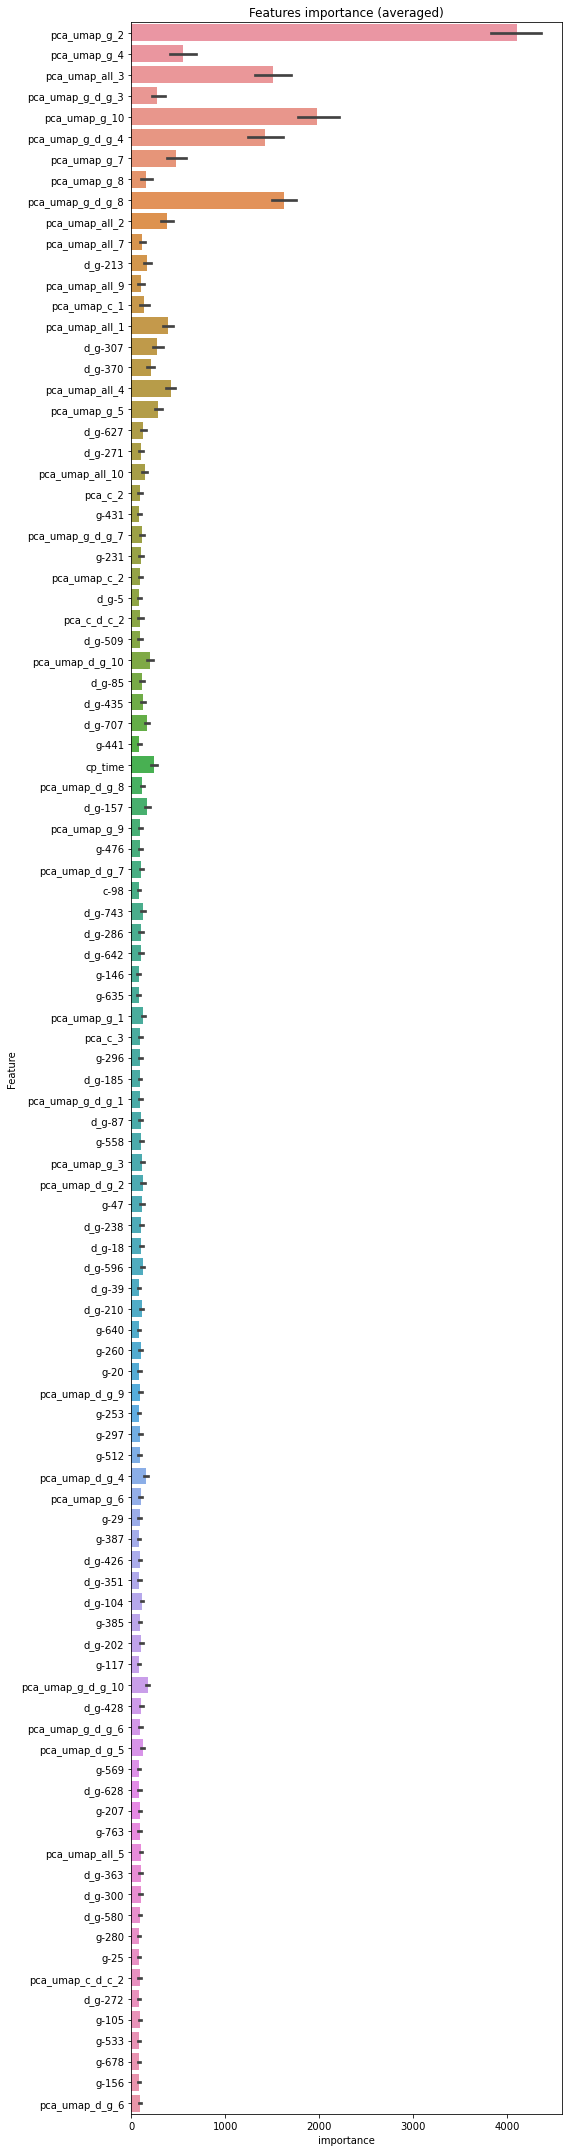

In [49]:
show_feature_importance(feature_importance_df)

In [50]:
feature_importance_df.to_csv(f'feature_importance_df.{Version}.csv', index=False)